- LSTM
- Multiple countries
- Autoregressive training

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import torch.backends.cudnn as cudnn

In [57]:
# Load the CSV file
path = "data/COVID_data.csv"
df = pd.read_csv(path)  # Replace with your file path

country_waves = {"Republic of Korea": {1: [15, 123],
                                   2: [206, 288],
                                   3: [289, 419],
                                   #4: [533, 652], #좀 애매함
                                   5: [736, 897],
                                   6: [897, 1010],
                                   #7: [1010, 1164] #wave가 애매하게 2개임
                                   },
            "China": {#1: [0, 74],
                      #2: [66, 119],
                      3: [154, 266],
                      4: [316, 413], #wave가 살짝 2개에 가까움
                      5: [484, 561],
                      6: [1065, 1119],
                      },
            "United Kingdom of Great Britain and Northern Ireland": {1: [52, 184],
                                                                     2: [192, 486], #wave가 2개라서 아래의 3,4번에서 2개로 나눠도 봄.
                                                                     3: [192, 330], #2번의 앞쪽 wave
                                                                     4: [331, 486], #2번의 뒤쪽 wave
                                                                     5: [772, 871],
                                                                     6: [869, 983]
                   }
            }

using_coutries = ["Republic of Korea", "China", "United Kingdom of Great Britain and Northern Ireland"]
kind = 'New_cases' #[New_cases, Cumulative_cases, New_deaths, Cumulative_deaths]

time_data = {"Republic of Korea": {}, "China": {}, "United Kingdom of Great Britain and Northern Ireland": {}}
real_time_data = {"Republic of Korea": {}, "China": {}, "United Kingdom of Great Britain and Northern Ireland": {}}
wave_data = {"Republic of Korea": {}, "China": {}, "United Kingdom of Great Britain and Northern Ireland": {}}

for country in using_coutries:
    country_data = df[df["Country"] == country]
    country_data["Real_date"] = pd.to_datetime(country_data["Date_reported"]) # save the real date for plotting
    country_data["Date_reported"] = pd.to_datetime(country_data["Date_reported"])
    country_data["Date_reported"] = (country_data["Date_reported"] - country_data["Date_reported"].iloc[0]).dt.days
    new_cases = country_data[kind].values
    new_cases[new_cases < 1] = 1

    for wave in country_waves[country]:
        start, end = country_waves[country][wave]
        time_data[country][wave] = country_data["Date_reported"].values[start:end]
        real_time_data[country][wave] = country_data["Real_date"].values[start:end]
        wave_data[country][wave] = new_cases[start:end]

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\3176094293.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data["Real_date"] = pd.to_datetime(country_data["Date_reported"]) # save the real date for plotting
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\3176094293.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data["Date_reported"] = pd.to_datetime(country_data["Date_reported"])
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\3176094293.py:40: SettingWithCopyWarnin

In [58]:
# Define a function to calculate the 7-number moving average
def moving_average(data, window_size=7):
    half_window = window_size // 2
    smoothed = []
    
    for i in range(len(data)):
        # Handle edge cases
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)
        
        # Calculate the average of the current window
        smoothed.append(np.mean(data[start:end]))
    
    return smoothed

data = {} # smoothed data

for country in wave_data:
    data[country] = {}
    for wave in wave_data[country]:
        data[country][wave] = moving_average(wave_data[country][wave])

# which countries, which waves to use for training
training_coutries = ["Republic of Korea", "China"]
test_coutries = ["United Kingdom of Great Britain and Northern Ireland"]

# Model

In [59]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(PINN, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.1,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(0)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # Shape: (batch_size, hidden_dim)
        return out

# Defining the loss functions
def MSE_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

def SIR_loss(model, t, beta, gamma, mu):
    t = t.requires_grad_(True)  # Enable gradient computation for time tensor

    # Forward pass through the model
    x = model(t)

    # Compute gradients
    dx_dt = torch.autograd.grad(
        x, t, grad_outputs=torch.ones_like(x), create_graph=True
    )[0]  # First derivative

    # SIR model loss: dI/dt = beta * I - gamma * I
    sir_loss = dx_dt + beta * torch.exp(x) - gamma * torch.exp(x)

    # Return the squared loss
    return torch.mean(sir_loss ** 2)

In [60]:
def plot_predictions(data, test_start_point, predicted_values, date_ticks, country, wave, epoch):
    """
    Plot predictions and training results.
    """
    # Ensure the save directory exists
    #if not os.path.exists(save_path):
    #    os.makedirs(save_path)

    data = data.cpu().numpy()

    predictions = np.append(np.array([None]*test_start_point), predicted_values)

    fig, ax1 = plt.subplots(figsize=(18, 8))
    plt.title(f"{country}-{wave}. Epoch: {epoch + 1}")

    # Training Data
    ax1.plot(date_ticks, data, 'ro', markersize=8, label='Training data')

    # Predicted values
    ax1.plot(date_ticks, predictions, color="orange", label="Predicted by PINN")

    # Format x-axis
    ax1.set_xlabel("Date")
    ax1.set_ylabel("I(t)", color="k")
    ax1.tick_params(axis='y', labelcolor="k")
    ax1.legend(loc="upper left")
    ax1.grid()

    # Set date ticks
    tick_labels = np.array(date_ticks[:len(data[::7])])
    ax1.set_xticks(np.array(date_ticks[::7].flatten())) # 없어도 될 것 같음
    ax1.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor")

    # Plotting
    plt.tight_layout()
    plt.show()
    plt.close()

In [61]:
class EarlyStopping:
    def __init__(self, model, patience, display_step, sigma, sigma0, mu):
        self.patience = patience
        self.display_step = display_step
        self.model = model
        self.sigma = sigma
        self.sigma0 = sigma0
        self.mu = mu
        
        self.best_loss = np.inf
        self.wait = 0

        self.best_model = None
        self.bests_weights = None
        self.bestSigma = None
        self.bestSigma0 = None
        self.bestMu = None

    def check_early_stopping(self, current_loss, epoch):
        if current_loss < self.best_loss:
            self.best_loss = current_loss.cpu().item() if torch.is_tensor(current_loss) else current_loss
            self.wait = 0

            self.best_model = self.model
            self.best_weights = self.model.state_dict()
            self.bestSigma = self.sigma
            self.bestSigma0 = self.sigma0
            self.bestMu = self.mu
        else:
            self.wait += 1
        
        if self.wait >= self.patience:
            print(f"Early stopping at epoch {epoch}.")
            self.model.load_state_dict(self.best_weights)
            return True
        return False

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Training

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


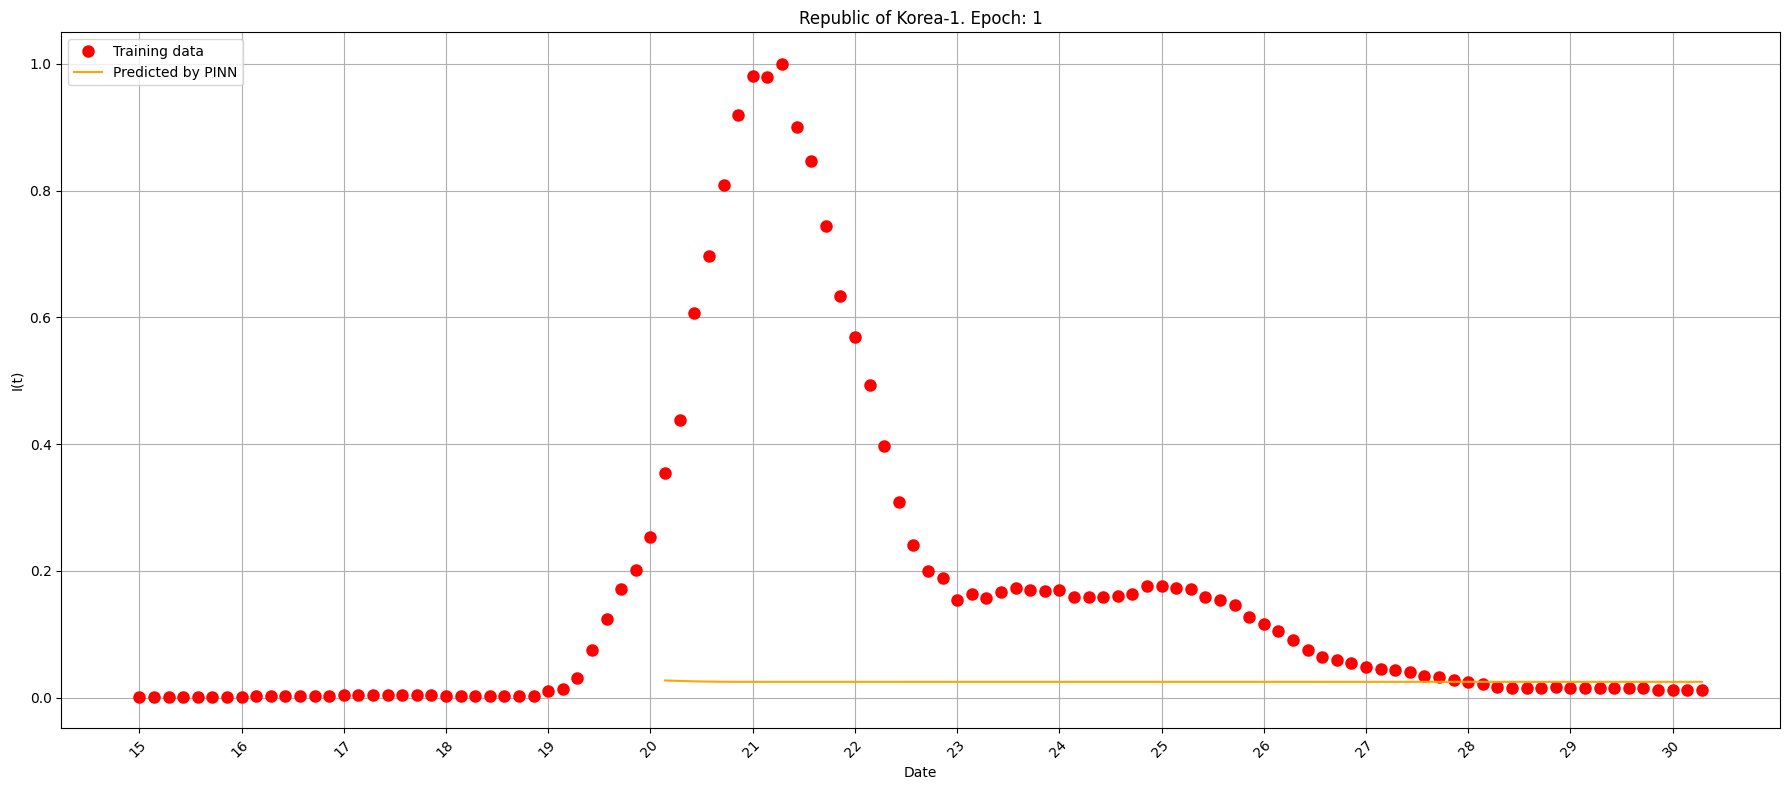

Epoch 1, MSE Loss = 0.00021845177980139852, SIR Loss = 3.9812104546399496e-07, Average Loss = 0.05036464613392528


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


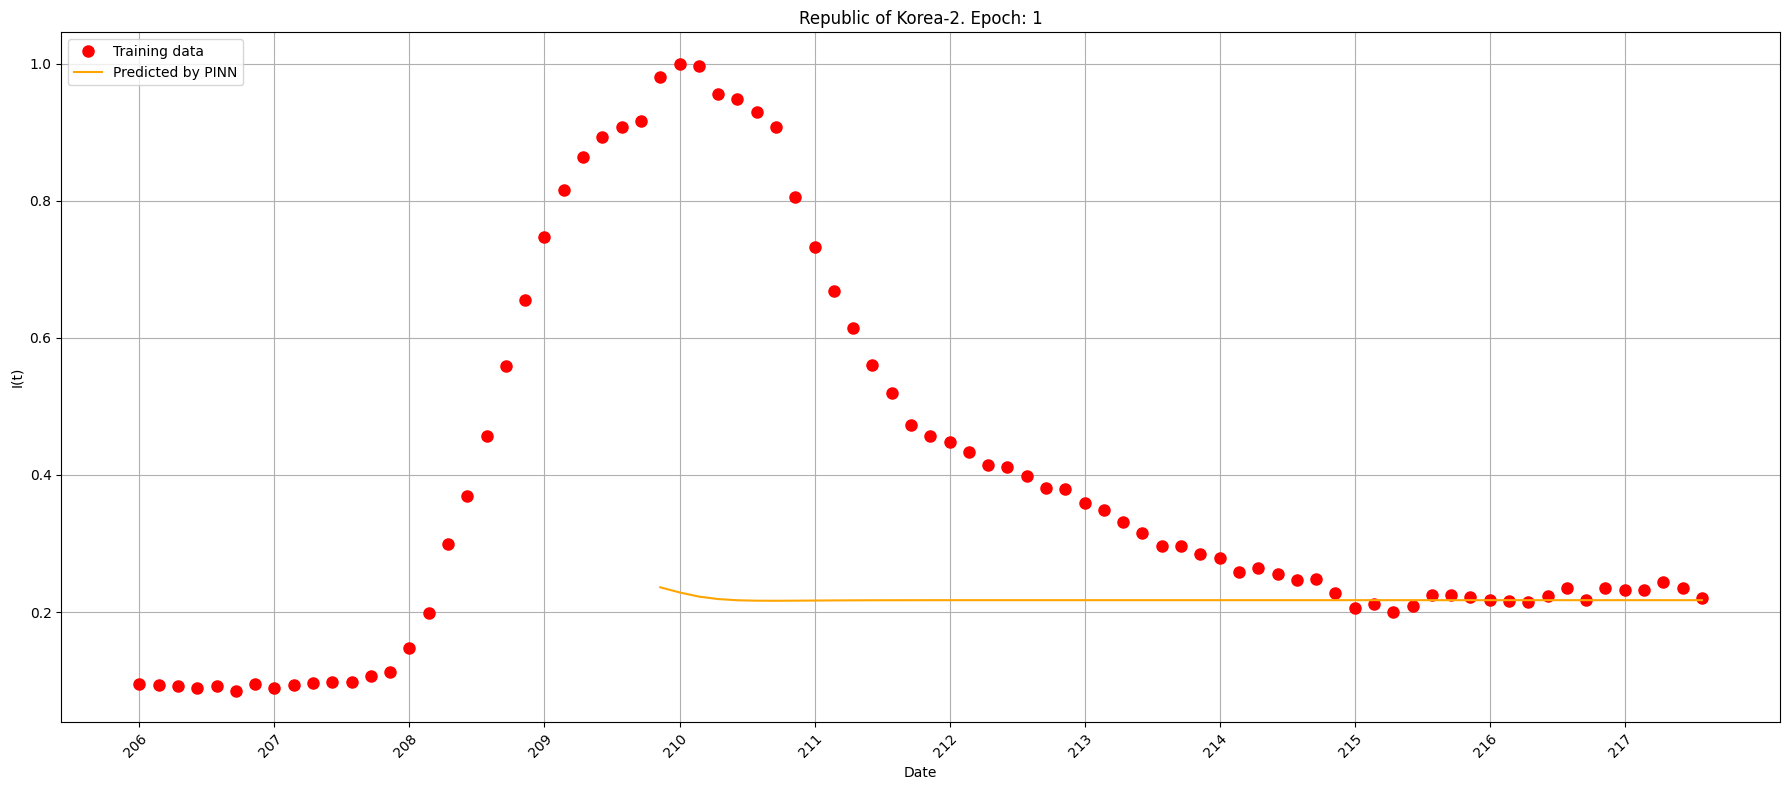

Epoch 1, MSE Loss = 1.5751512592032668e-06, SIR Loss = 1.5909230877131364e-10, Average Loss = 0.12451881245260968


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


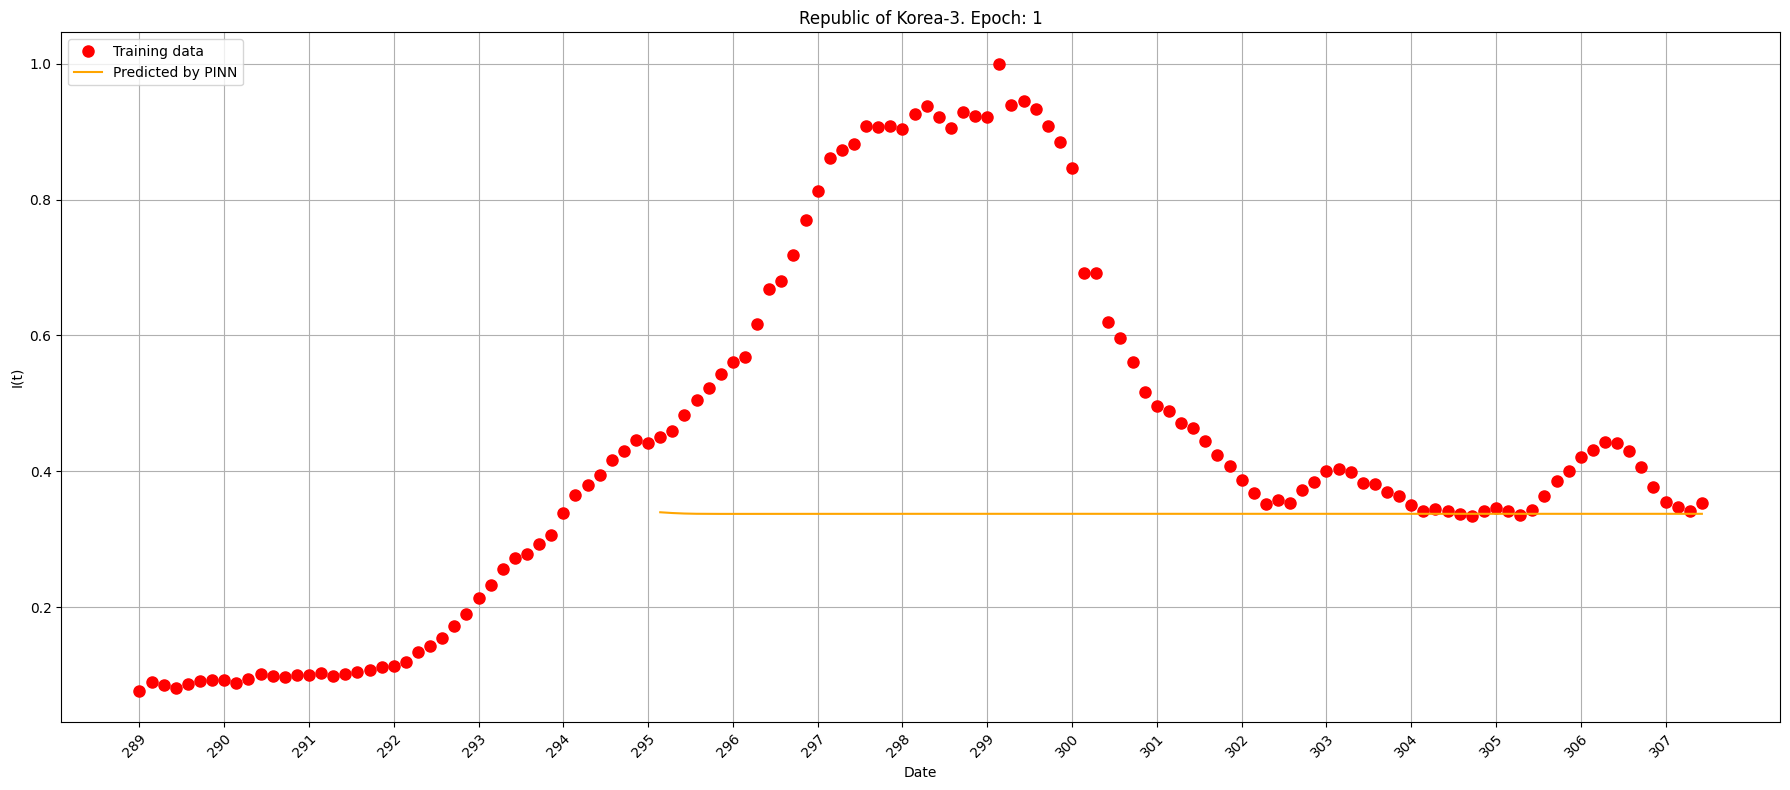

Epoch 1, MSE Loss = 0.000351746246451512, SIR Loss = 1.6790790979825942e-11, Average Loss = 0.04455072680235651


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


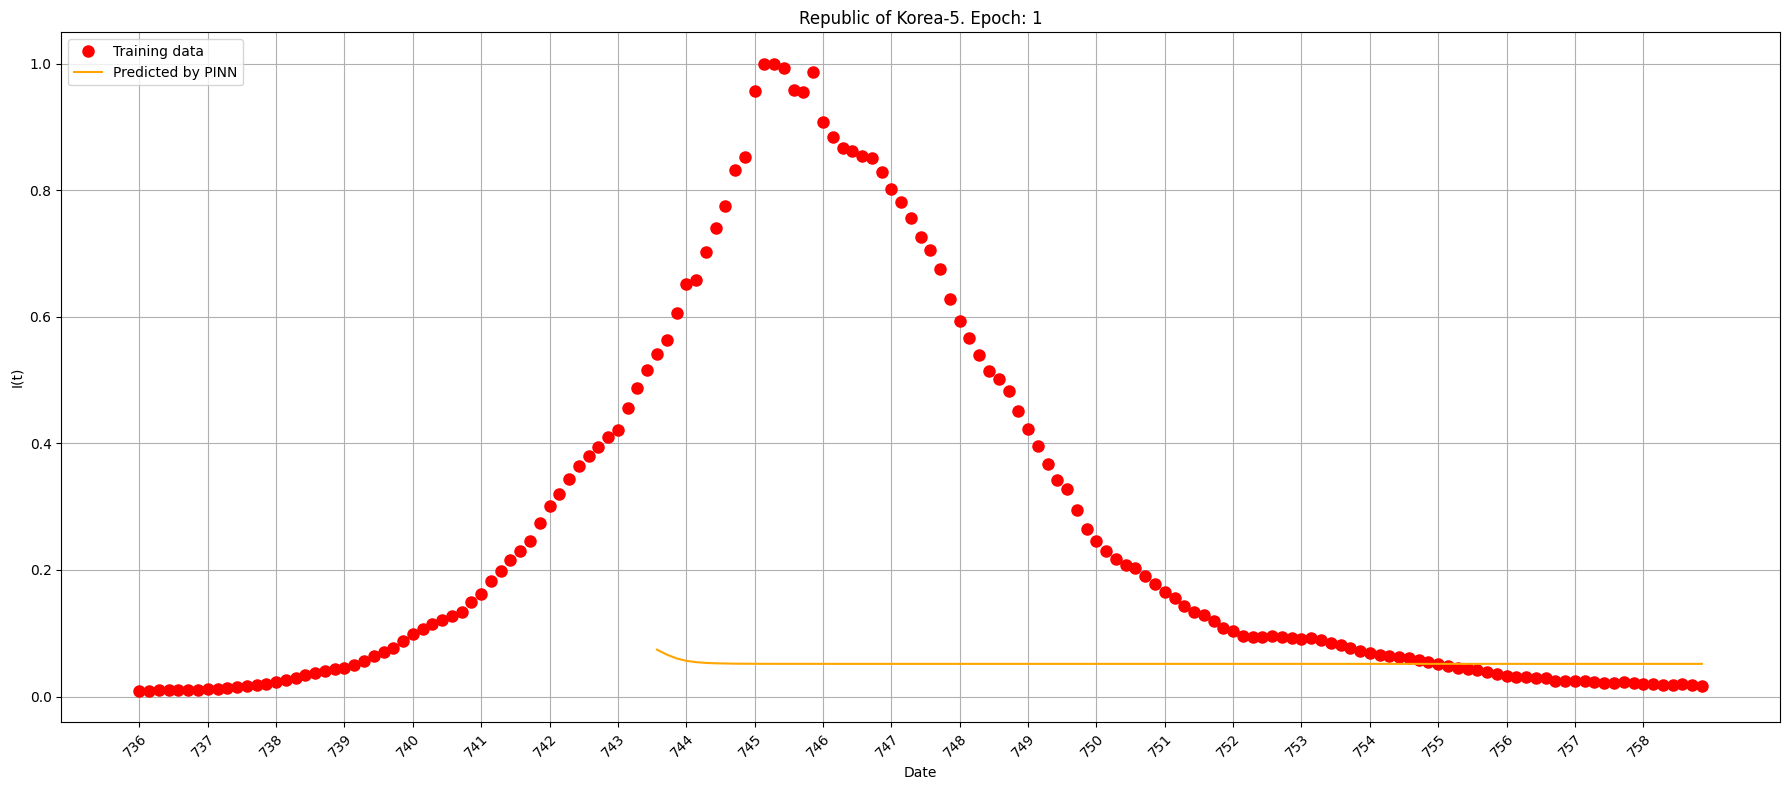

Epoch 1, MSE Loss = 0.0008402236853726208, SIR Loss = 8.0284987913435e-14, Average Loss = 0.07246640004475555


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


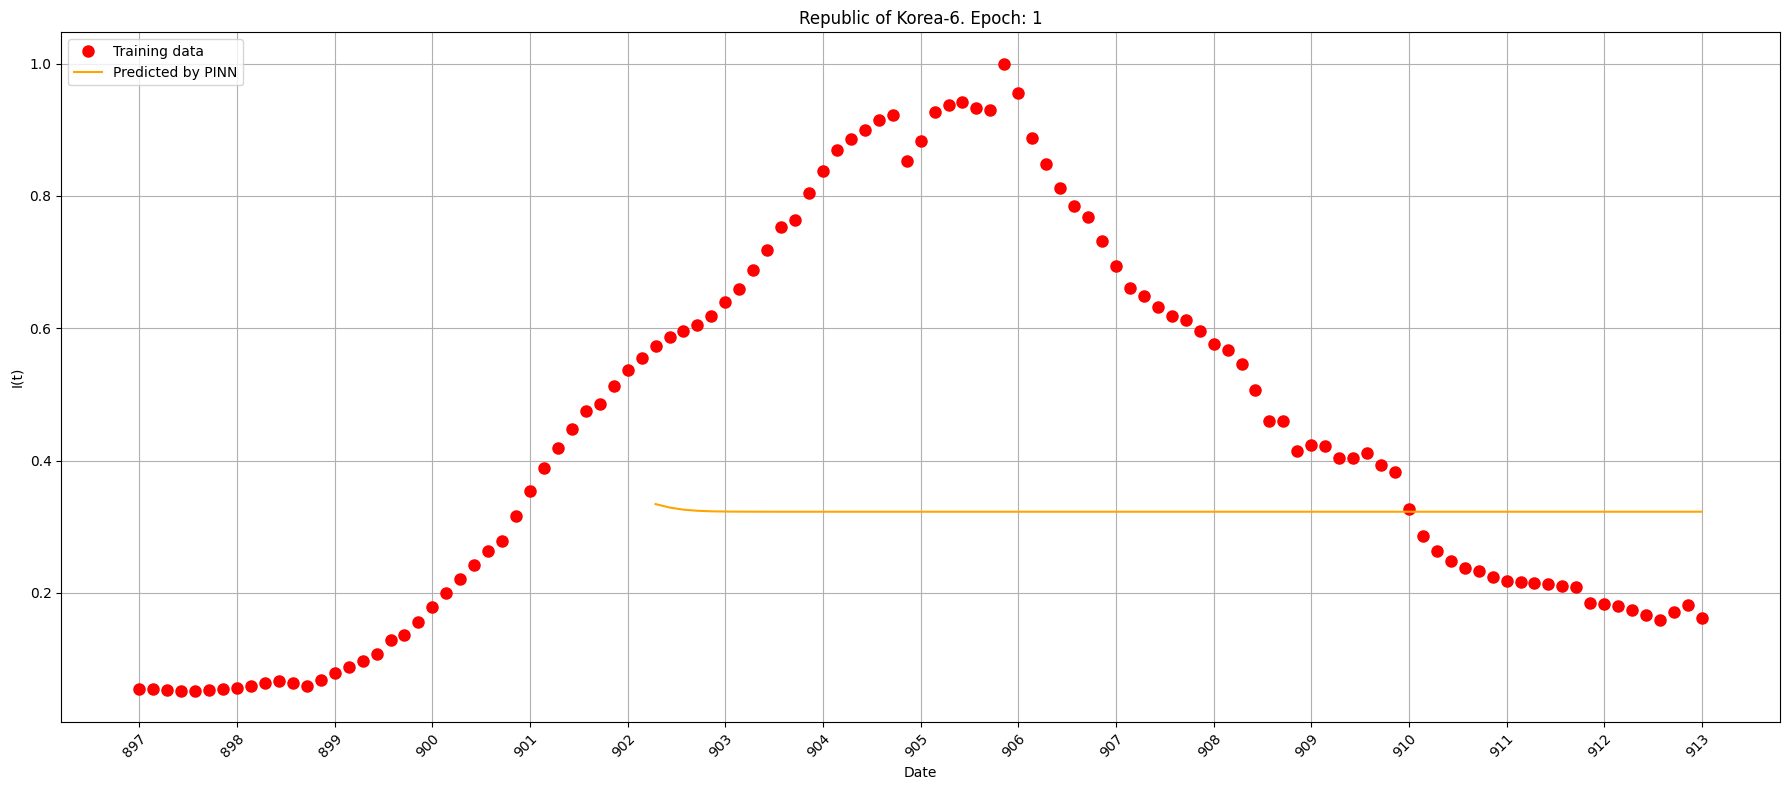

Epoch 1, MSE Loss = 0.02464383654296398, SIR Loss = 3.6561232557089096e-13, Average Loss = 0.09602101161124425


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


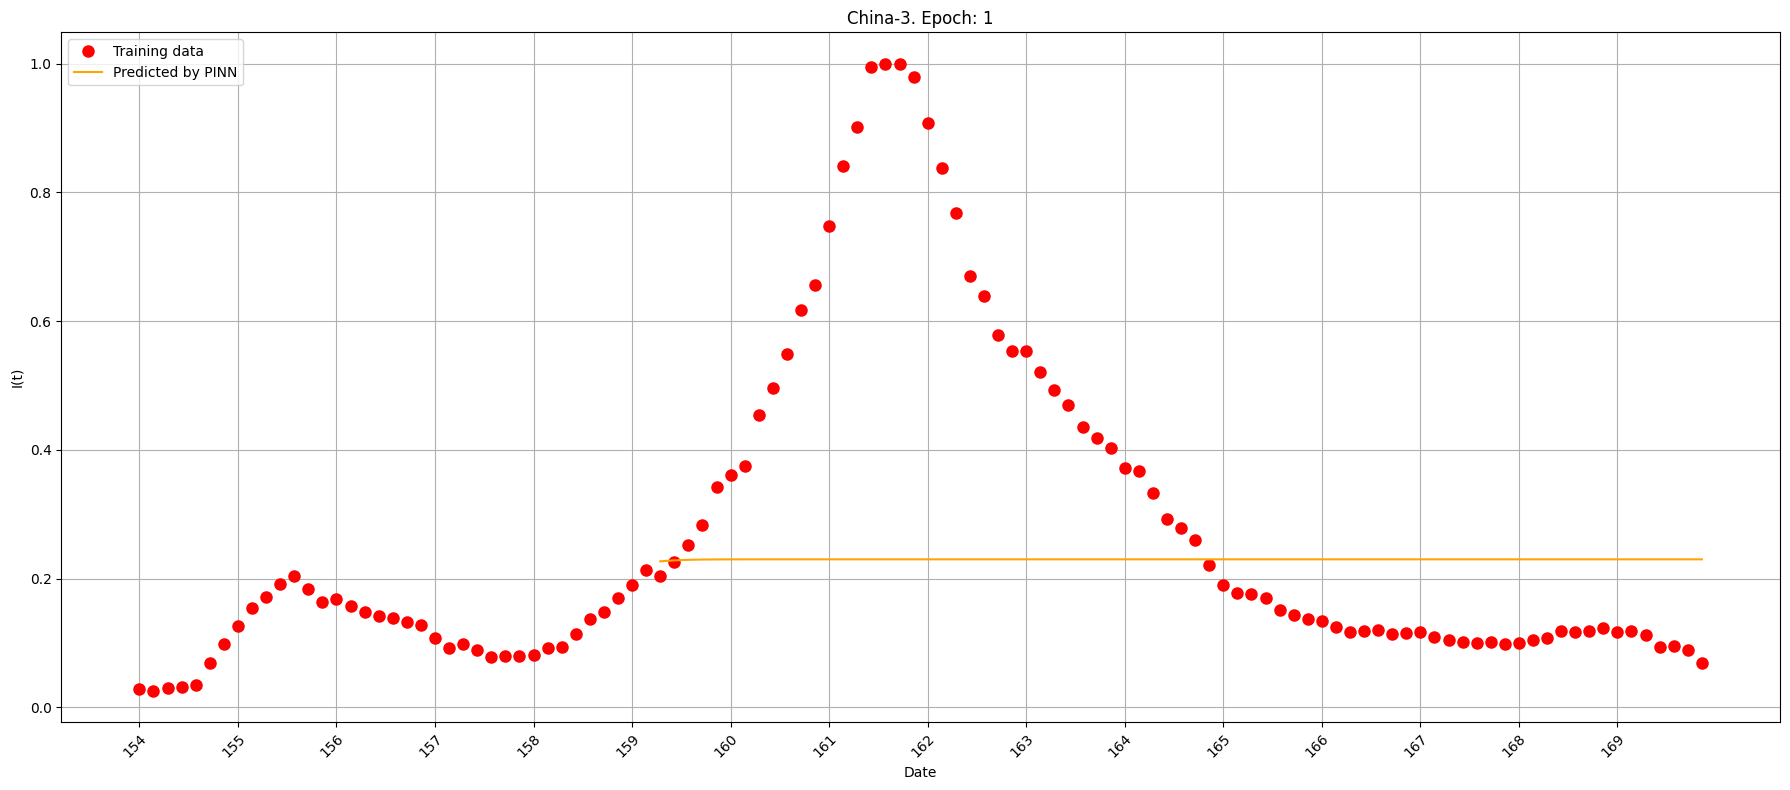

Epoch 1, MSE Loss = 0.023971933871507645, SIR Loss = 1.1188894949443196e-10, Average Loss = 0.06994174163929053


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


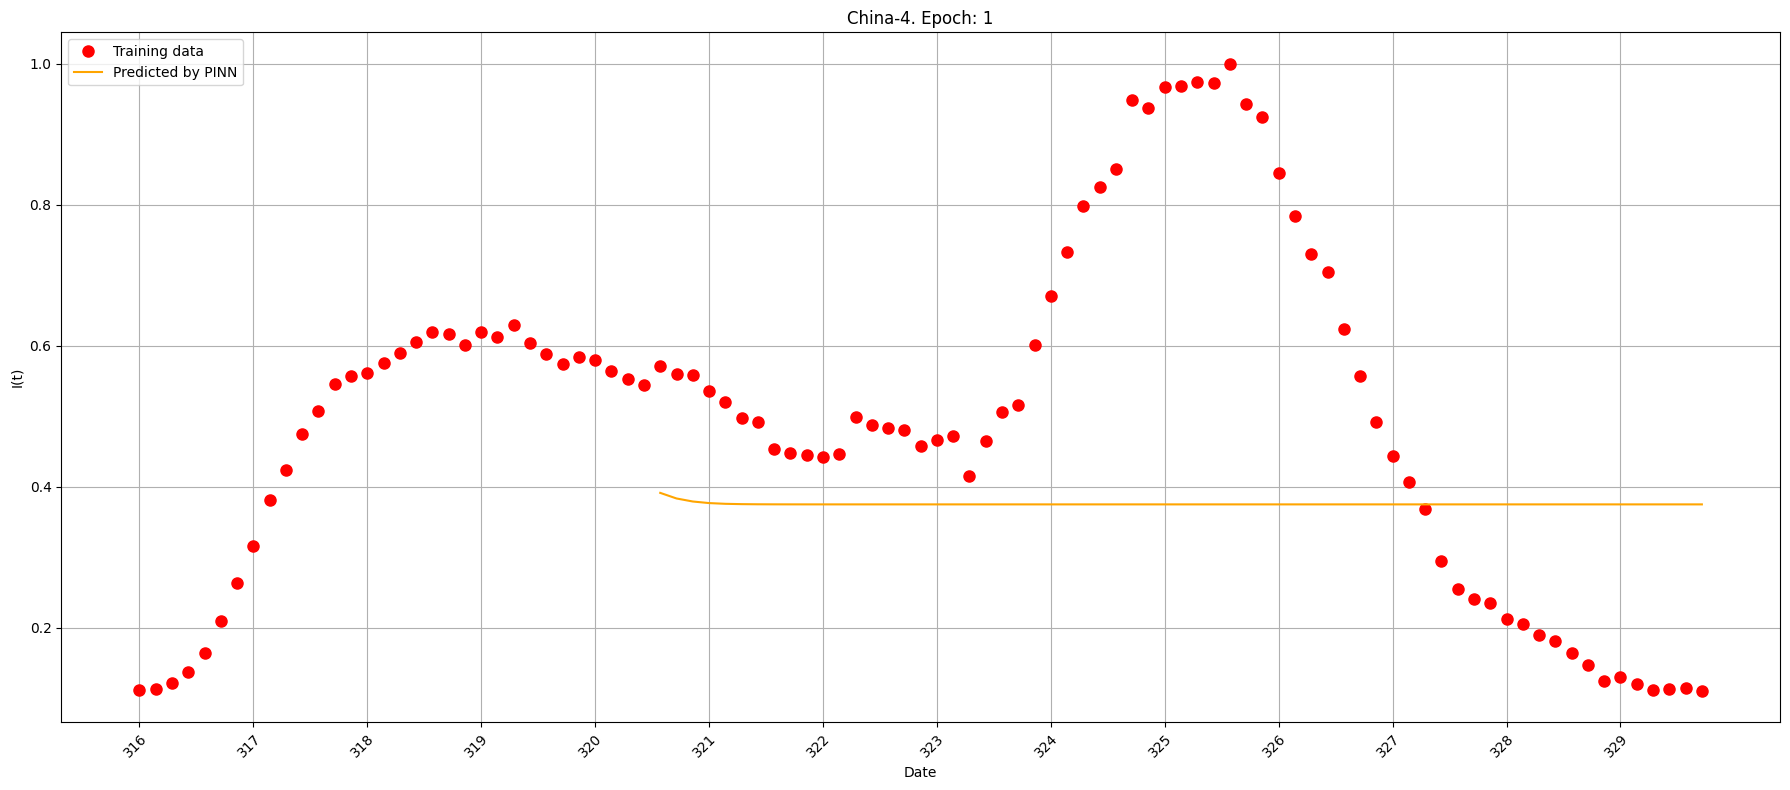

Epoch 1, MSE Loss = 0.0623914860188961, SIR Loss = 4.949913742779977e-12, Average Loss = 0.06851542682894834


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


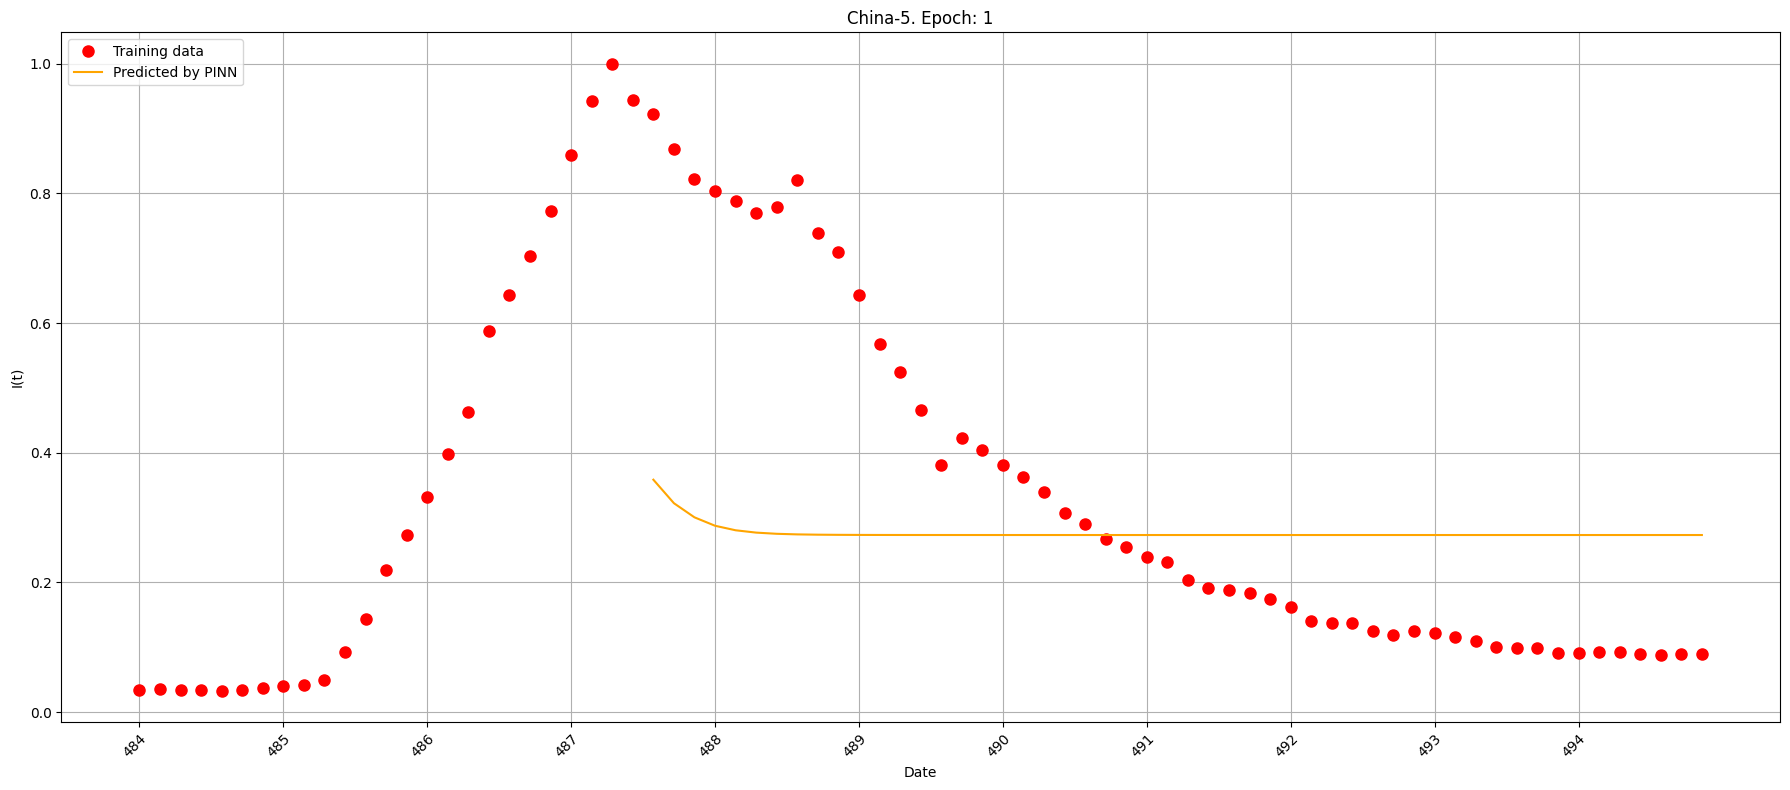

Epoch 1, MSE Loss = 0.025144366547465324, SIR Loss = 1.0982643830828587e-12, Average Loss = 0.08646165257762602


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


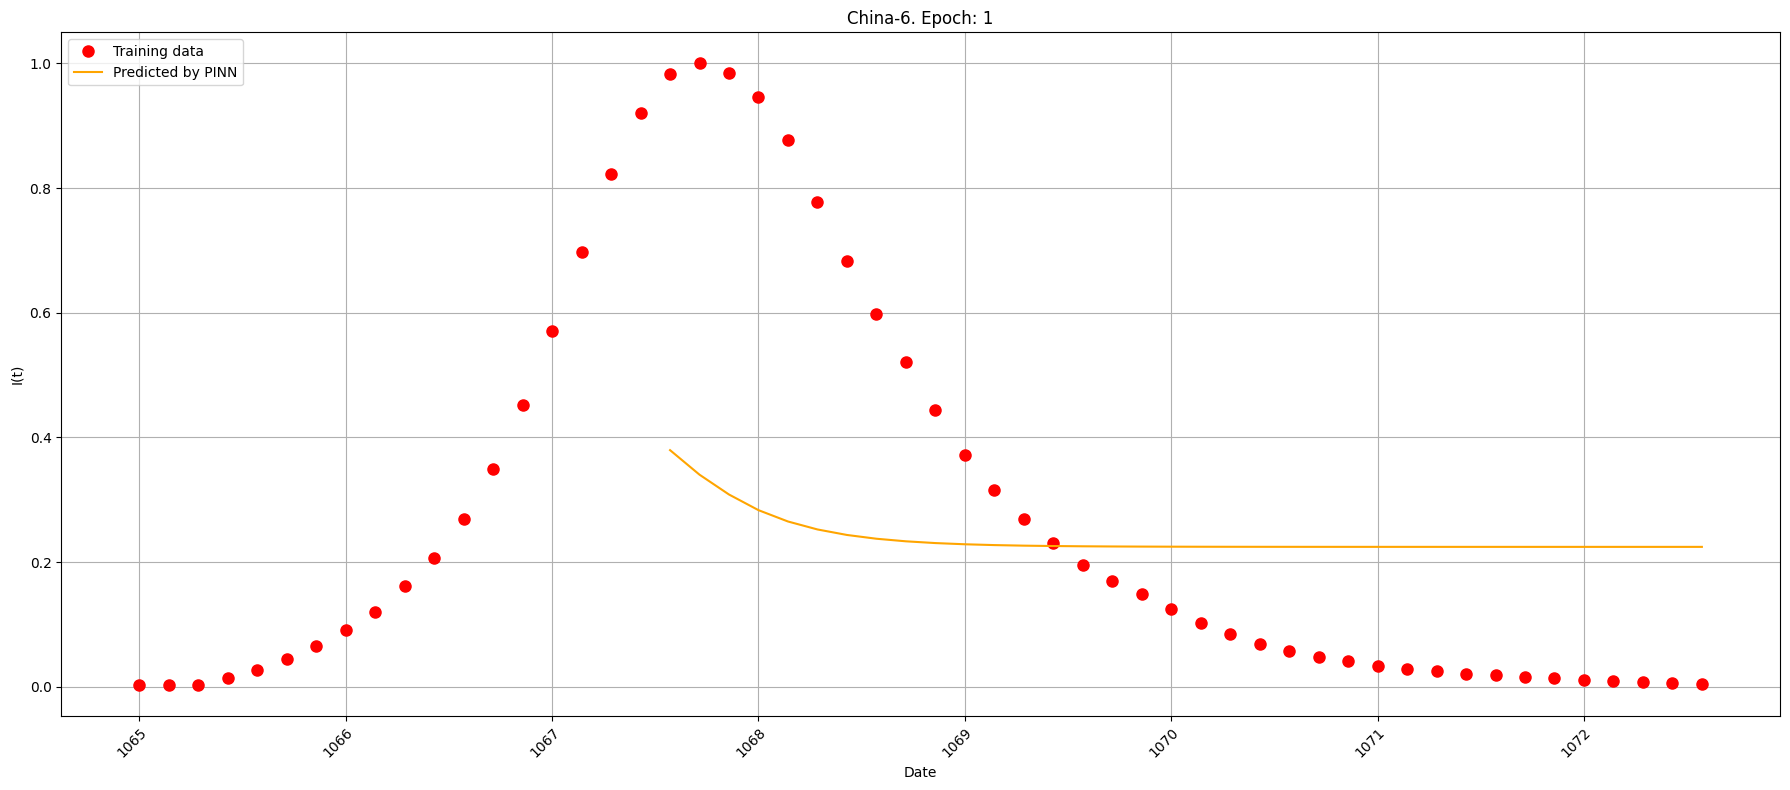

Epoch 1, MSE Loss = 0.02562238648533821, SIR Loss = 1.4719305635457758e-11, Average Loss = 0.09563864415931095


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Epoch 11, MSE Loss = 1.6621136411654192e-10, SIR Loss = 3.84272397013774e-07, Average Loss = 0.001092305991428959
Epoch 11, MSE Loss = 0.001490444177761674, SIR Loss = 1.6312945438912152e-09, Average Loss = 0.0015988606913622642
Epoch 11, MSE Loss = 6.946865323698148e-05, SIR Loss = 2.976524582365414e-10, Average Loss = 0.0011556151025457102
Epoch 11, MSE Loss = 0.0007765255868434906, SIR Loss = 1.2688264067889365e-12, Average Loss = 0.00042997270260176175
Epoch 11, MSE Loss = 0.0016123636160045862, SIR Loss = 6.398945175817294e-12, Average Loss = 0.0008810640610126463
Epoch 11, MSE Loss = 0.0003402482543606311, SIR Loss = 2.9935918188783717e-09, Average Loss = 0.0007839448071778964
Epoch 11, MSE Loss = 0.0006218214402906597, SIR Loss = 1.5598443370290482e-10, Average Loss = 0.0013585985846656318
Epoch 11, MSE Loss = 0.0006703920080326498, SIR Loss = 1.304125141210477e-10, Average Loss = 0.0010583561322403995
Epoch 11, MSE Loss = 7.047558028716594e-05, SIR Loss = 0.0, Average Loss = 0.

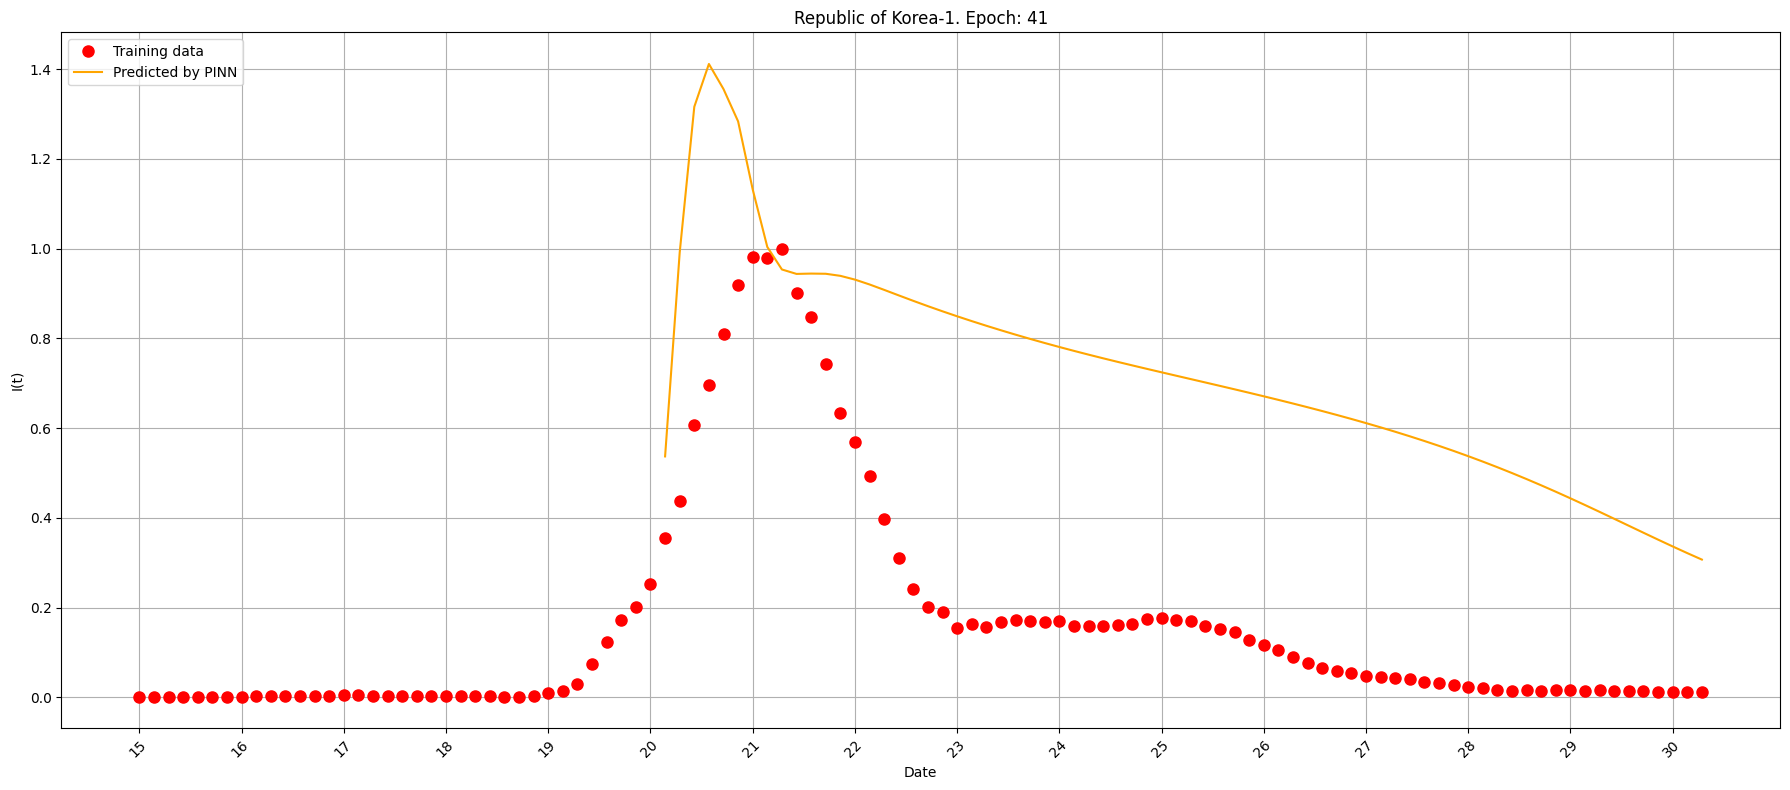

Epoch 41, MSE Loss = 8.378870006708894e-06, SIR Loss = 2.8195814572029576e-09, Average Loss = 0.0017127976895387328


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


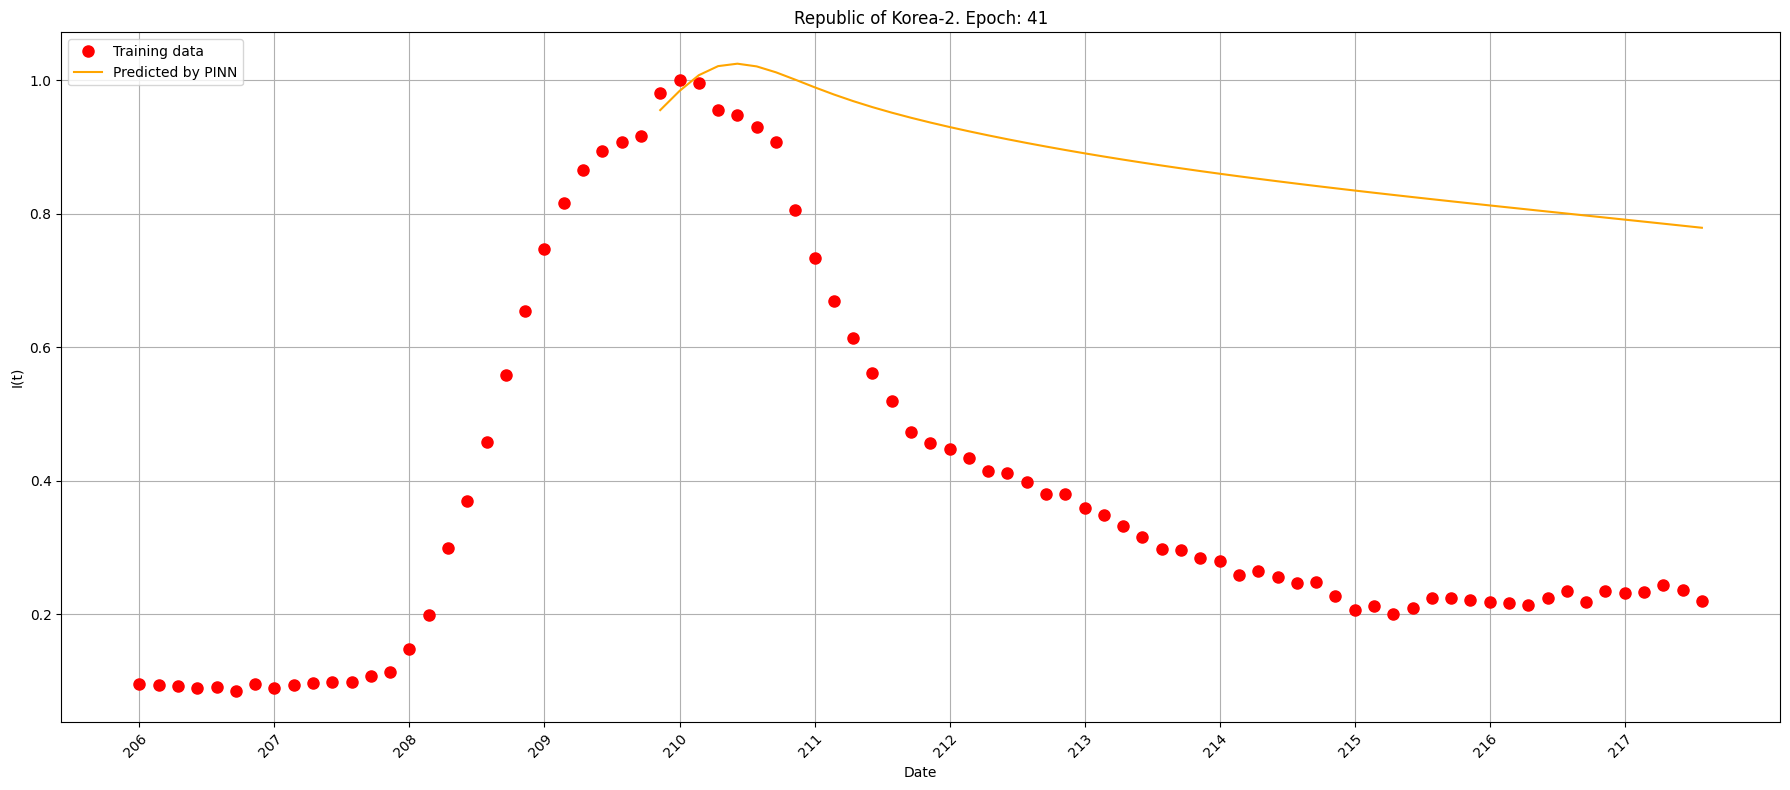

Epoch 41, MSE Loss = 9.976004366762936e-05, SIR Loss = 5.4324961196172694e-11, Average Loss = 0.0009737163324340396


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


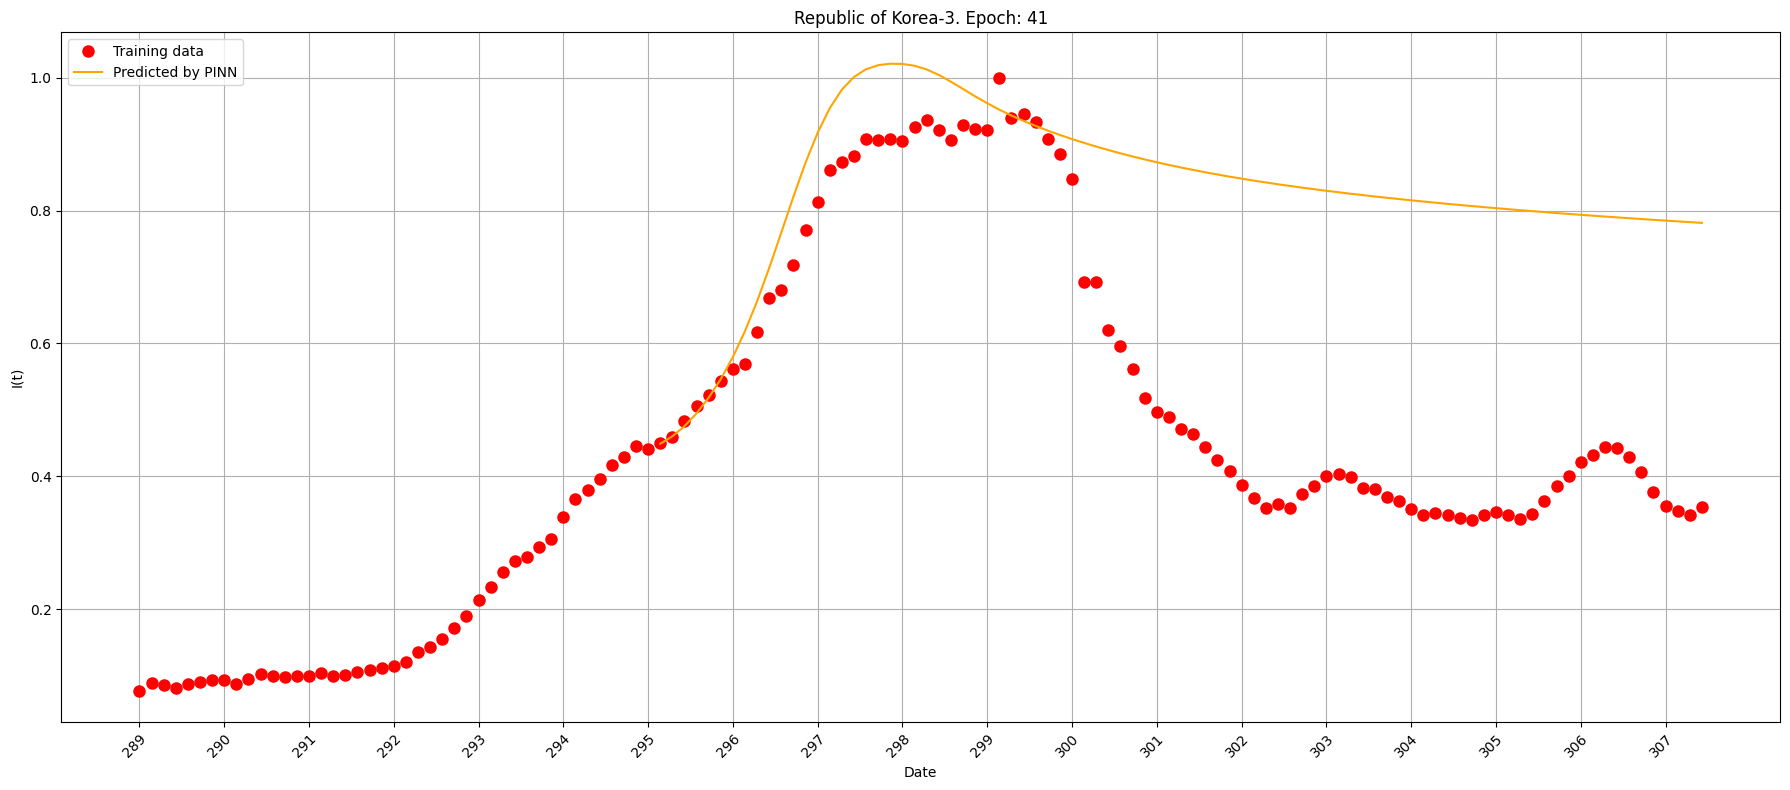

Epoch 41, MSE Loss = 0.00019076408352702856, SIR Loss = 1.951347070039411e-11, Average Loss = 0.0006896735486685622


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


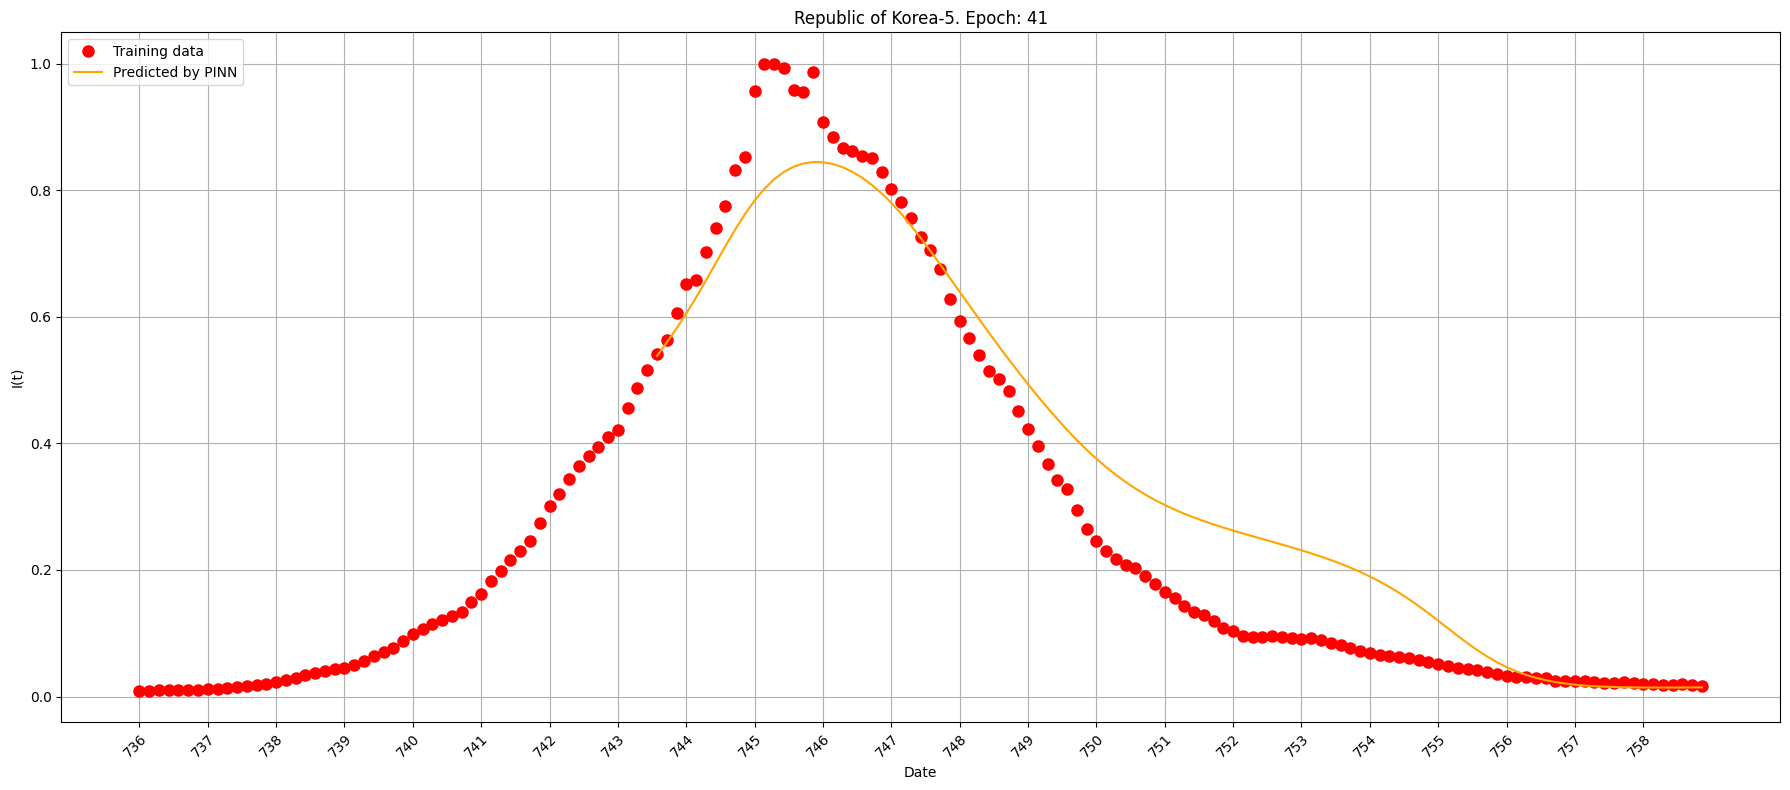

Epoch 41, MSE Loss = 6.0549598856596276e-05, SIR Loss = 4.798688668650186e-10, Average Loss = 0.00040622305415576206


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


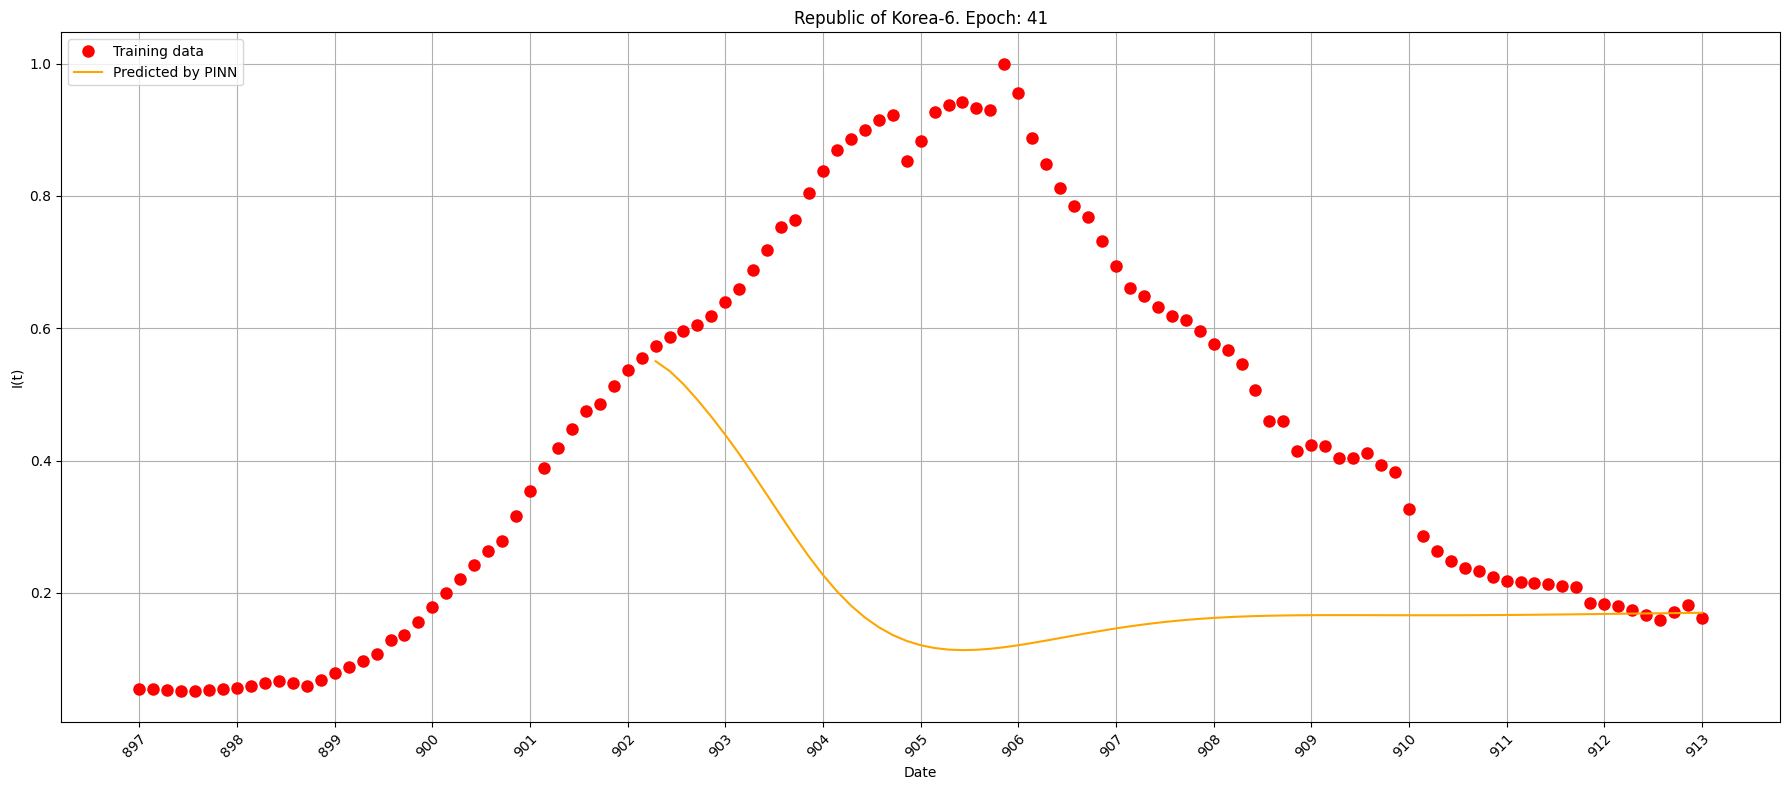

Epoch 41, MSE Loss = 2.7752845198847353e-05, SIR Loss = 4.78981969782551e-15, Average Loss = 0.0004841202875734282


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


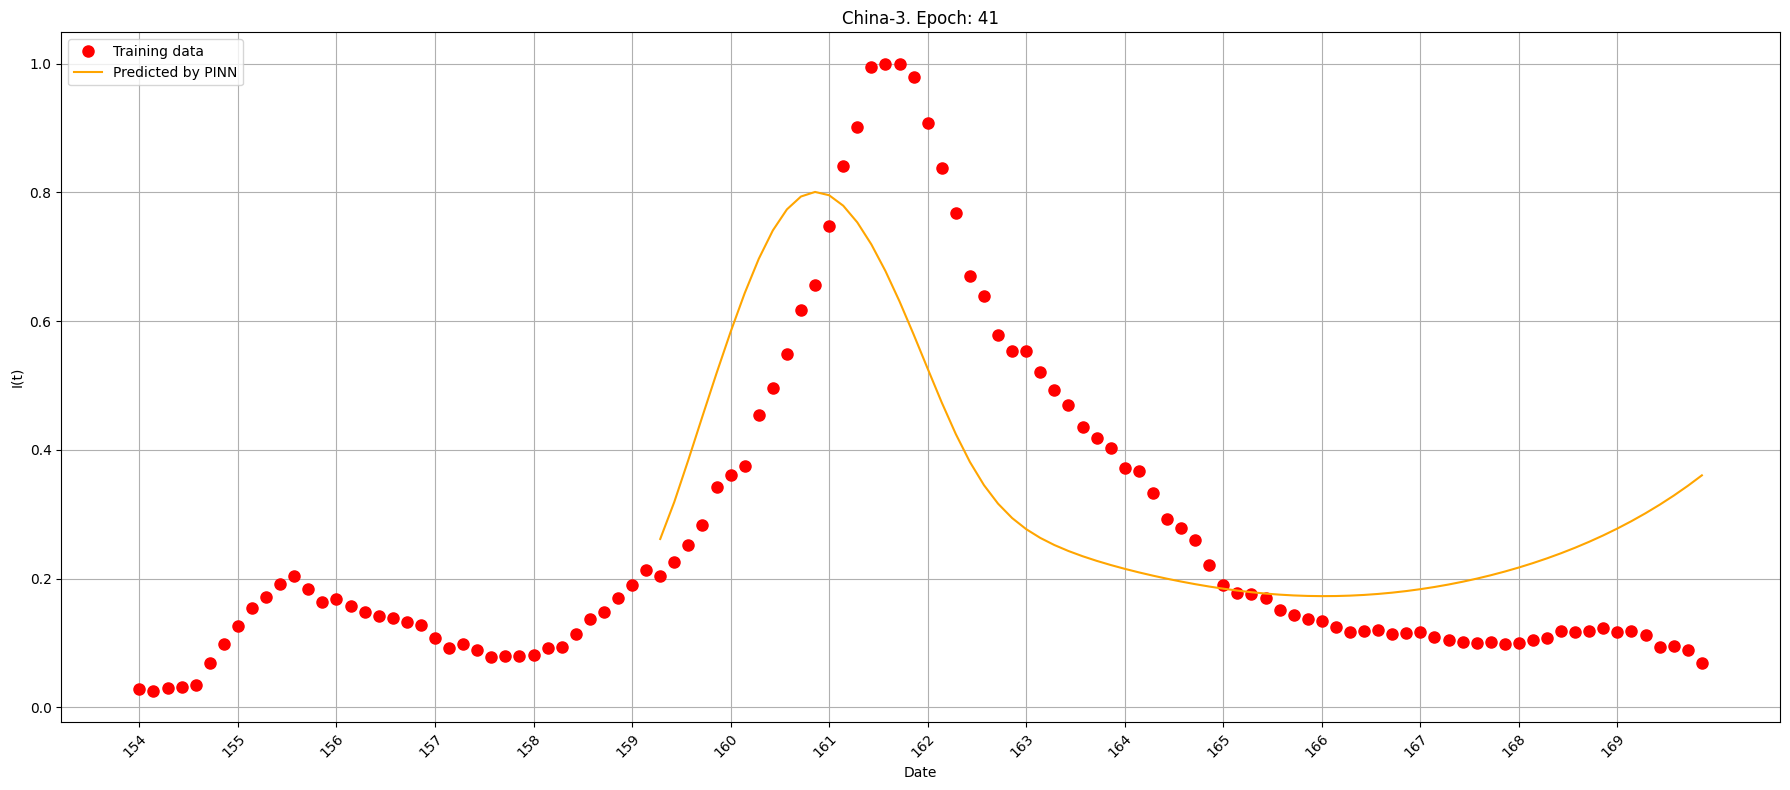

Epoch 41, MSE Loss = 0.0004415489383973181, SIR Loss = 4.884430637730475e-10, Average Loss = 0.0006046242337557065


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


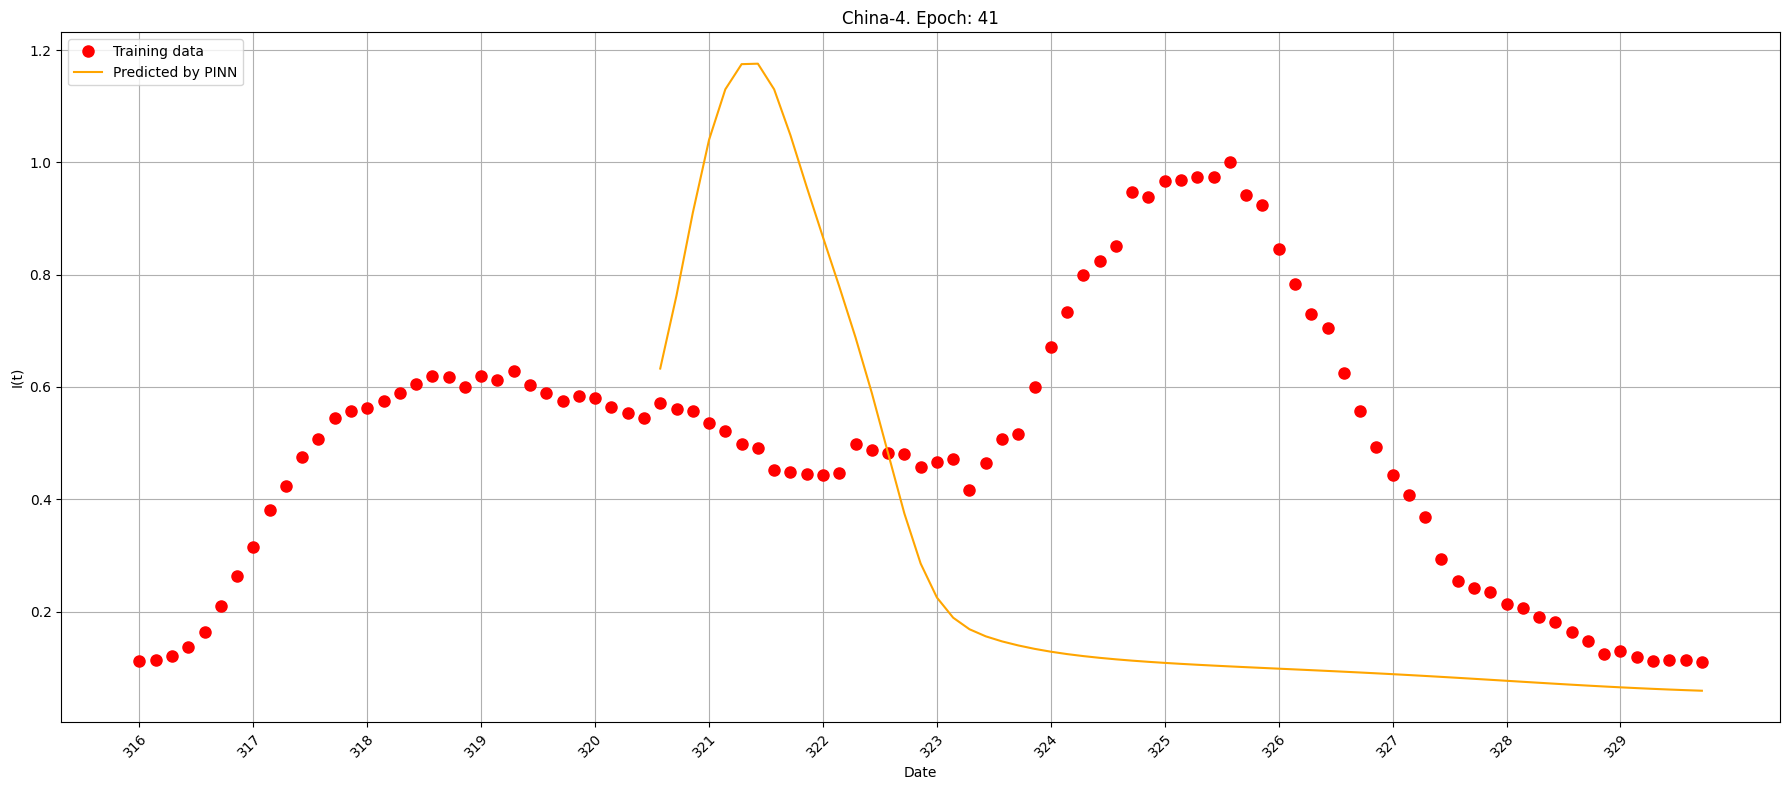

Epoch 41, MSE Loss = 1.3211521832090511e-07, SIR Loss = 6.213112663244758e-11, Average Loss = 0.000920907958057588


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


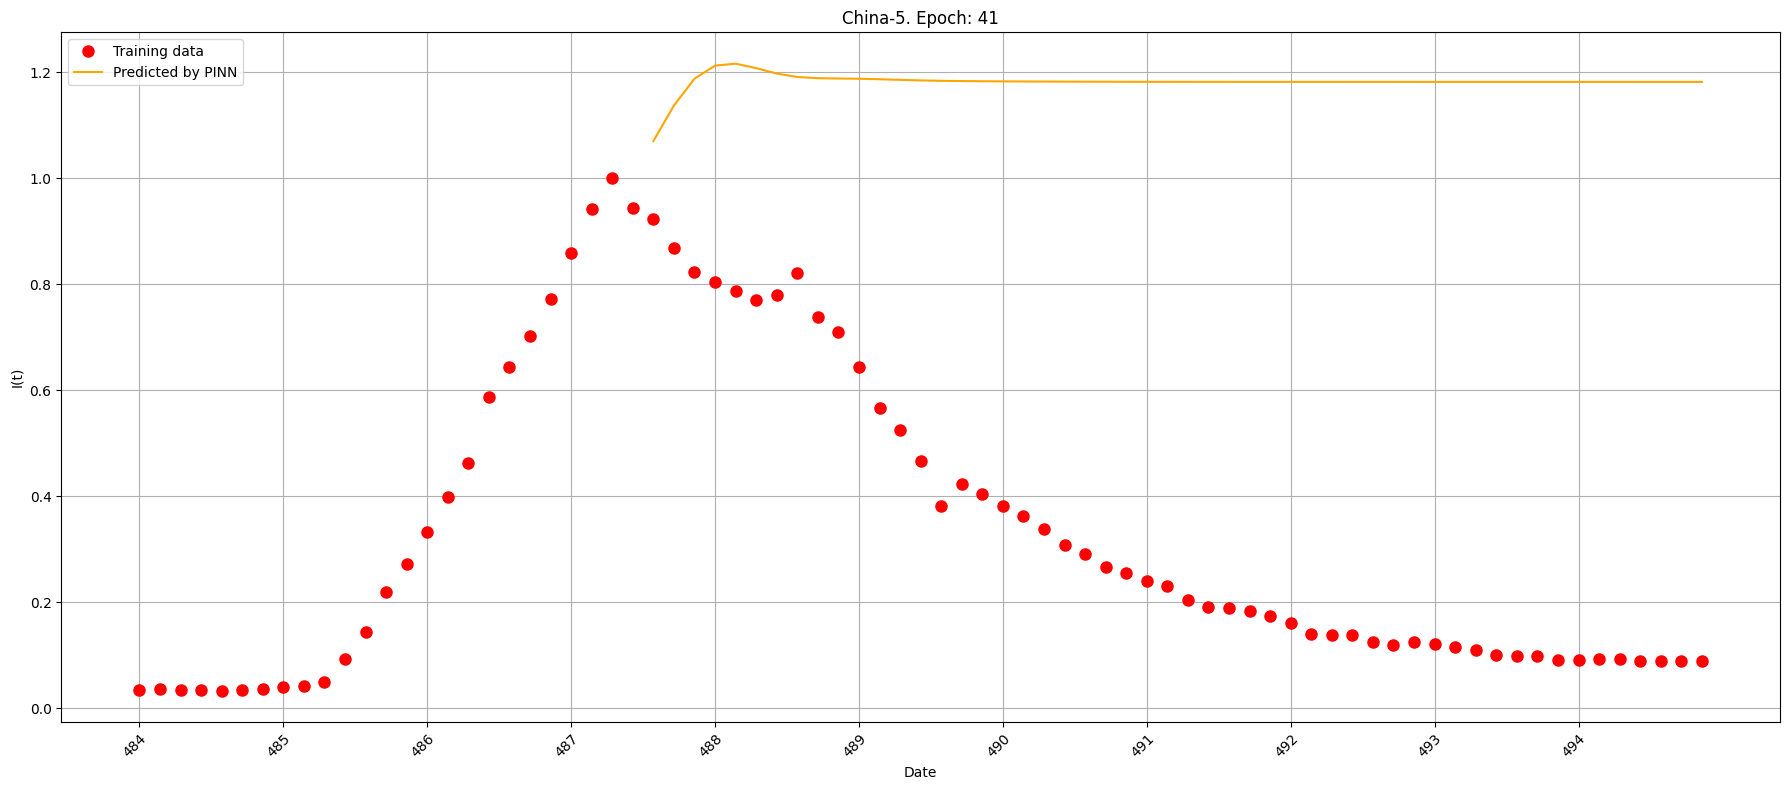

Epoch 41, MSE Loss = 2.665832835191395e-05, SIR Loss = 6.34413185289139e-17, Average Loss = 0.0015039087995761845


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


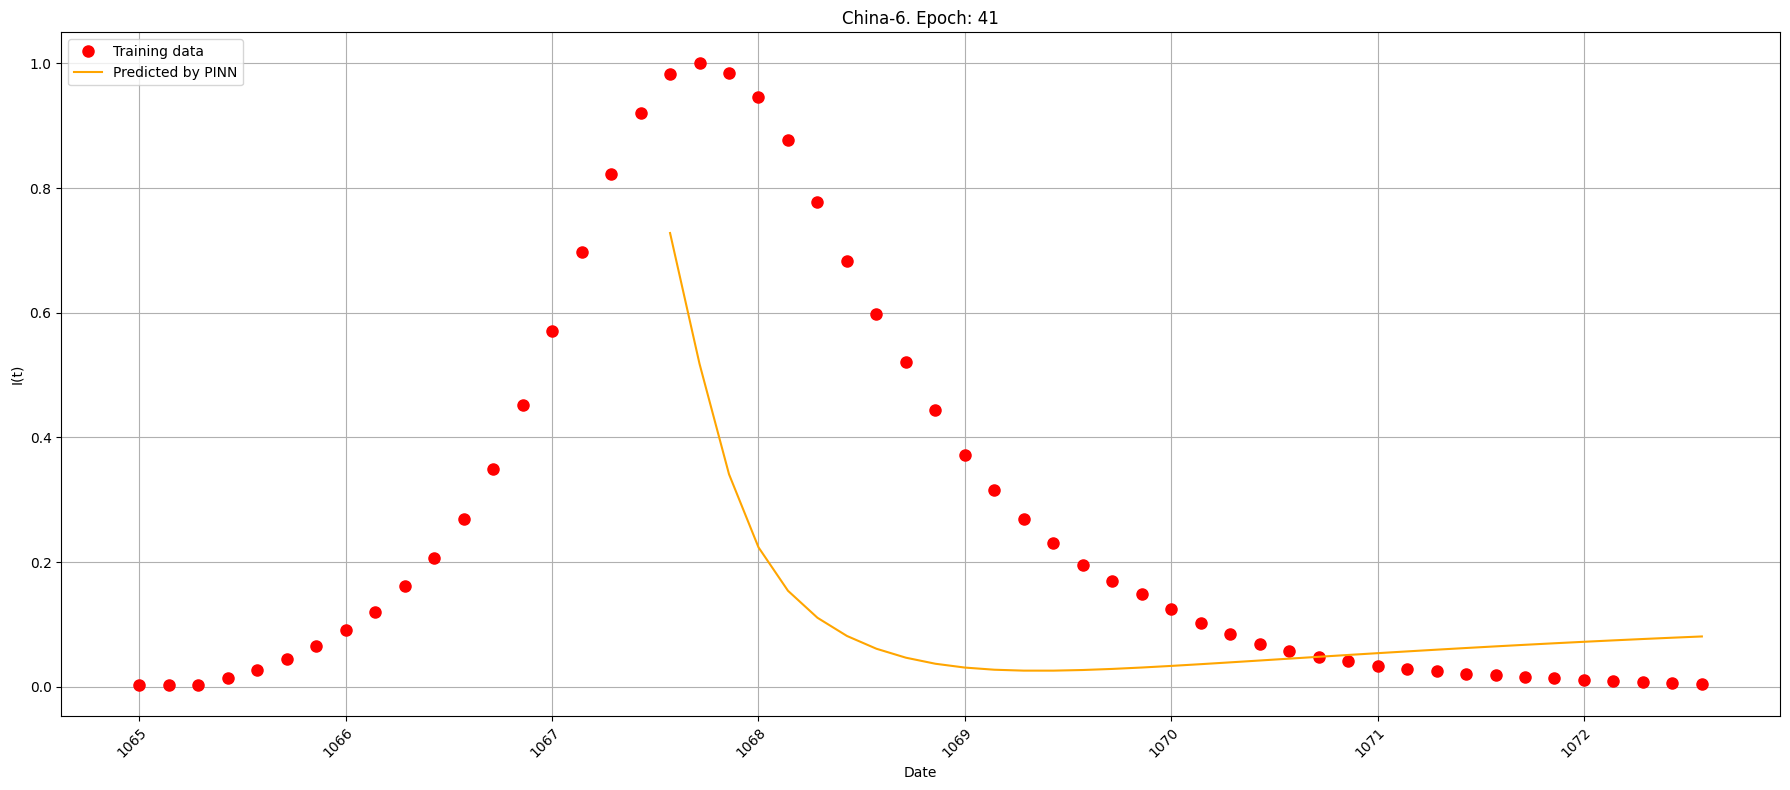

Epoch 41, MSE Loss = 2.174013206968084e-05, SIR Loss = 0.0, Average Loss = 0.0020116452225737284


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Epoch 51, MSE Loss = 1.617372254258953e-05, SIR Loss = 9.642280751620547e-09, Average Loss = 0.0008122781335675719
Epoch 51, MSE Loss = 1.9195780623704195e-05, SIR Loss = 7.43323874674573e-11, Average Loss = 0.0007840753560185476
Epoch 51, MSE Loss = 0.00165500957518816, SIR Loss = 3.327284628373839e-11, Average Loss = 0.0012236349147840535
Epoch 51, MSE Loss = 0.00013554726319853216, SIR Loss = 2.6689761511988763e-13, Average Loss = 0.00047371982179838997
Epoch 51, MSE Loss = 0.0011284415377303958, SIR Loss = 3.0039464432628574e-14, Average Loss = 0.0013843703365512927
Epoch 51, MSE Loss = 0.0008601409499533474, SIR Loss = 3.1982211323722254e-10, Average Loss = 0.002691647727398222
Epoch 51, MSE Loss = 5.313270321494201e-06, SIR Loss = 5.427404944739755e-13, Average Loss = 0.0008969072065615751
Epoch 51, MSE Loss = 4.035414895042777e-05, SIR Loss = 3.95467816480255e-12, Average Loss = 0.0011316327982716042
Epoch 51, MSE Loss = 8.695007636561058e-06, SIR Loss = 2.8036177546209018e-11, 

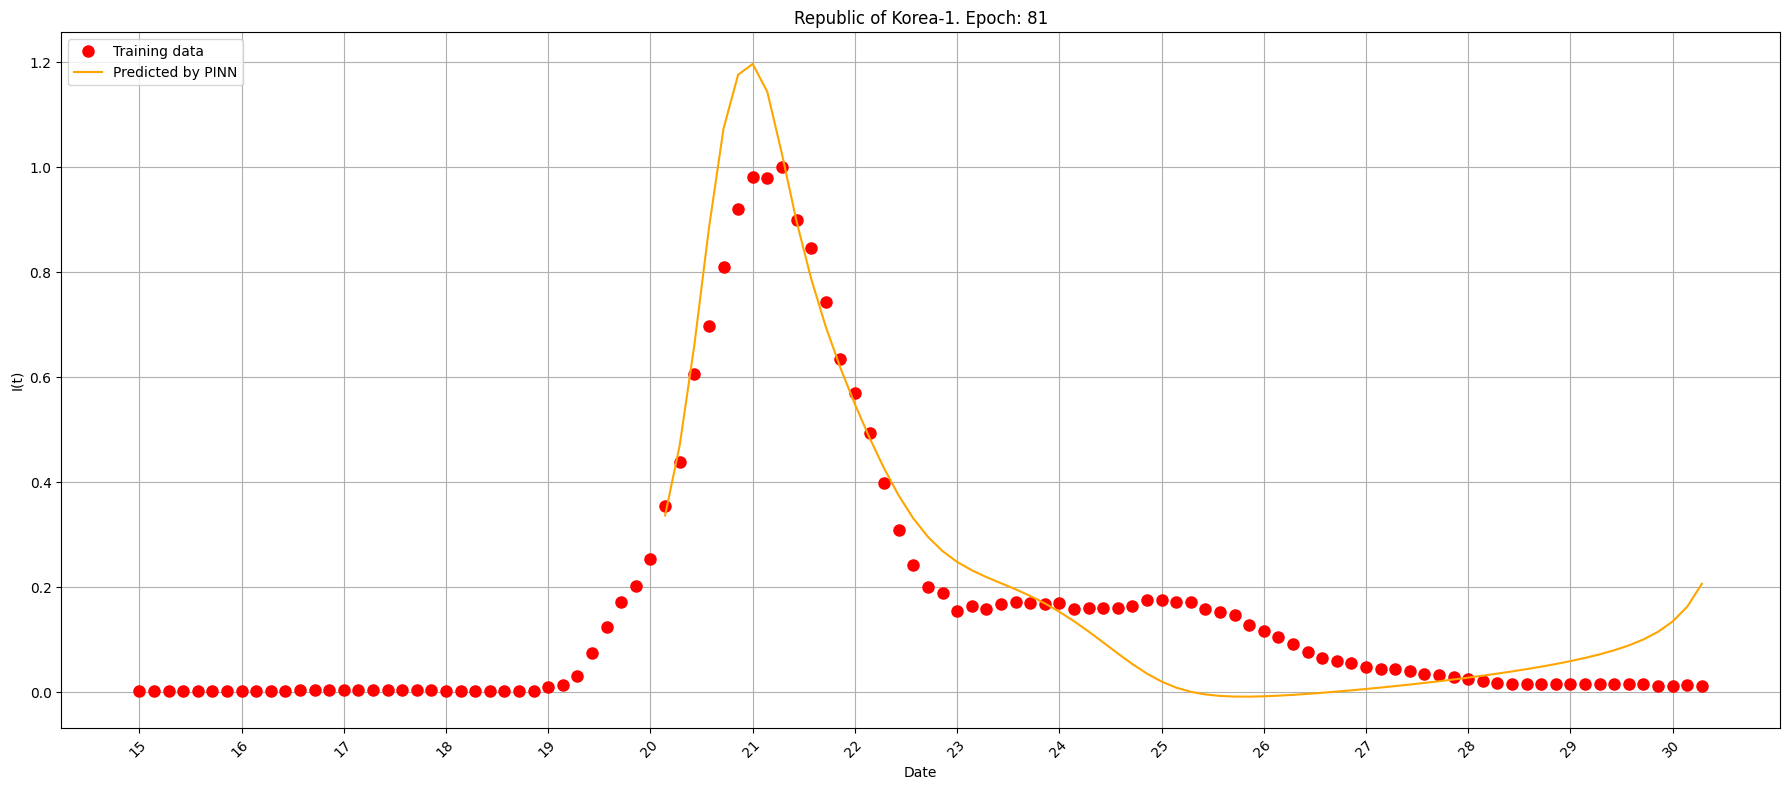

Epoch 81, MSE Loss = 4.5672673877561465e-05, SIR Loss = 5.463728580679117e-09, Average Loss = 0.0005075939768888337


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


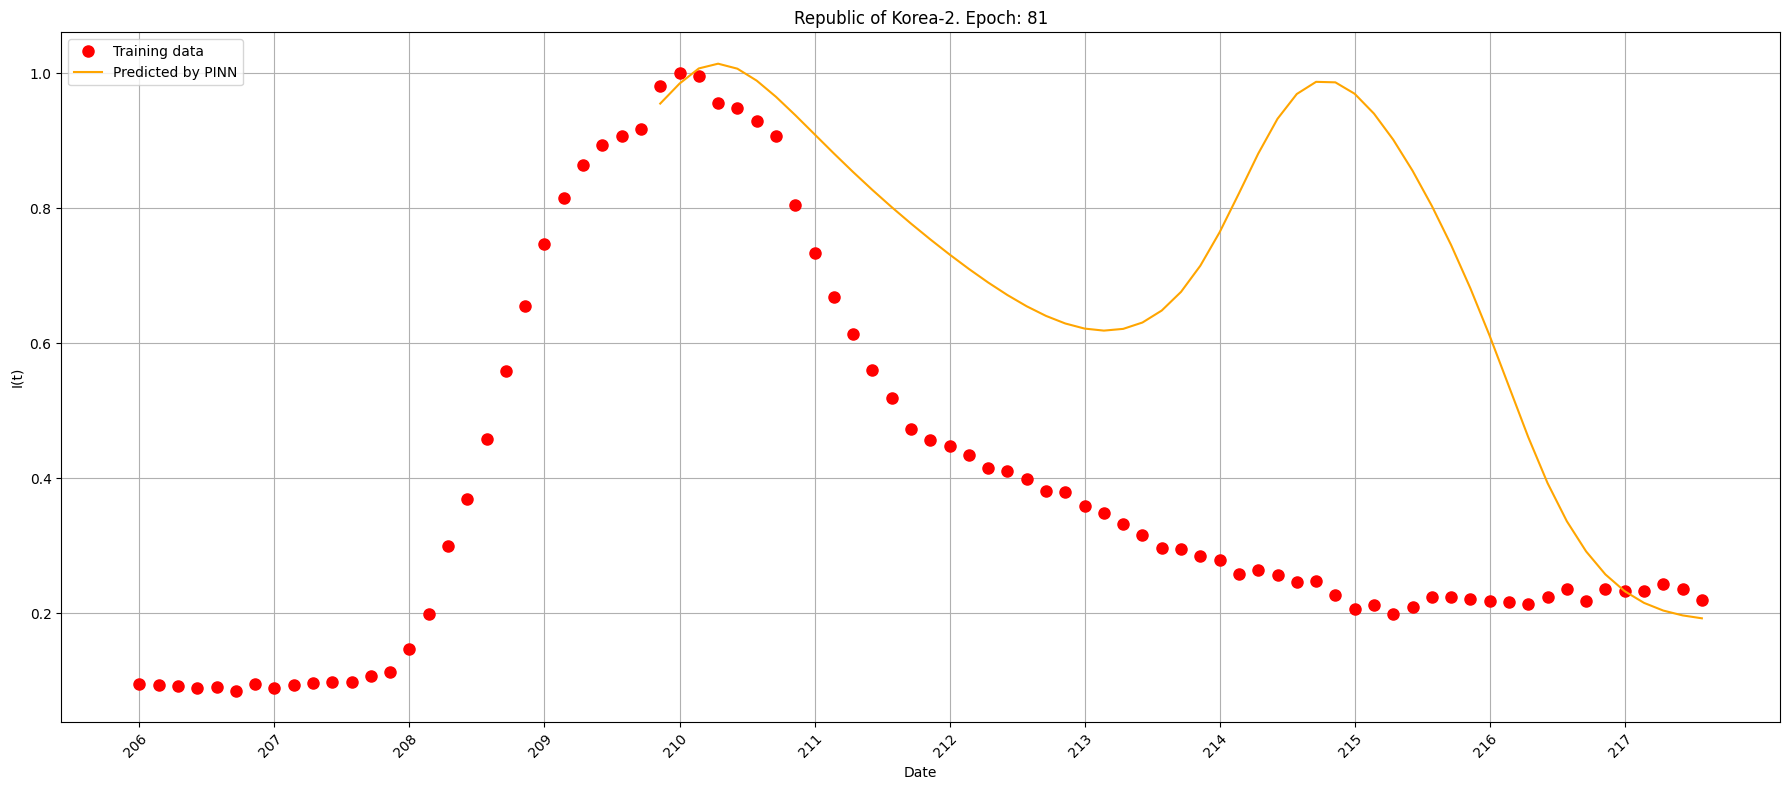

Epoch 81, MSE Loss = 0.0002246867516078055, SIR Loss = 1.5352514398658812e-11, Average Loss = 0.0008682411024225682


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


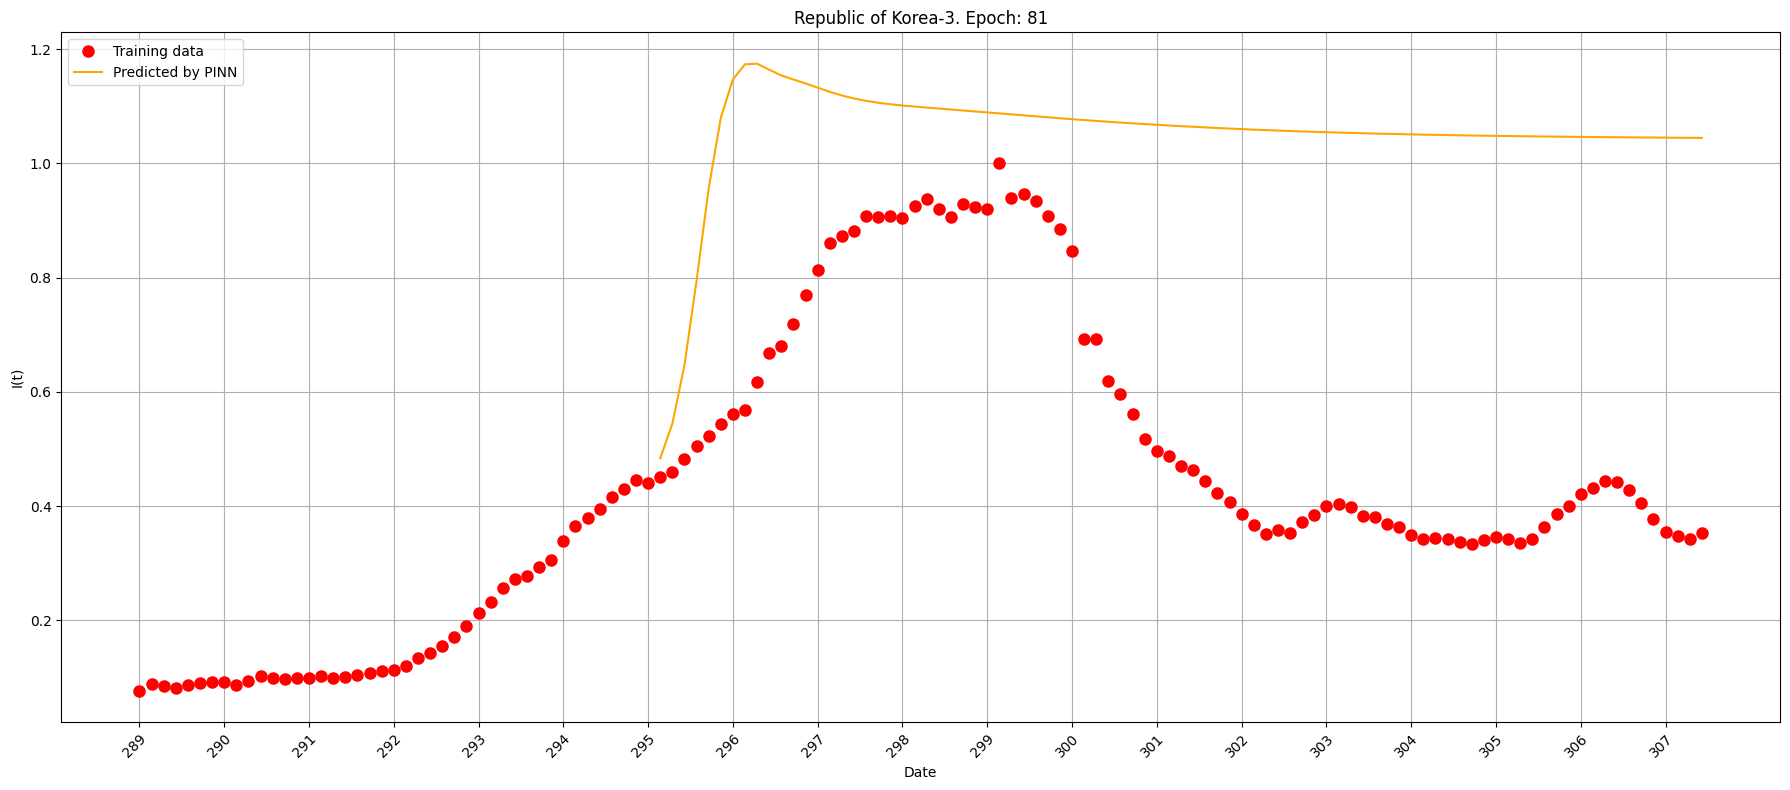

Epoch 81, MSE Loss = 0.0006995682488195598, SIR Loss = 3.4078456202790708e-12, Average Loss = 0.0009196902829232896


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


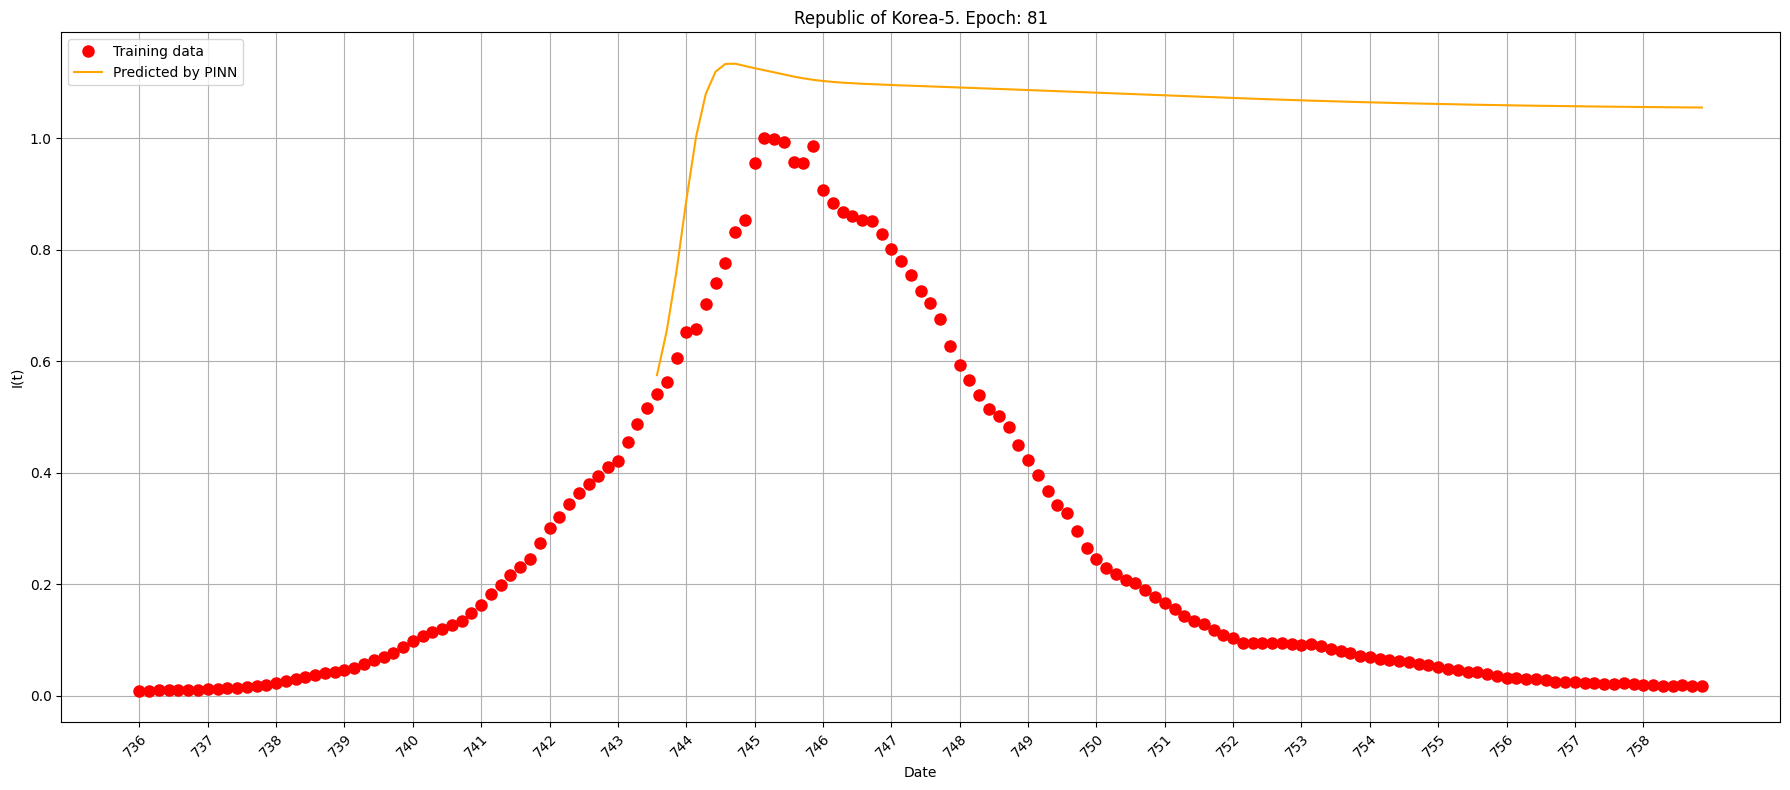

Epoch 81, MSE Loss = 8.114379306789488e-05, SIR Loss = 5.882279255700618e-13, Average Loss = 0.0004832050506279622


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


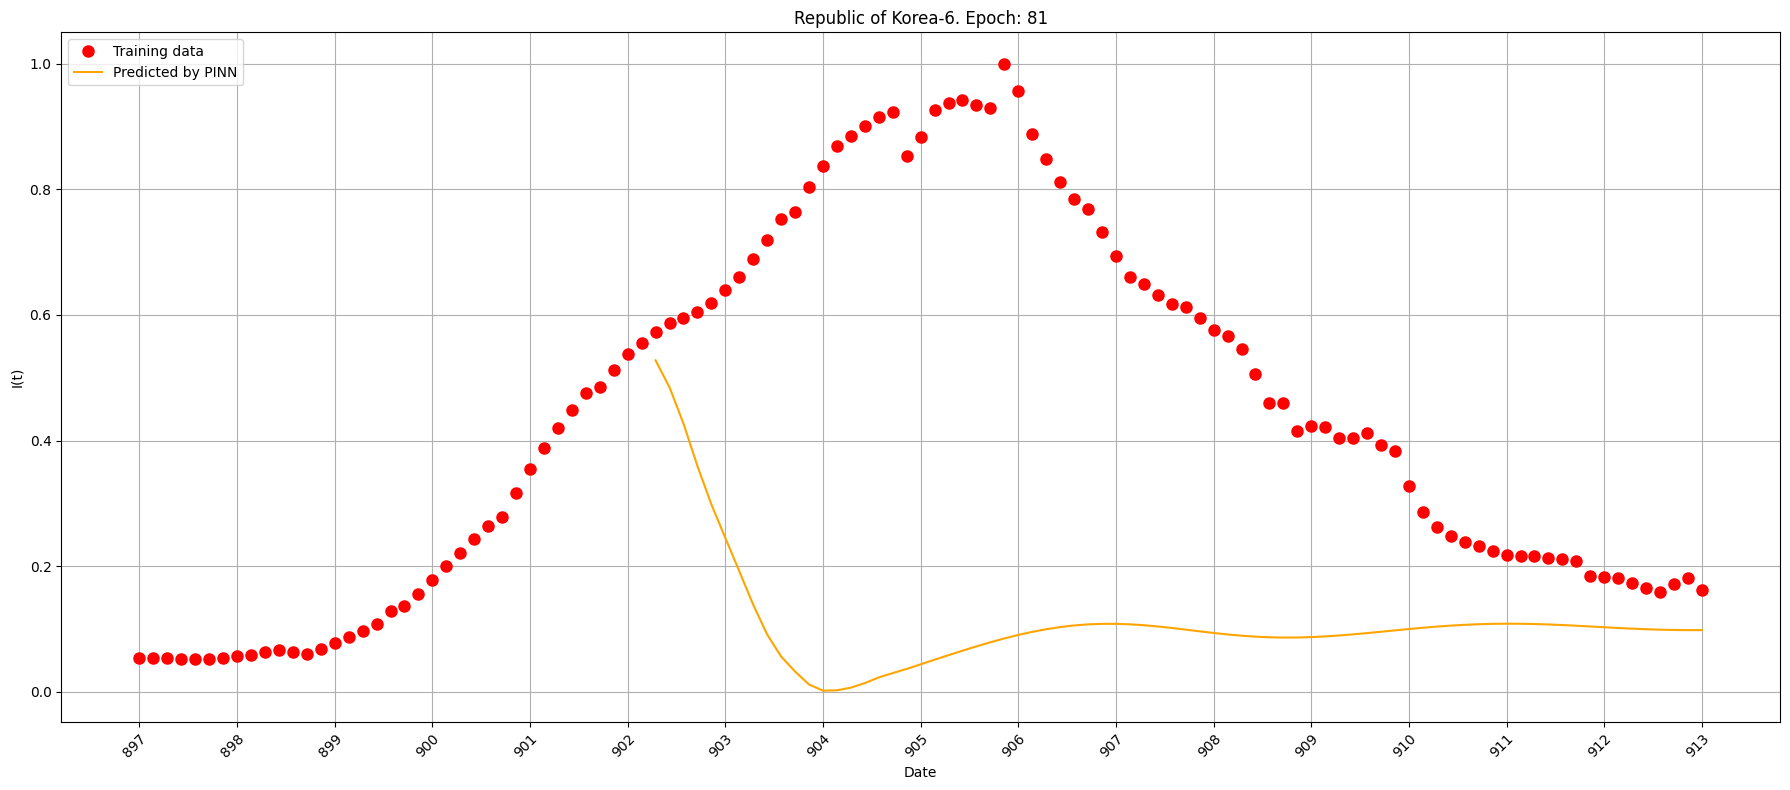

Epoch 81, MSE Loss = 0.000548839452676475, SIR Loss = 1.812280523132842e-13, Average Loss = 0.0006592633461228318


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


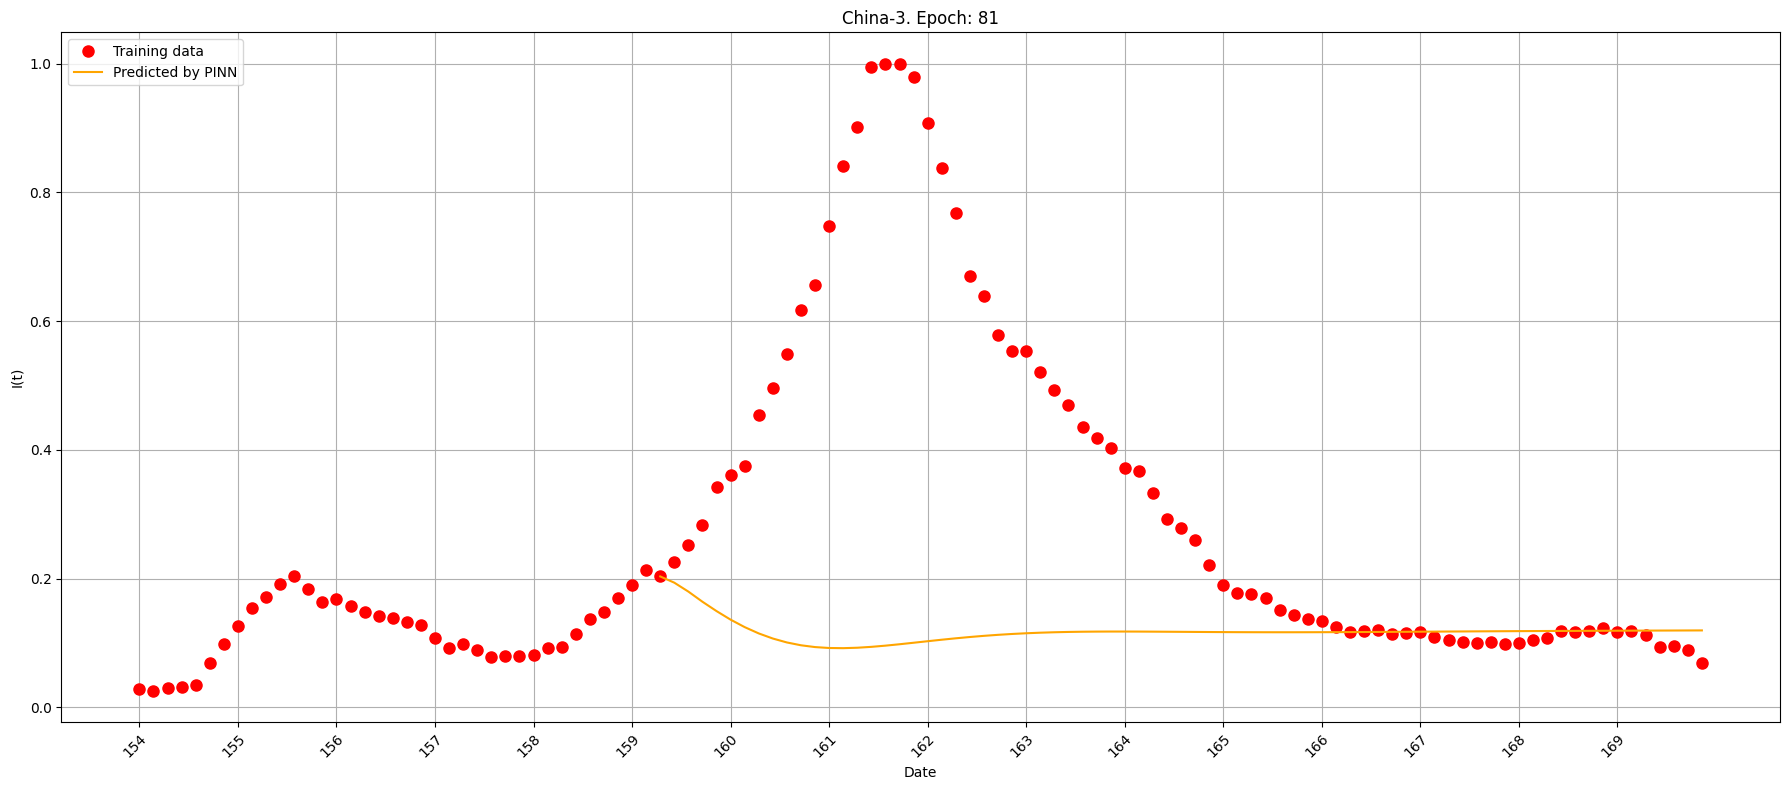

Epoch 81, MSE Loss = 0.0005963706644251943, SIR Loss = 1.976956820470832e-09, Average Loss = 0.0008069479139160695


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


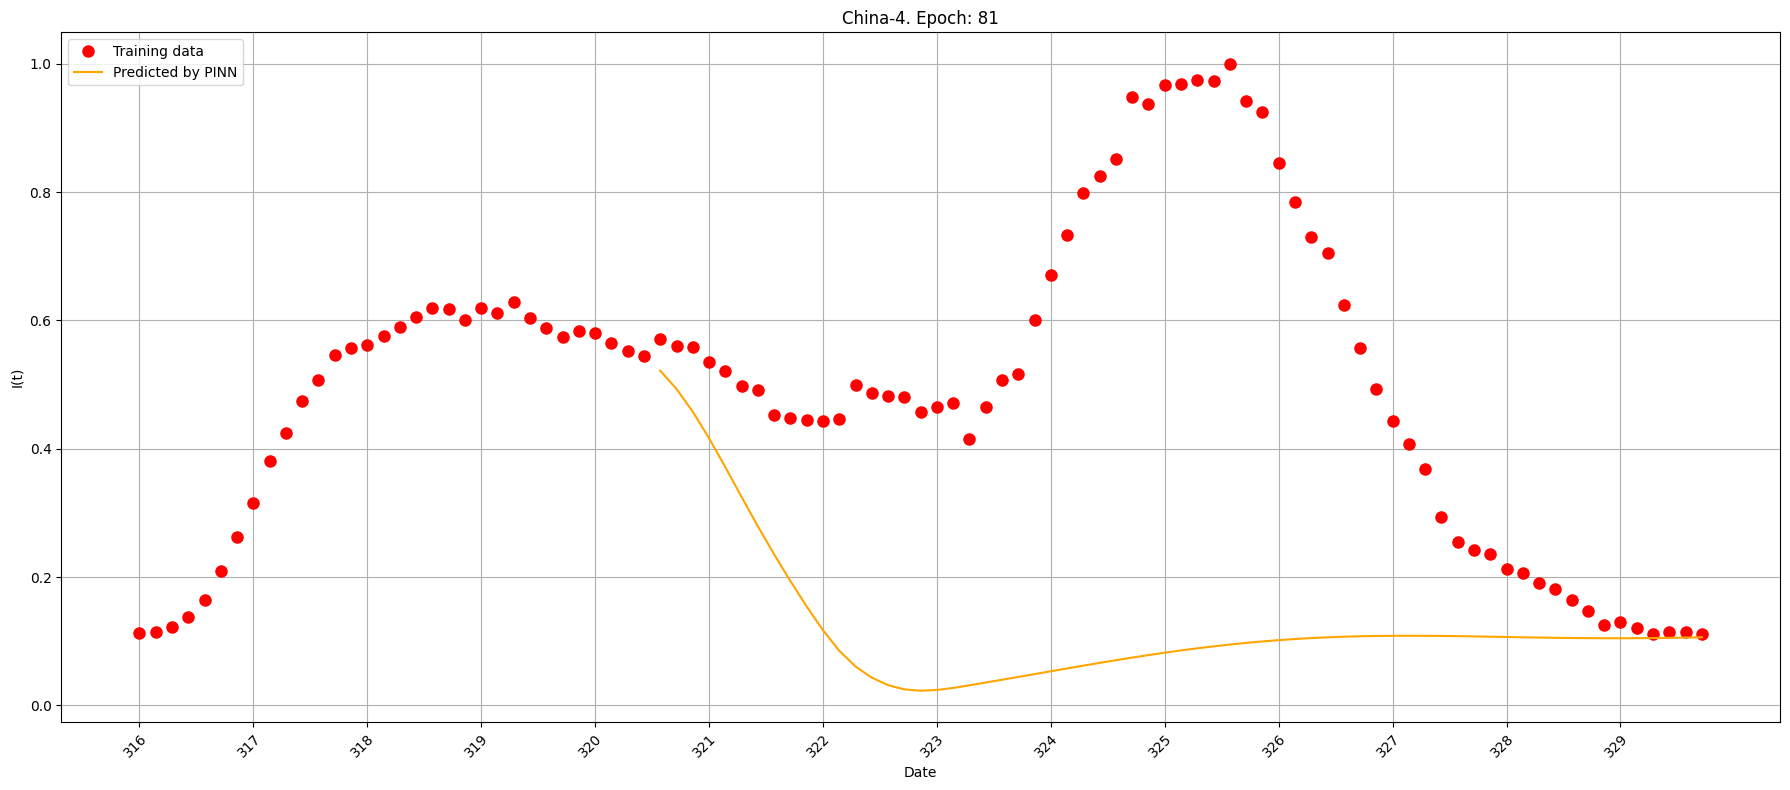

Epoch 81, MSE Loss = 3.900060983141884e-05, SIR Loss = 1.5935616715090362e-10, Average Loss = 0.0019469424184473086


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


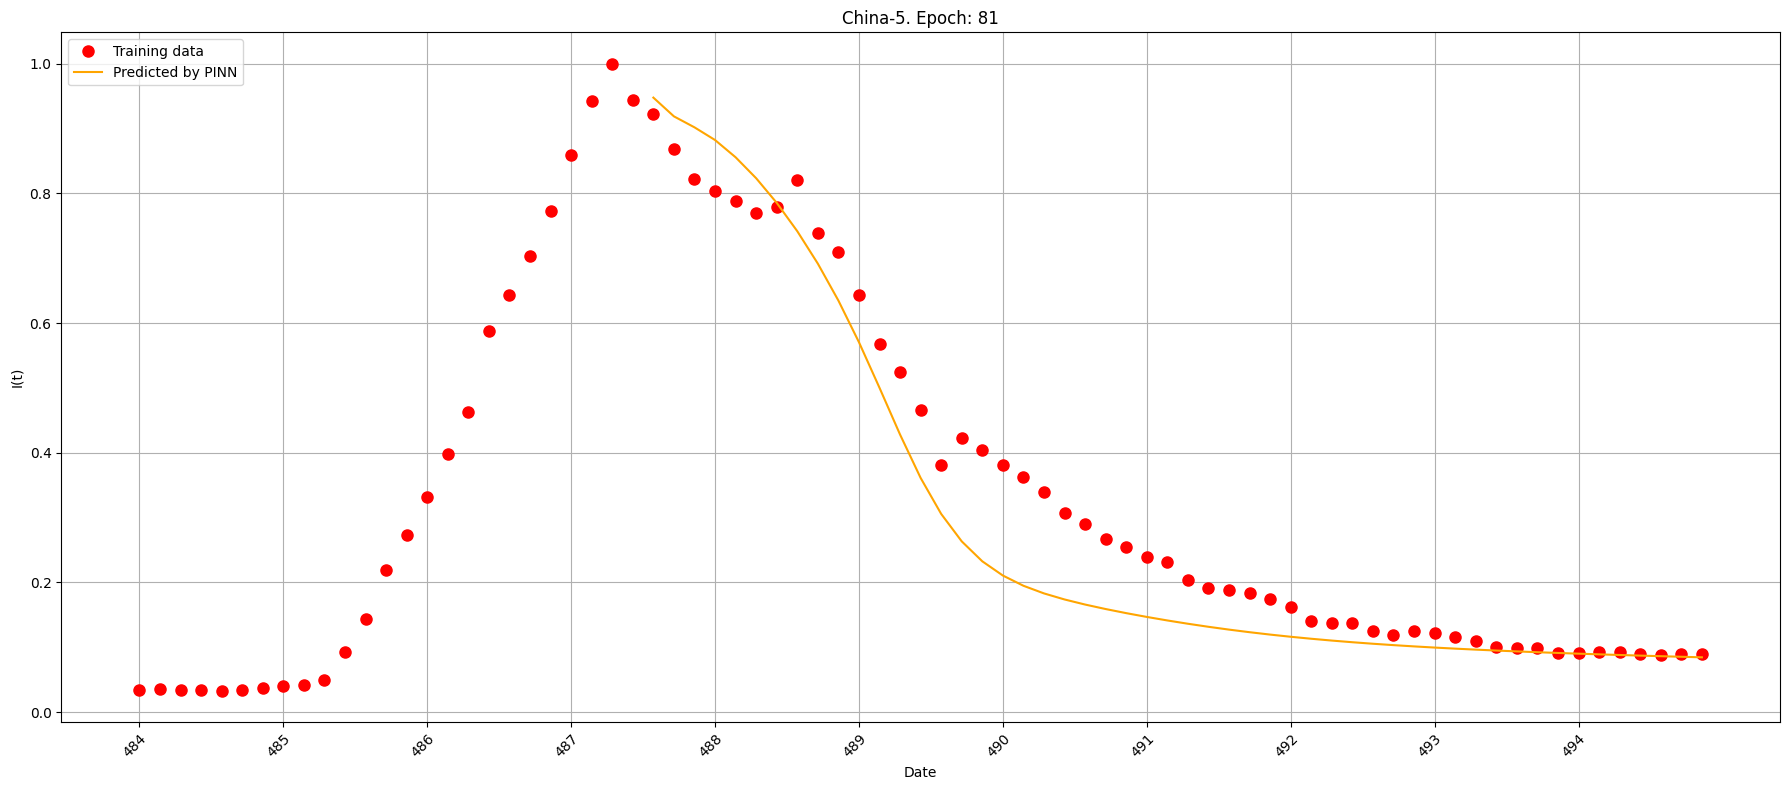

Epoch 81, MSE Loss = 0.00011790990538429469, SIR Loss = 1.5780314338229018e-12, Average Loss = 0.0011545078079145859


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


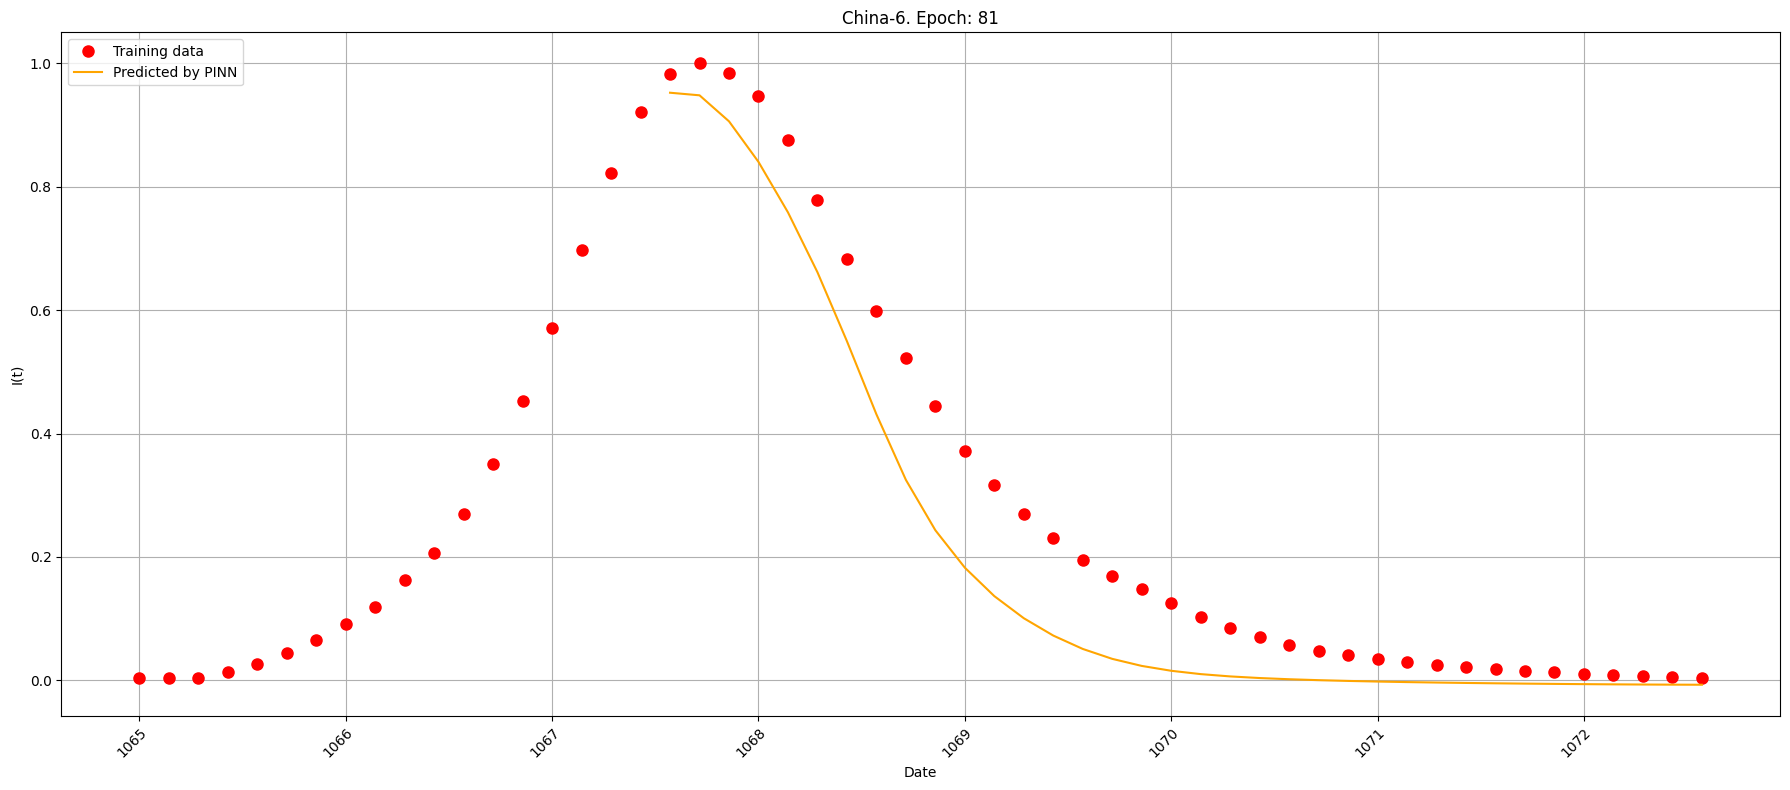

Epoch 81, MSE Loss = 0.00024008037871681154, SIR Loss = 1.1974549244563775e-15, Average Loss = 0.00037407090502725583


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Epoch 91, MSE Loss = 5.0341664064035285e-06, SIR Loss = 9.907176190537825e-10, Average Loss = 0.0005977368706432032
Epoch 91, MSE Loss = 2.739931187534239e-05, SIR Loss = 2.177861162895242e-13, Average Loss = 0.0010324715986837893
Epoch 91, MSE Loss = 0.0010367752984166145, SIR Loss = 9.229125981242287e-14, Average Loss = 0.0011546629606508448
Epoch 91, MSE Loss = 2.0041927200509235e-05, SIR Loss = 4.722016506107651e-13, Average Loss = 0.00043607596567629404
Epoch 91, MSE Loss = 0.0002524481387808919, SIR Loss = 1.0840535182032613e-14, Average Loss = 0.0006724713392616098
Epoch 91, MSE Loss = 0.0005090299528092146, SIR Loss = 1.8355501146816167e-11, Average Loss = 0.0008499849240370357
Epoch 91, MSE Loss = 1.496798540756572e-05, SIR Loss = 2.8297207784432066e-13, Average Loss = 0.002572814405109764
Epoch 91, MSE Loss = 2.0739534534186532e-08, SIR Loss = 7.662045910933335e-13, Average Loss = 0.0013622005395102325
Epoch 91, MSE Loss = 8.141878788592294e-05, SIR Loss = 1.181594550156396e-

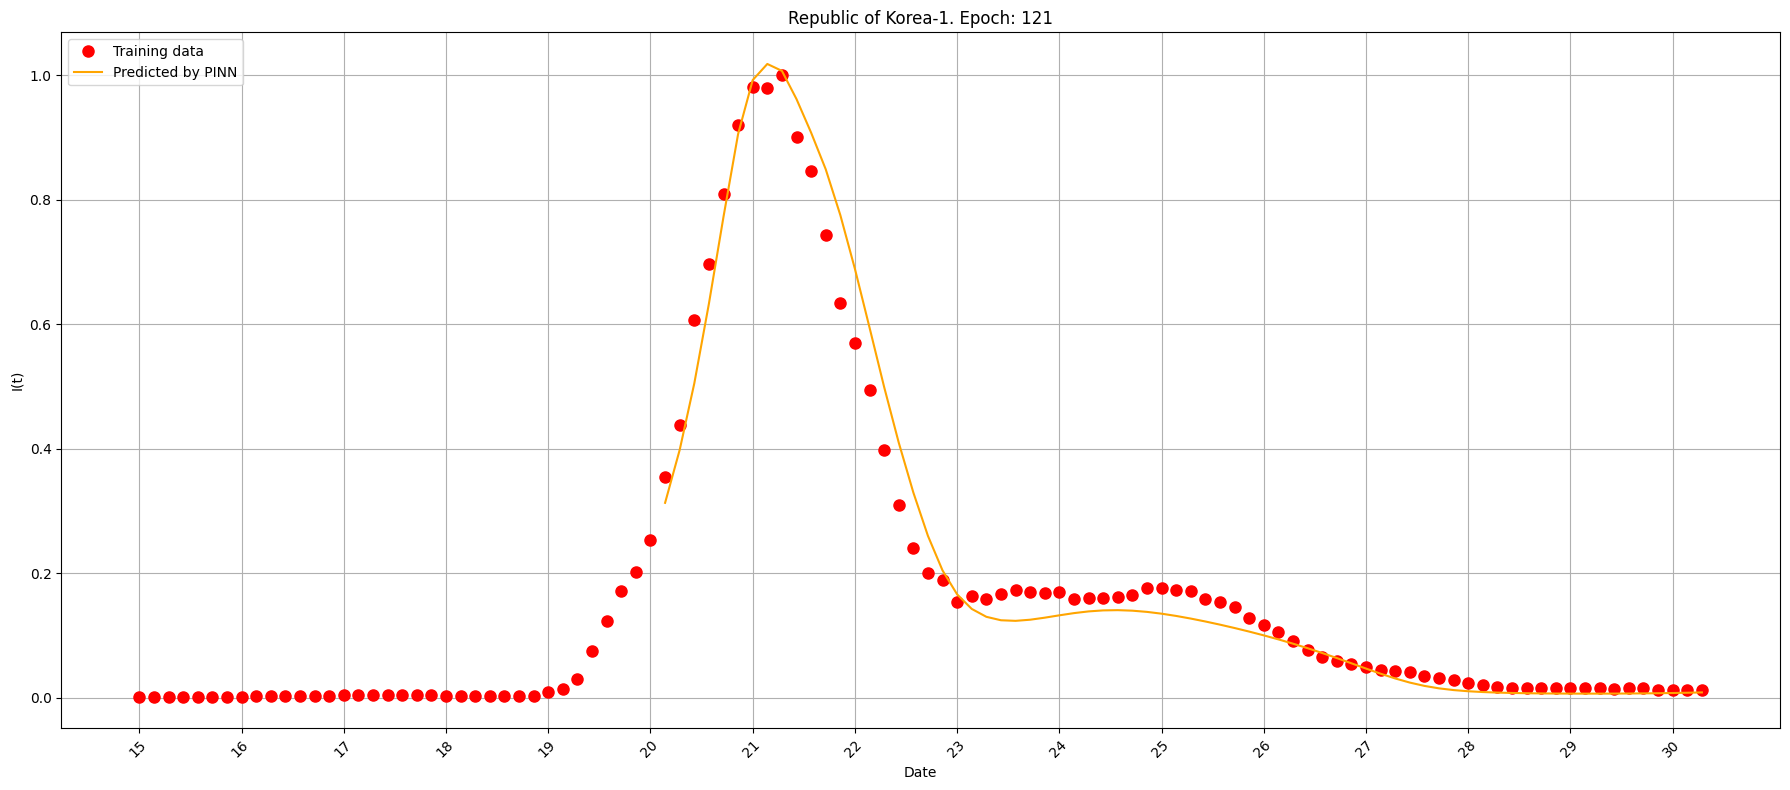

Epoch 121, MSE Loss = 1.775157215888612e-05, SIR Loss = 1.0140457362695088e-09, Average Loss = 0.0003435984937724025


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


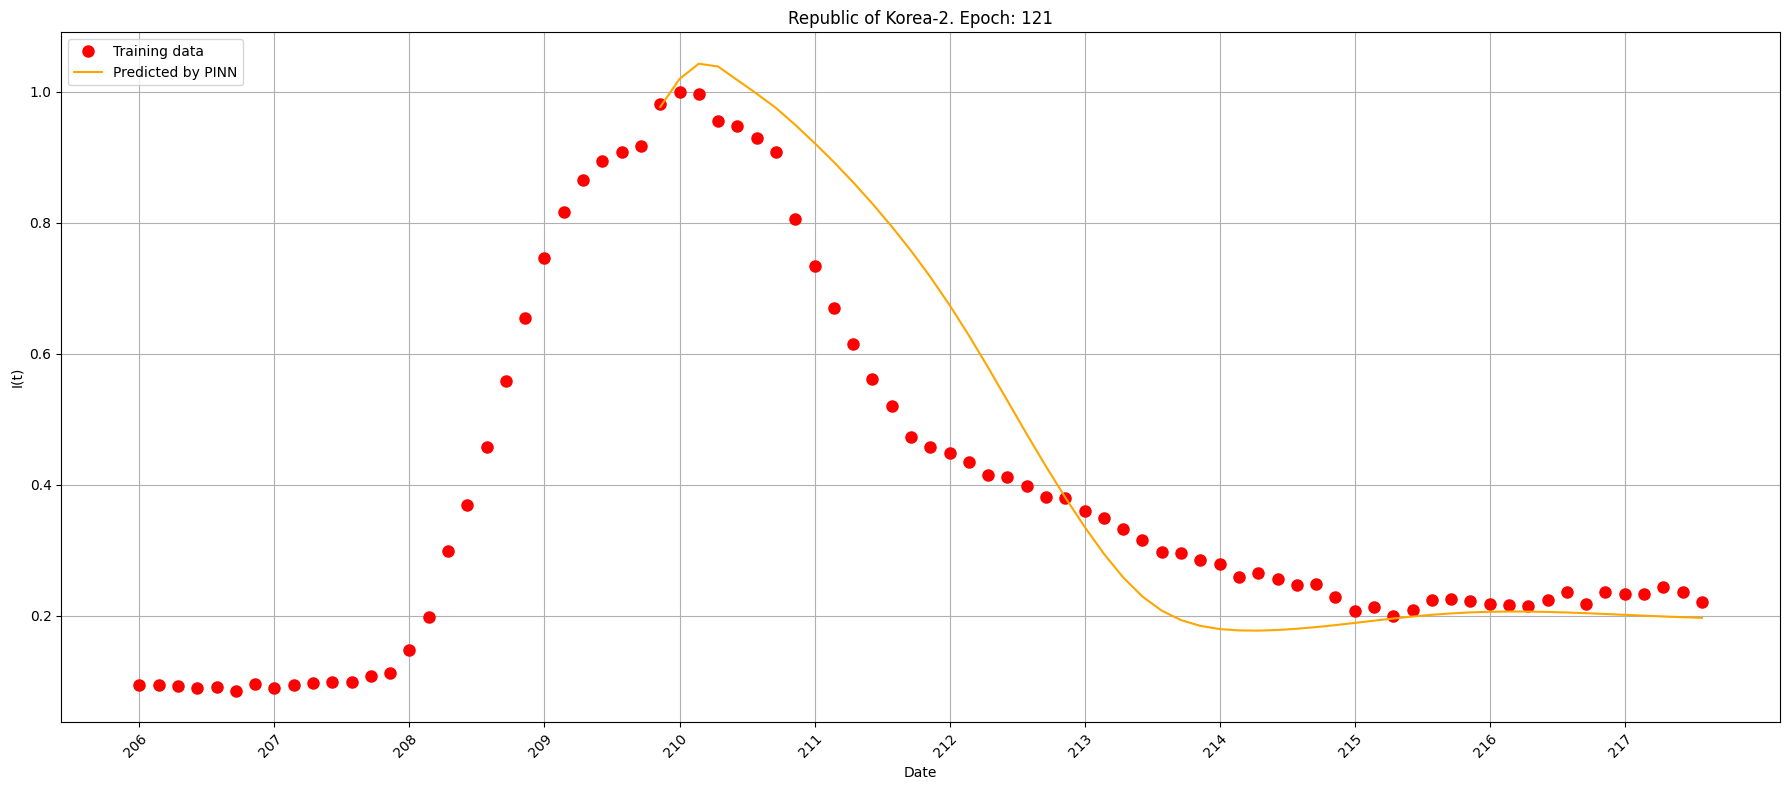

Epoch 121, MSE Loss = 1.3175258573028259e-05, SIR Loss = 6.759926386018522e-12, Average Loss = 0.0006348867041199731


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


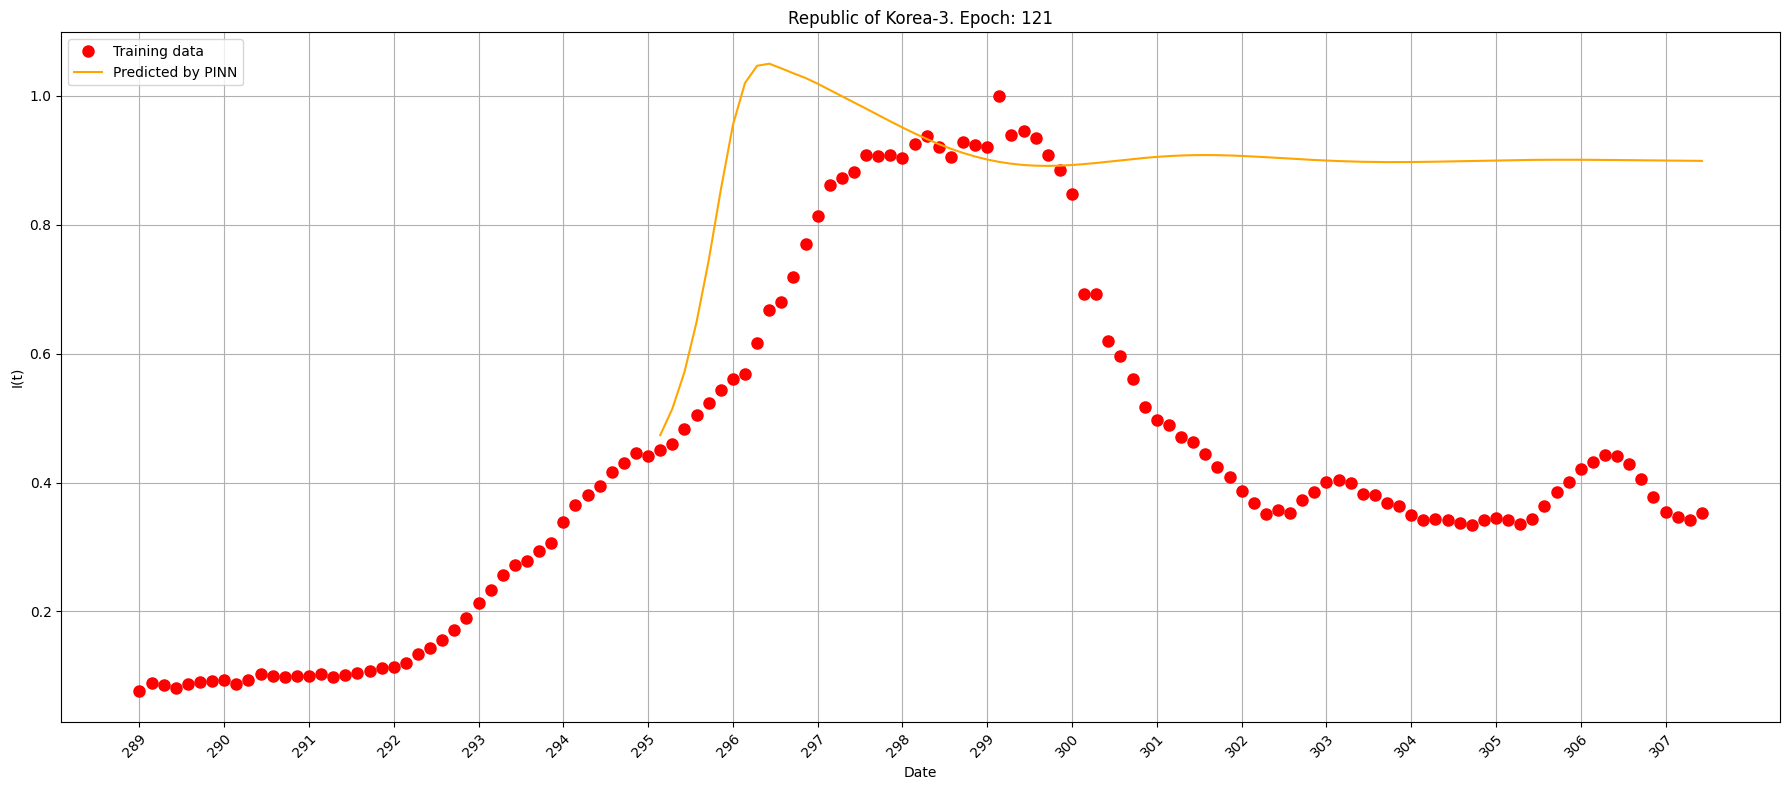

Epoch 121, MSE Loss = 0.0006105339853093028, SIR Loss = 6.399643185175941e-13, Average Loss = 0.0009333373330362302


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


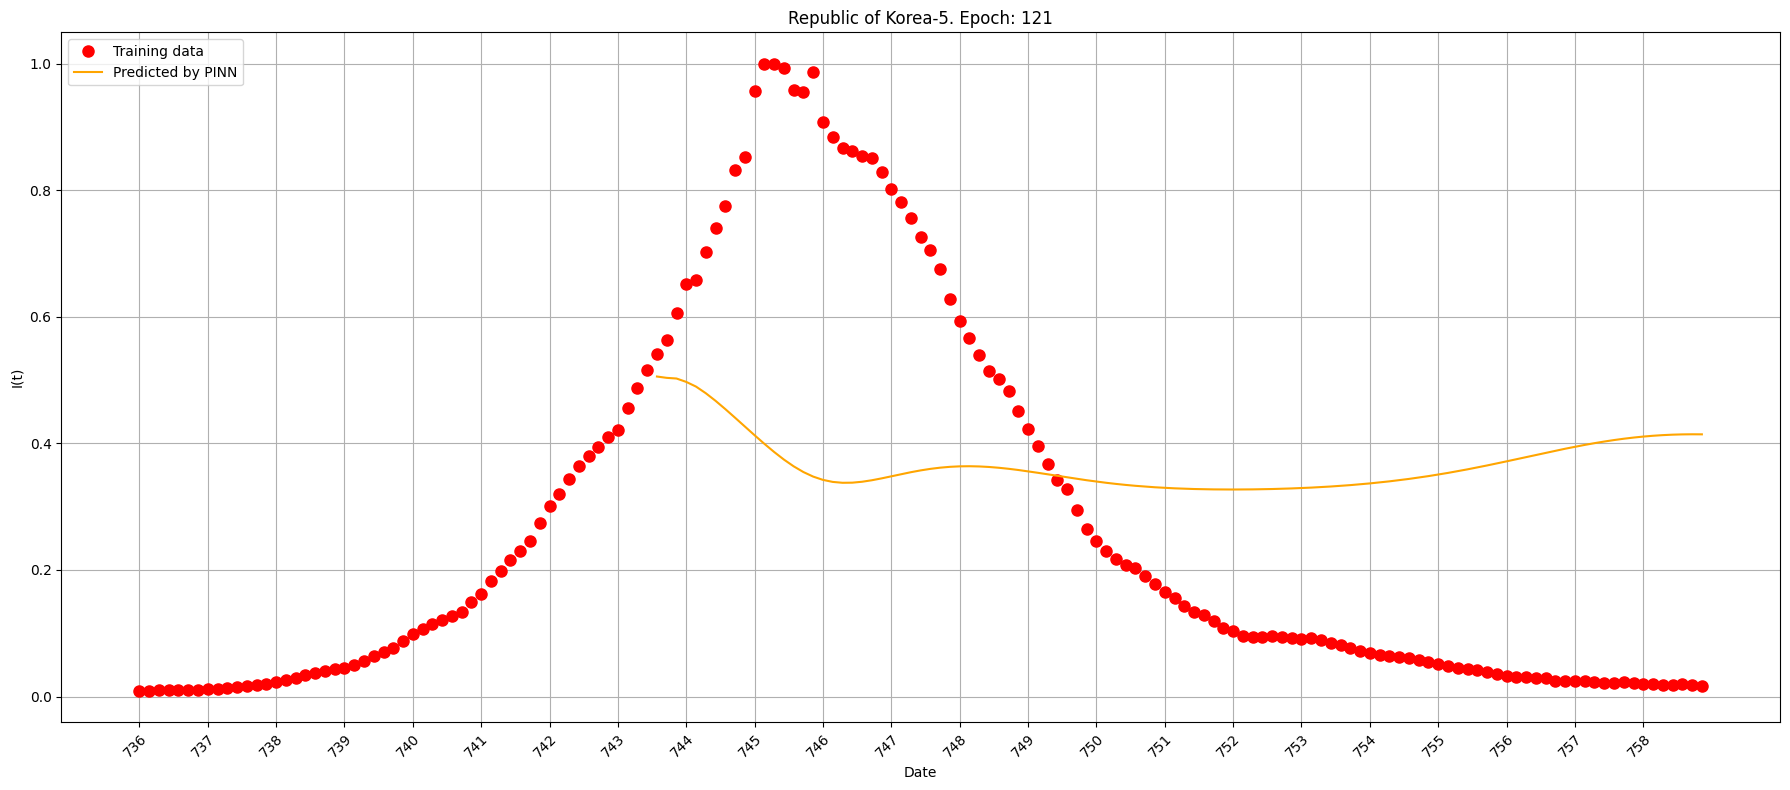

Epoch 121, MSE Loss = 2.215405402239412e-05, SIR Loss = 2.508628341949676e-13, Average Loss = 0.00021404346818052391


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


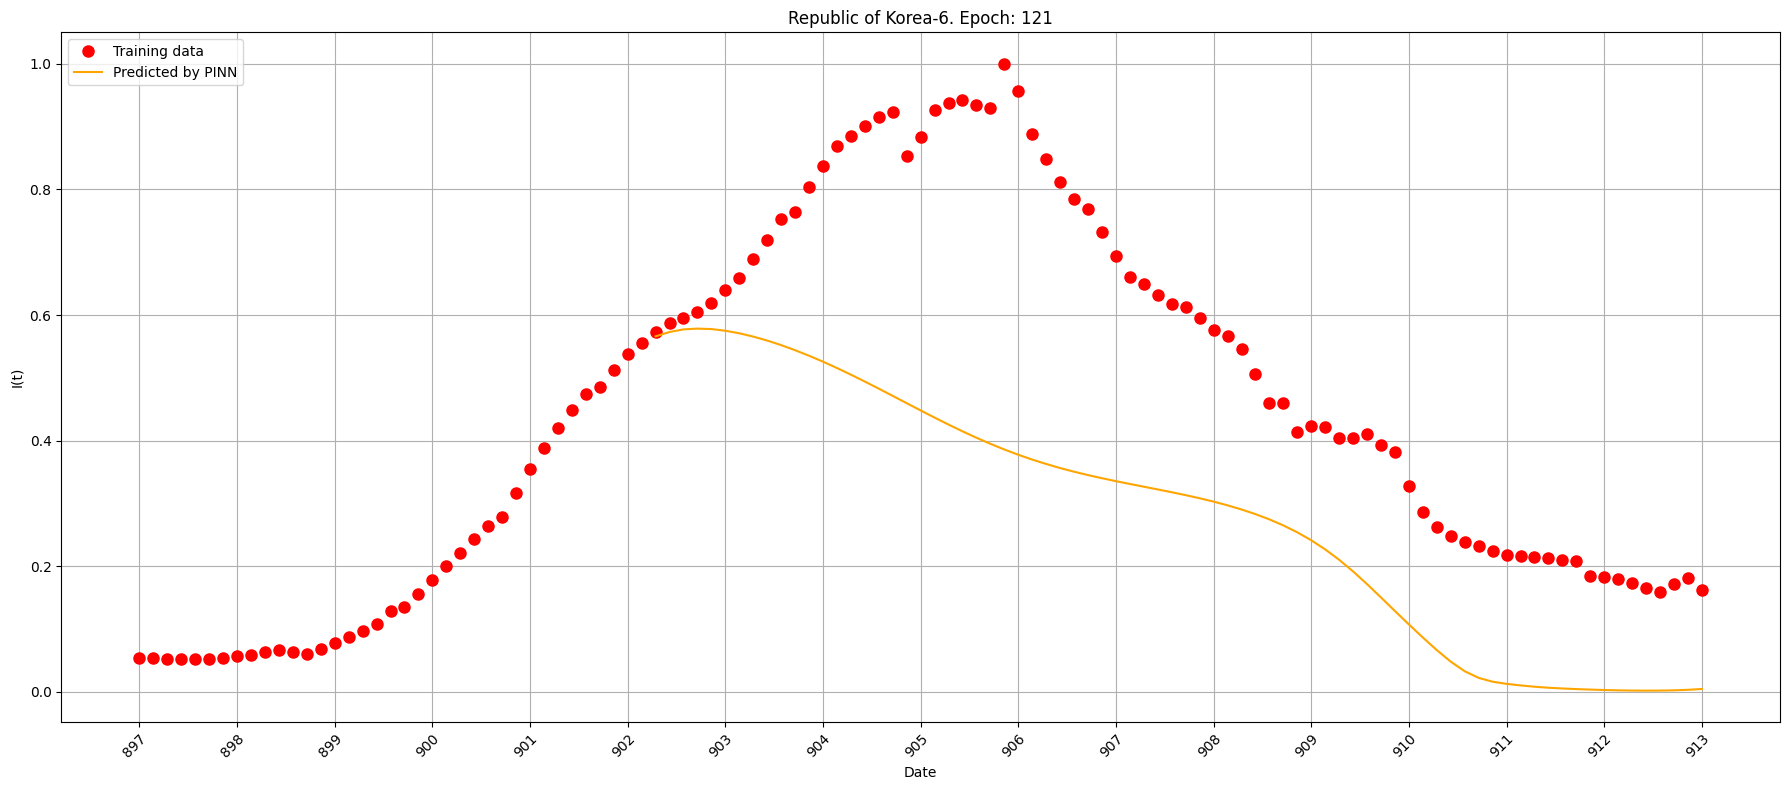

Epoch 121, MSE Loss = 5.9129415603820235e-05, SIR Loss = 0.0, Average Loss = 0.00043377472406185236


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


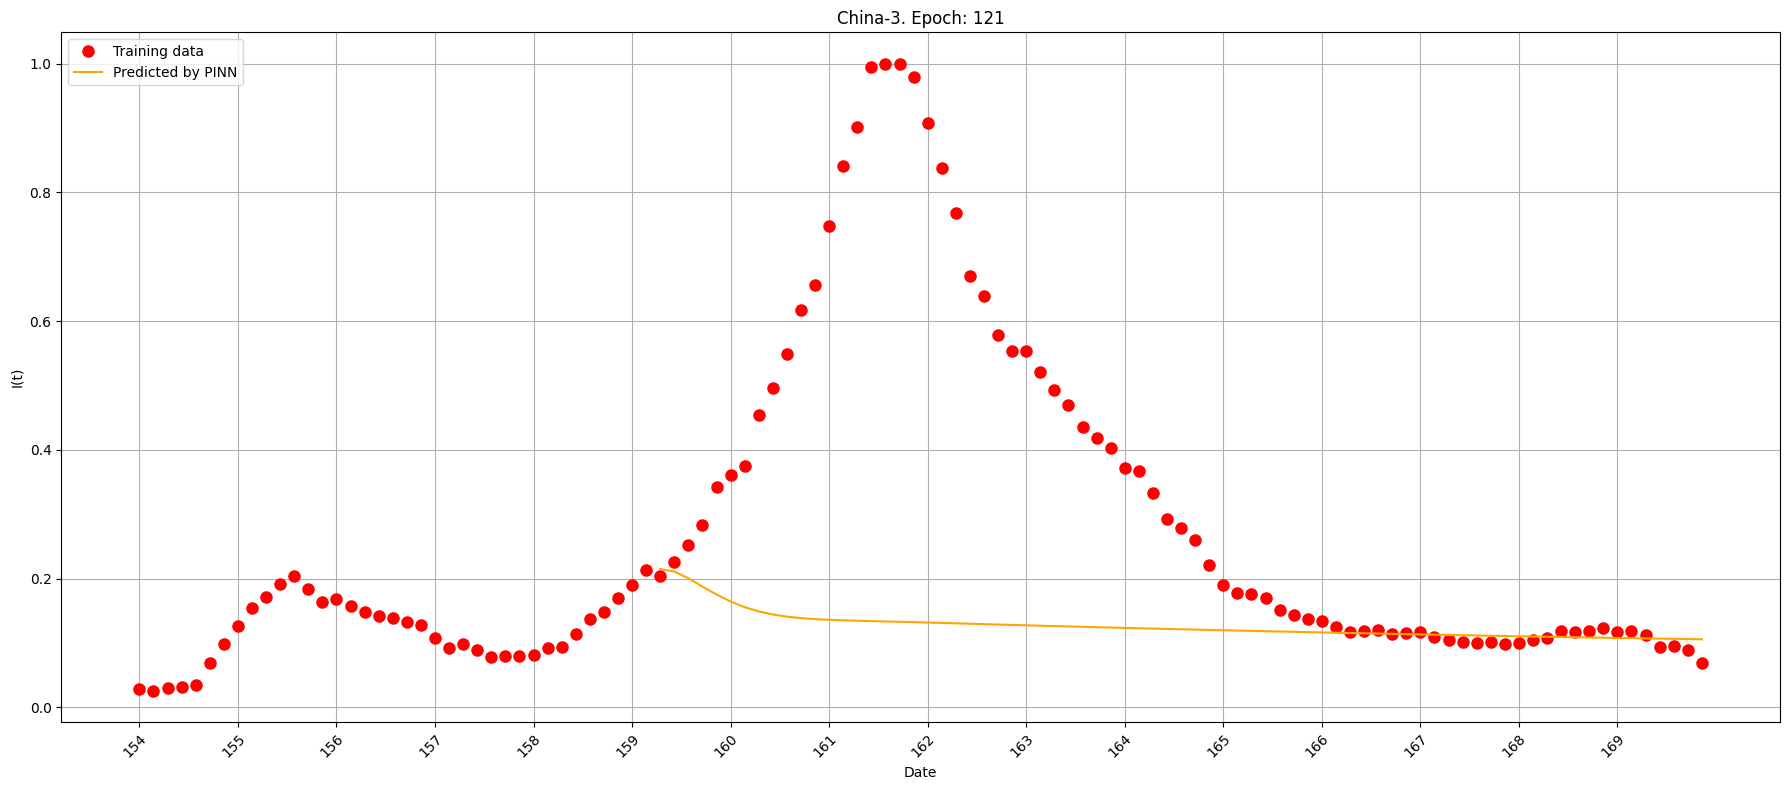

Epoch 121, MSE Loss = 0.0005957161774858832, SIR Loss = 4.425499897098284e-12, Average Loss = 0.000633928647351159


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


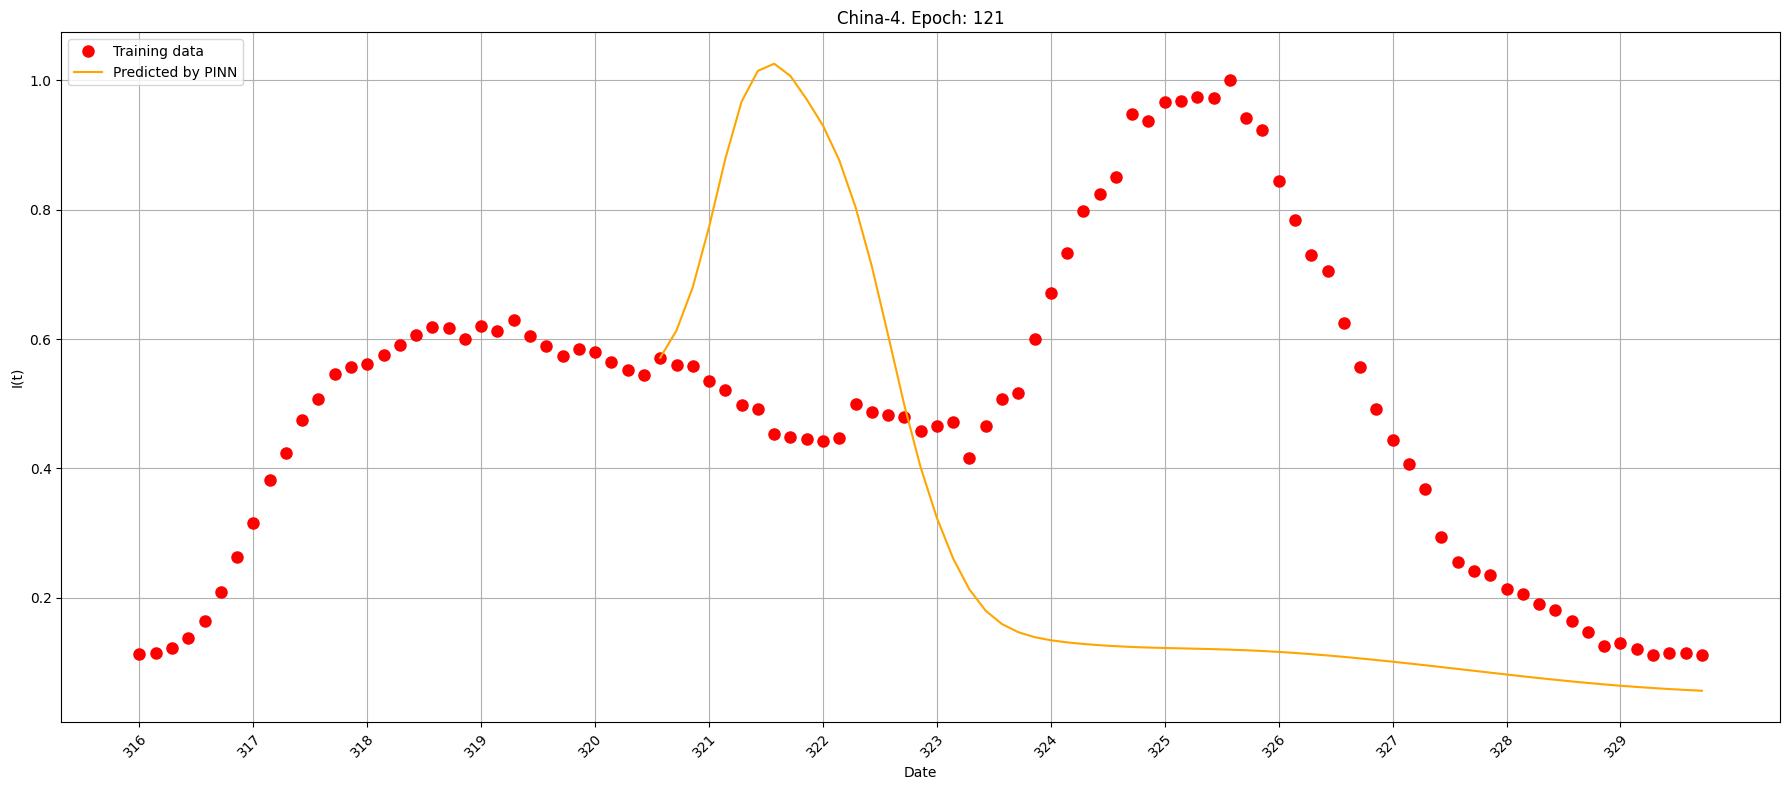

Epoch 121, MSE Loss = 8.665513632877264e-06, SIR Loss = 4.668488157361962e-14, Average Loss = 0.000801133007020501


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


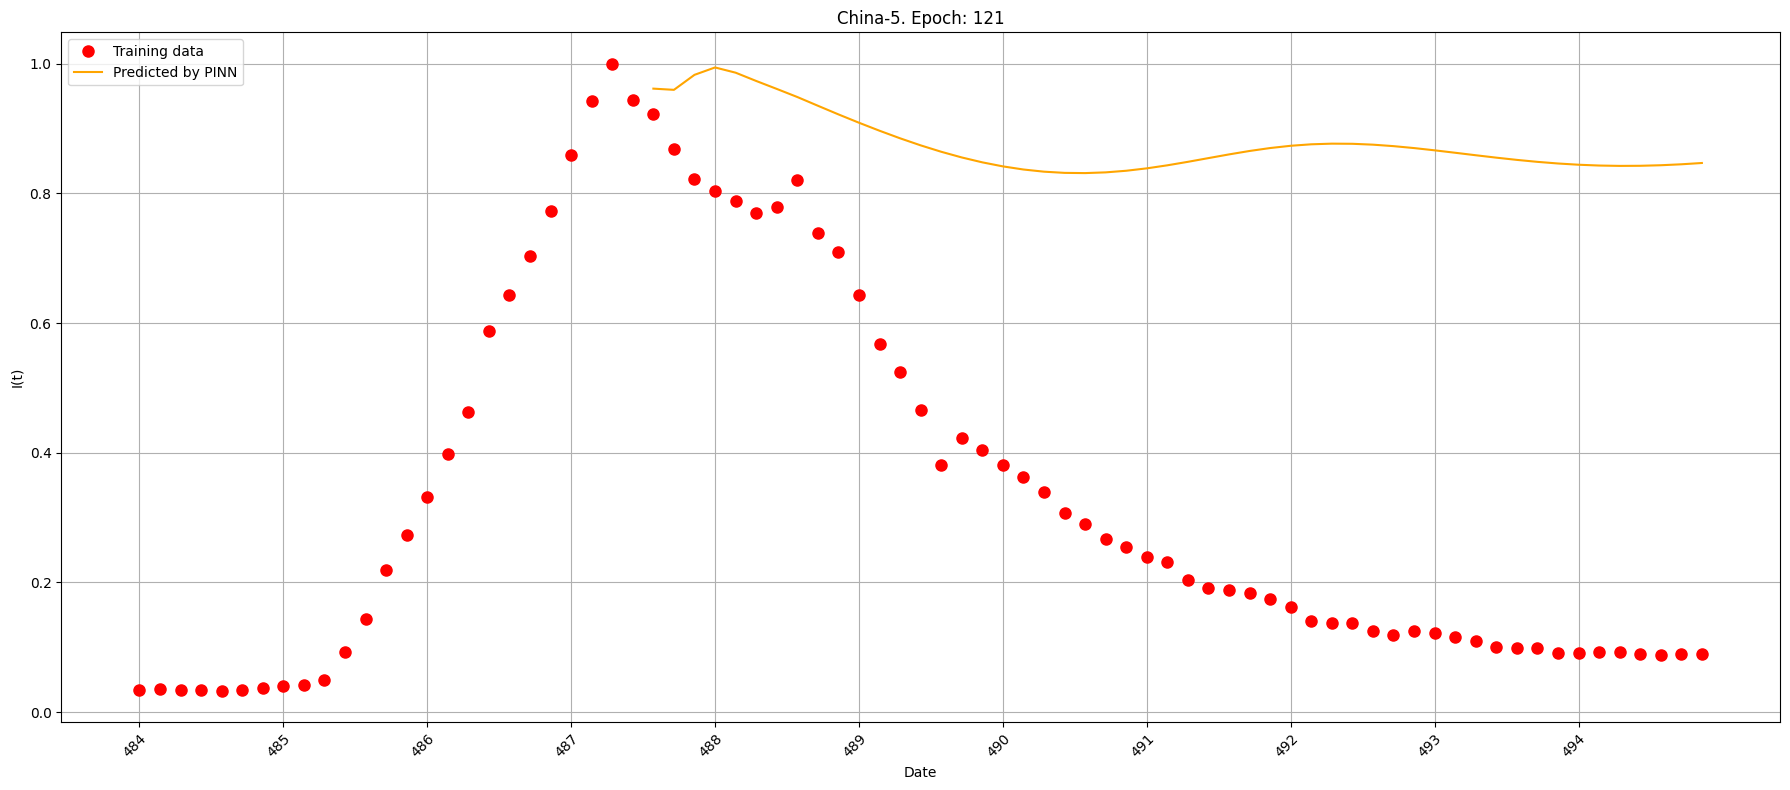

Epoch 121, MSE Loss = 3.843447515805565e-08, SIR Loss = 3.058260025431969e-12, Average Loss = 0.0009167450594570628


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


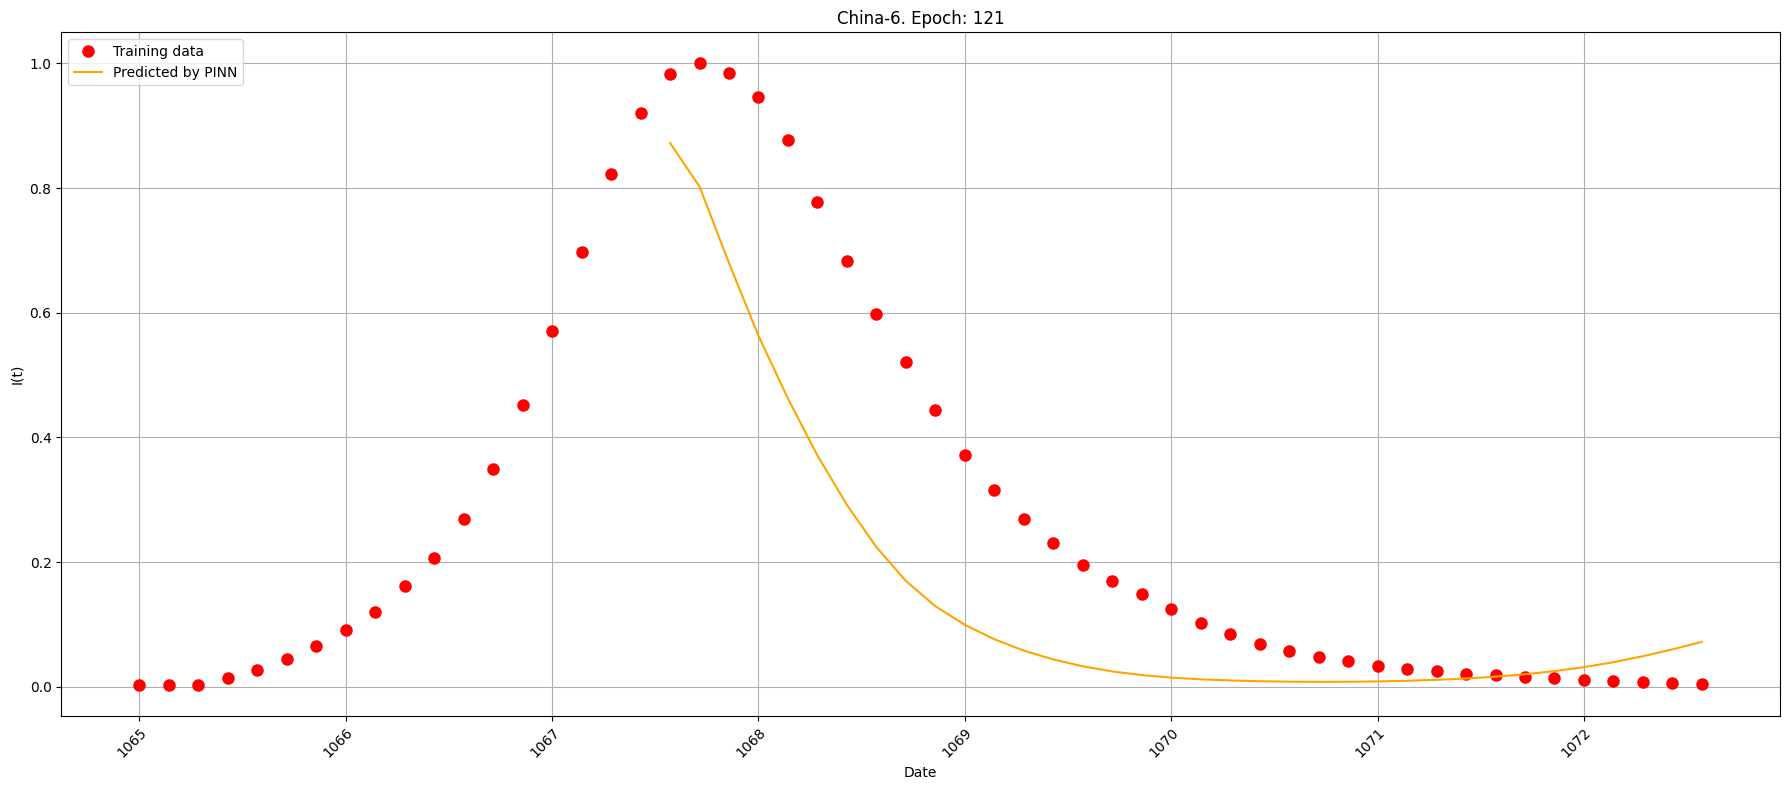

Epoch 121, MSE Loss = 8.130044193421782e-08, SIR Loss = 1.2918238391978684e-14, Average Loss = 0.0007187723163834572


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Epoch 131, MSE Loss = 2.5484750949544832e-05, SIR Loss = 7.1384618216541185e-09, Average Loss = 0.0003268321132494667
Epoch 131, MSE Loss = 0.0007310966029763222, SIR Loss = 1.0157113865261191e-11, Average Loss = 0.000631734135372785
Epoch 131, MSE Loss = 0.0009744588169269264, SIR Loss = 7.09194665883886e-14, Average Loss = 0.0010538516793645771
Epoch 131, MSE Loss = 4.698906650446588e-06, SIR Loss = 0.0, Average Loss = 0.00033368062367732115
Epoch 131, MSE Loss = 0.00016349935322068632, SIR Loss = 0.0, Average Loss = 0.0005511682643091753
Epoch 131, MSE Loss = 0.00023789673286955804, SIR Loss = 9.063379213802847e-11, Average Loss = 0.0007886699701492446
Epoch 131, MSE Loss = 6.355780351441354e-05, SIR Loss = 1.1956055936956922e-11, Average Loss = 0.0010653705275226048
Epoch 131, MSE Loss = 3.375263622729108e-05, SIR Loss = 3.751919564962125e-13, Average Loss = 0.0008260590810912
Epoch 131, MSE Loss = 1.4248502338887192e-05, SIR Loss = 3.347639819430842e-13, Average Loss = 0.000413080

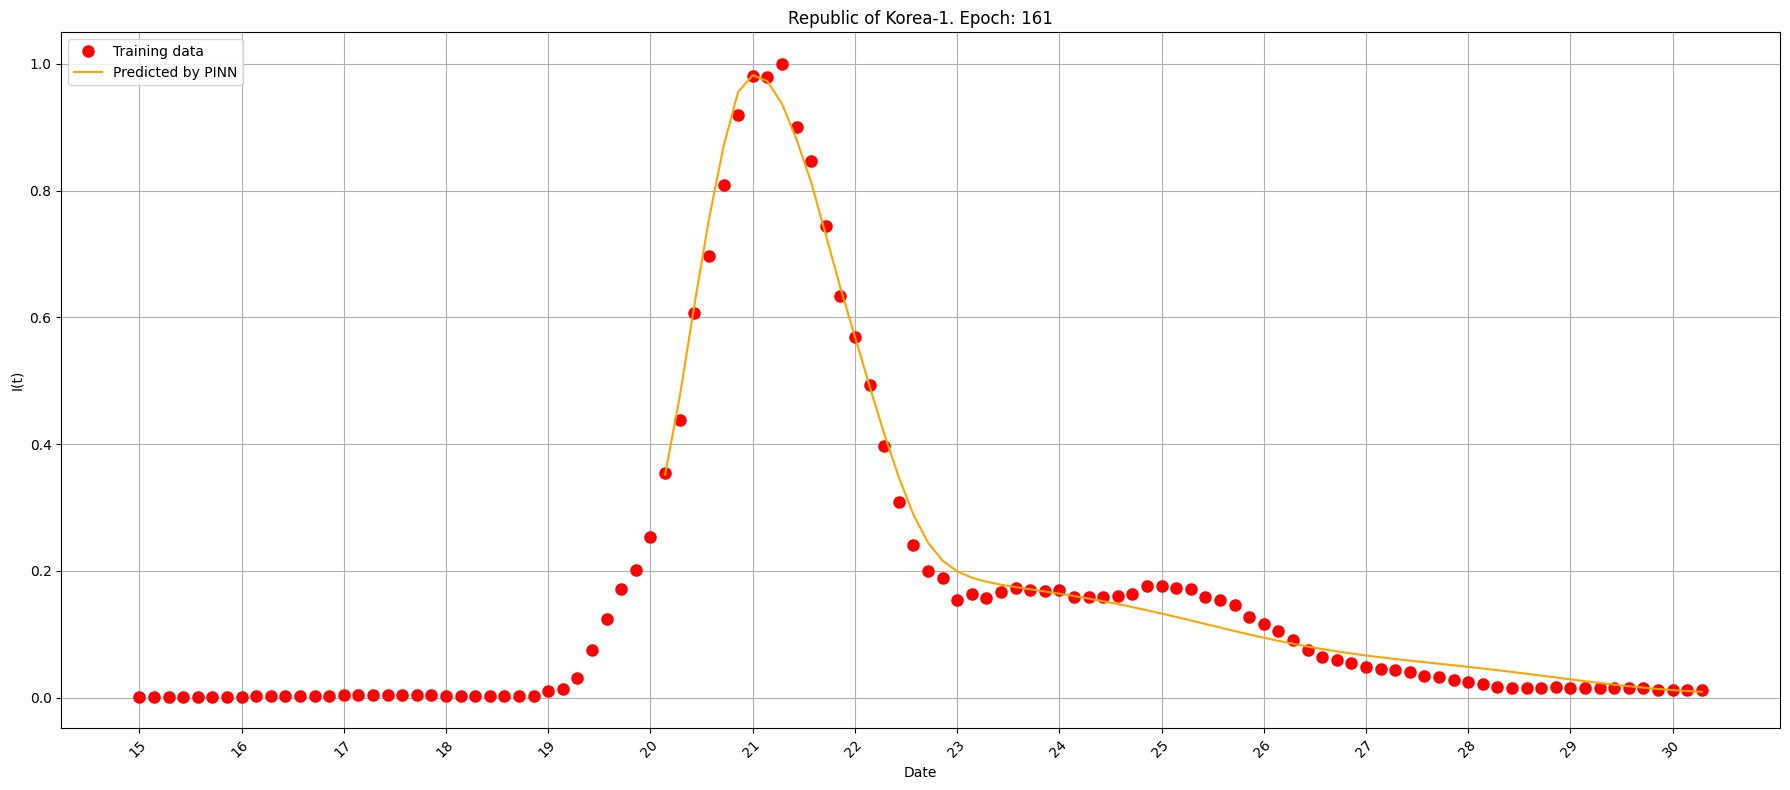

Epoch 161, MSE Loss = 3.472101525403559e-06, SIR Loss = 4.646874274261137e-10, Average Loss = 0.0002153683983602877


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


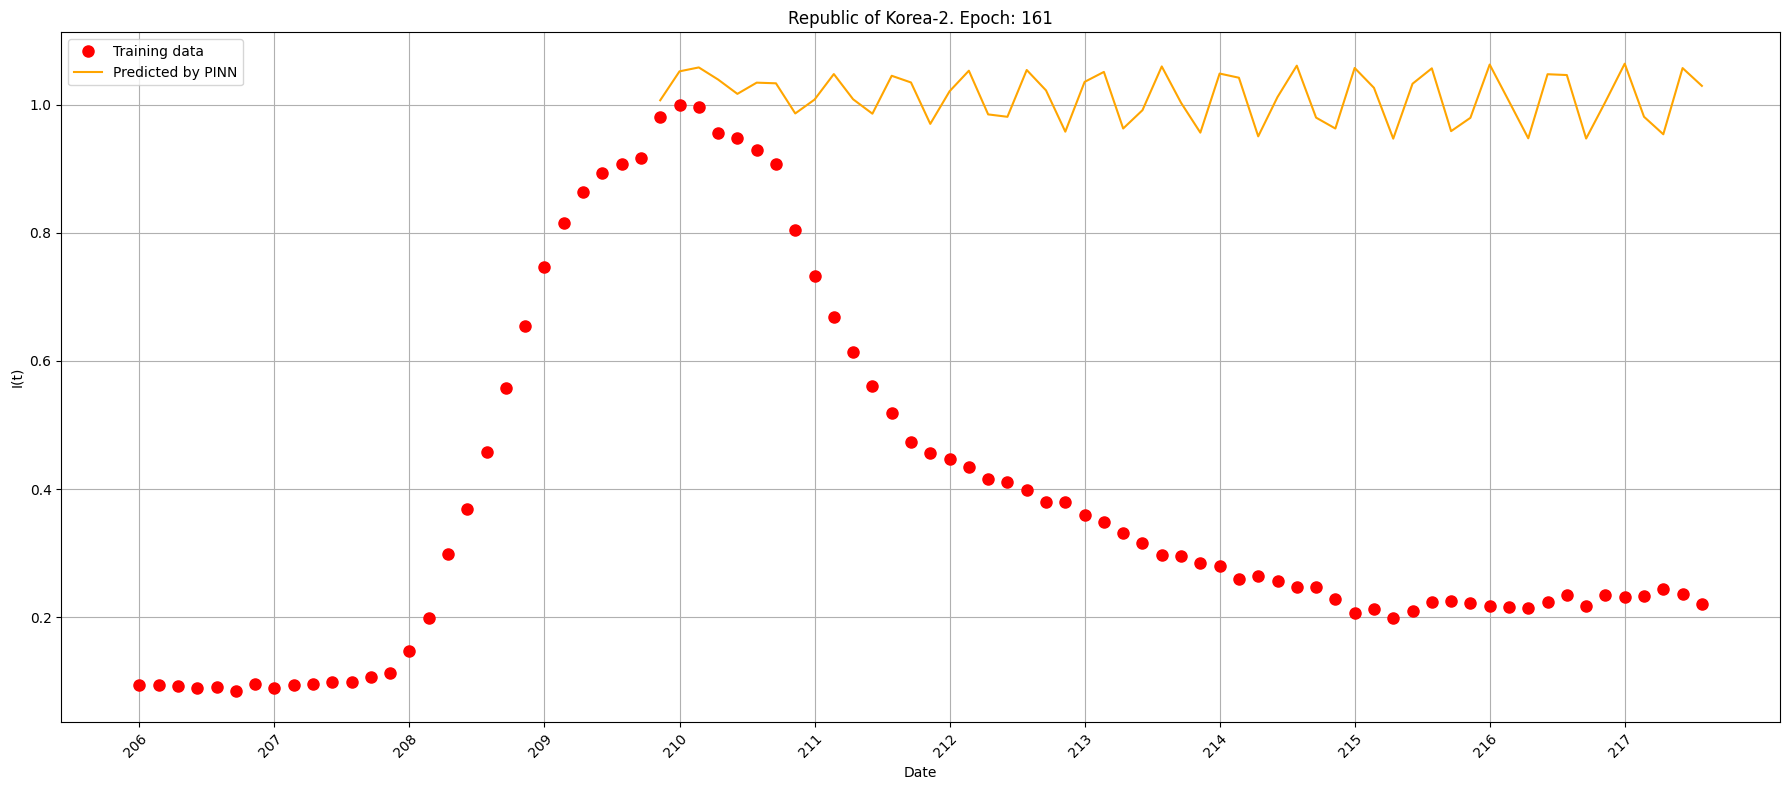

Epoch 161, MSE Loss = 0.0004983807448297739, SIR Loss = 1.4366285938649526e-13, Average Loss = 0.0006080504005903127


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


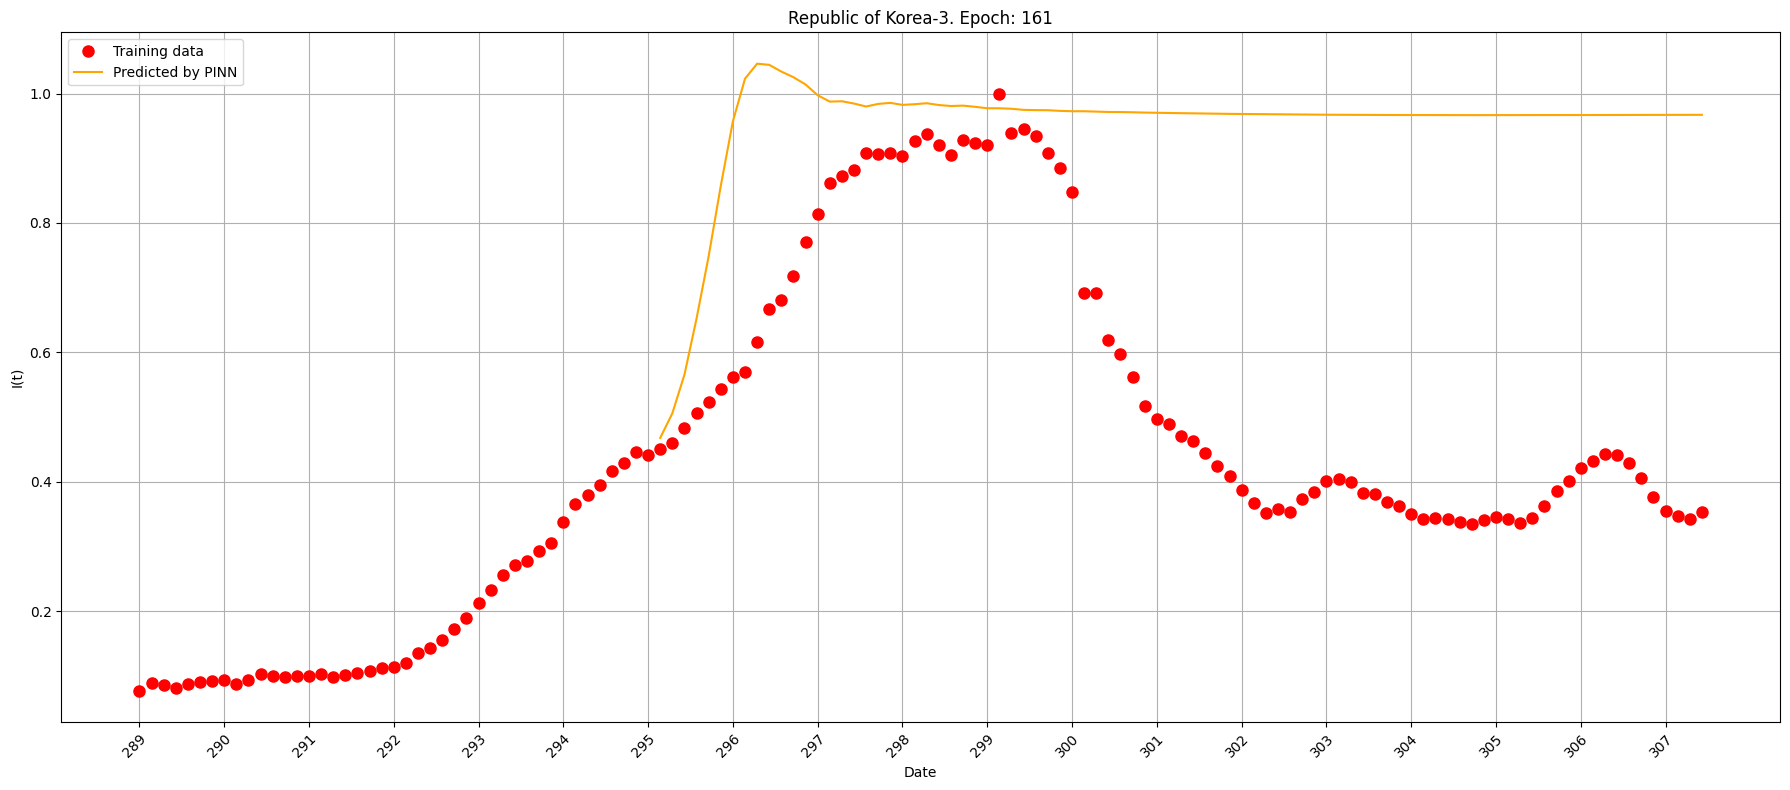

Epoch 161, MSE Loss = 0.0006377756362780929, SIR Loss = 7.930164816114238e-18, Average Loss = 0.0007872559244208148


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


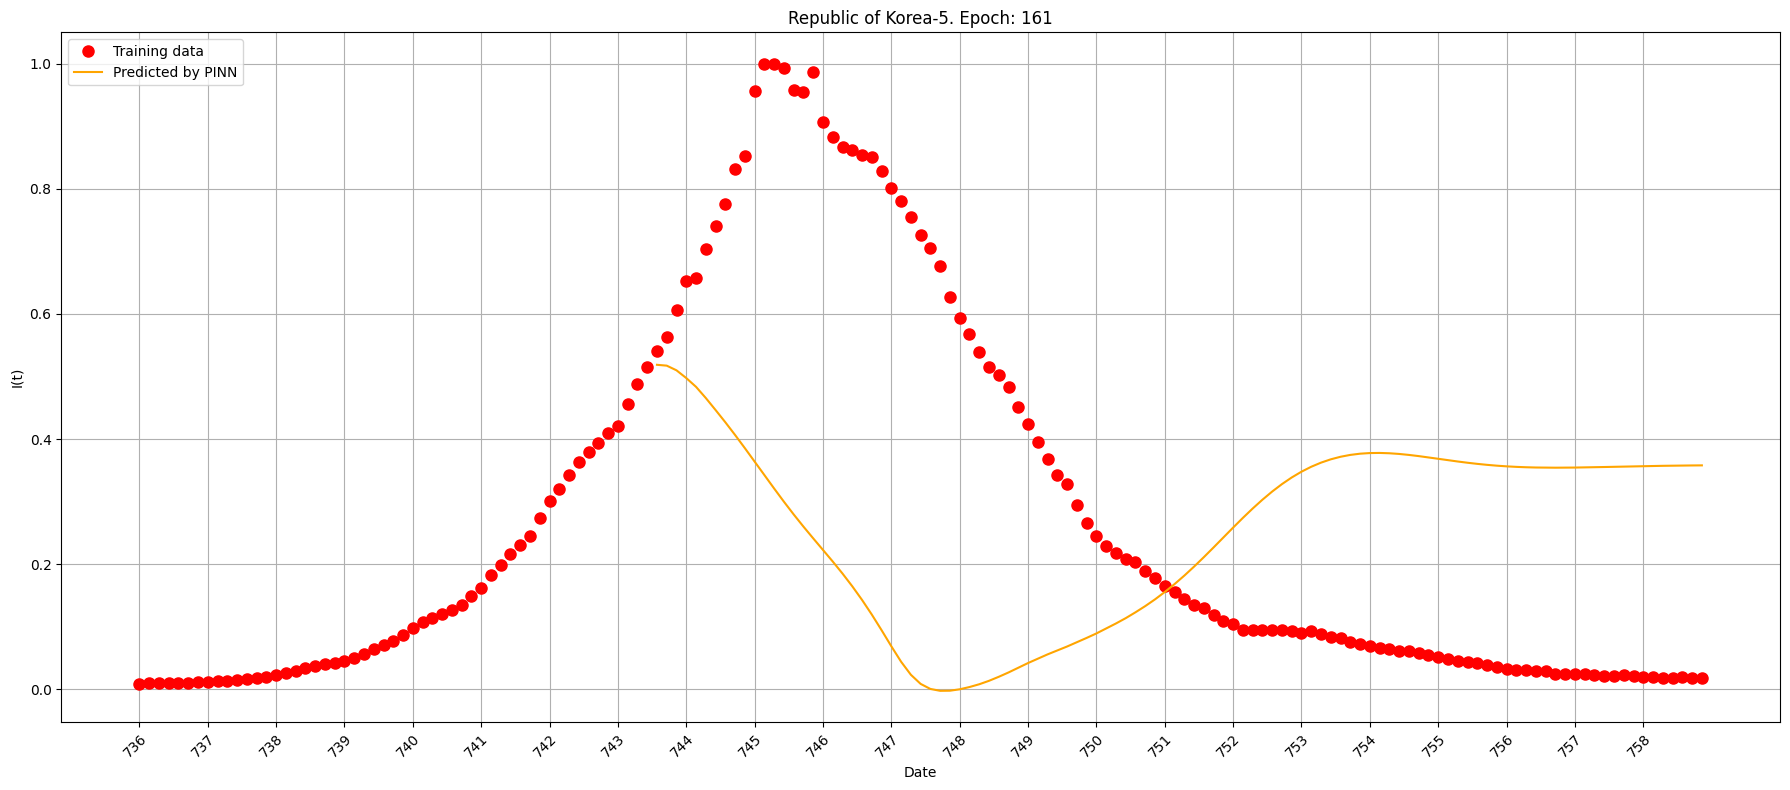

Epoch 161, MSE Loss = 4.829665340366773e-05, SIR Loss = 0.0, Average Loss = 0.00023140599737935498


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


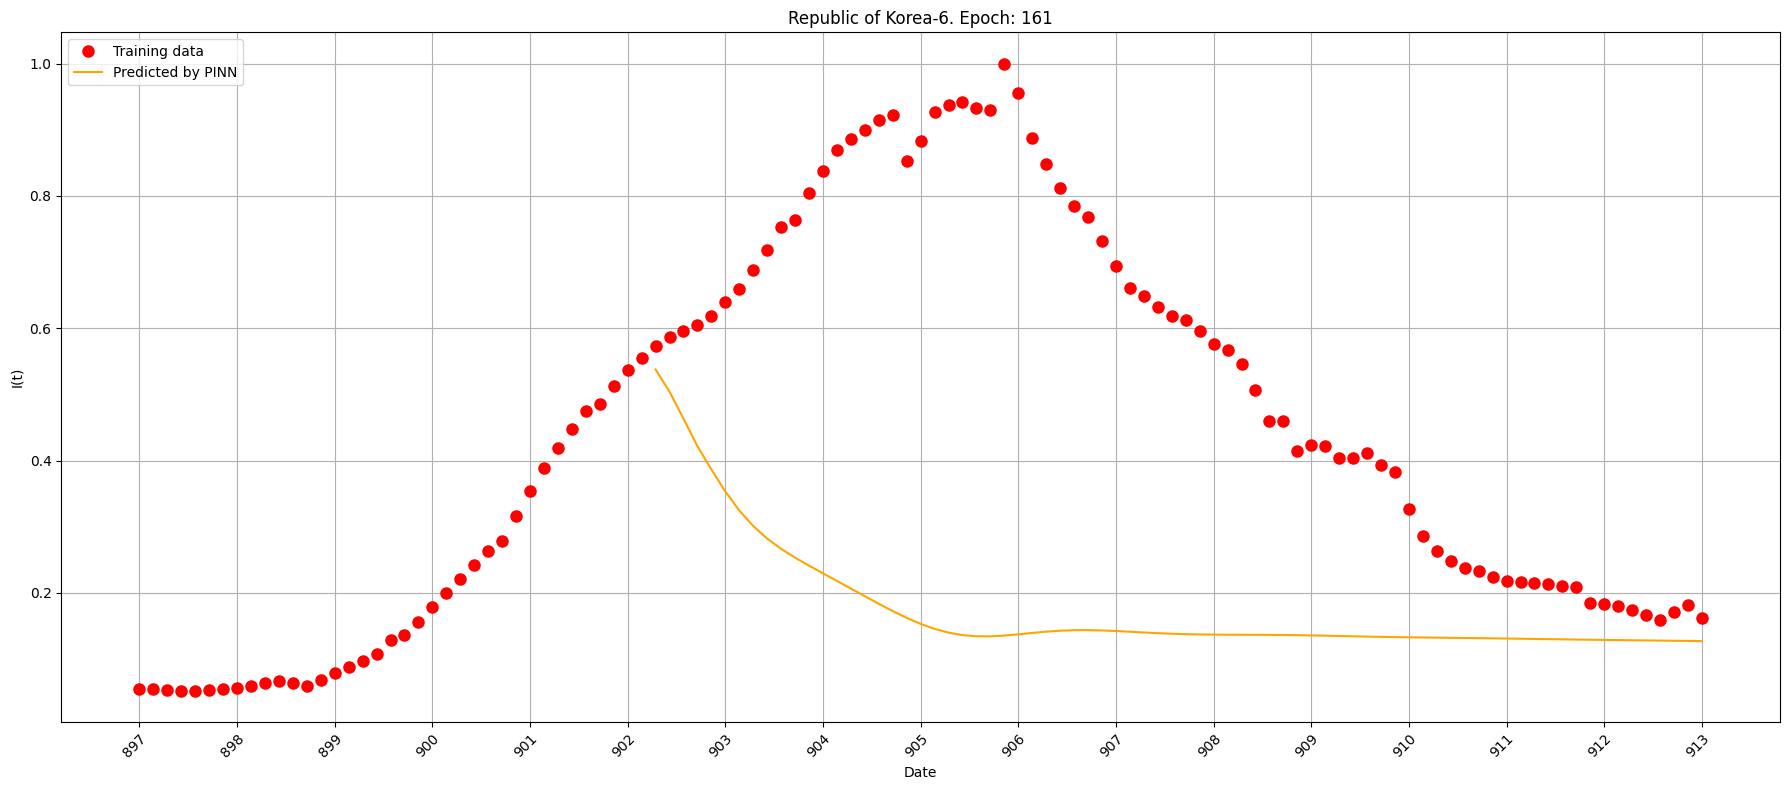

Epoch 161, MSE Loss = 0.00021497417765203863, SIR Loss = 0.0, Average Loss = 0.00048038201734585154


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


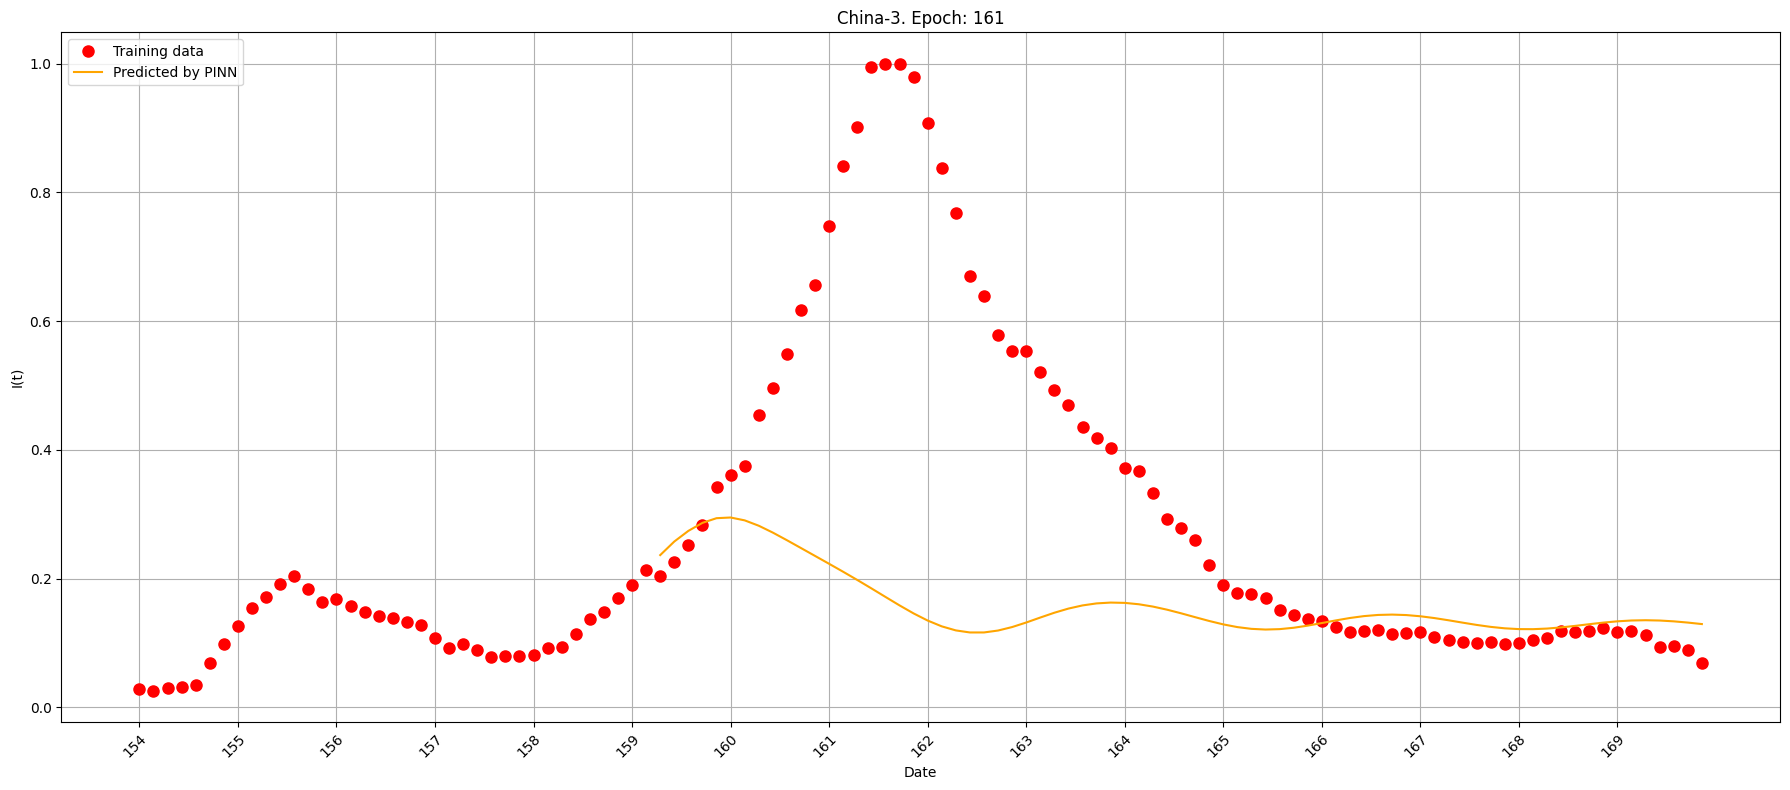

Epoch 161, MSE Loss = 0.0006681618979200721, SIR Loss = 3.752395529715846e-12, Average Loss = 0.0008145166753811241


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


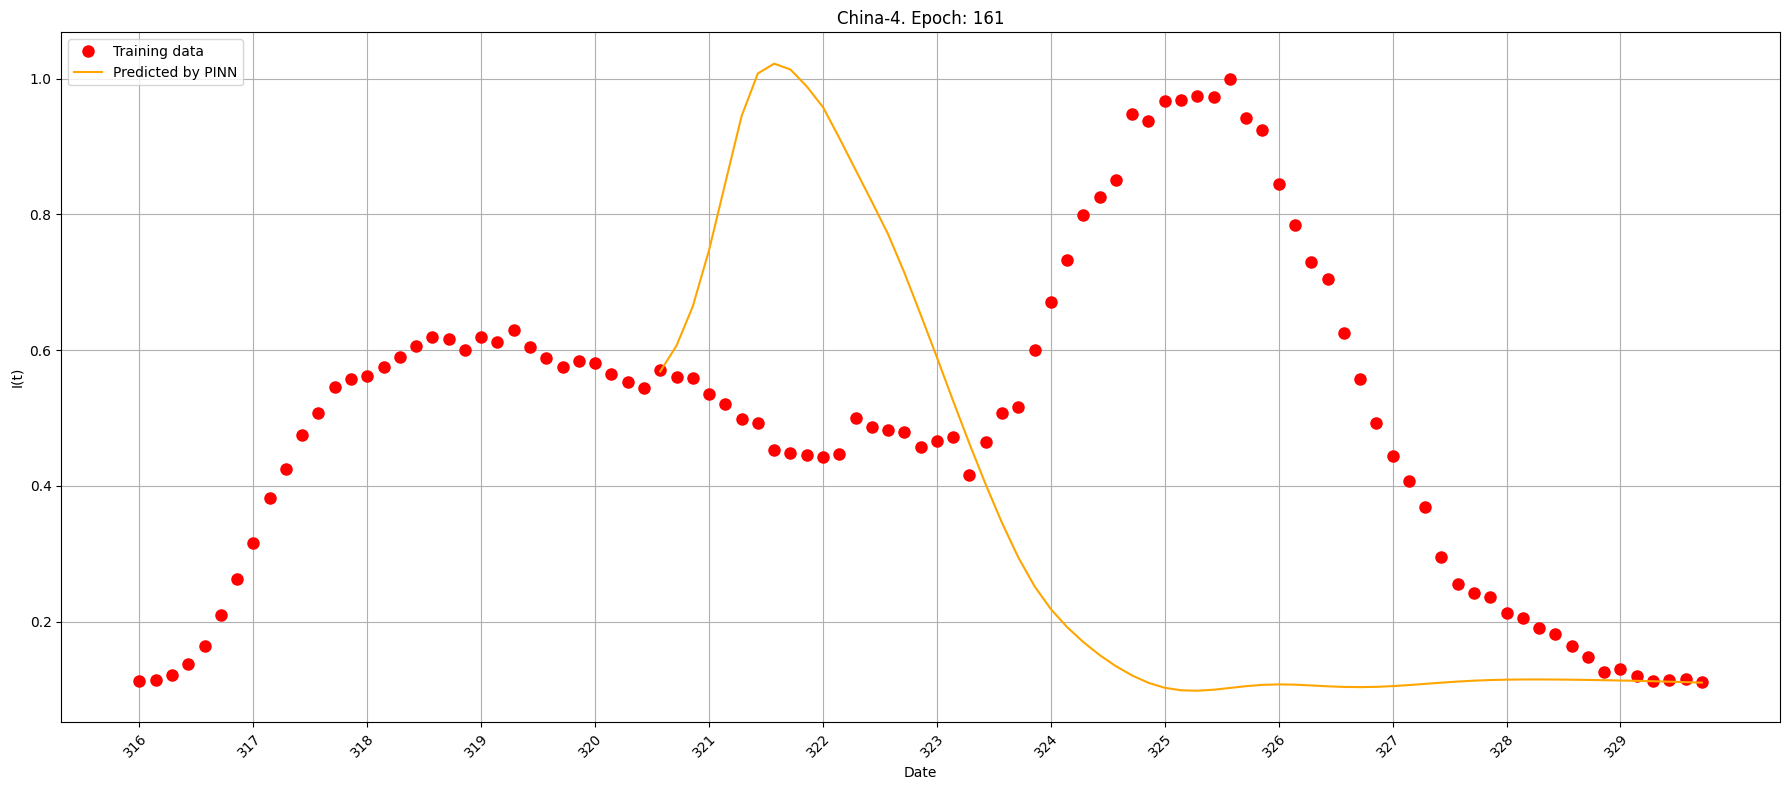

Epoch 161, MSE Loss = 3.3125939808087423e-05, SIR Loss = 1.8692984443333116e-13, Average Loss = 0.0007344504848339915


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


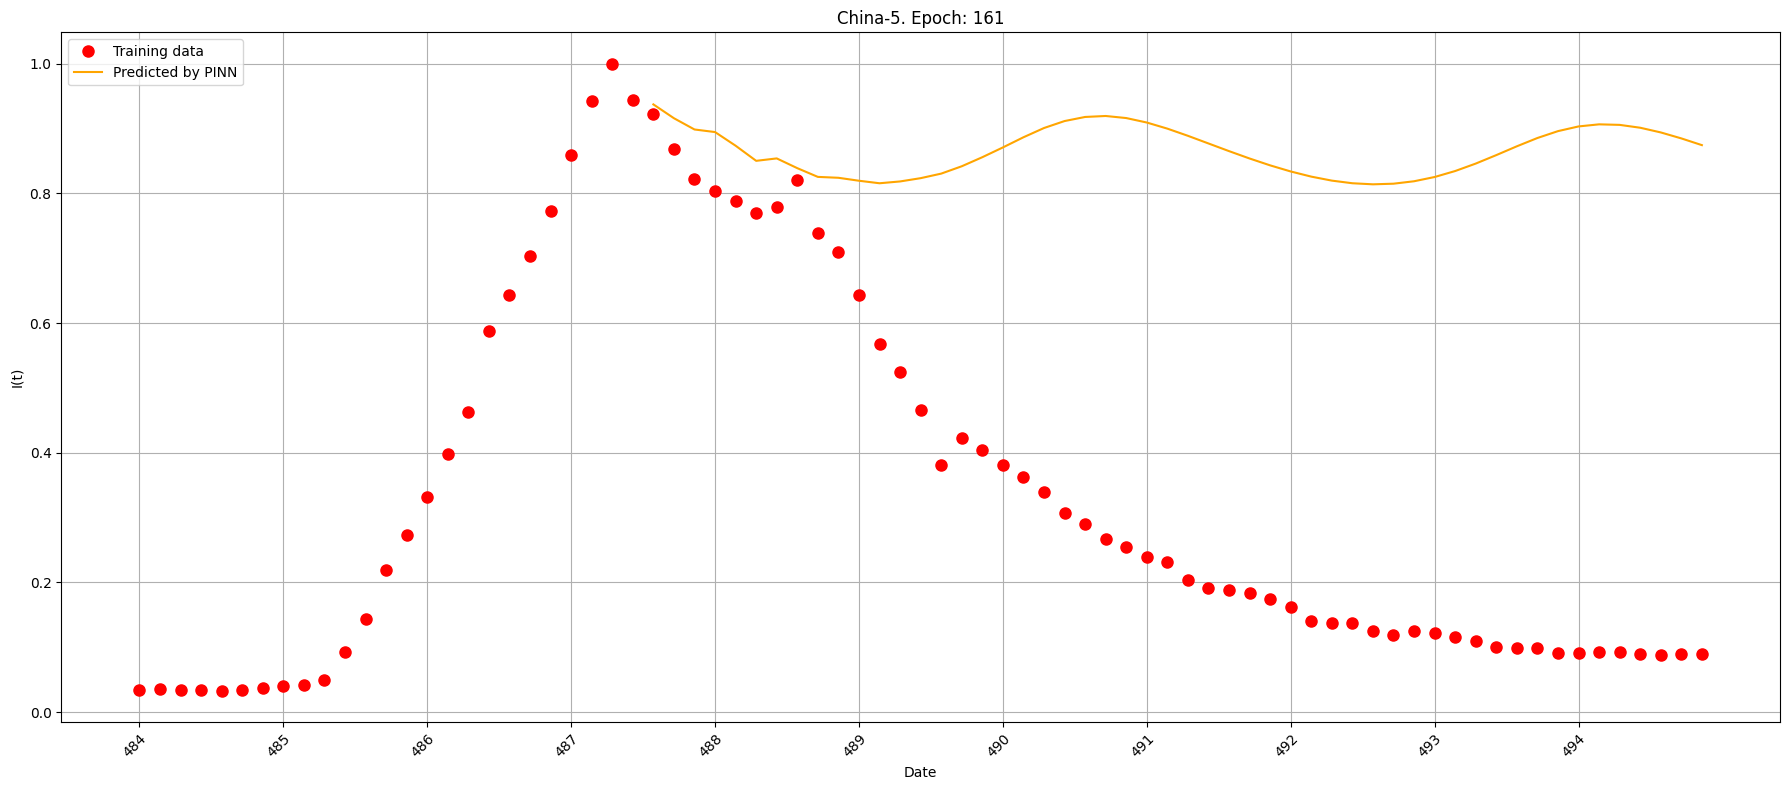

Epoch 161, MSE Loss = 3.470004958217032e-05, SIR Loss = 0.0, Average Loss = 0.000664611836212917


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


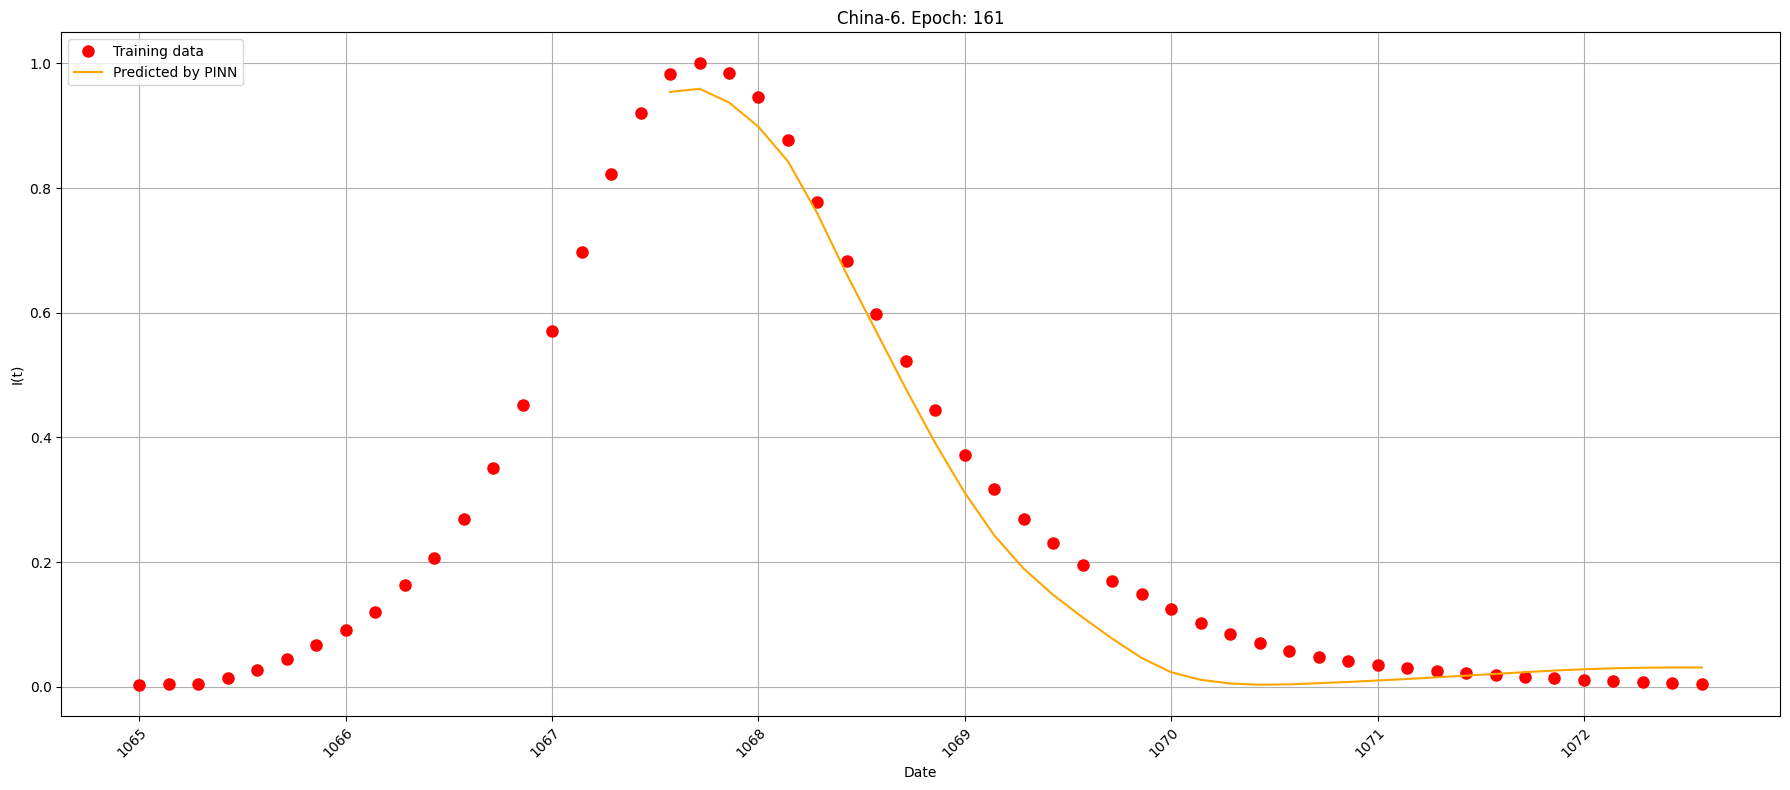

Epoch 161, MSE Loss = 2.5407522116438486e-05, SIR Loss = 0.0, Average Loss = 0.00024167617444144273


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Epoch 171, MSE Loss = 6.226288678590208e-05, SIR Loss = 1.3269746412802874e-09, Average Loss = 0.0003066655323737119
Epoch 171, MSE Loss = 0.00033148014335893095, SIR Loss = 1.6364149618697255e-11, Average Loss = 0.000735653283412816
Epoch 171, MSE Loss = 0.00013155998021829873, SIR Loss = 3.0965708512978307e-13, Average Loss = 0.000564868575547612
Epoch 171, MSE Loss = 1.4366560208145529e-05, SIR Loss = 2.4583511343544443e-16, Average Loss = 0.00021136933399550968
Epoch 171, MSE Loss = 0.0004436104209162295, SIR Loss = 5.233908695917336e-16, Average Loss = 0.0004523691673690114
Epoch 171, MSE Loss = 0.00023594852245878428, SIR Loss = 3.267695558584194e-10, Average Loss = 0.00032301242391756497
Epoch 171, MSE Loss = 4.610972973750904e-05, SIR Loss = 5.850241081503671e-13, Average Loss = 0.000544782491526045
Epoch 171, MSE Loss = 0.00023181606957223266, SIR Loss = 9.50350909079134e-13, Average Loss = 0.0007493440695796748
Epoch 171, MSE Loss = 5.792348474642495e-06, SIR Loss = 7.9301646

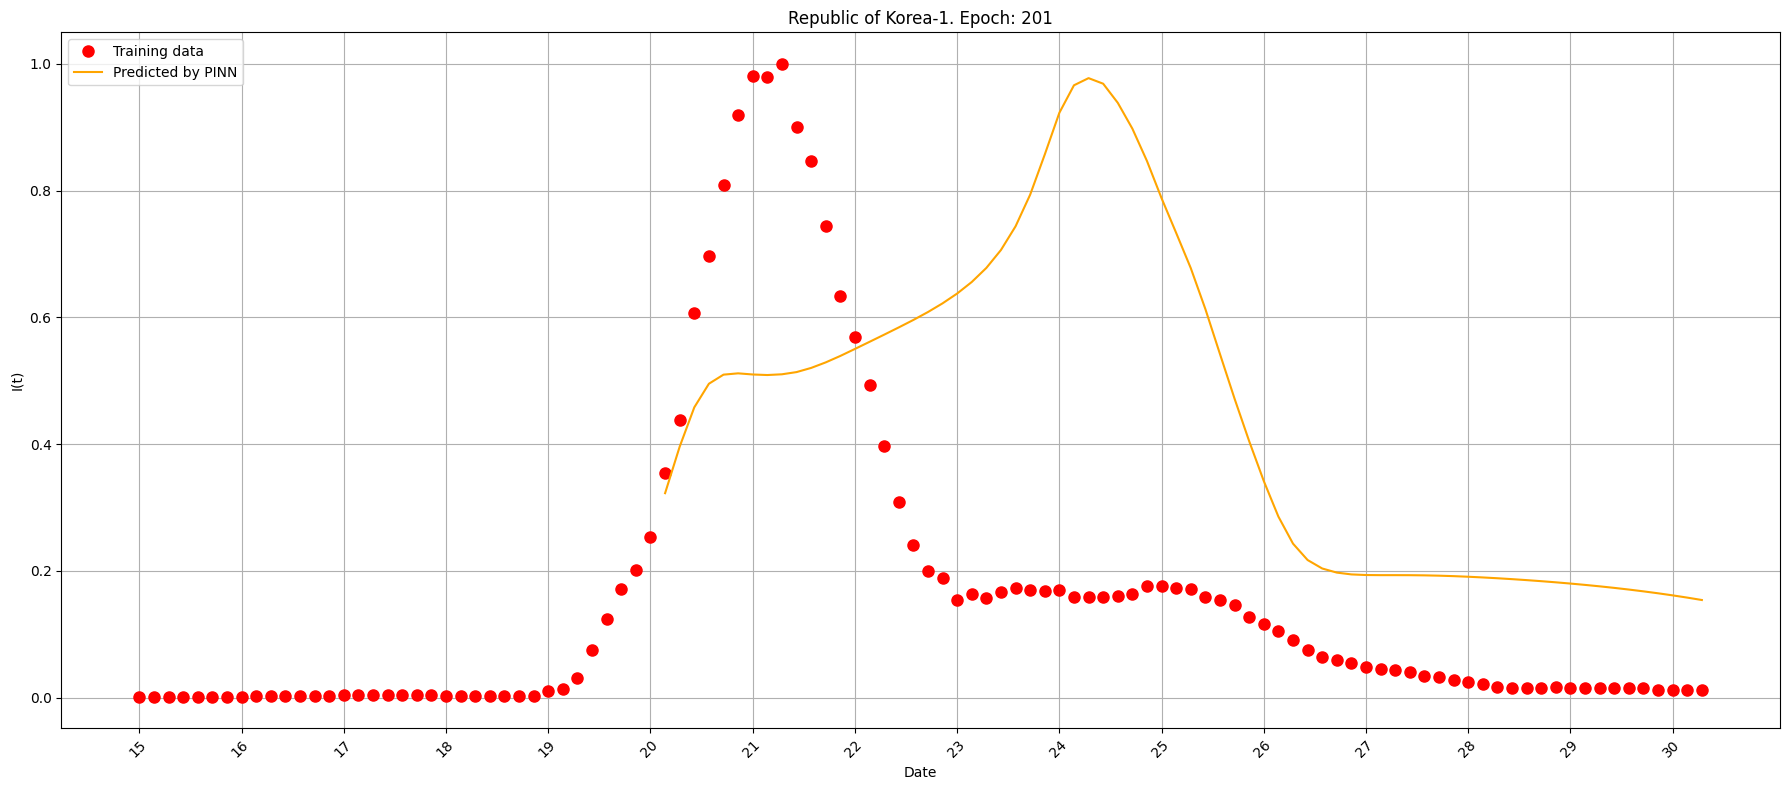

Epoch 201, MSE Loss = 9.80138429440558e-06, SIR Loss = 5.109417333670763e-10, Average Loss = 0.00023085419962287523


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


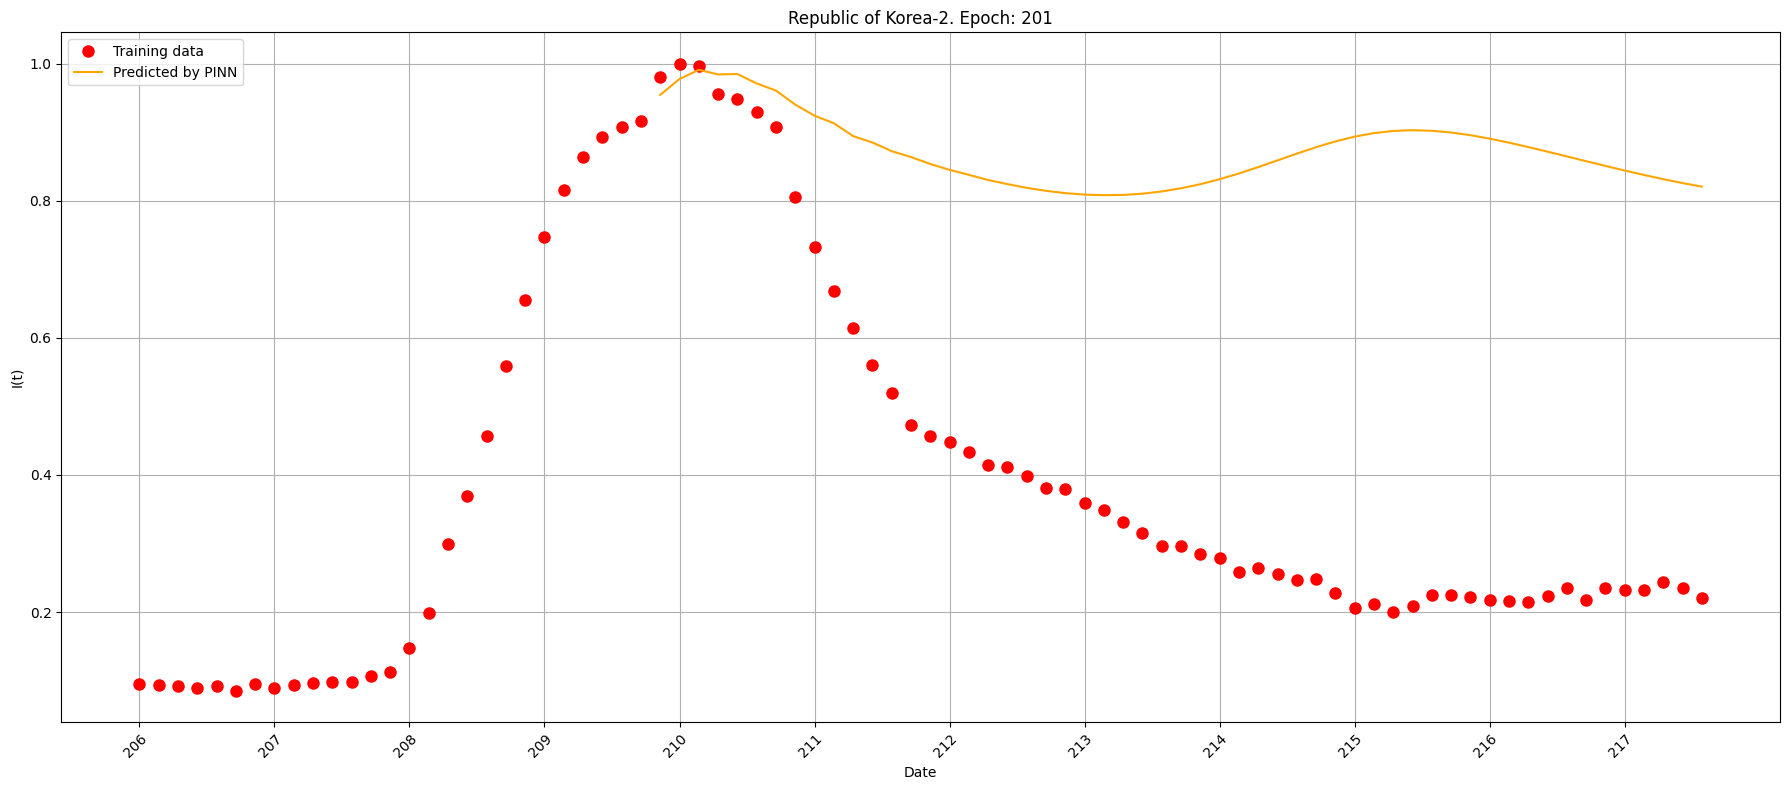

Epoch 201, MSE Loss = 0.00011379244097042829, SIR Loss = 5.464129582827271e-12, Average Loss = 0.0005479748311730267


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


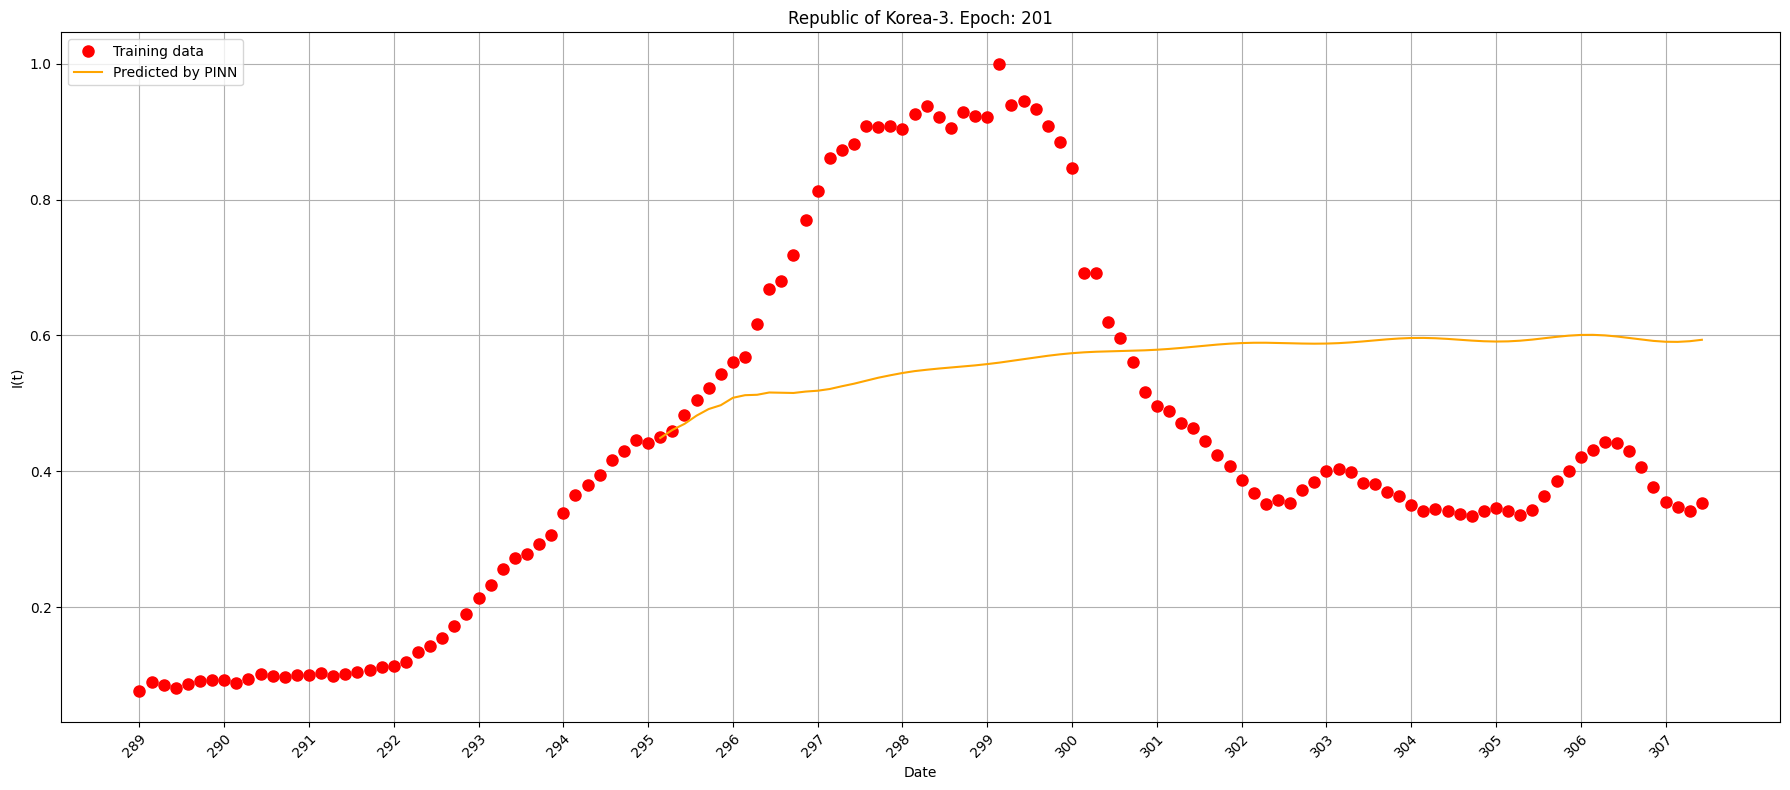

Epoch 201, MSE Loss = 0.00011218064901186153, SIR Loss = 2.4876411694463307e-11, Average Loss = 0.0005053430387972553


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


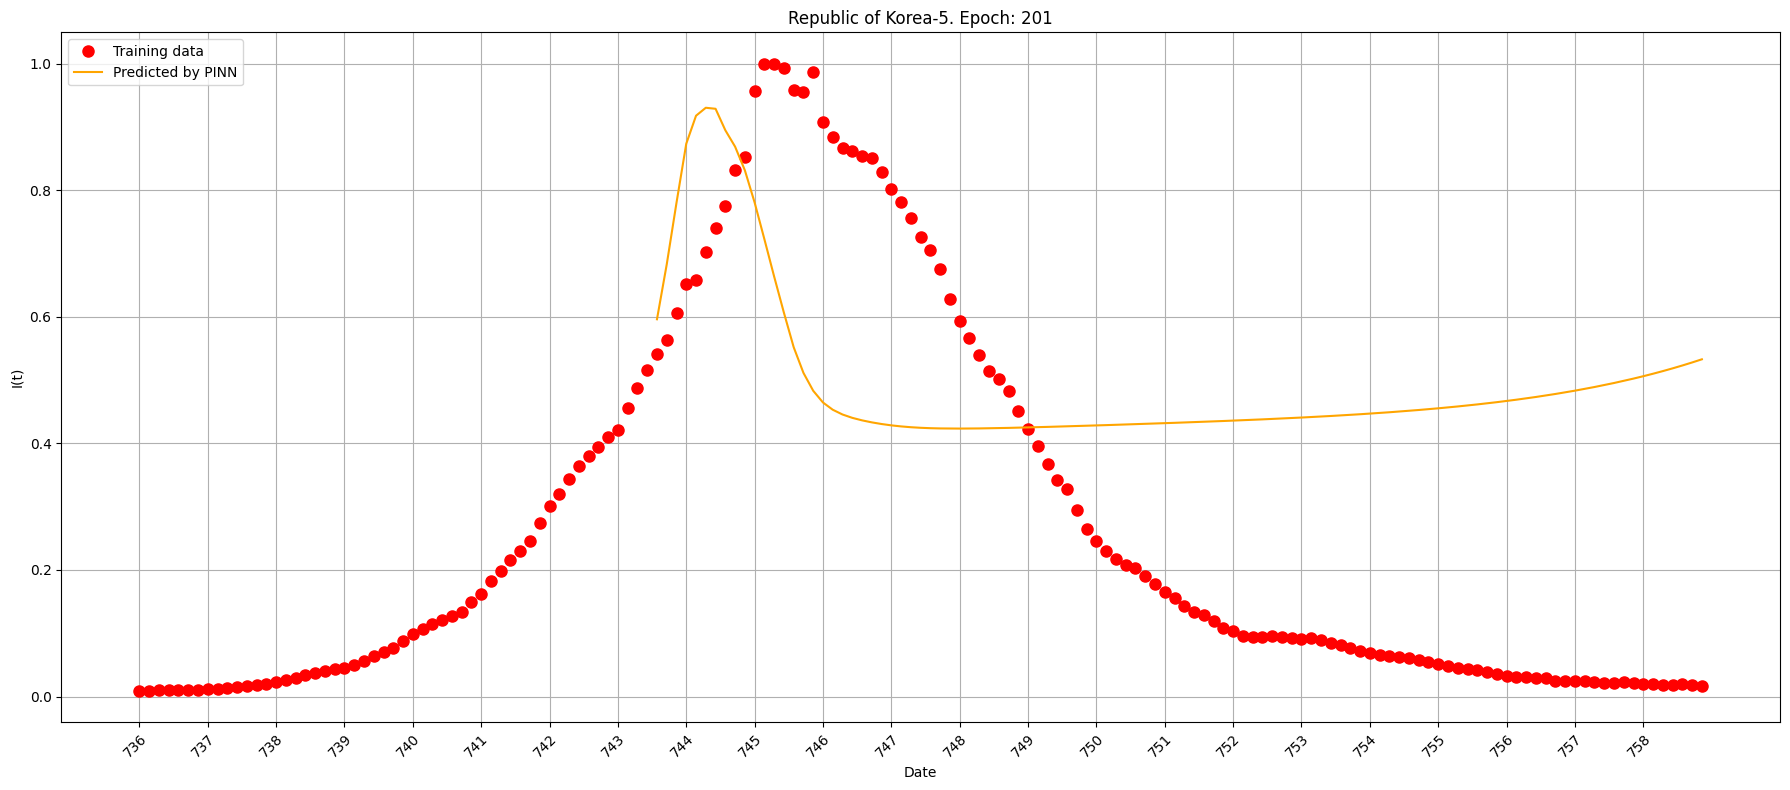

Epoch 201, MSE Loss = 7.863675932640035e-07, SIR Loss = 3.9650823253390577e-17, Average Loss = 0.00042746757207077704


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


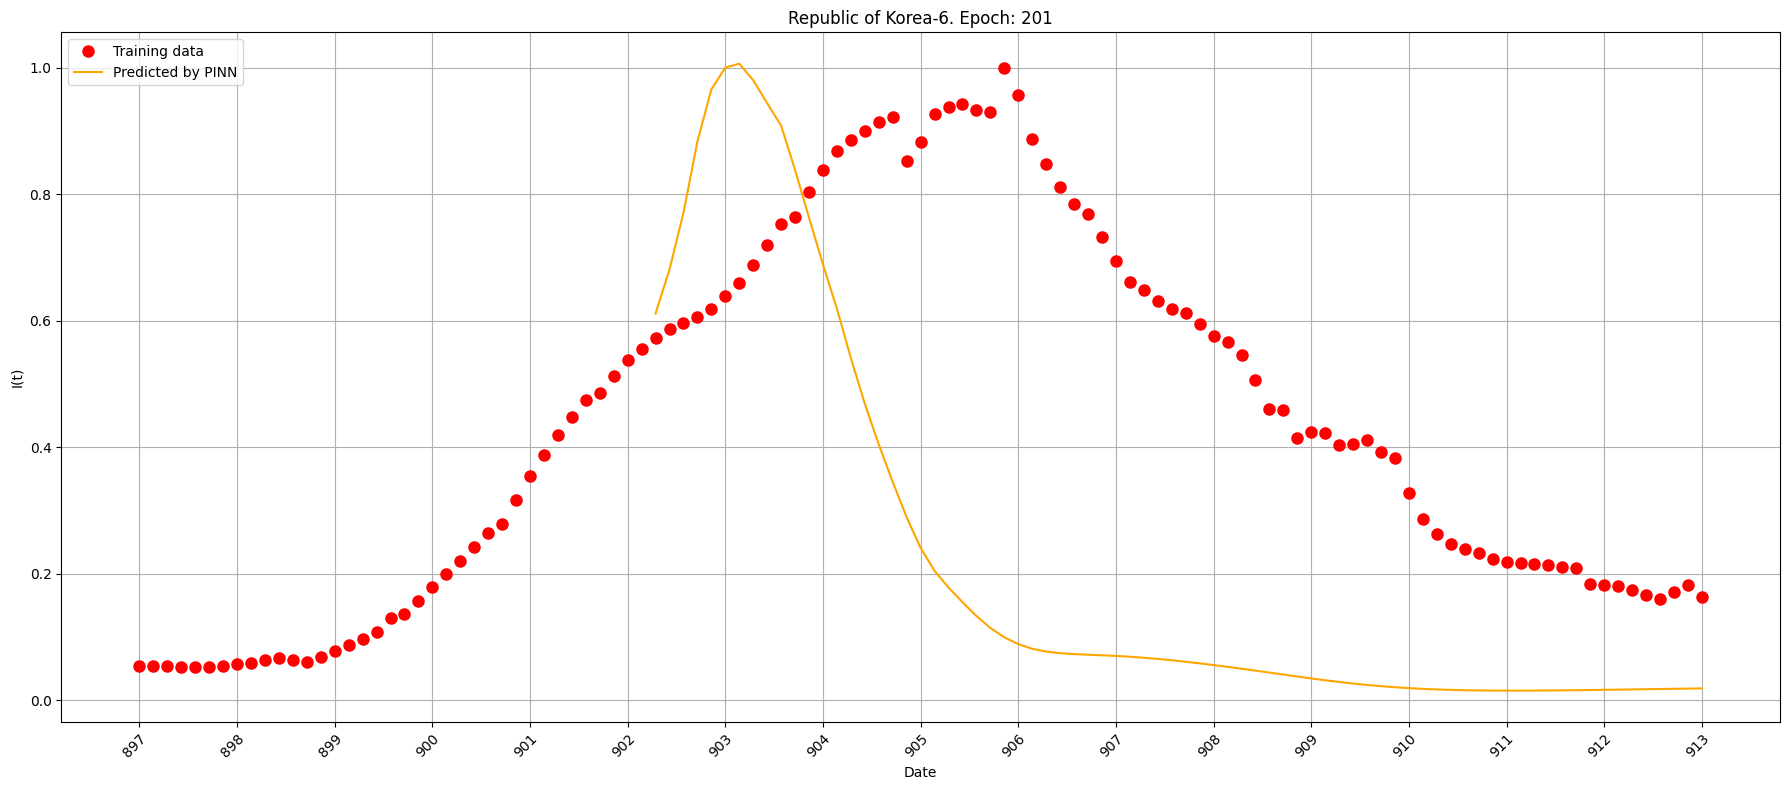

Epoch 201, MSE Loss = 0.00022587302373722196, SIR Loss = 0.0, Average Loss = 0.00041561846563272756


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


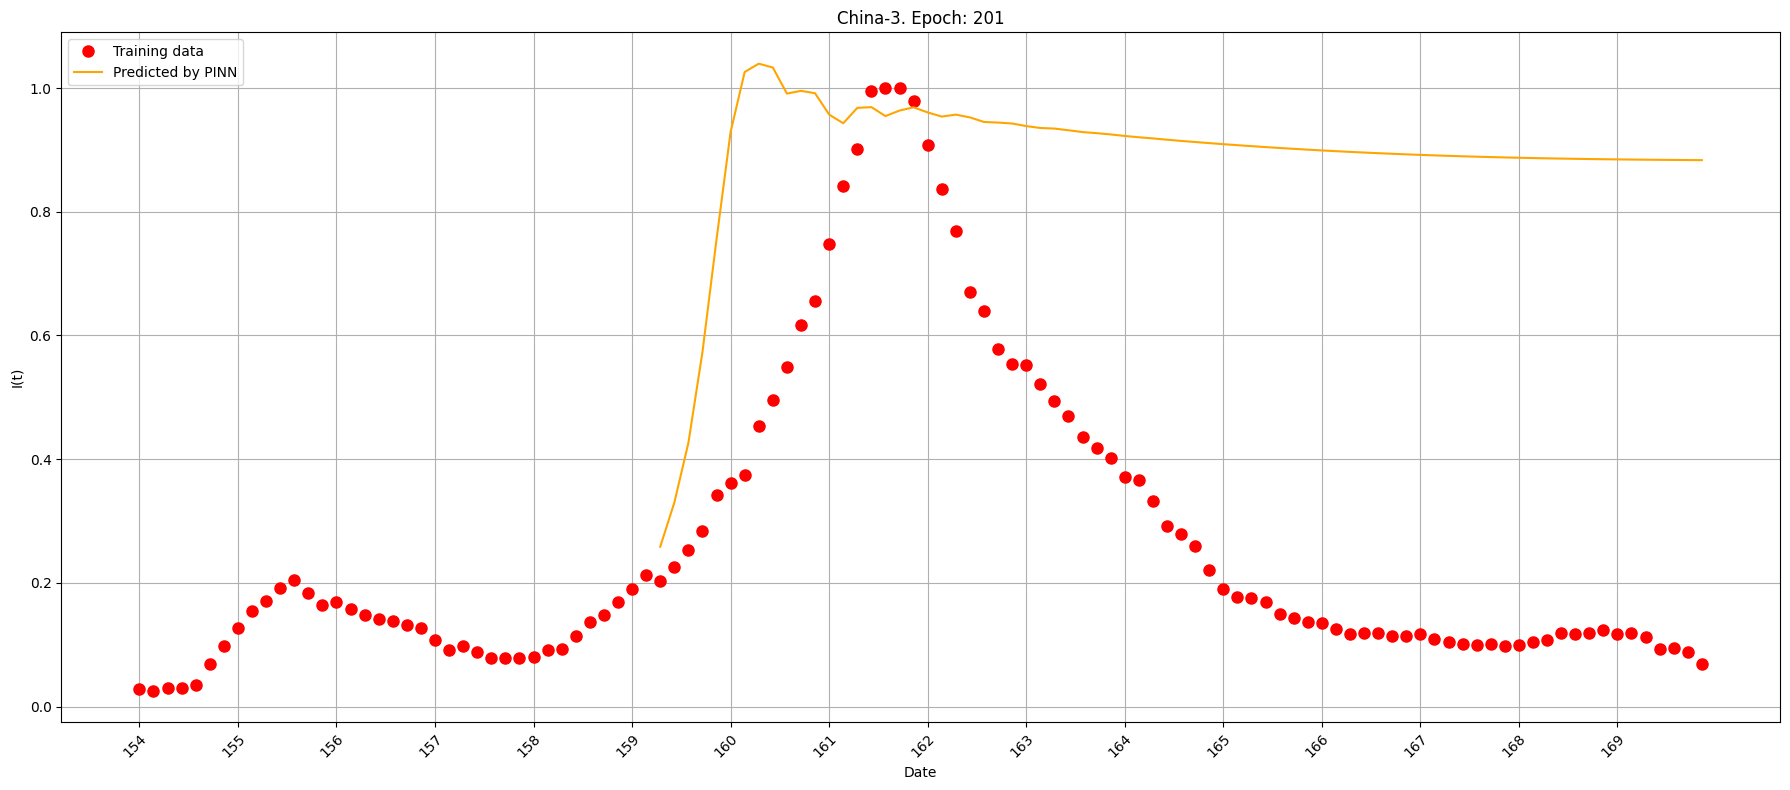

Epoch 201, MSE Loss = 0.00022853486007079482, SIR Loss = 4.698571740013868e-11, Average Loss = 0.000279519673056473


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


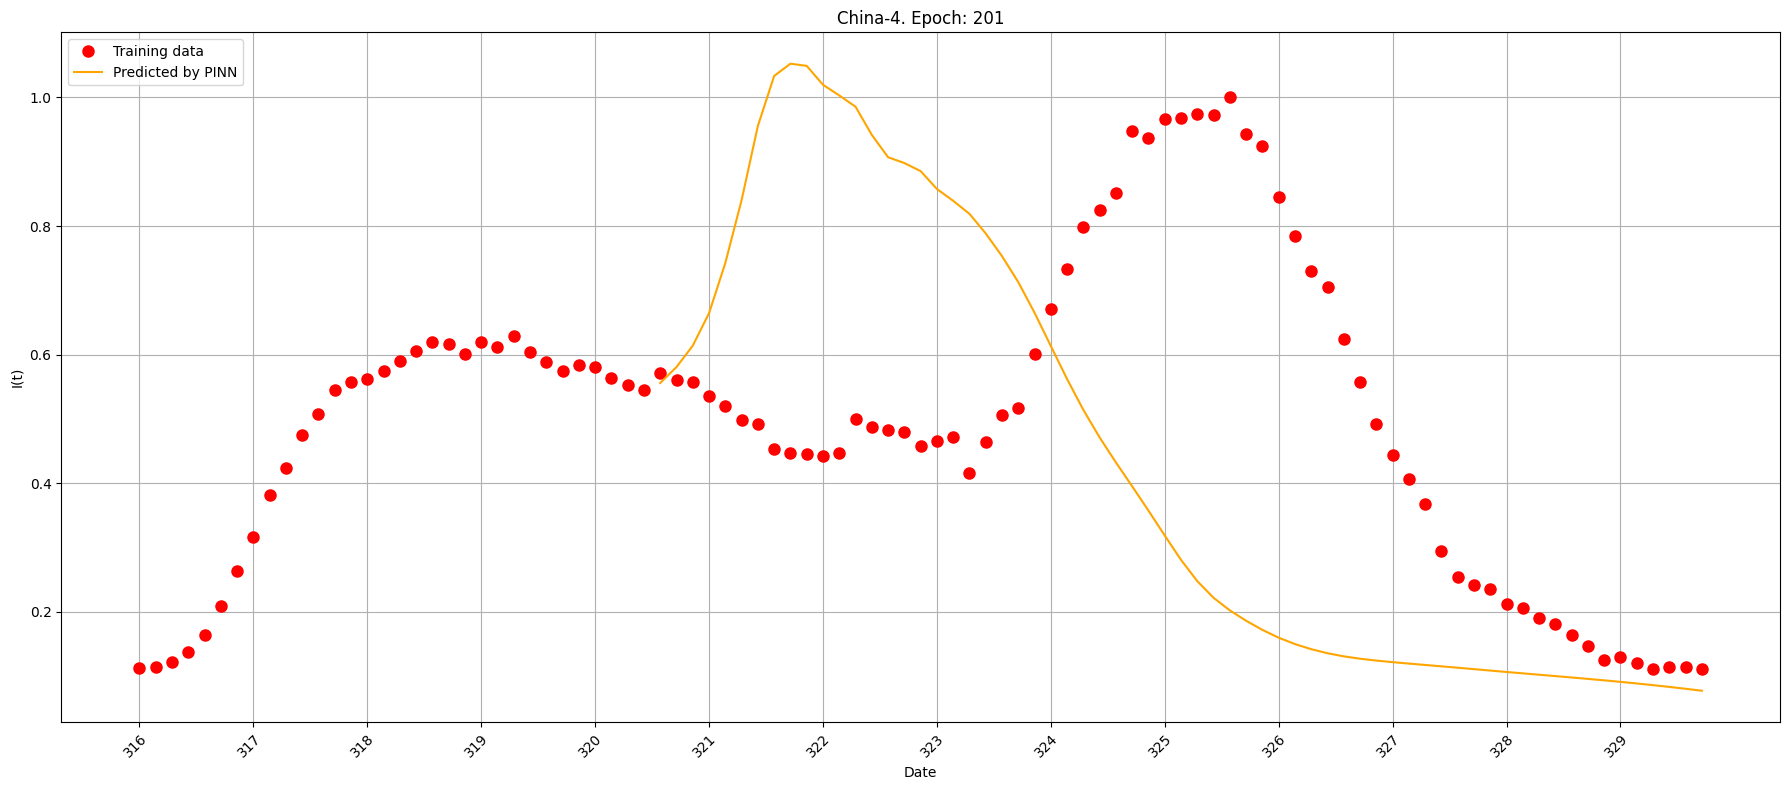

Epoch 201, MSE Loss = 0.00014679745072498918, SIR Loss = 9.874482308214194e-12, Average Loss = 0.0006692502014336317


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


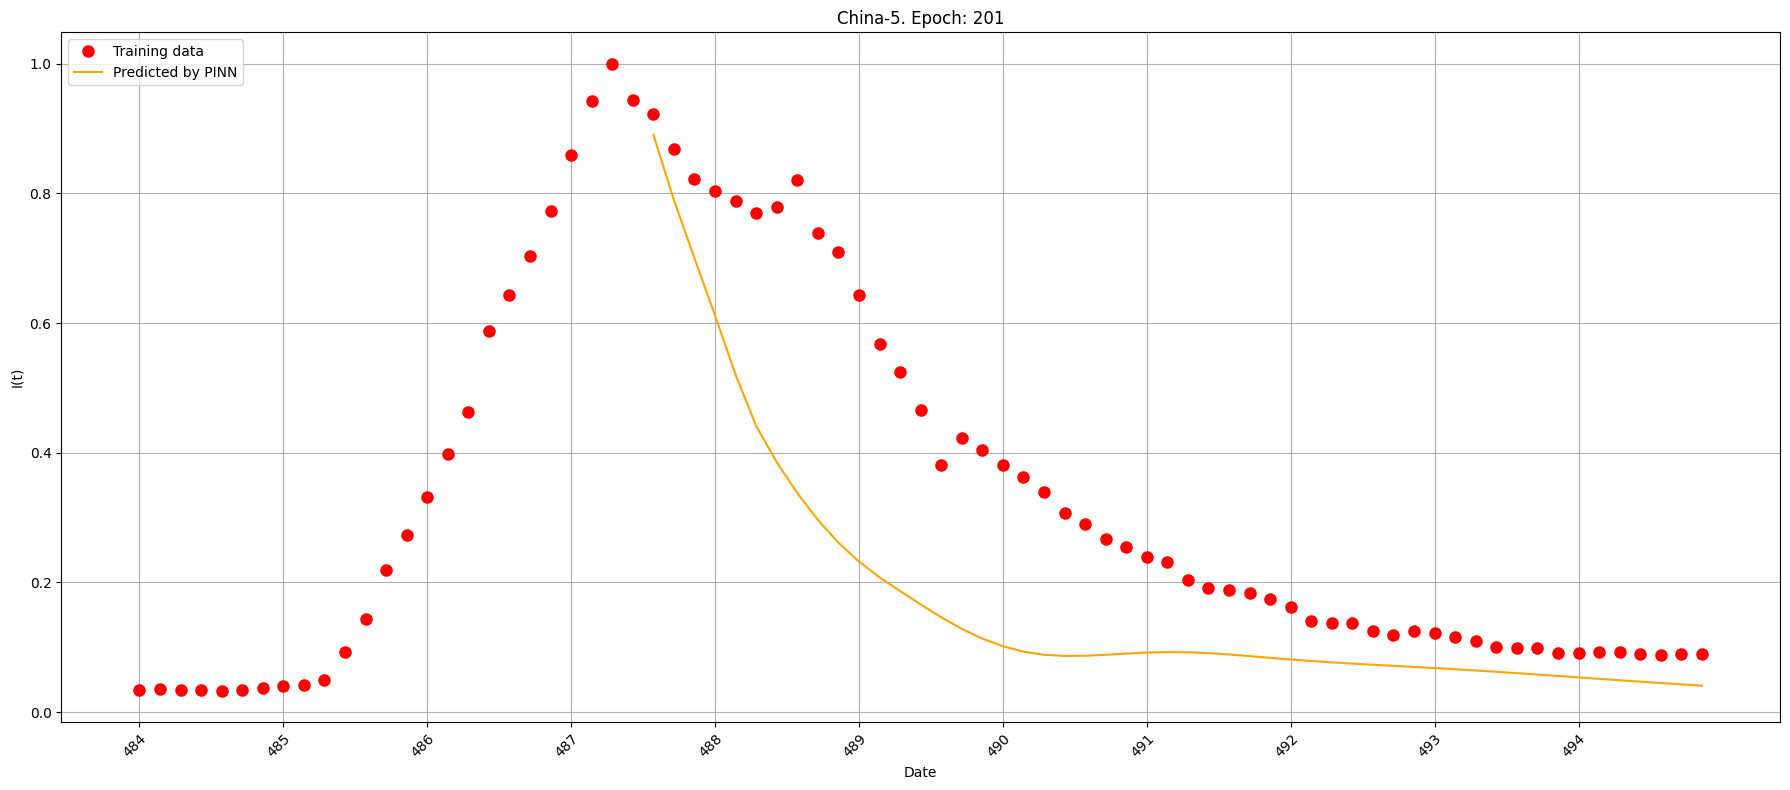

Epoch 201, MSE Loss = 1.5761410395498388e-05, SIR Loss = 2.1411444424482013e-16, Average Loss = 0.0007000256679549669


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


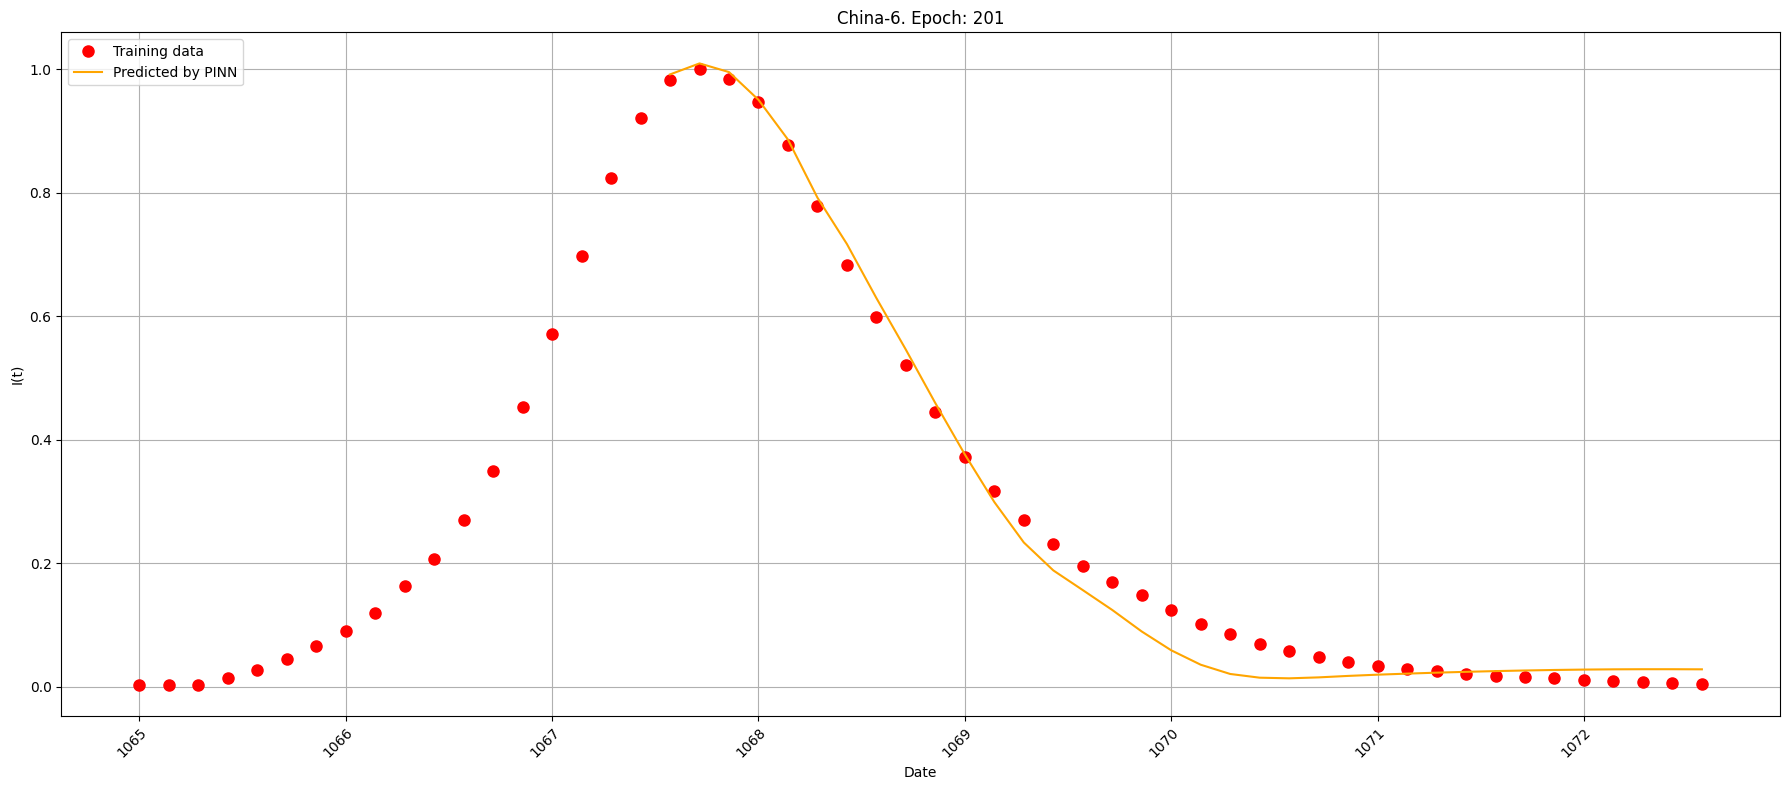

Epoch 201, MSE Loss = 4.708050255430862e-06, SIR Loss = 0.0, Average Loss = 0.0009532415895743321


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Epoch 211, MSE Loss = 4.513462499744492e-06, SIR Loss = 2.3591644193743377e-08, Average Loss = 0.0004441244757389472
Epoch 211, MSE Loss = 4.5722397771896794e-05, SIR Loss = 2.5739649127387576e-12, Average Loss = 0.0005466776935019387
Epoch 211, MSE Loss = 0.0006285159615799785, SIR Loss = 4.389100194401863e-12, Average Loss = 0.0008586760359977024
Epoch 211, MSE Loss = 3.439349029576988e-06, SIR Loss = 2.0618428356460896e-16, Average Loss = 0.00021869036158933119
Epoch 211, MSE Loss = 6.806541932746768e-05, SIR Loss = 3.5190558800302085e-11, Average Loss = 0.000831165173468529
Epoch 211, MSE Loss = 0.000410521897720173, SIR Loss = 1.0537504202545733e-09, Average Loss = 0.0016326128372649727
Epoch 211, MSE Loss = 0.0007062622462399304, SIR Loss = 1.3172694046659217e-09, Average Loss = 0.000711291522412062
Epoch 211, MSE Loss = 1.749501097947359e-05, SIR Loss = 3.634156506542724e-13, Average Loss = 0.000660919885349325
Epoch 211, MSE Loss = 1.0235028184979456e-06, SIR Loss = 7.930164816

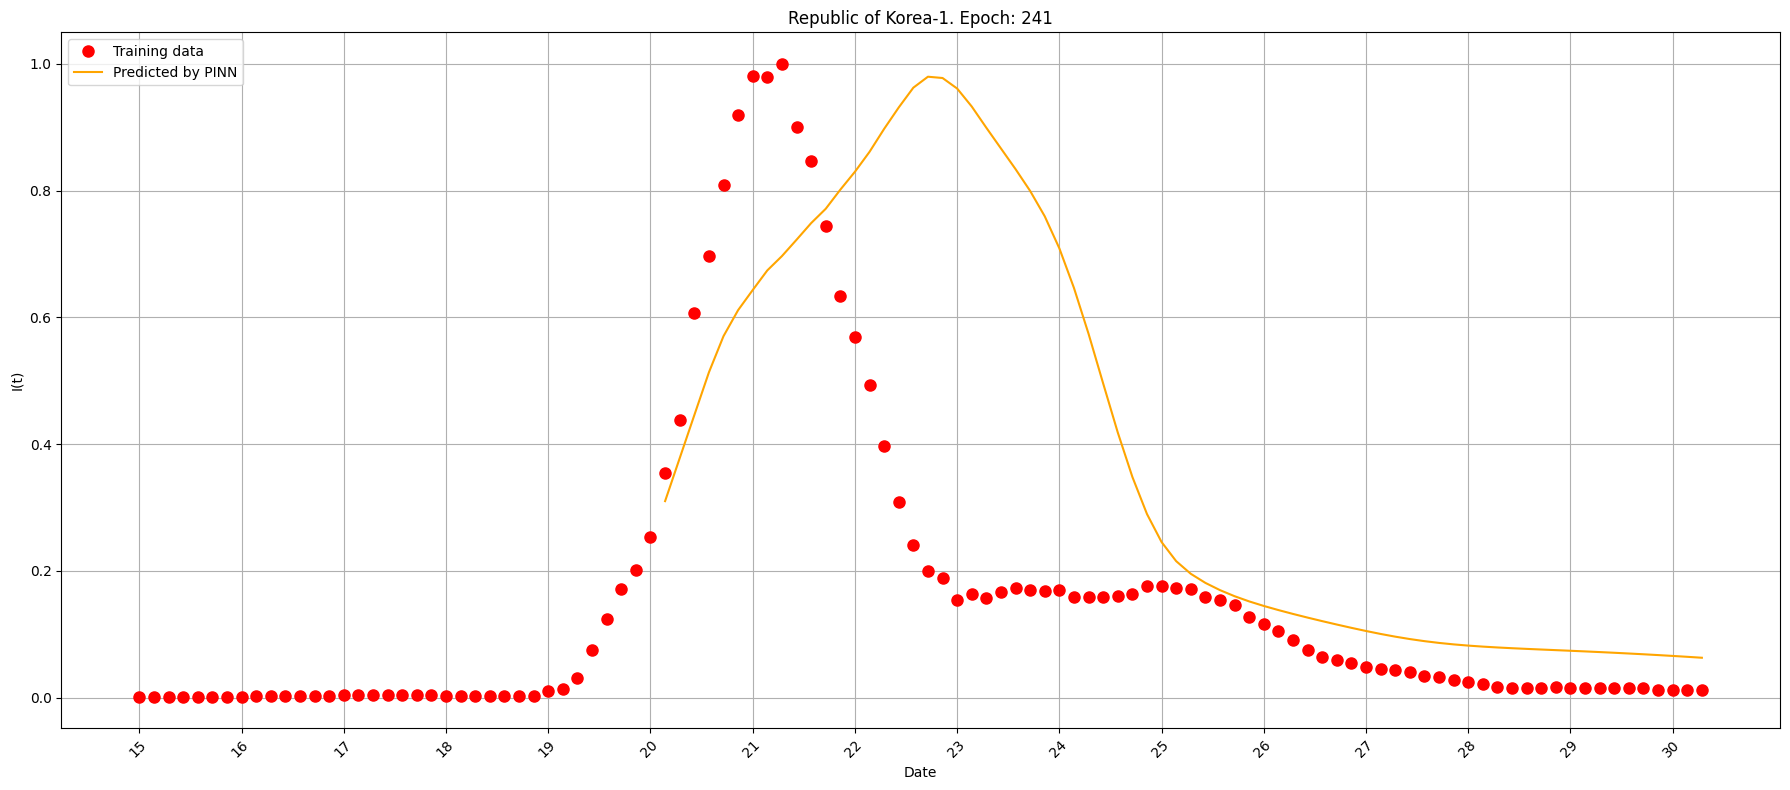

Epoch 241, MSE Loss = 1.251893991138786e-06, SIR Loss = 5.47198242273339e-09, Average Loss = 0.00030347095180897584


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


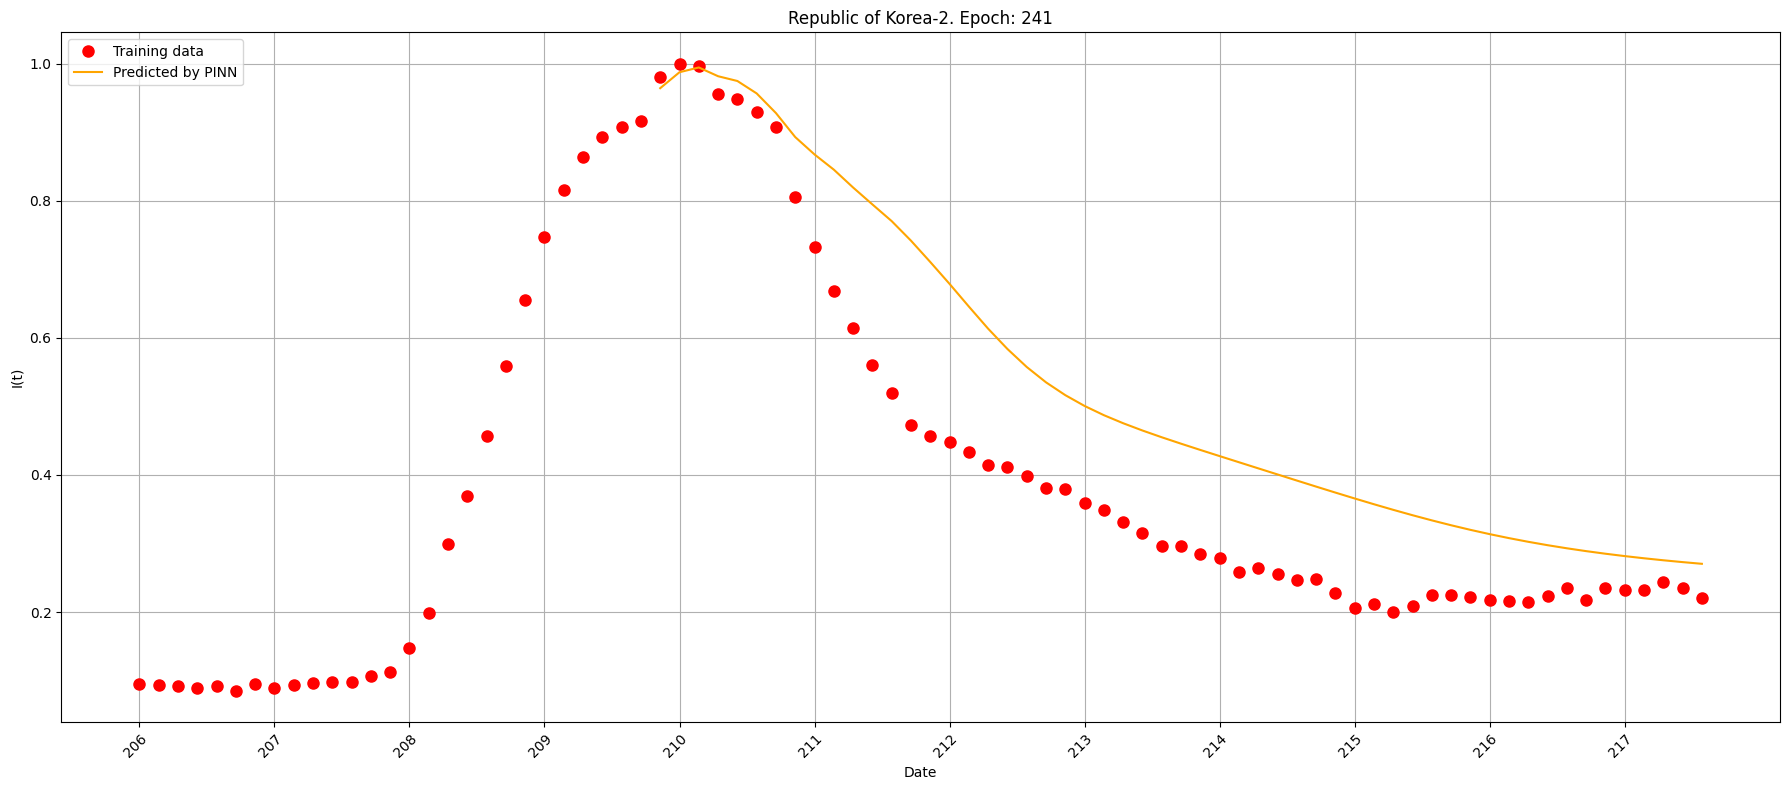

Epoch 241, MSE Loss = 3.5424003726802766e-05, SIR Loss = 3.7109443122573804e-12, Average Loss = 0.00045460360278752886


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


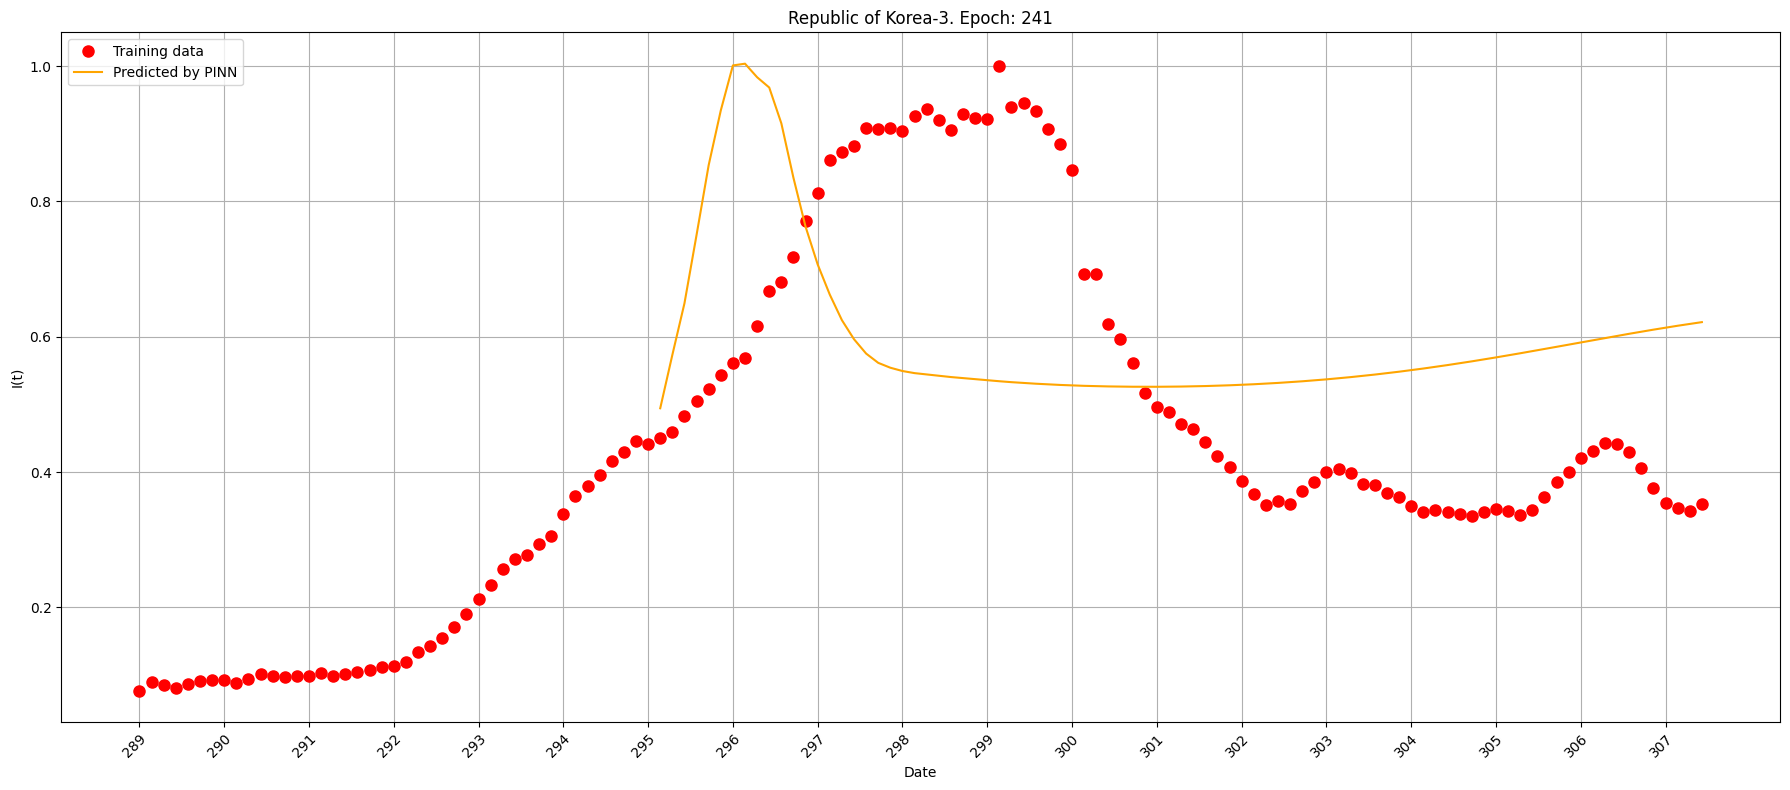

Epoch 241, MSE Loss = 0.00011526337038958445, SIR Loss = 3.7110689521391294e-11, Average Loss = 0.0005238215419642975


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


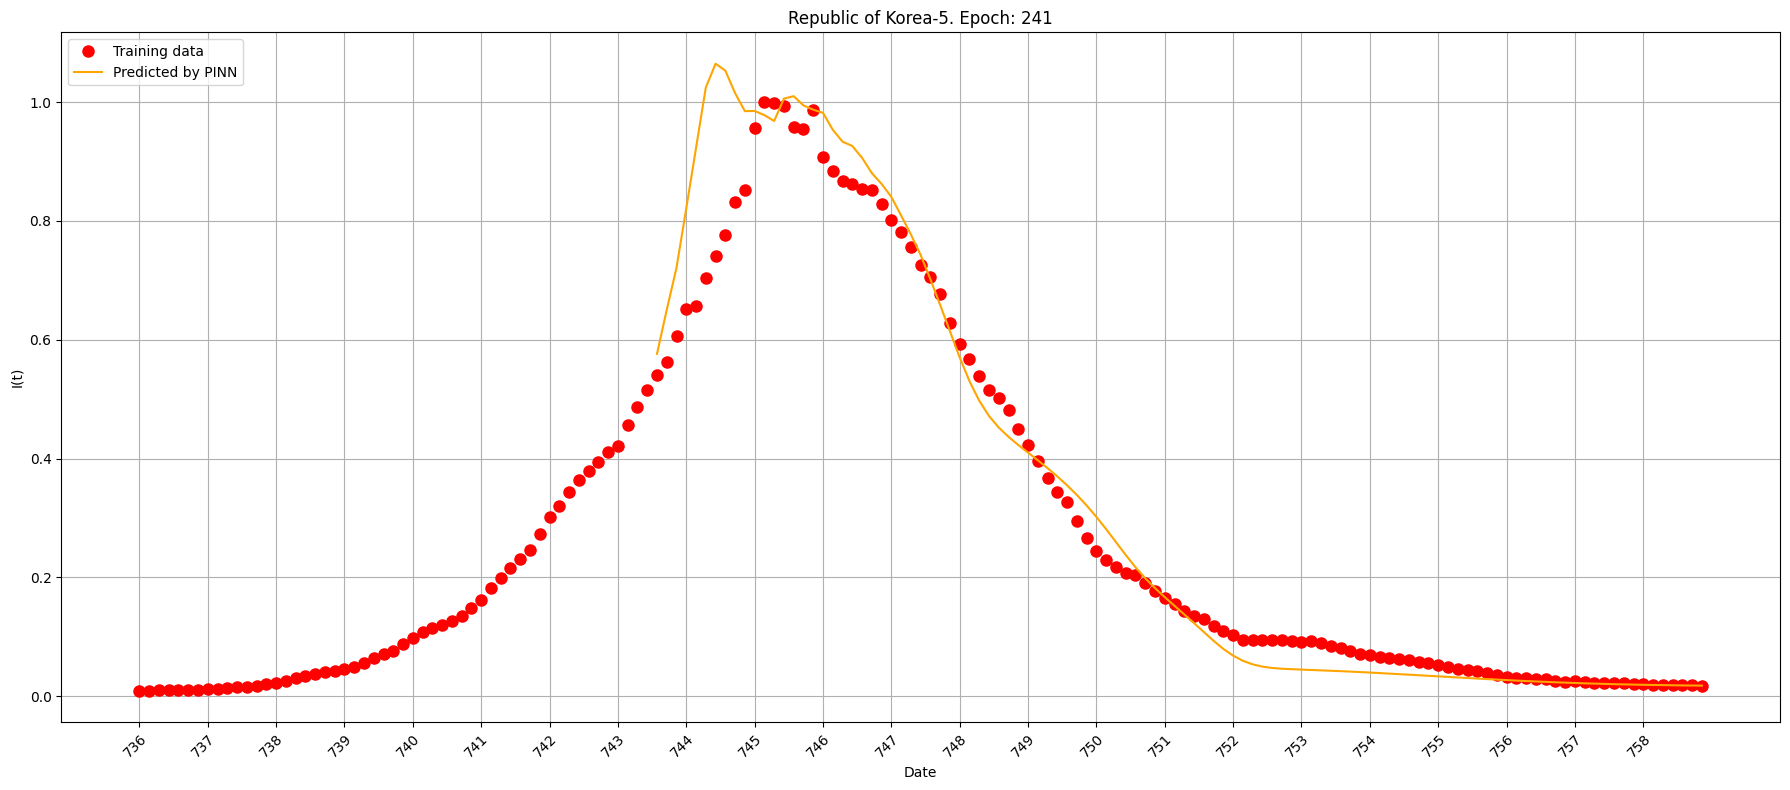

Epoch 241, MSE Loss = 5.756878636020701e-06, SIR Loss = 5.416302629790209e-15, Average Loss = 0.00024103950327048938


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


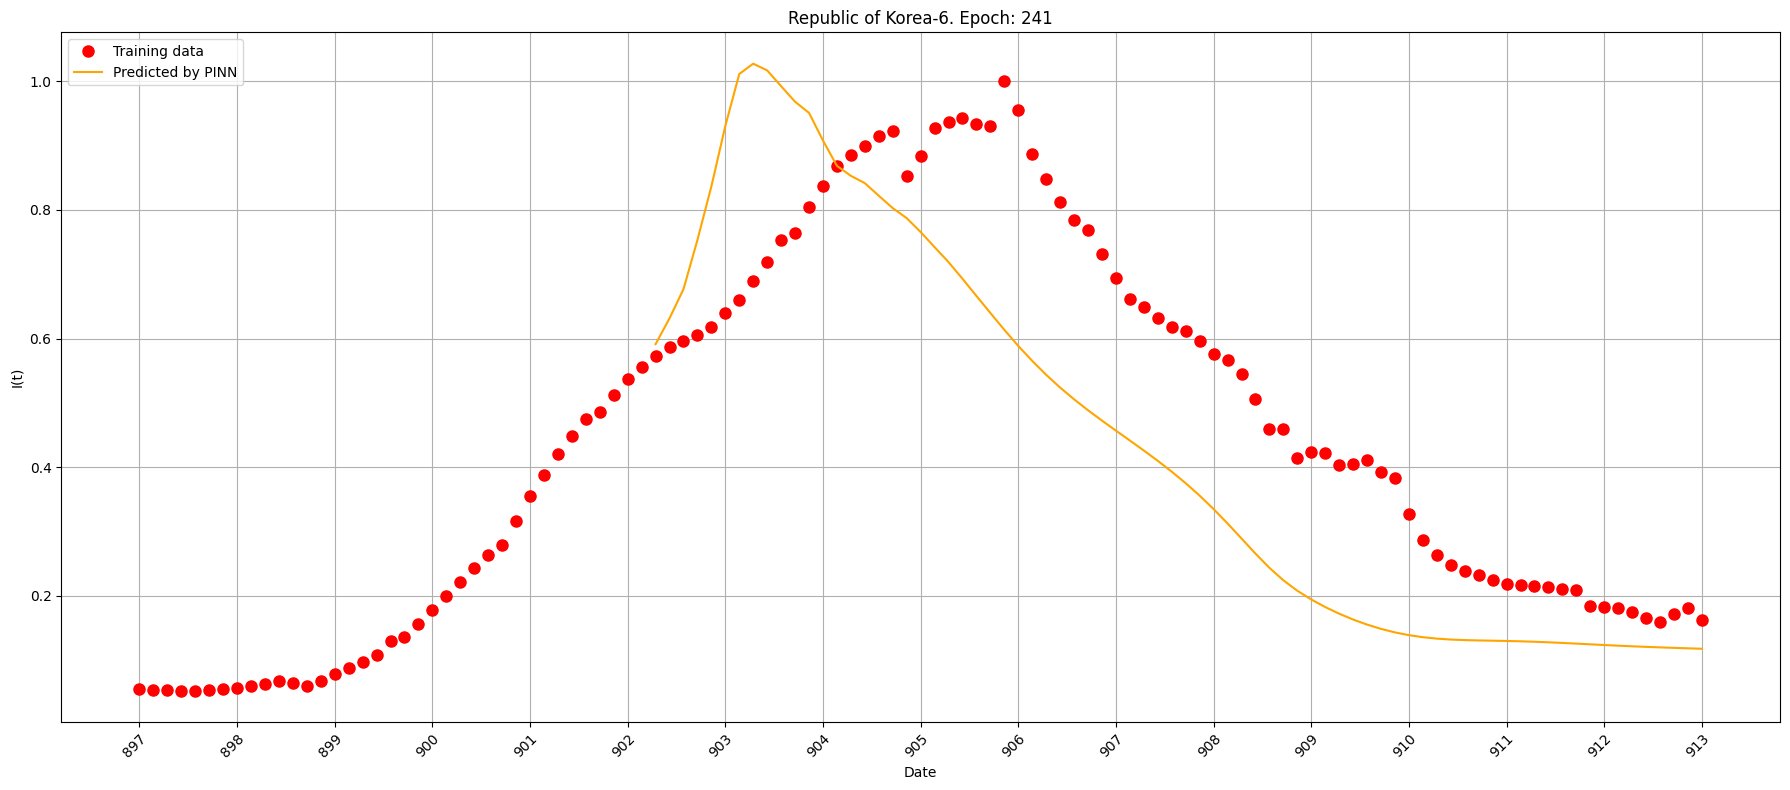

Epoch 241, MSE Loss = 0.0003452315286267549, SIR Loss = 2.0584329054641748e-13, Average Loss = 0.0004632524061904837


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


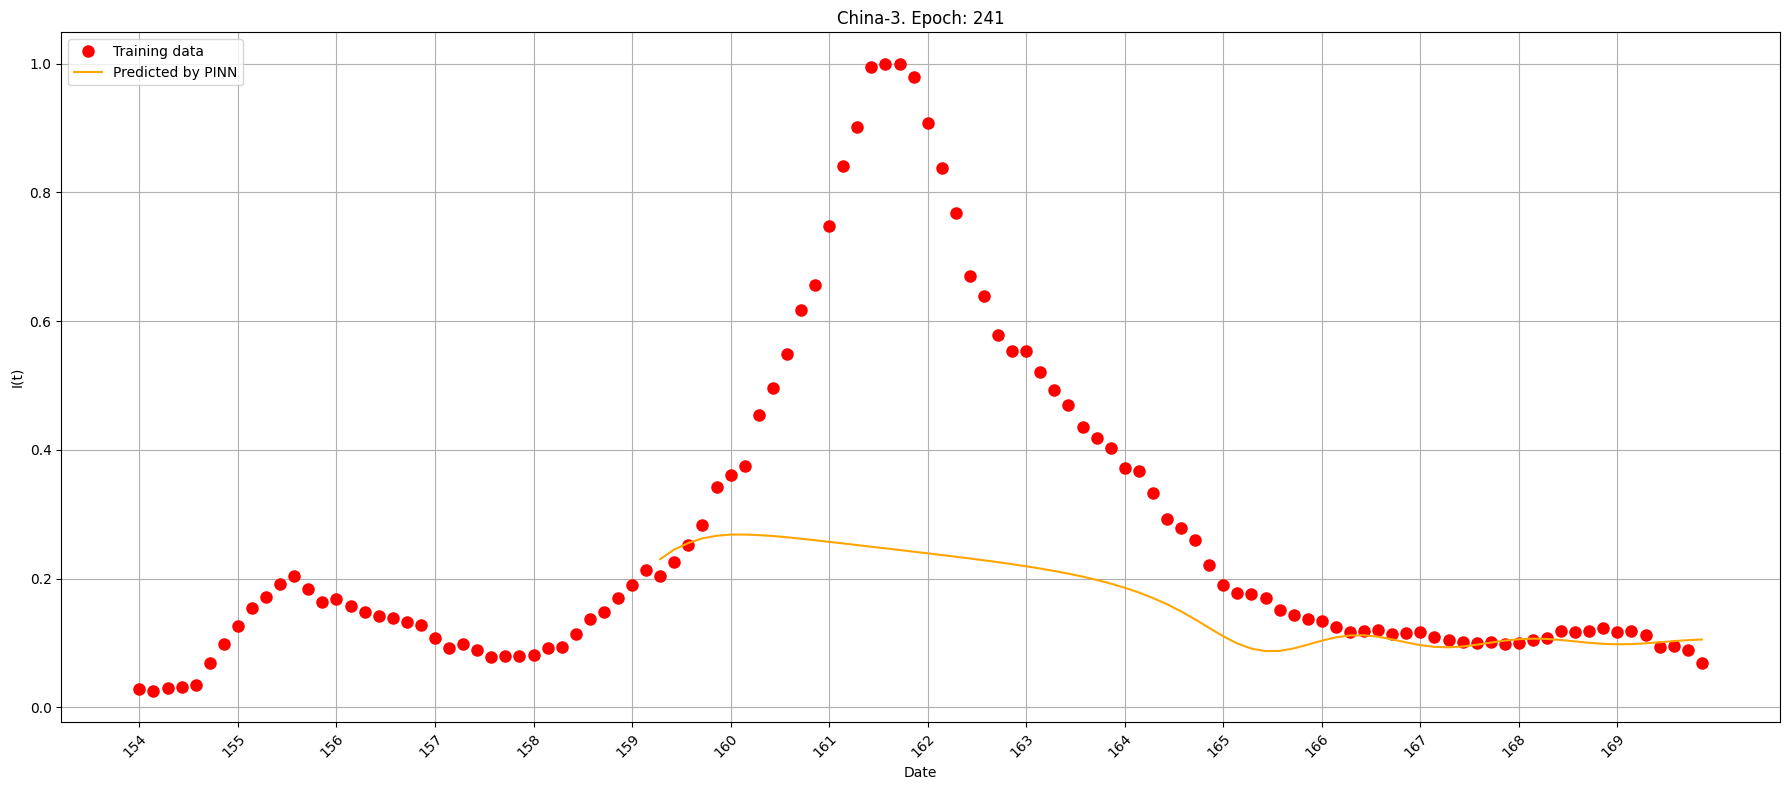

Epoch 241, MSE Loss = 0.00046060277963988483, SIR Loss = 2.359177263266954e-11, Average Loss = 0.0002844450408088524


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


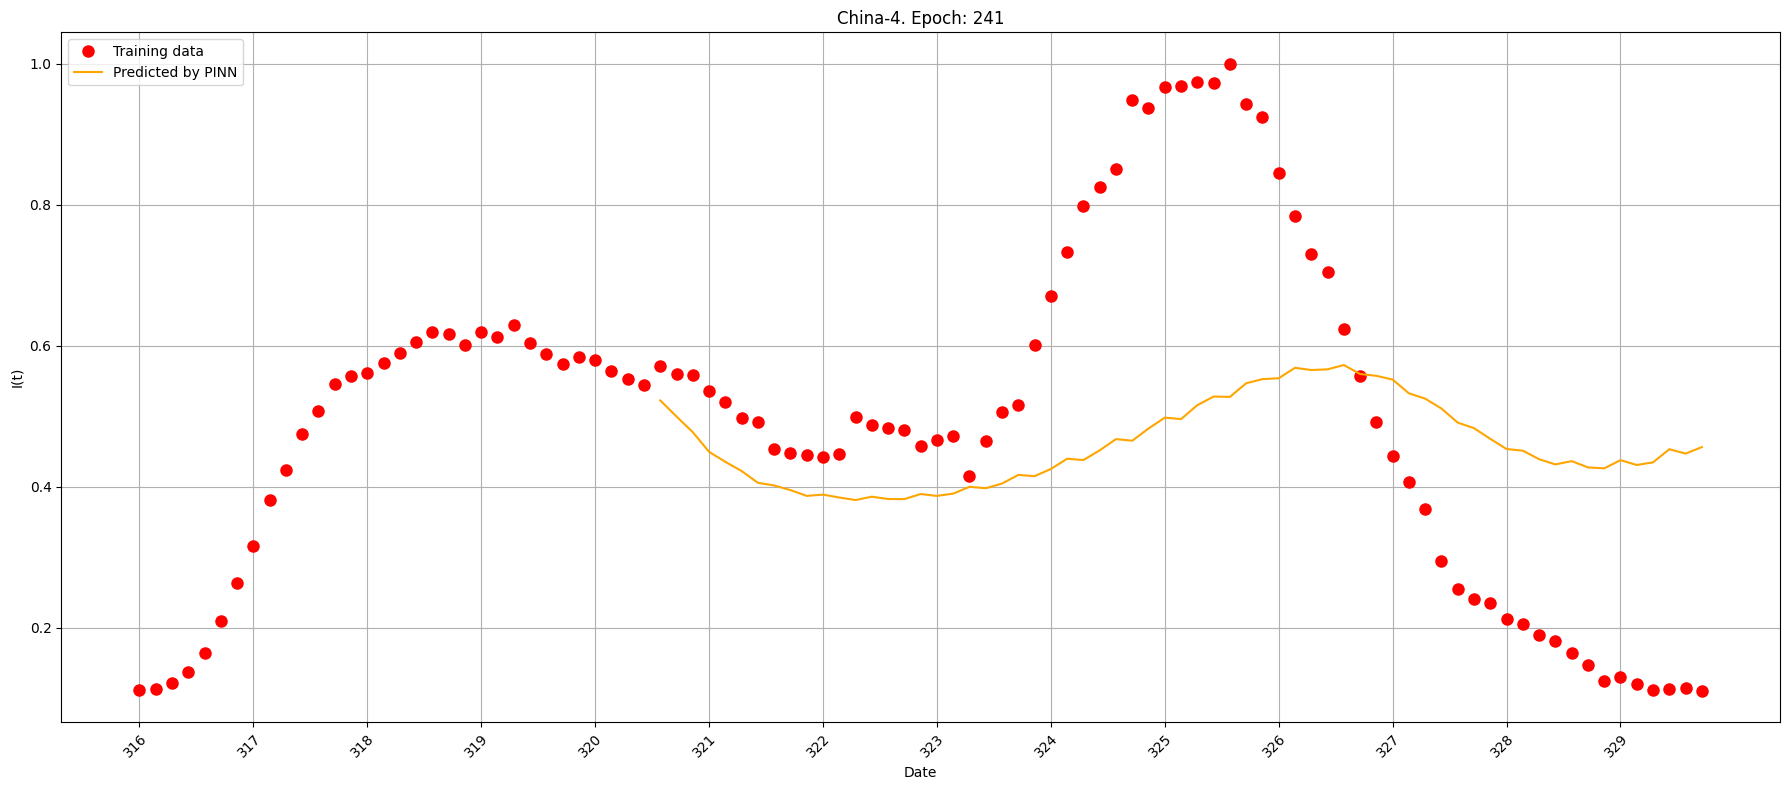

Epoch 241, MSE Loss = 1.459514891166691e-07, SIR Loss = 5.8822551864123884e-12, Average Loss = 0.0009345214897387501


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


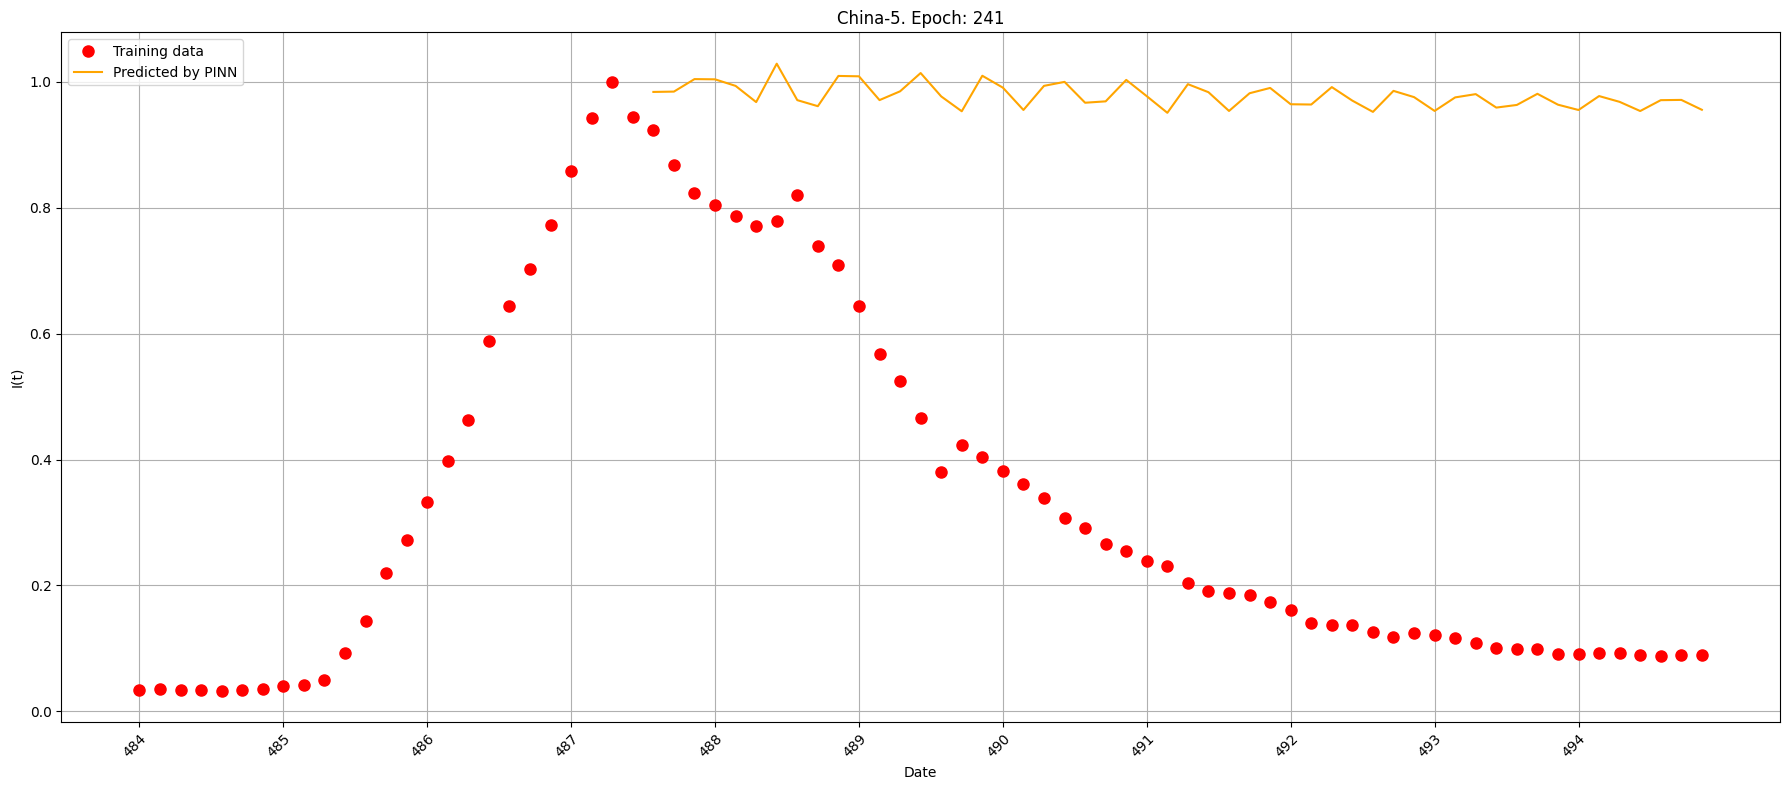

Epoch 241, MSE Loss = 6.58682401990518e-05, SIR Loss = 6.659910904011079e-12, Average Loss = 0.0006784903638788365


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


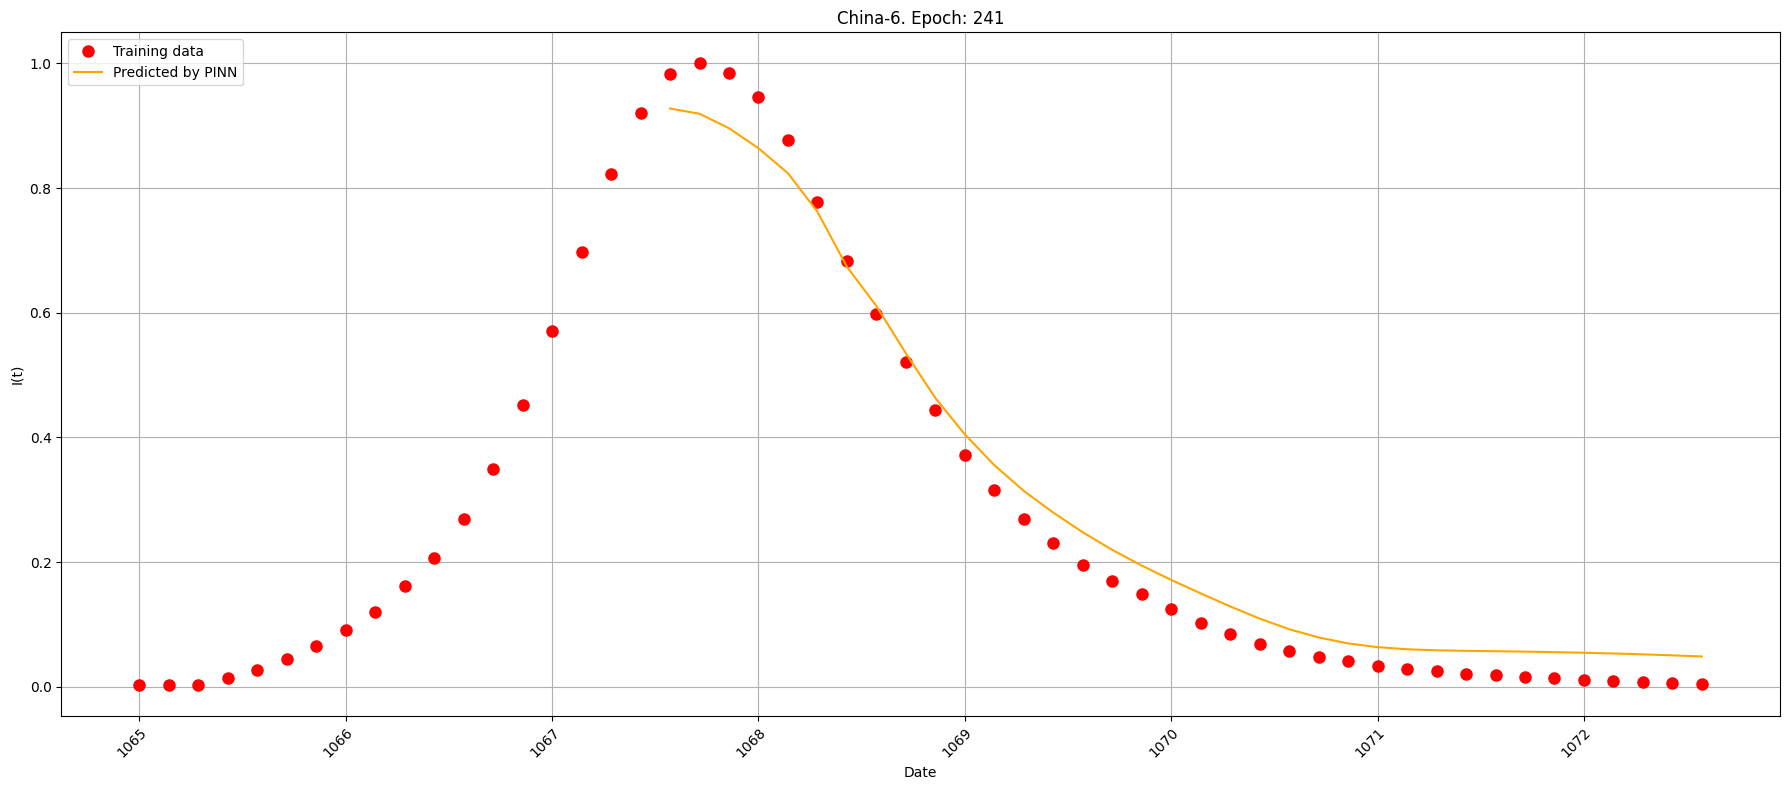

Epoch 241, MSE Loss = 4.025111411465332e-05, SIR Loss = 8.889714966486394e-15, Average Loss = 0.00037484476307481795


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Epoch 251, MSE Loss = 9.40698228077963e-05, SIR Loss = 7.656551836987546e-09, Average Loss = 0.00018142097219905814
Epoch 251, MSE Loss = 7.916043978184462e-05, SIR Loss = 1.3861468396714205e-11, Average Loss = 0.0005366242236641483
Epoch 251, MSE Loss = 8.056700607994571e-06, SIR Loss = 6.182832566238583e-13, Average Loss = 0.0005467109683800825
Epoch 251, MSE Loss = 1.7758125977707095e-05, SIR Loss = 1.9111697562522977e-14, Average Loss = 0.0001749066093646939
Epoch 251, MSE Loss = 0.000434245535871014, SIR Loss = 4.956353151519283e-15, Average Loss = 0.00059704435307143
Epoch 251, MSE Loss = 0.00038366878288798034, SIR Loss = 1.424725463473886e-12, Average Loss = 0.00027219758011878944
Epoch 251, MSE Loss = 1.903759221022483e-05, SIR Loss = 3.114651548827285e-13, Average Loss = 0.0007989481966174011
Epoch 251, MSE Loss = 2.5726192234287737e-06, SIR Loss = 1.2958682521144183e-13, Average Loss = 0.0007529578467884791
Epoch 251, MSE Loss = 0.00011420319060562178, SIR Loss = 7.930164816

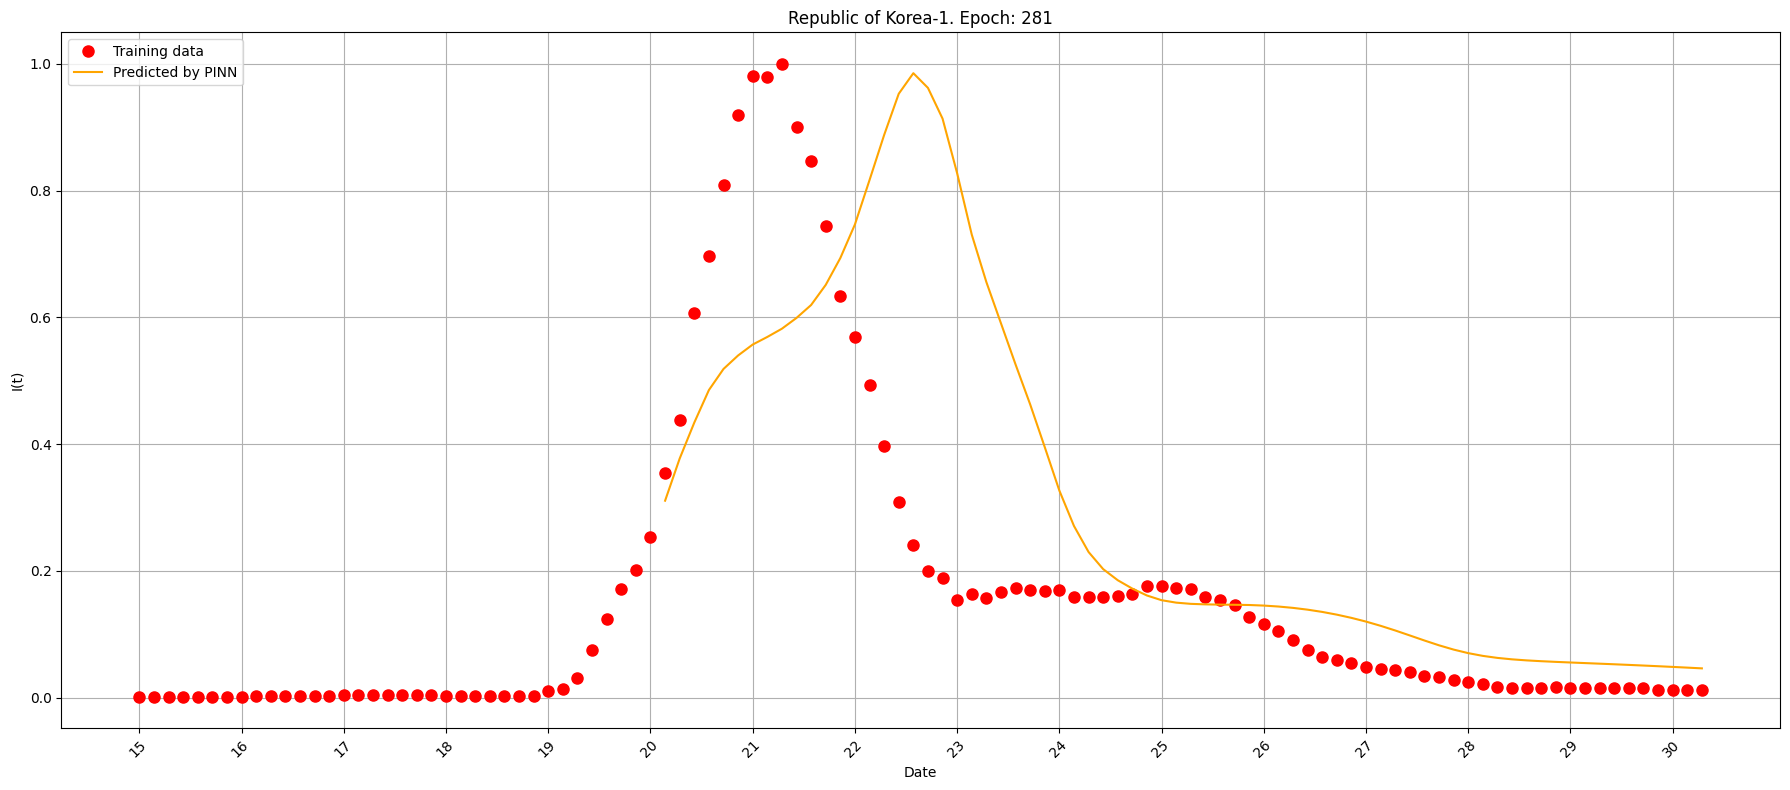

Epoch 281, MSE Loss = 4.0026318259833715e-08, SIR Loss = 2.4135082821175047e-09, Average Loss = 0.0002527747952612212


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


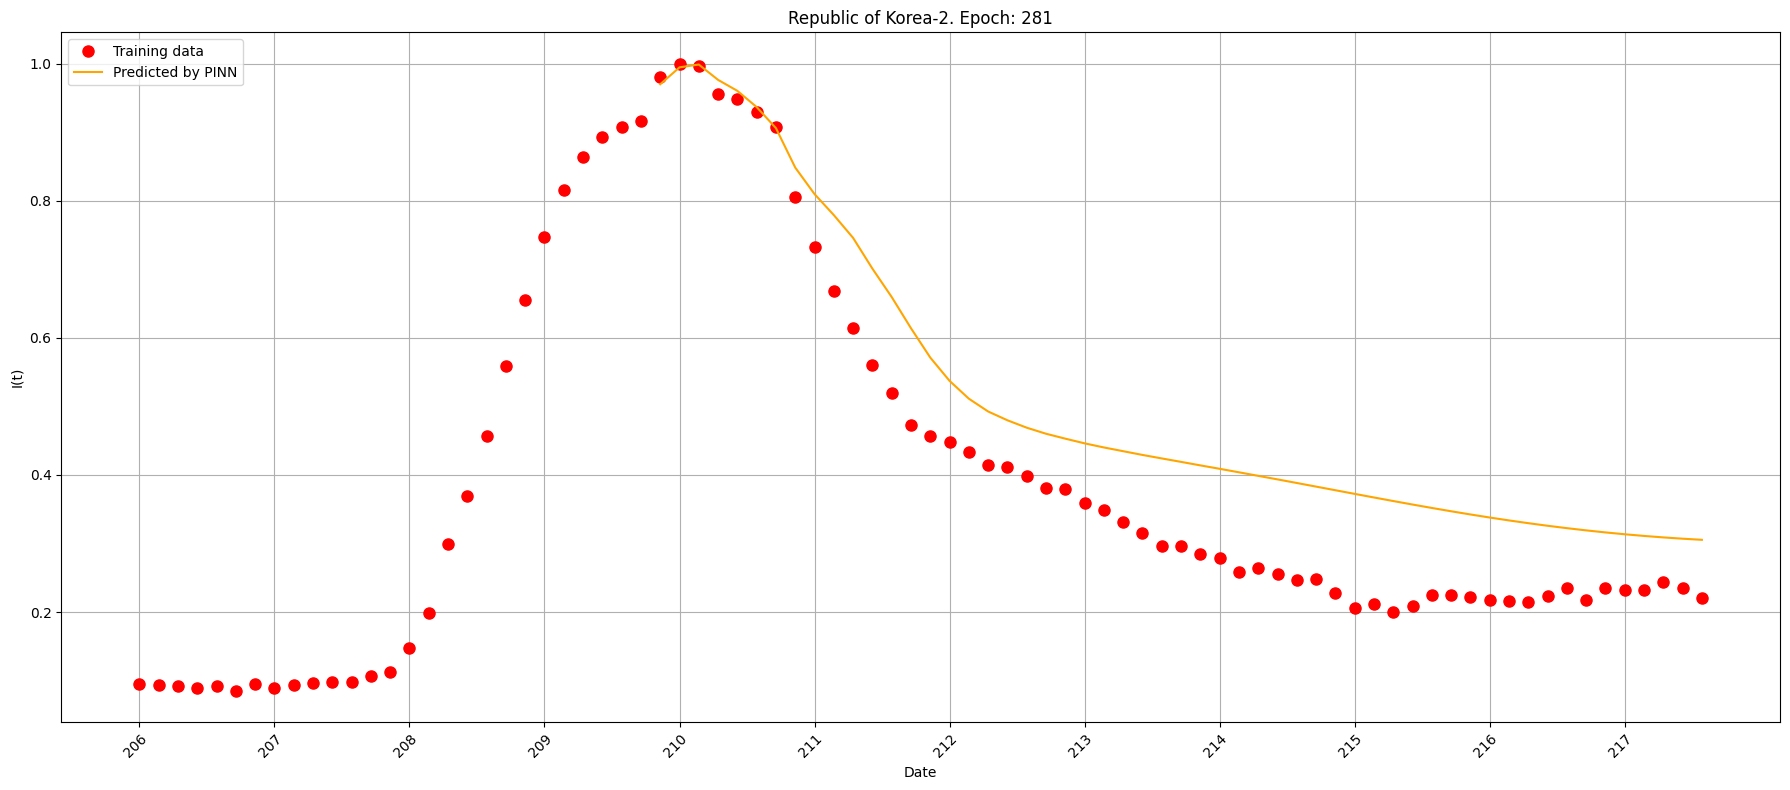

Epoch 281, MSE Loss = 0.00013282471627462655, SIR Loss = 7.171025925845065e-12, Average Loss = 0.0003397263669952129


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


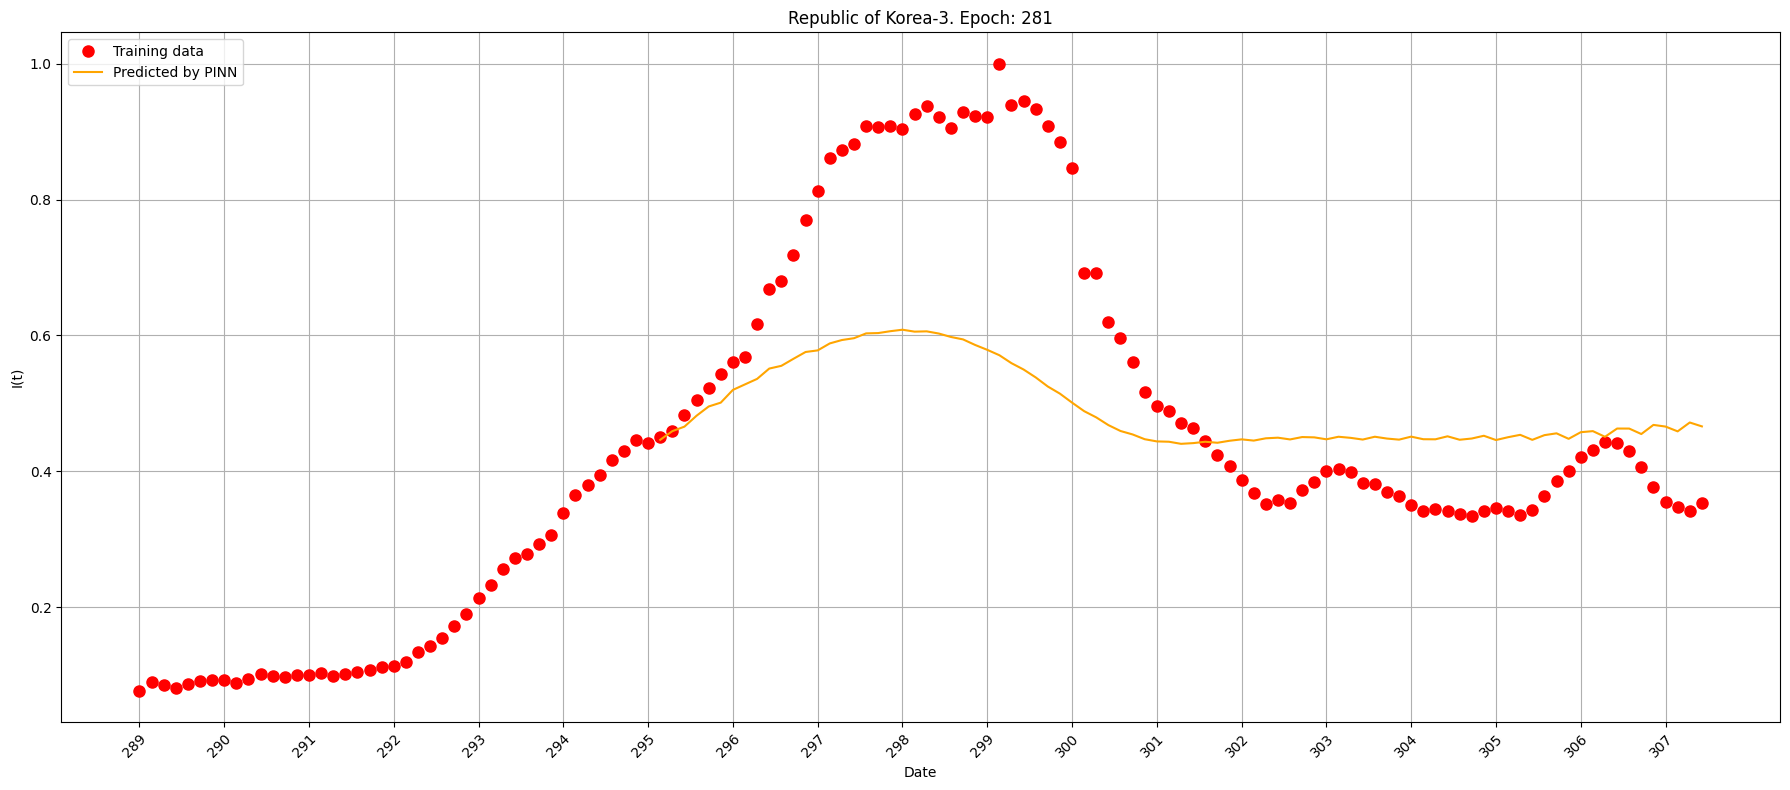

Epoch 281, MSE Loss = 2.244443749077618e-05, SIR Loss = 9.359830618893561e-12, Average Loss = 0.00047889715483048924


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


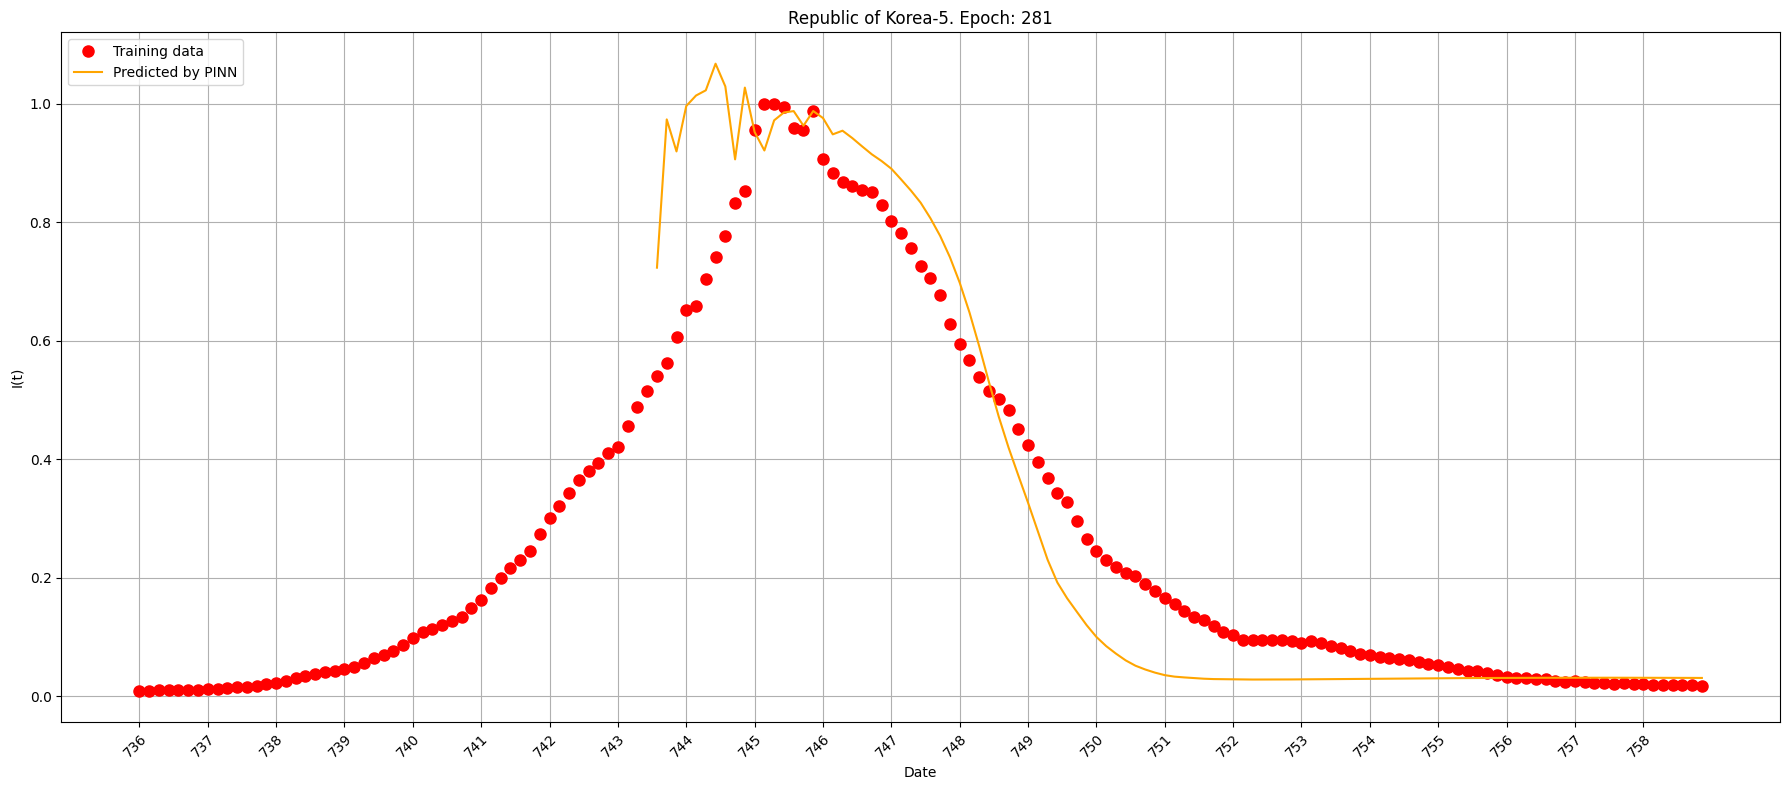

Epoch 281, MSE Loss = 4.3689470885510673e-07, SIR Loss = 2.2842680438145413e-12, Average Loss = 0.00018361246512753283


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


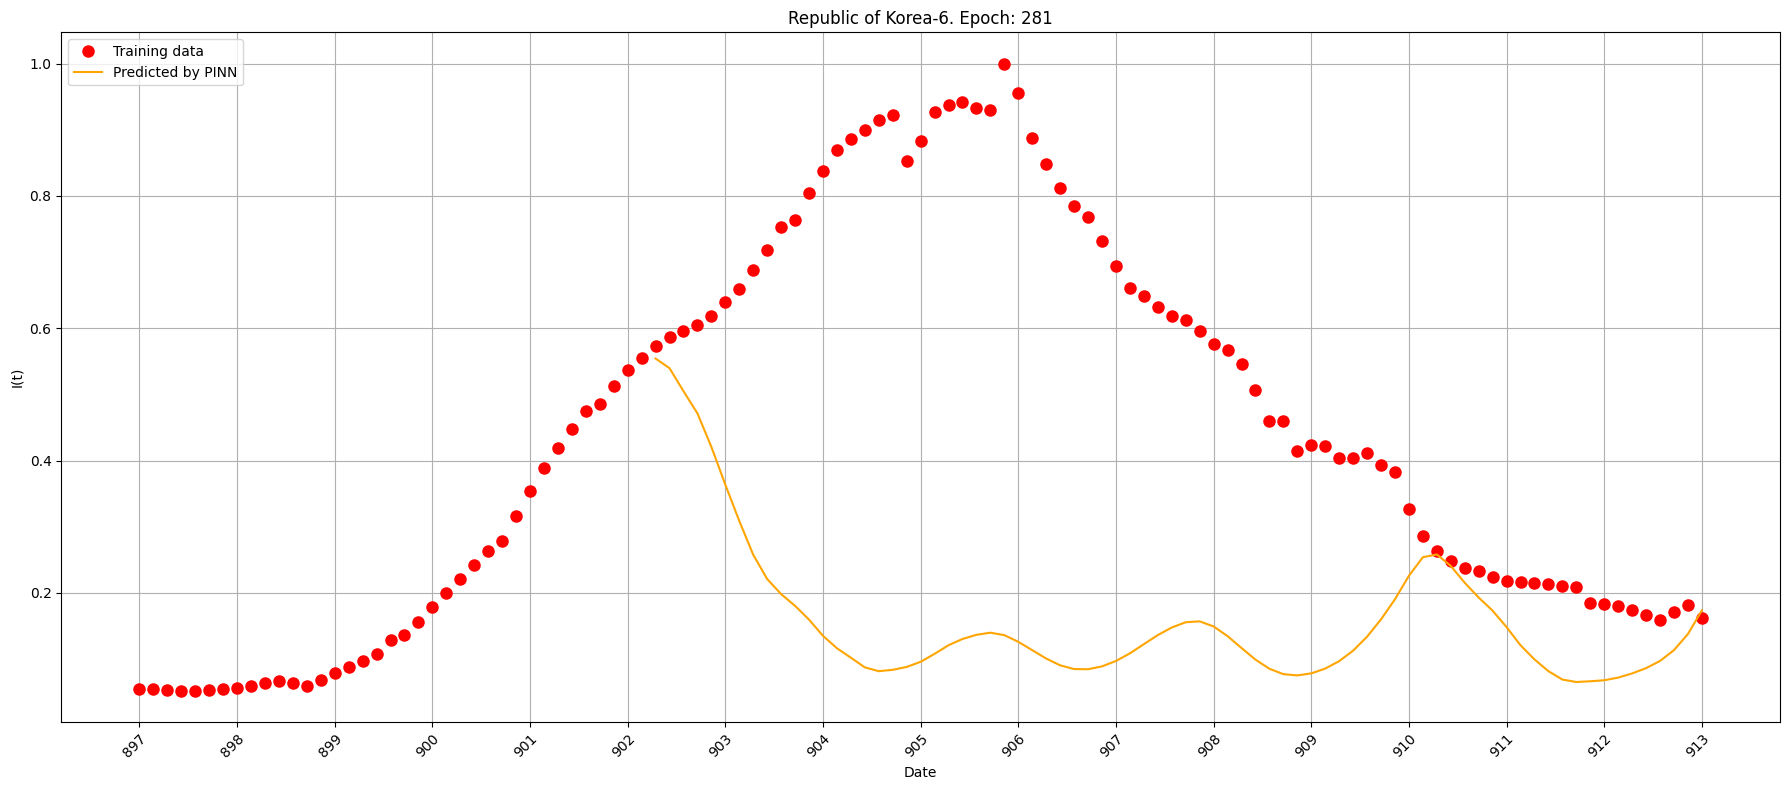

Epoch 281, MSE Loss = 0.0002560649299994111, SIR Loss = 3.8983104396449197e-13, Average Loss = 0.00044710095490975703


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


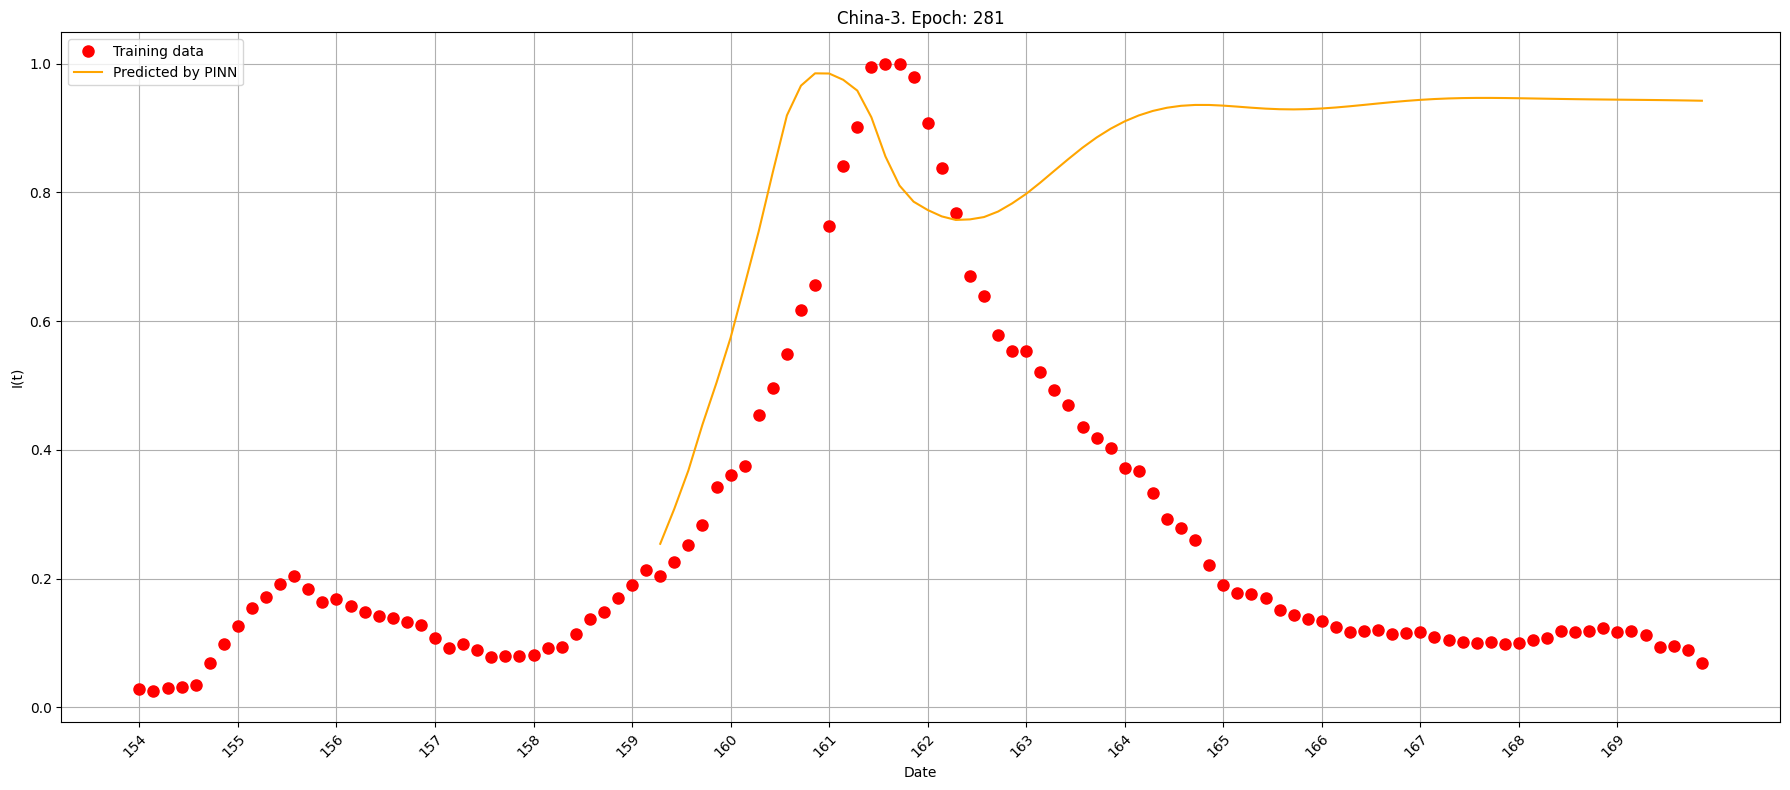

Epoch 281, MSE Loss = 0.0002876977960113436, SIR Loss = 5.684597237376465e-10, Average Loss = 0.0002406436242808399


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


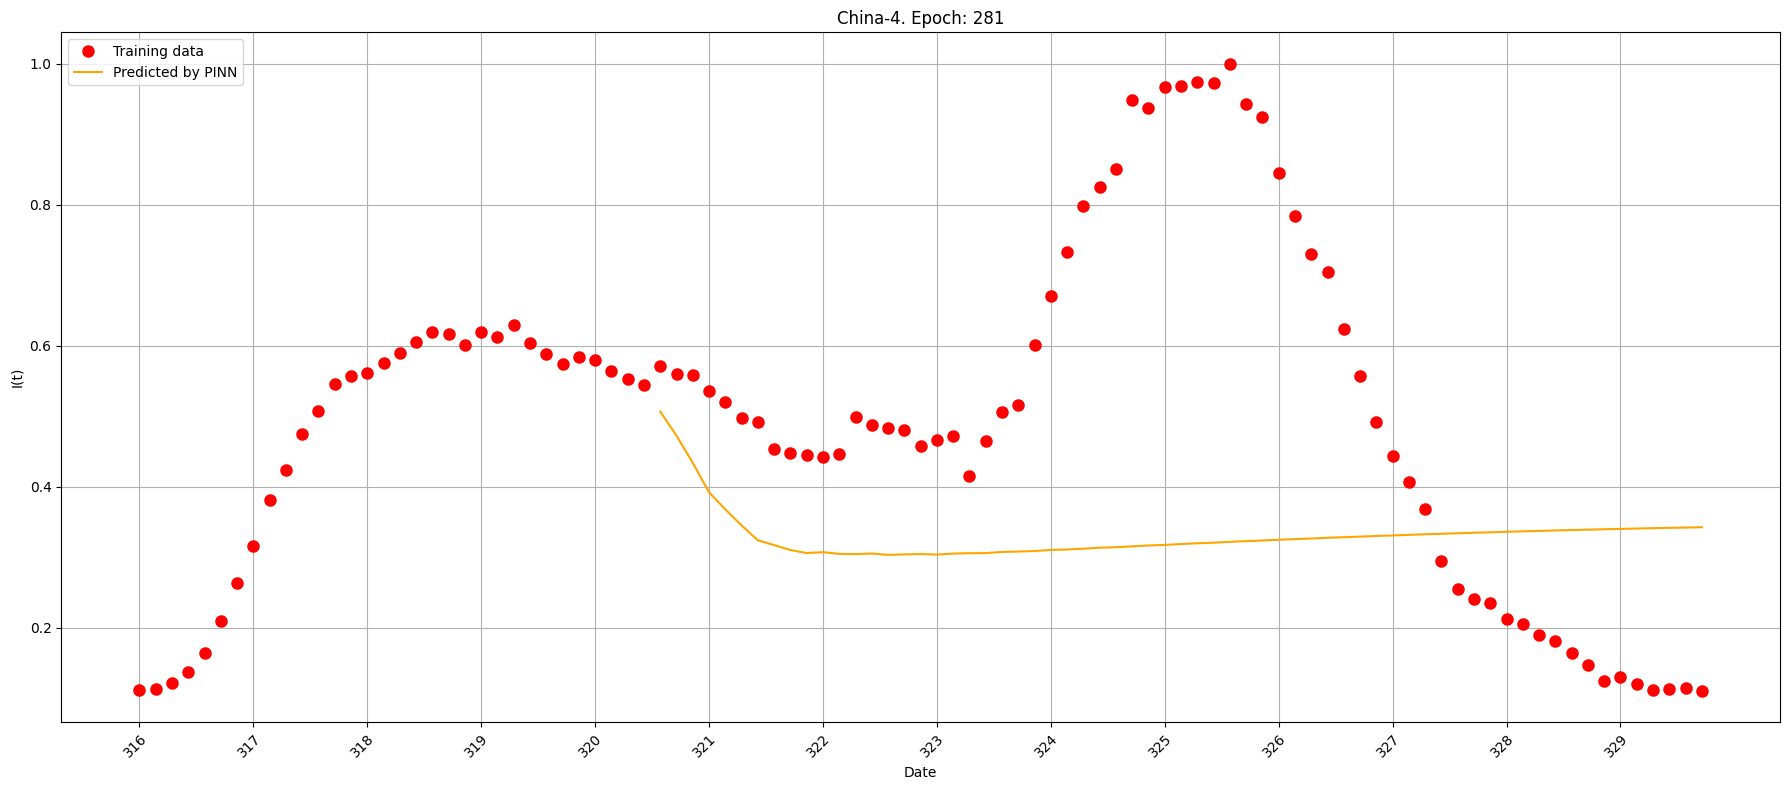

Epoch 281, MSE Loss = 1.5964798876666464e-05, SIR Loss = 1.574658806124951e-11, Average Loss = 0.0004716990789773945


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


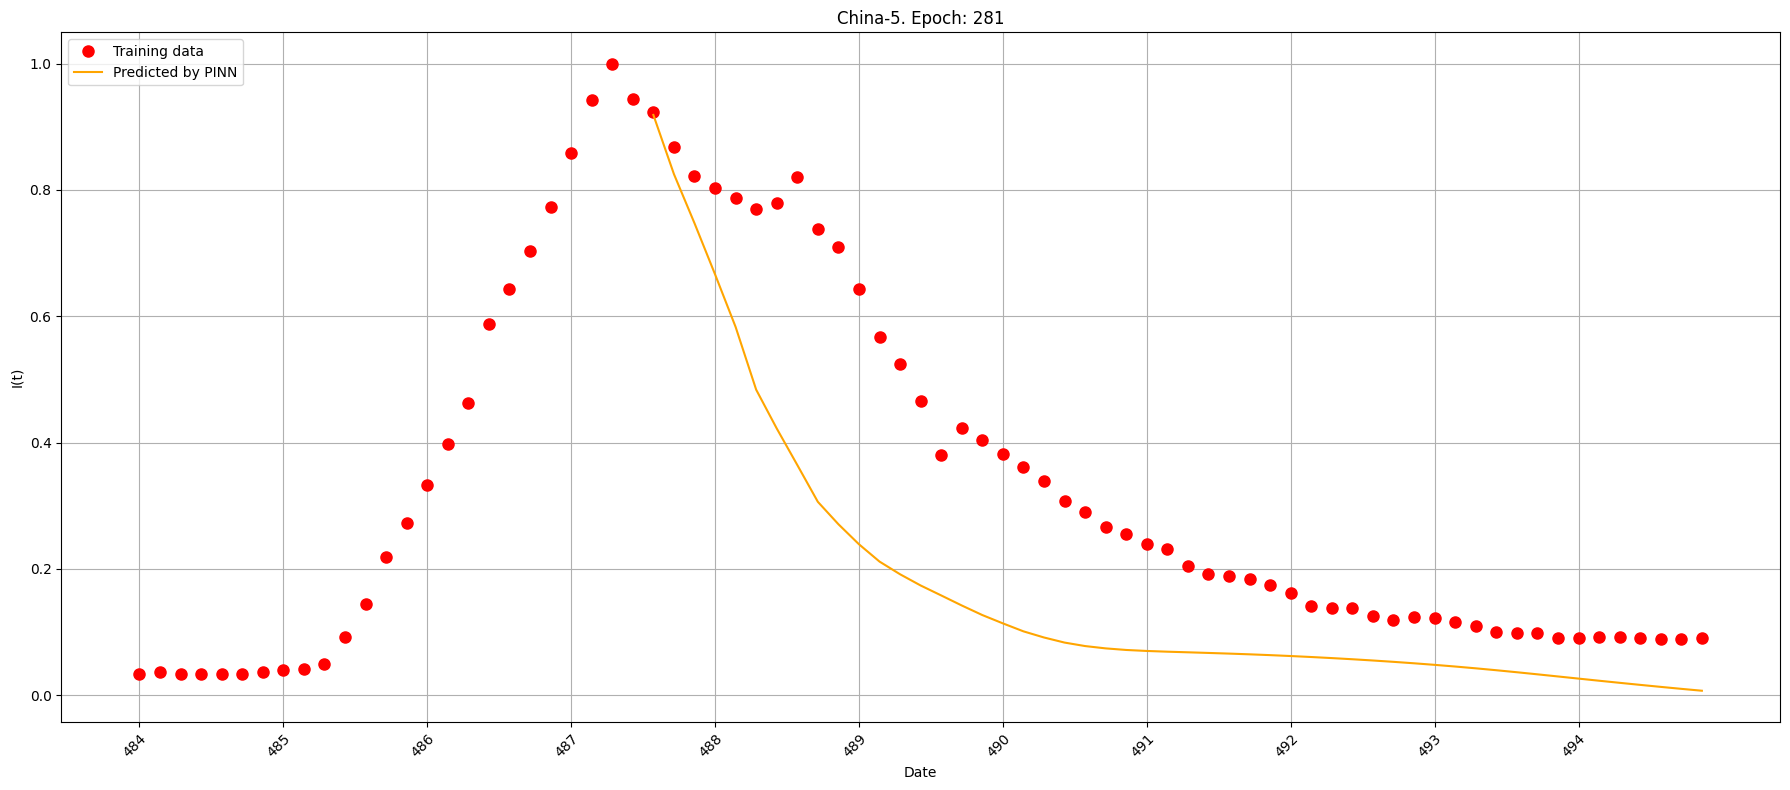

Epoch 281, MSE Loss = 2.4087907149805687e-05, SIR Loss = 3.431422030200637e-12, Average Loss = 0.0005195762975144394


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


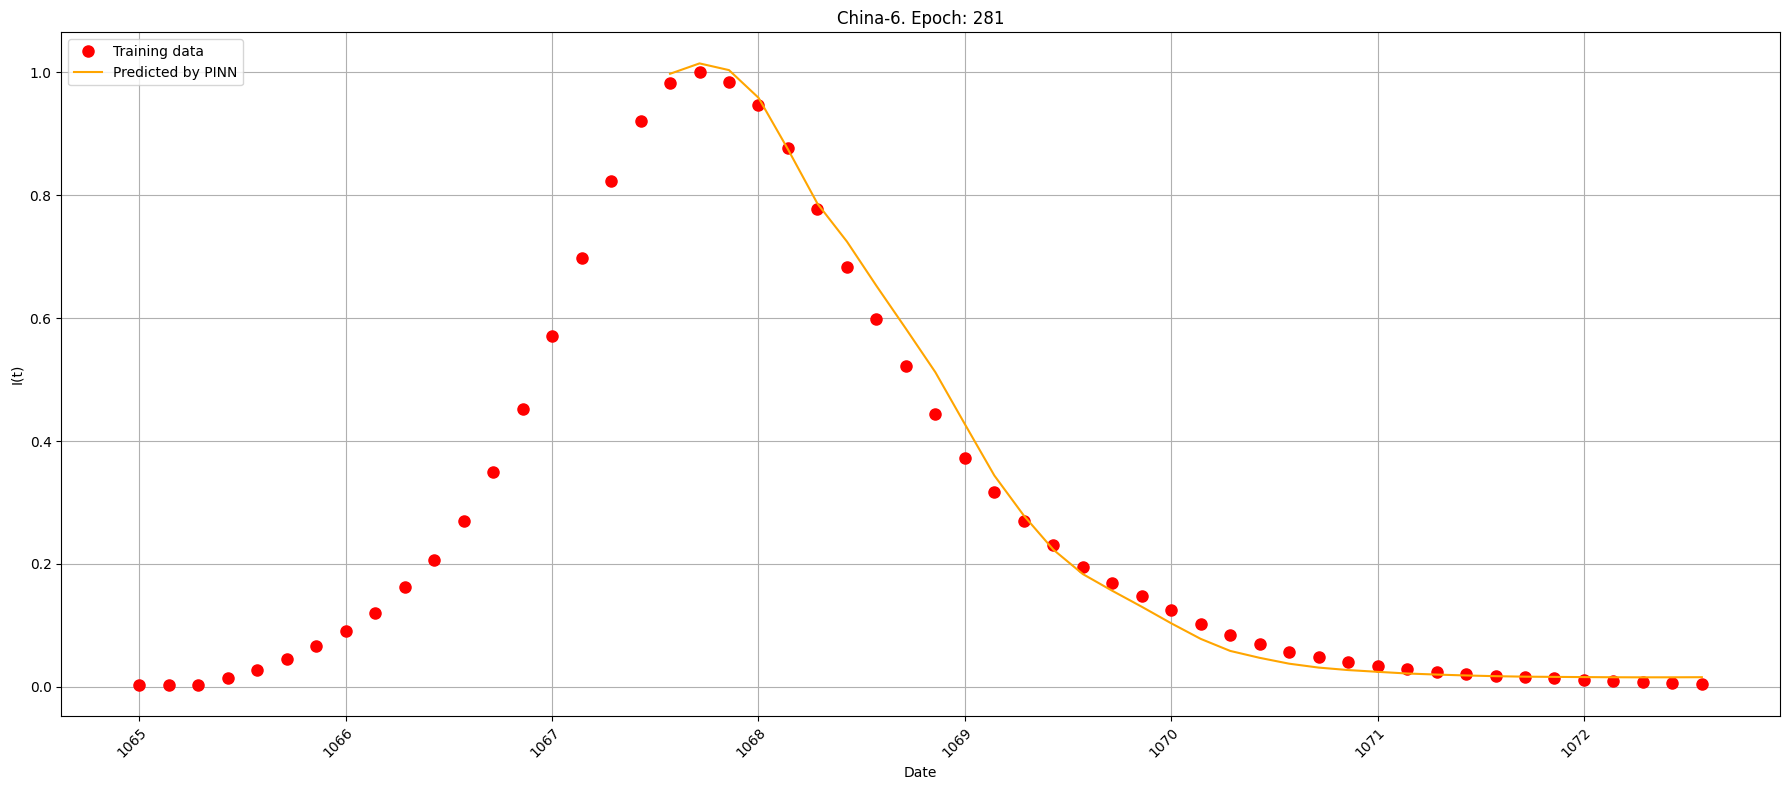

Epoch 281, MSE Loss = 0.00012582266936078668, SIR Loss = 4.652548420309988e-13, Average Loss = 0.0003720472525885193


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Epoch 291, MSE Loss = 4.857874813524177e-08, SIR Loss = 3.6949798776220177e-09, Average Loss = 0.00011245964011366874
Epoch 291, MSE Loss = 0.00022940589406061918, SIR Loss = 7.720703520952554e-10, Average Loss = 0.00026194255591717246
Epoch 291, MSE Loss = 5.93720415054122e-06, SIR Loss = 3.2687585277413334e-12, Average Loss = 0.00046967787926037804
Epoch 291, MSE Loss = 9.909238087857375e-07, SIR Loss = 2.7148602376597664e-12, Average Loss = 0.000191405049378606
Epoch 291, MSE Loss = 0.0001692250807536766, SIR Loss = 3.9548676833423e-11, Average Loss = 0.0003627354099147204
Epoch 291, MSE Loss = 0.00024161746841855347, SIR Loss = 4.5748813626289575e-09, Average Loss = 0.0004467320063129353
Epoch 291, MSE Loss = 0.0001522195670986548, SIR Loss = 1.696287416086406e-10, Average Loss = 0.00032431545436253375
Epoch 291, MSE Loss = 2.8380231924529653e-06, SIR Loss = 1.3123074675547297e-11, Average Loss = 0.0005543733558409235
Epoch 291, MSE Loss = 3.755143188755028e-05, SIR Loss = 0.0, Ave

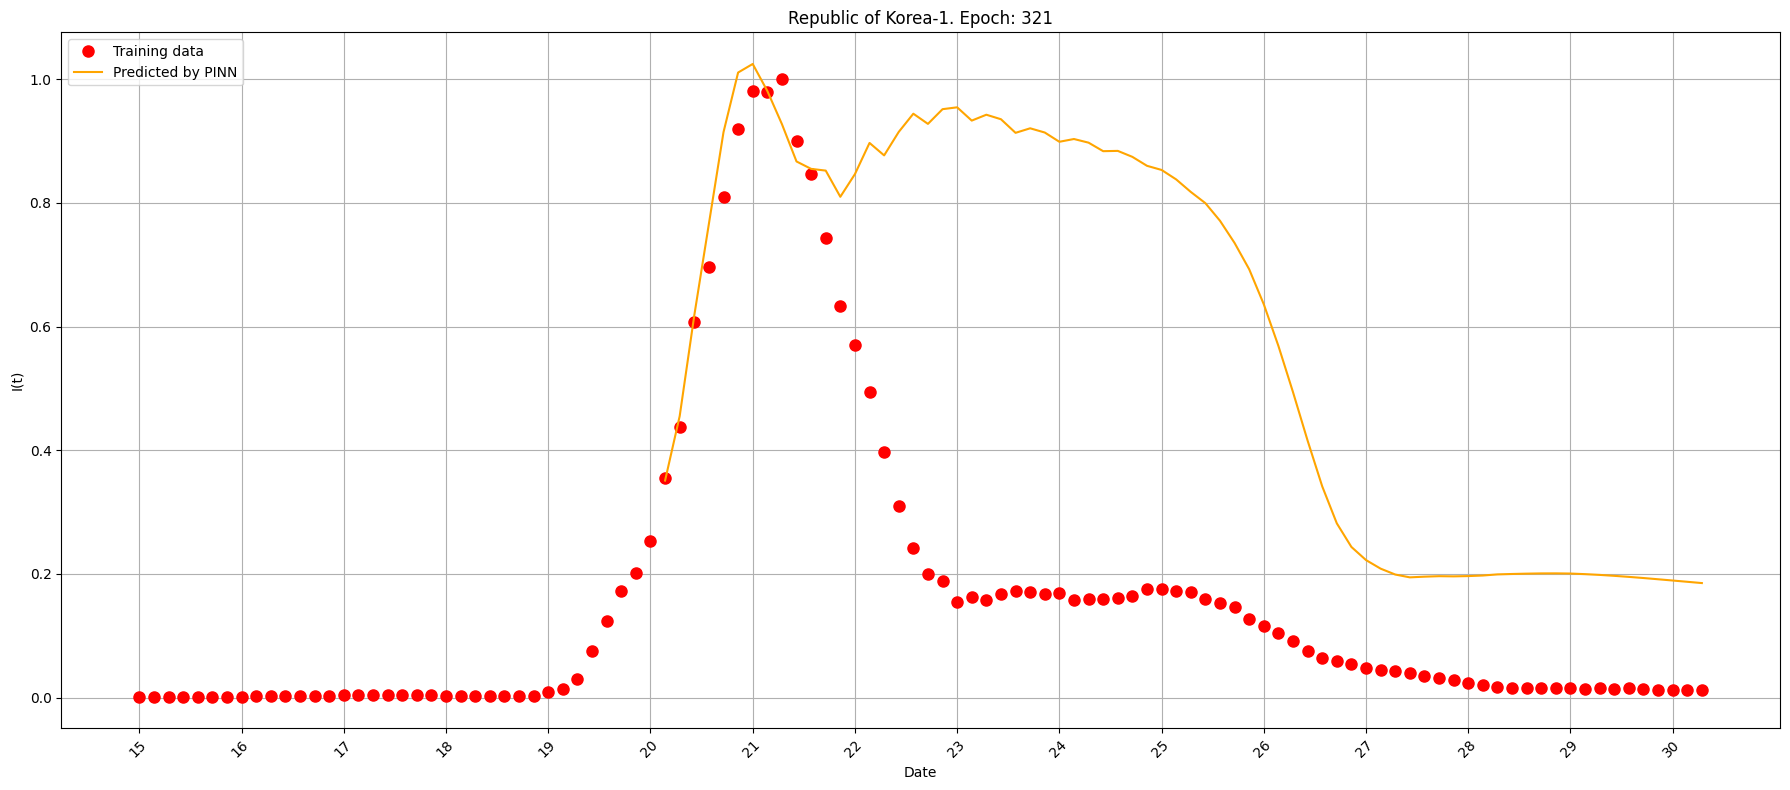

Epoch 321, MSE Loss = 4.935482138535008e-05, SIR Loss = 1.0490522339701158e-10, Average Loss = 9.093539972212879e-05


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


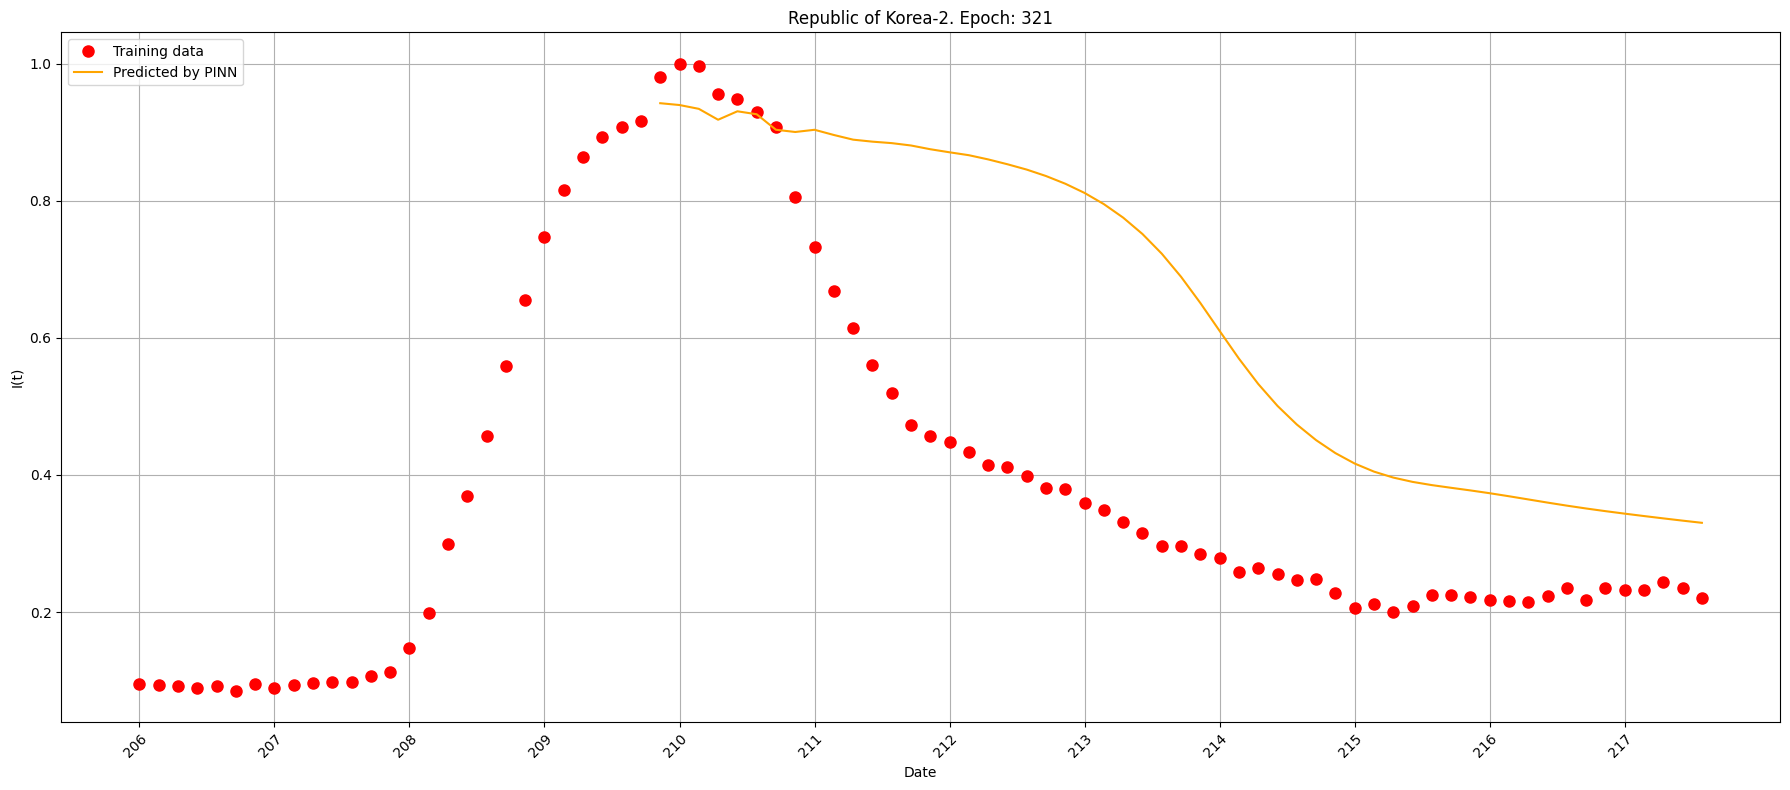

Epoch 321, MSE Loss = 0.0008457679650746286, SIR Loss = 4.734601599665211e-12, Average Loss = 0.00039722952446557733


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


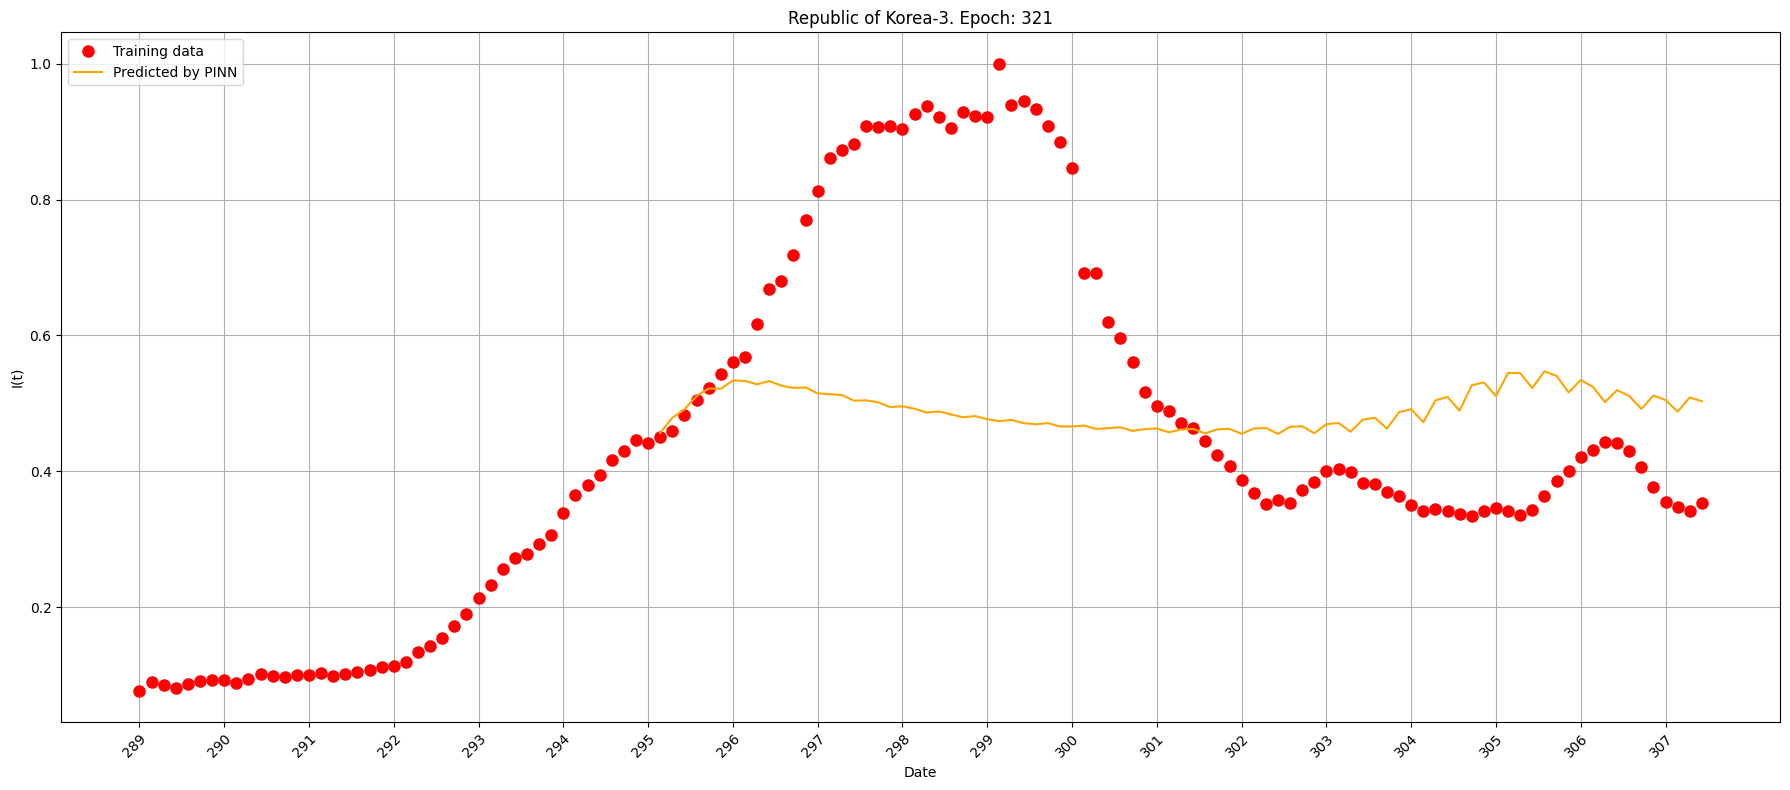

Epoch 321, MSE Loss = 0.00020902171672787517, SIR Loss = 1.3186508308893341e-11, Average Loss = 0.0003574123308364558


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


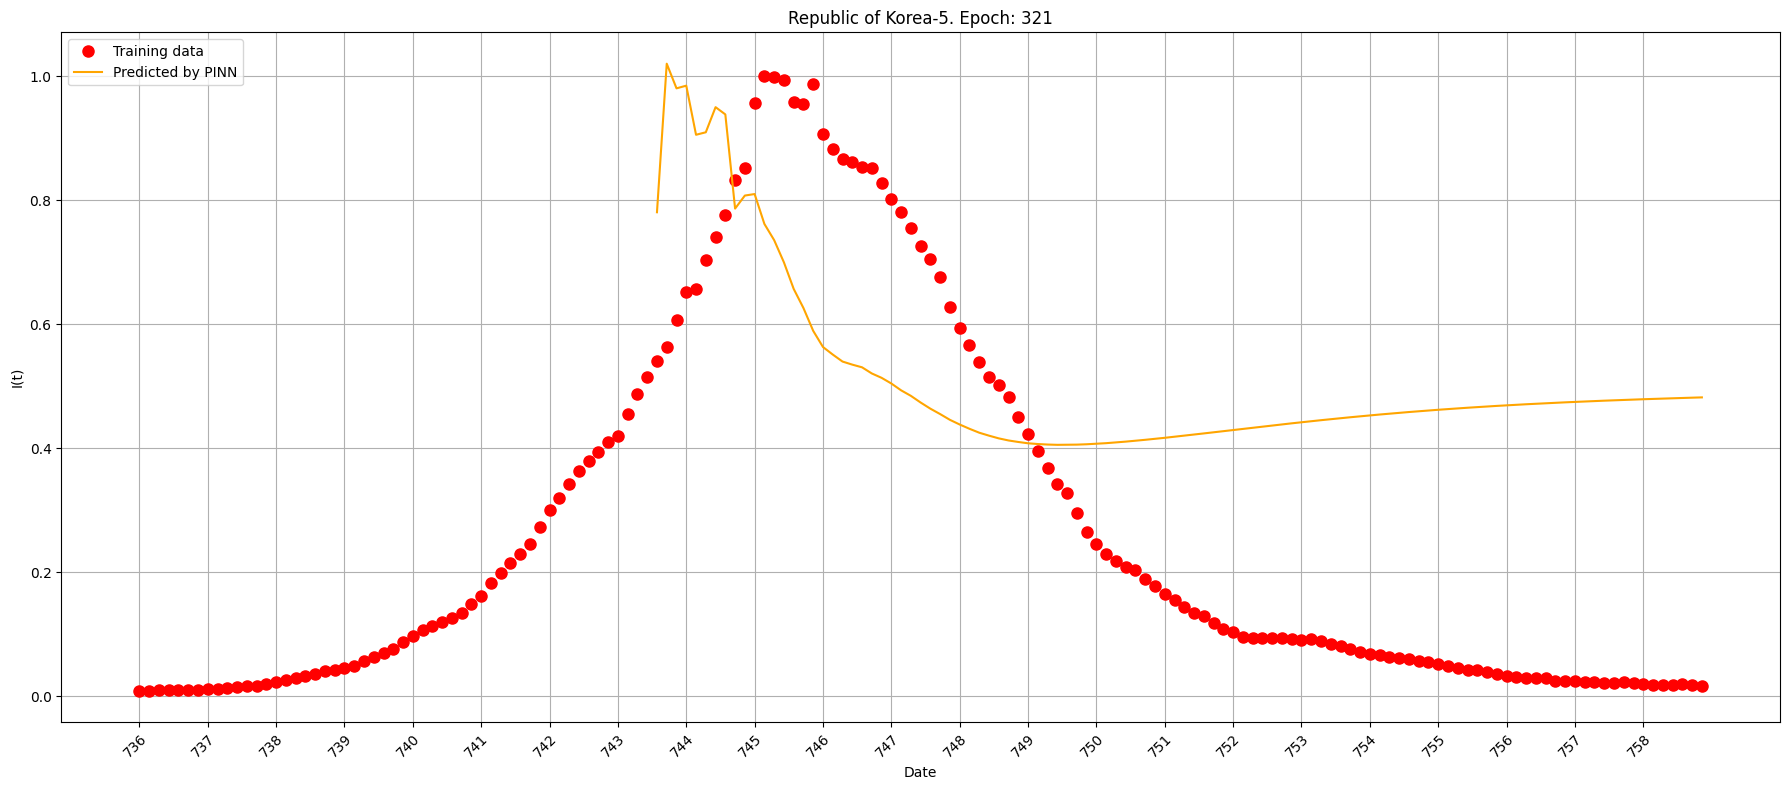

Epoch 321, MSE Loss = 1.6405762153226533e-06, SIR Loss = 1.7842871456642494e-17, Average Loss = 0.00017964421496358056


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


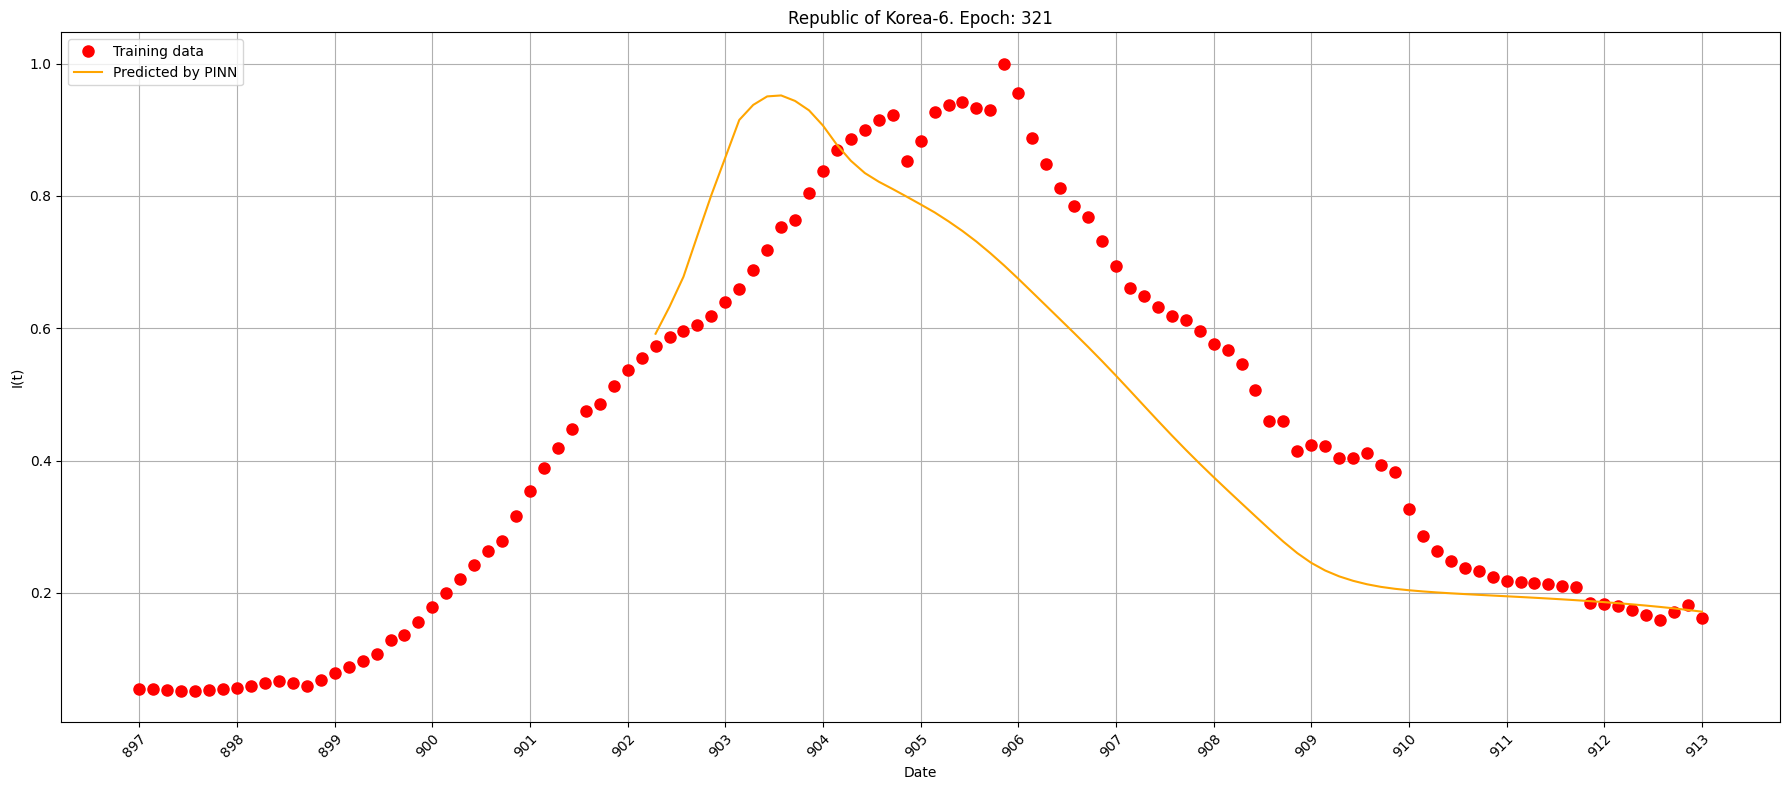

Epoch 321, MSE Loss = 9.51678812270984e-05, SIR Loss = 1.8834141541668891e-16, Average Loss = 0.0004526144178953808


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


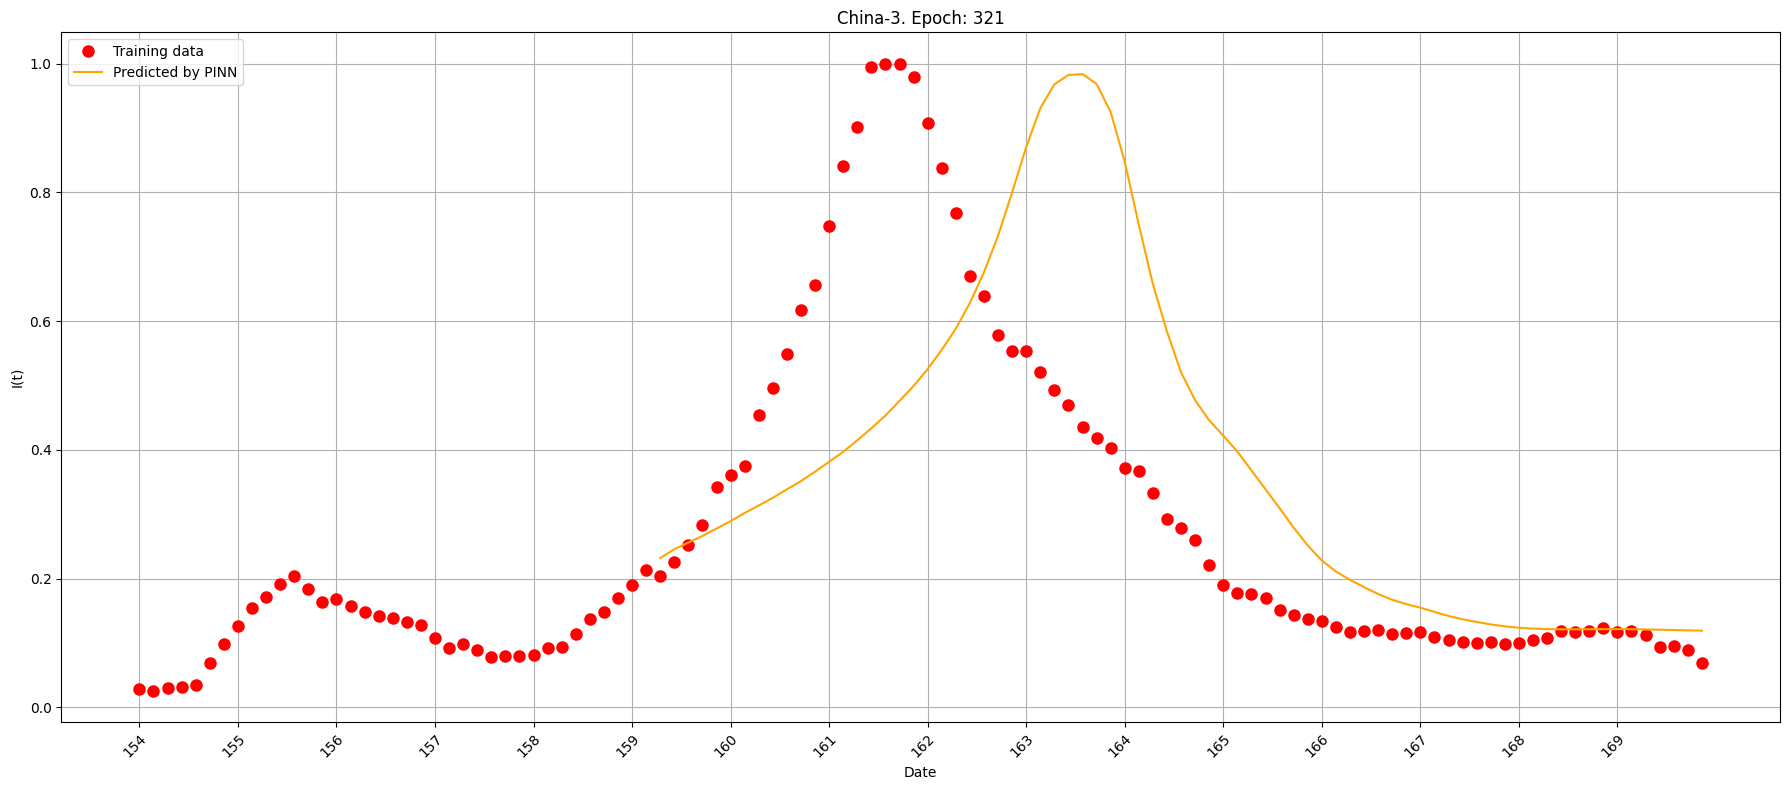

Epoch 321, MSE Loss = 0.00016913573199417442, SIR Loss = 4.524853755571989e-11, Average Loss = 0.00023437319528454503


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


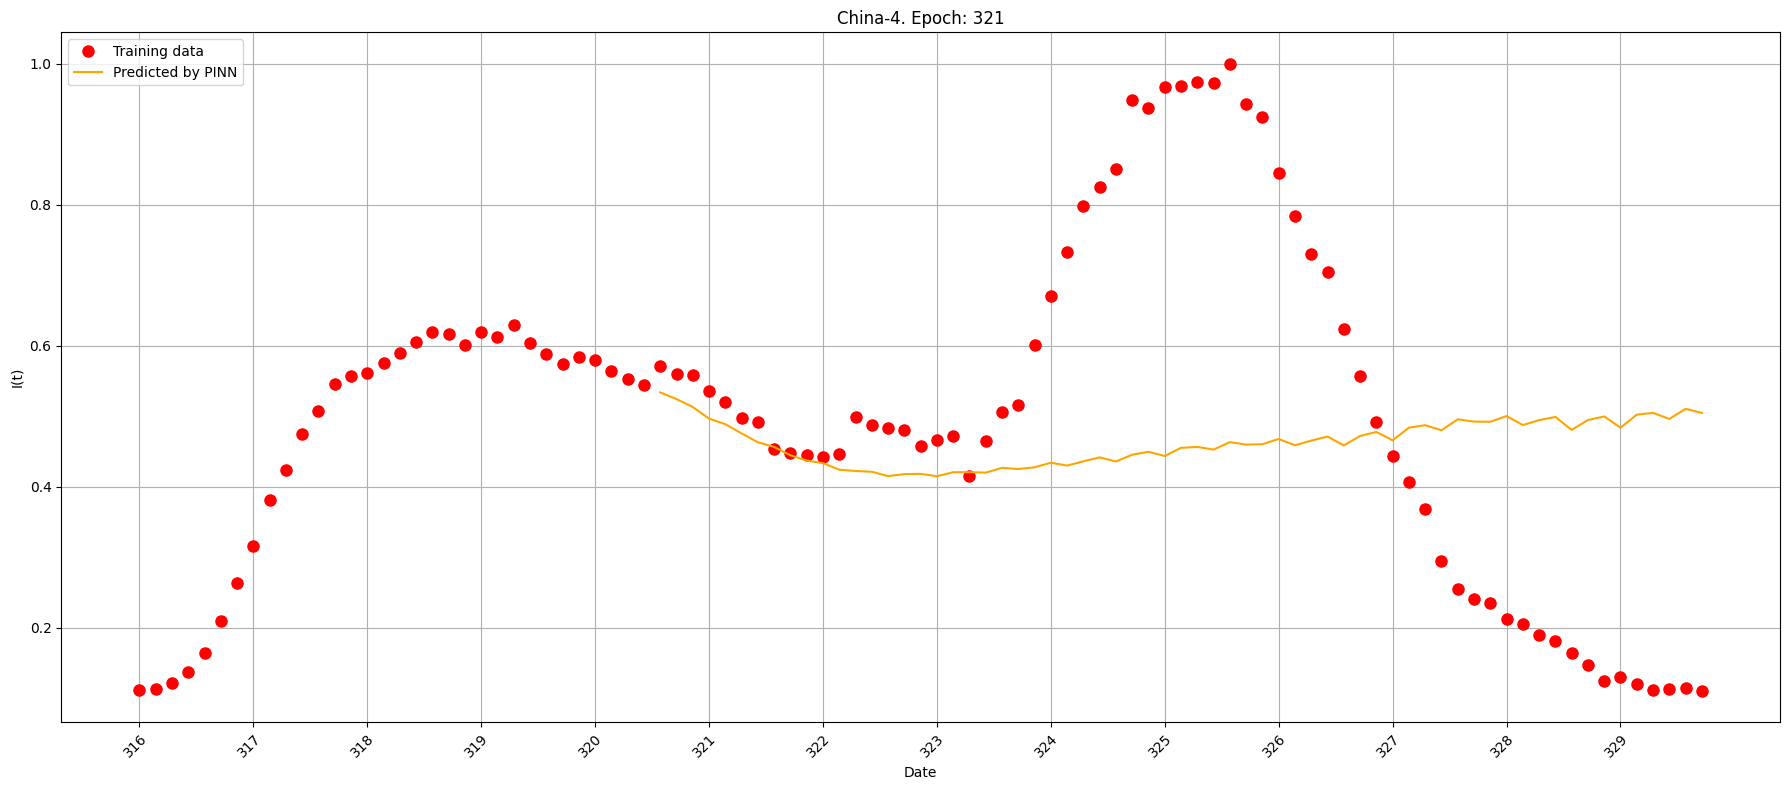

Epoch 321, MSE Loss = 2.3705147214059252e-06, SIR Loss = 1.7226796161437519e-12, Average Loss = 0.00036215729370465196


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


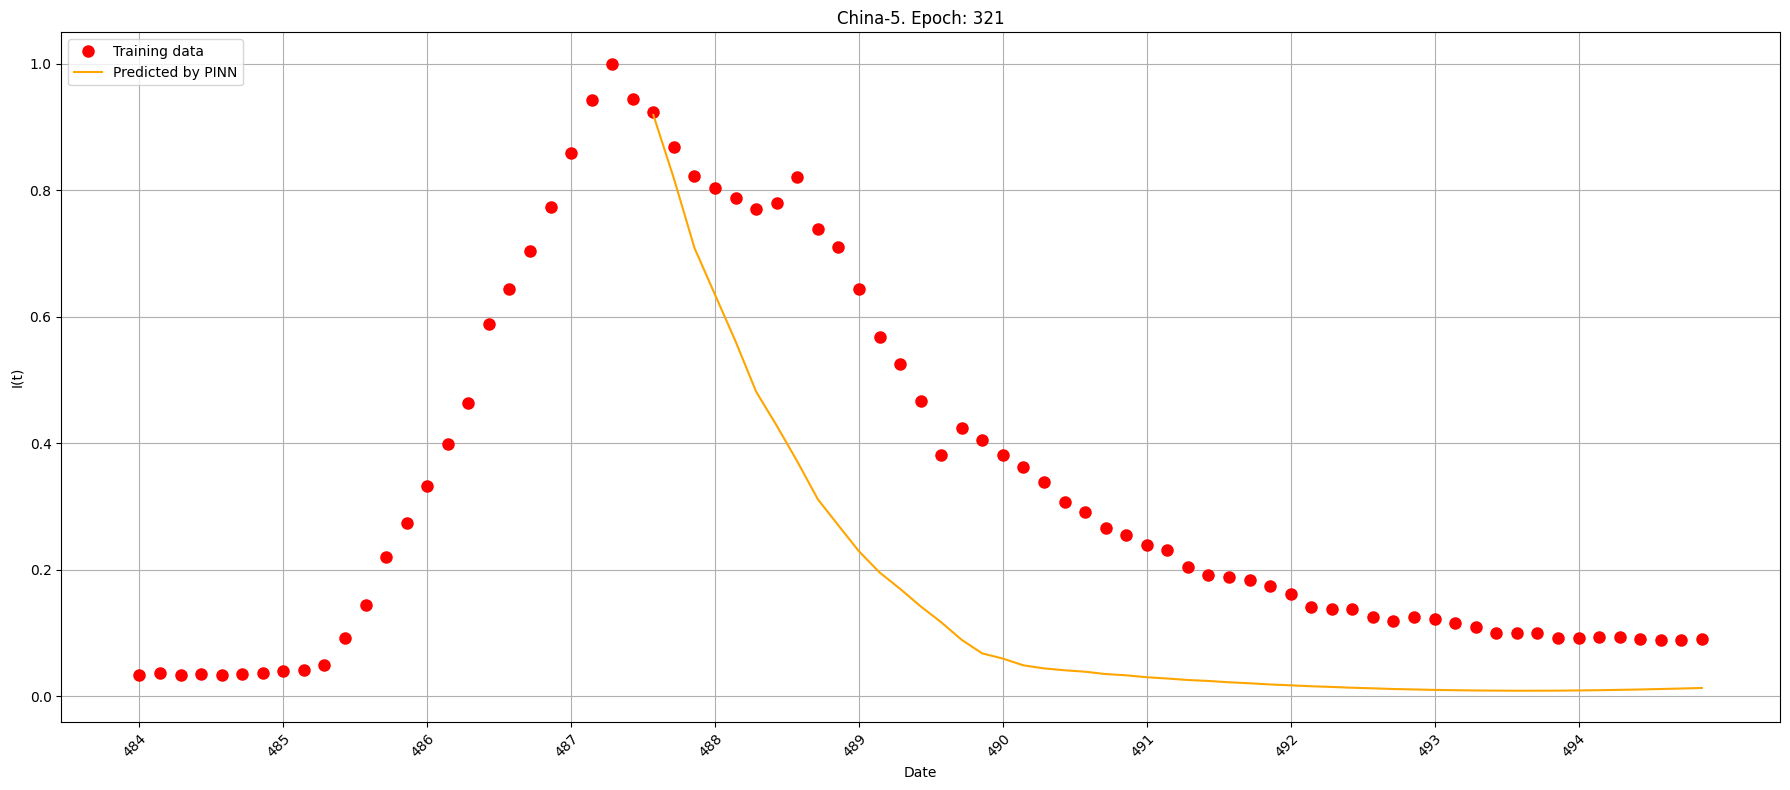

Epoch 321, MSE Loss = 2.6719297238742e-05, SIR Loss = 1.159441683287743e-12, Average Loss = 0.00047277043774508954


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


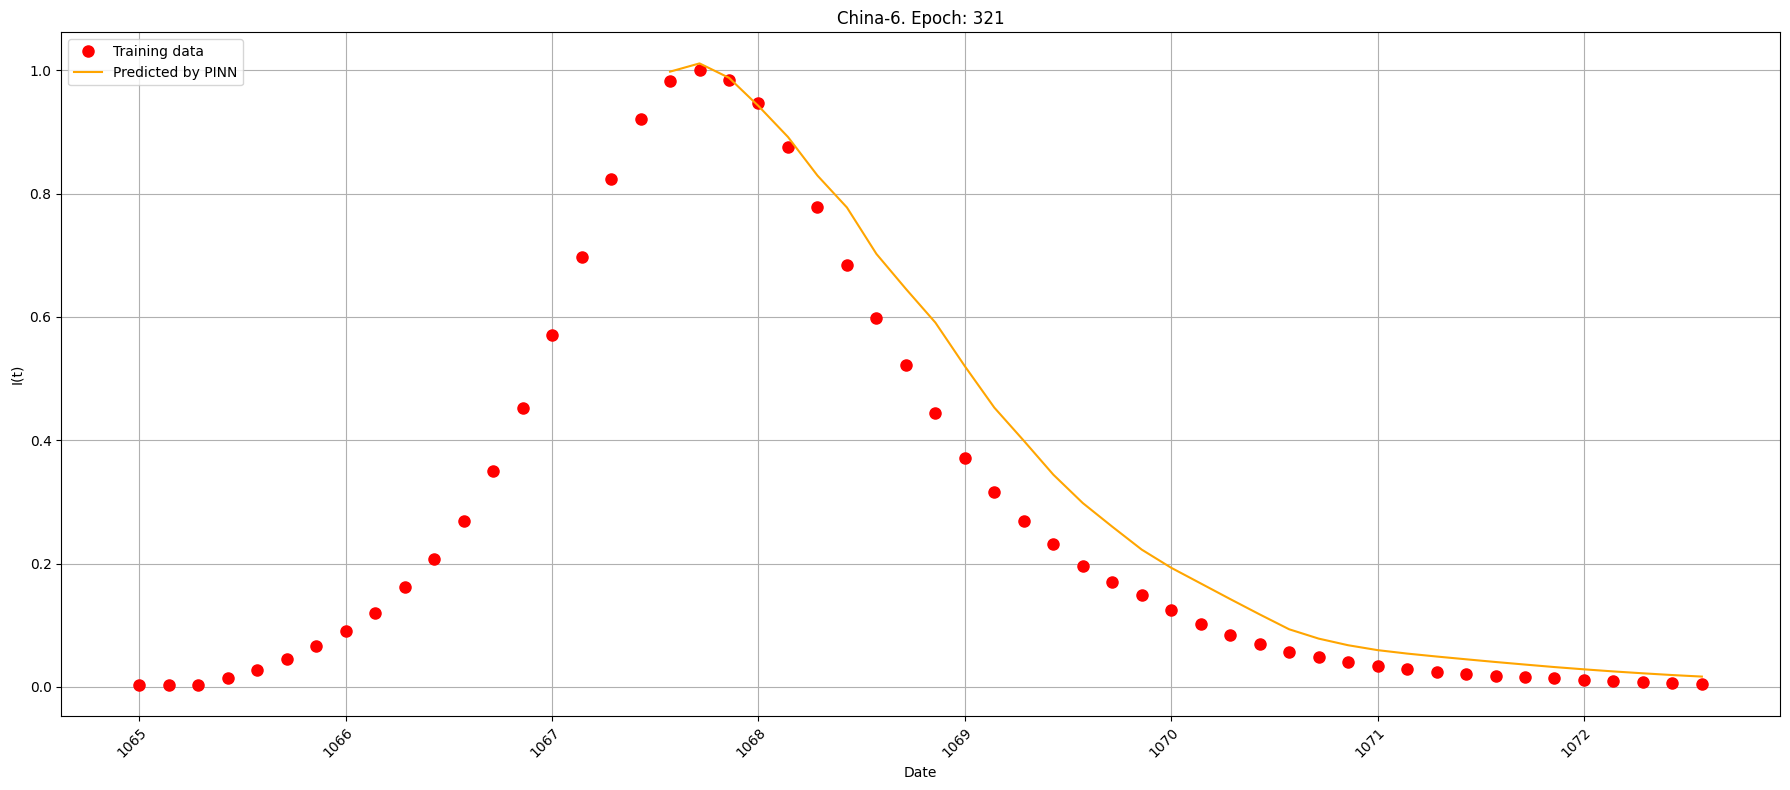

Epoch 321, MSE Loss = 5.5015527323121205e-05, SIR Loss = 3.3140357862462833e-13, Average Loss = 0.0004009864154642355


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Epoch 331, MSE Loss = 2.161806150979828e-05, SIR Loss = 2.7502952693048144e-10, Average Loss = 0.00011576738975723898
Epoch 331, MSE Loss = 0.0002816245541907847, SIR Loss = 1.137433810333155e-11, Average Loss = 0.00028814979114808164
Epoch 331, MSE Loss = 4.880533742834814e-05, SIR Loss = 1.8065272888723172e-10, Average Loss = 0.00030815314043008426
Epoch 331, MSE Loss = 6.6506731855042744e-06, SIR Loss = 5.77803638268648e-11, Average Loss = 0.00018329559617002422
Epoch 331, MSE Loss = 0.0002455200010444969, SIR Loss = 1.005378397721246e-12, Average Loss = 0.00043636887537647716
Epoch 331, MSE Loss = 0.00019033849821425974, SIR Loss = 3.702950706480079e-12, Average Loss = 0.00019387501911357472
Epoch 331, MSE Loss = 4.6785473386989906e-05, SIR Loss = 9.868423786474345e-12, Average Loss = 0.00028129543909471977
Epoch 331, MSE Loss = 7.749861651973333e-06, SIR Loss = 3.9668823781369156e-12, Average Loss = 0.0005416574241043089
Epoch 331, MSE Loss = 3.484774424578063e-05, SIR Loss = 3.80

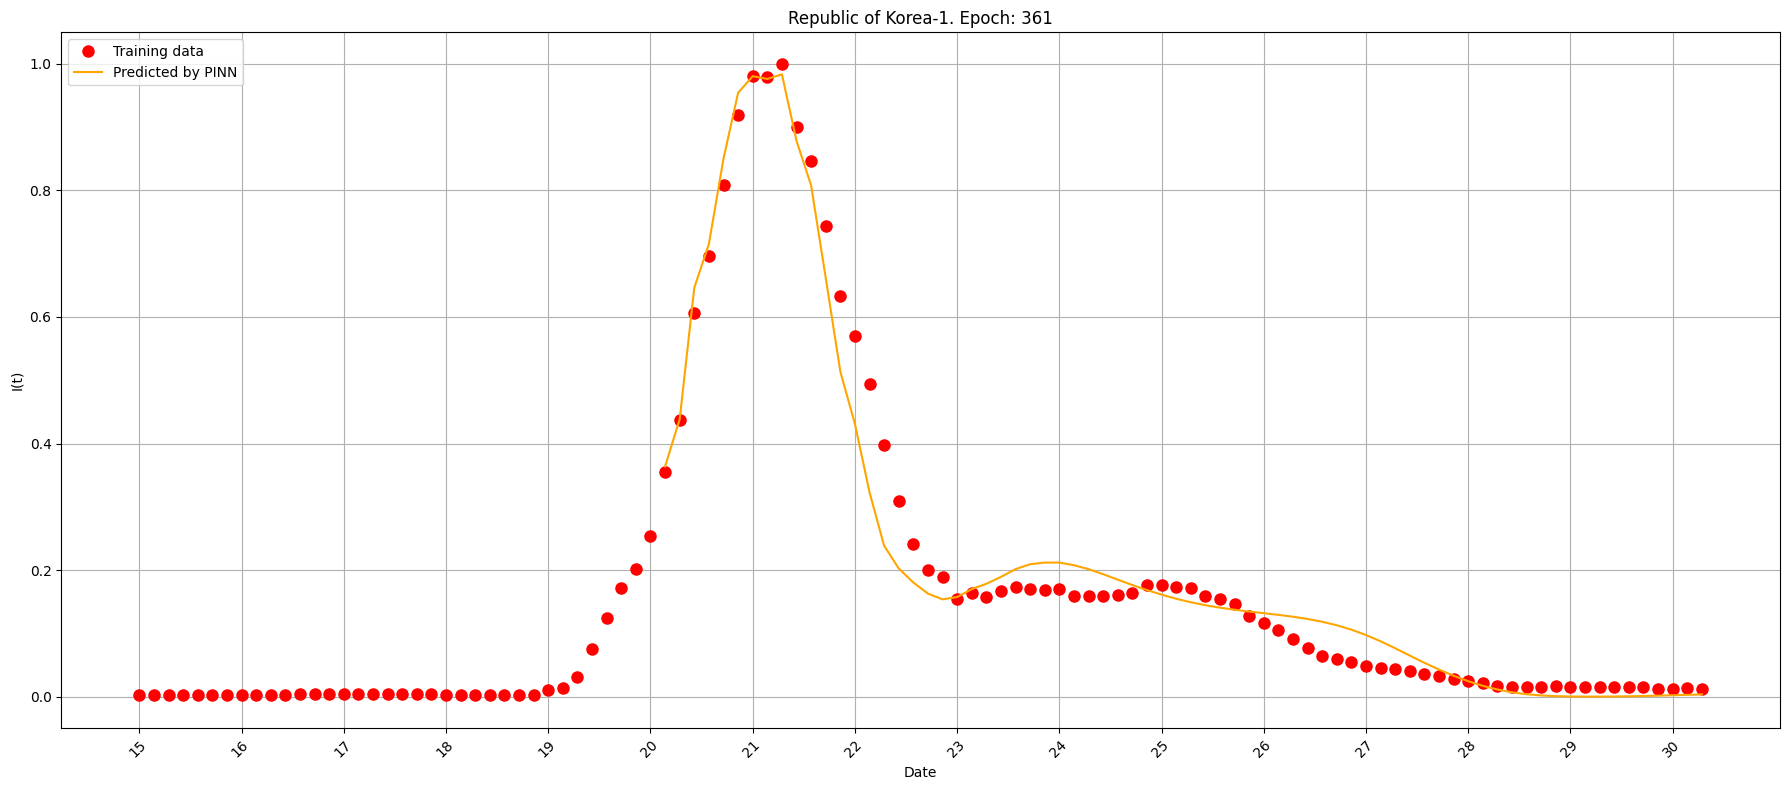

Epoch 361, MSE Loss = 6.4420532908116e-07, SIR Loss = 7.321399597692846e-10, Average Loss = 0.0001235103991654674


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


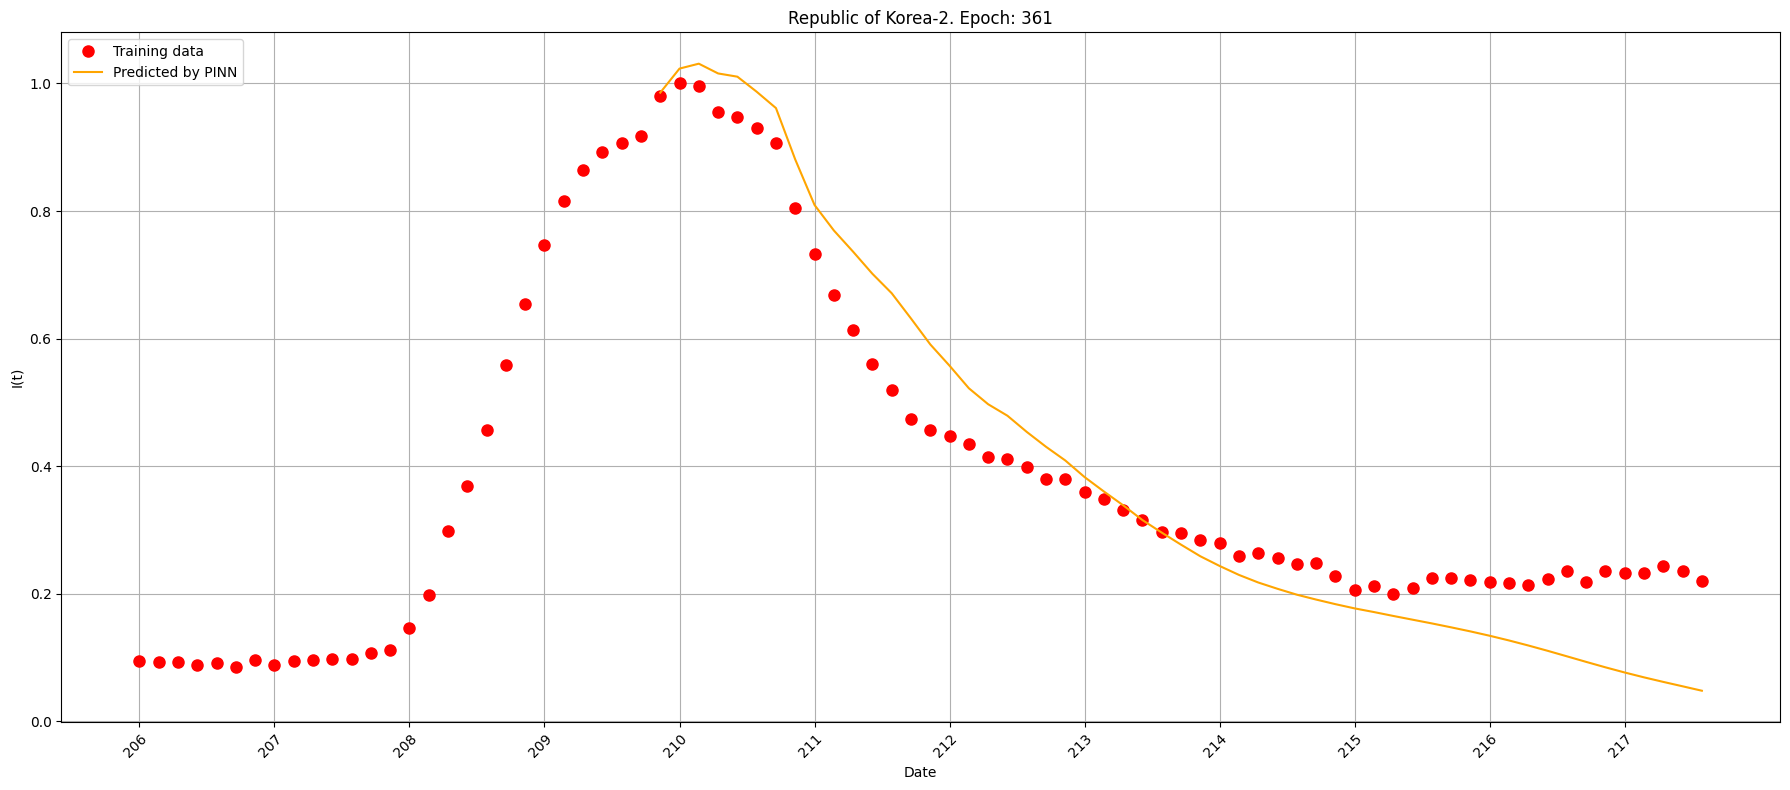

Epoch 361, MSE Loss = 0.0003272975154686719, SIR Loss = 3.8232832698381625e-12, Average Loss = 0.0003117769377417782


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


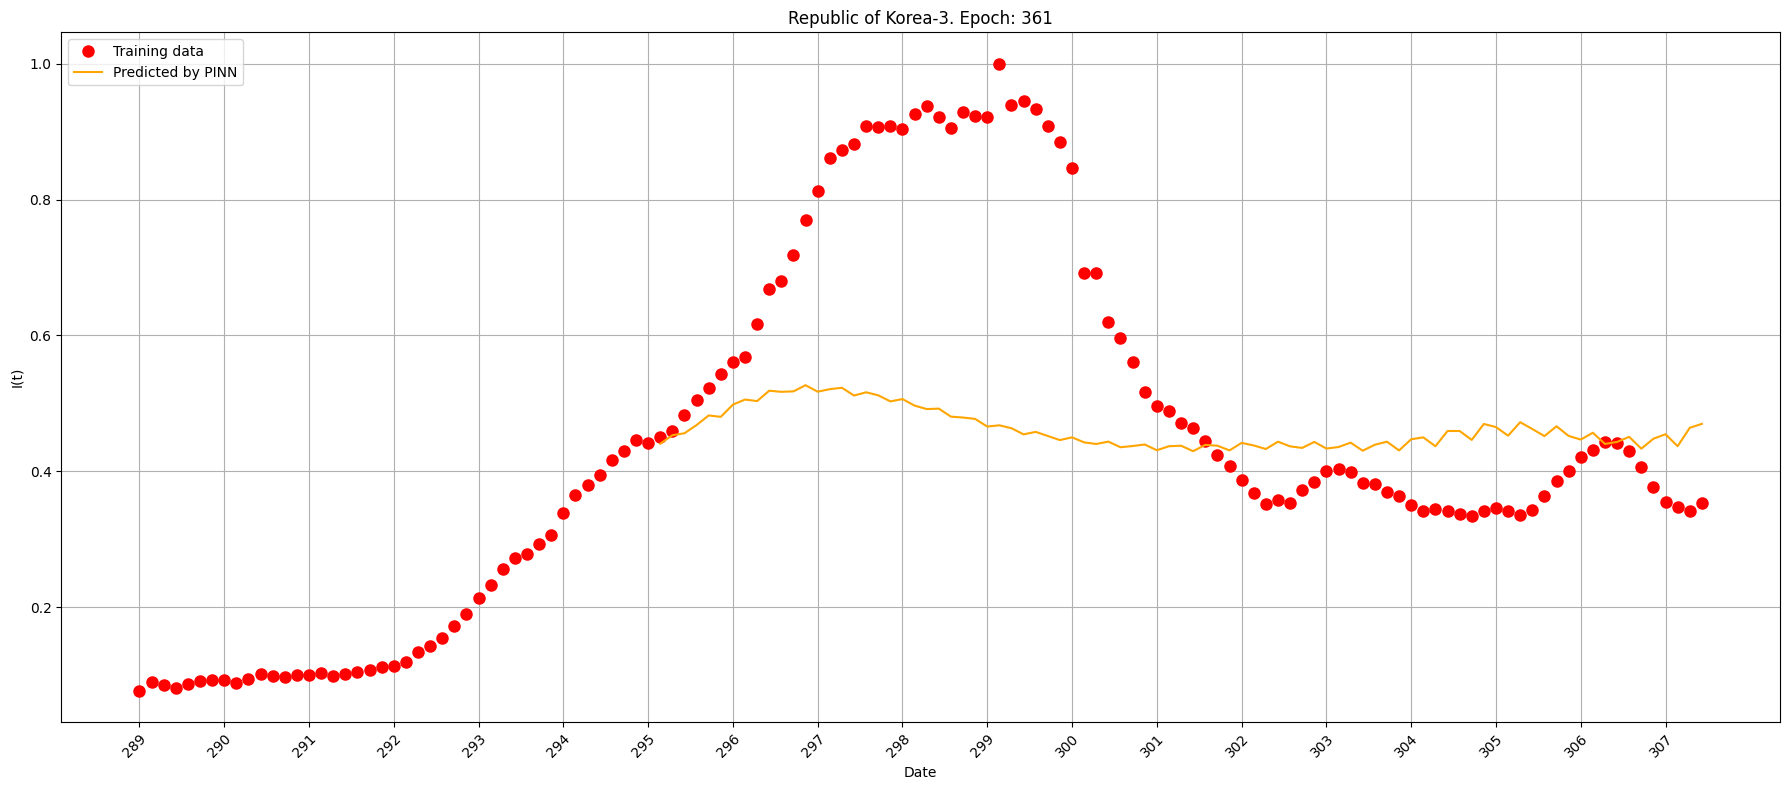

Epoch 361, MSE Loss = 6.595882041438017e-06, SIR Loss = 6.532076854241786e-14, Average Loss = 0.00030612432372690863


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


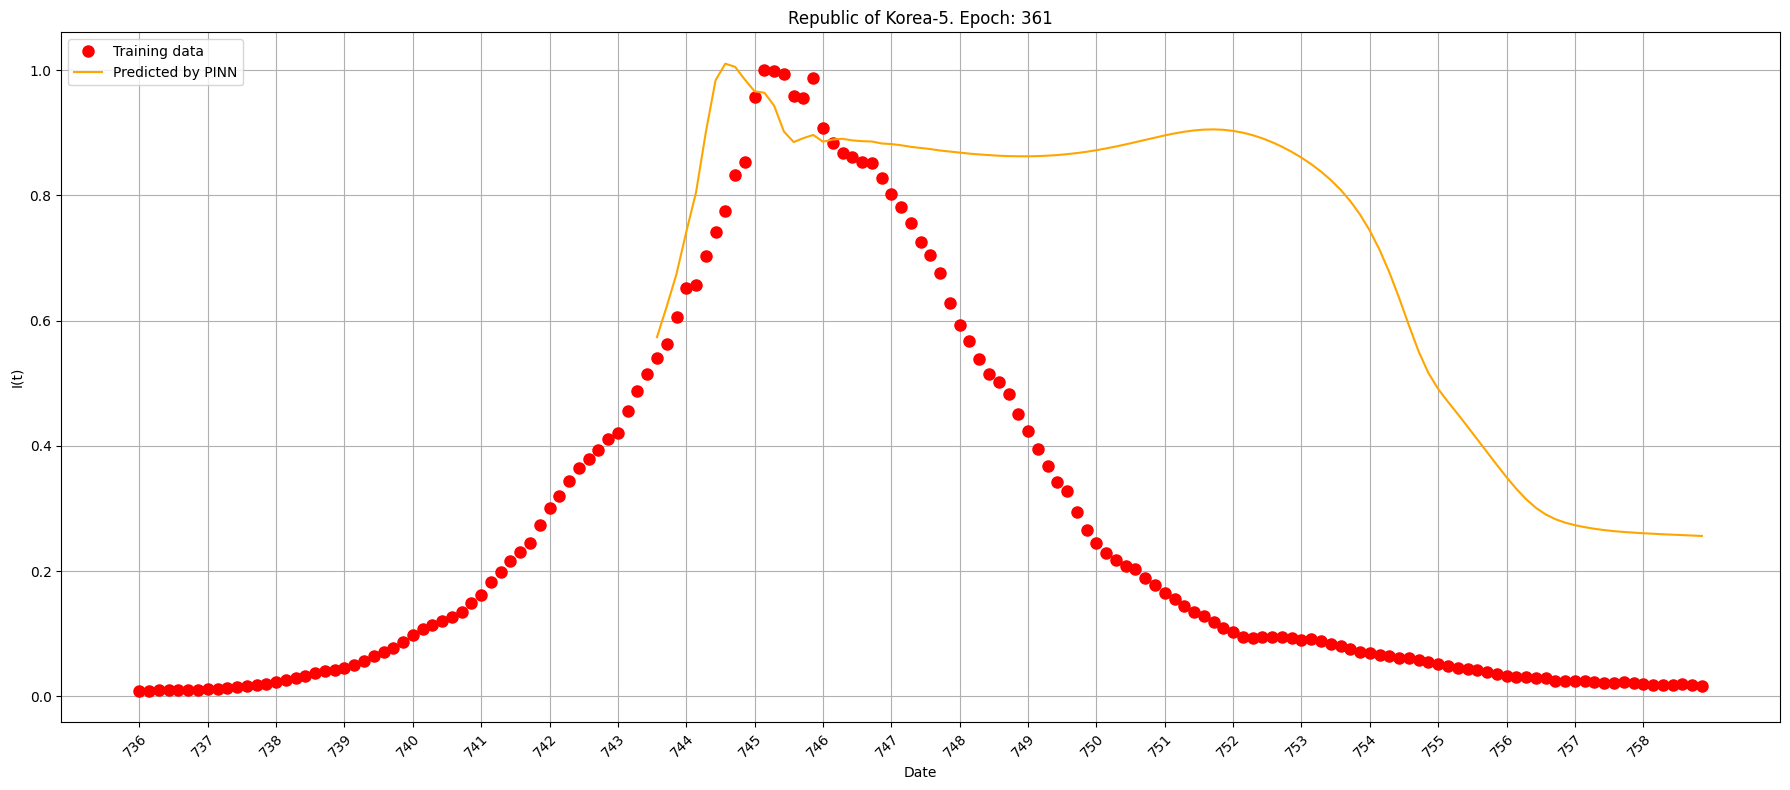

Epoch 361, MSE Loss = 1.5461862858501263e-05, SIR Loss = 0.0, Average Loss = 0.0001109079526326682


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


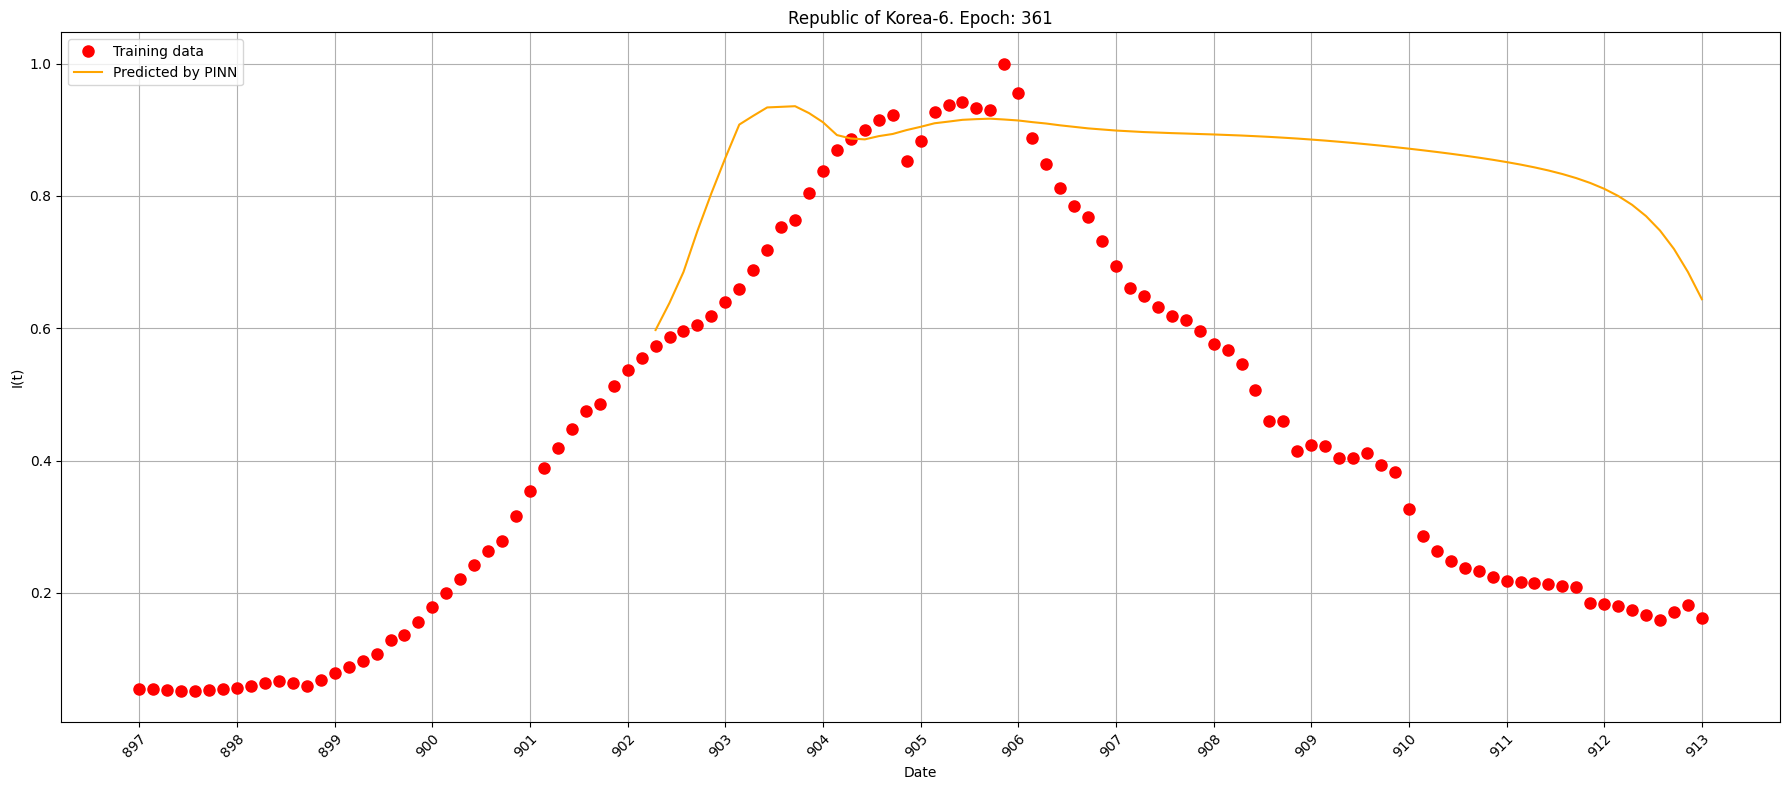

Epoch 361, MSE Loss = 0.00020704098278656602, SIR Loss = 0.0, Average Loss = 0.0003271121740637901


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


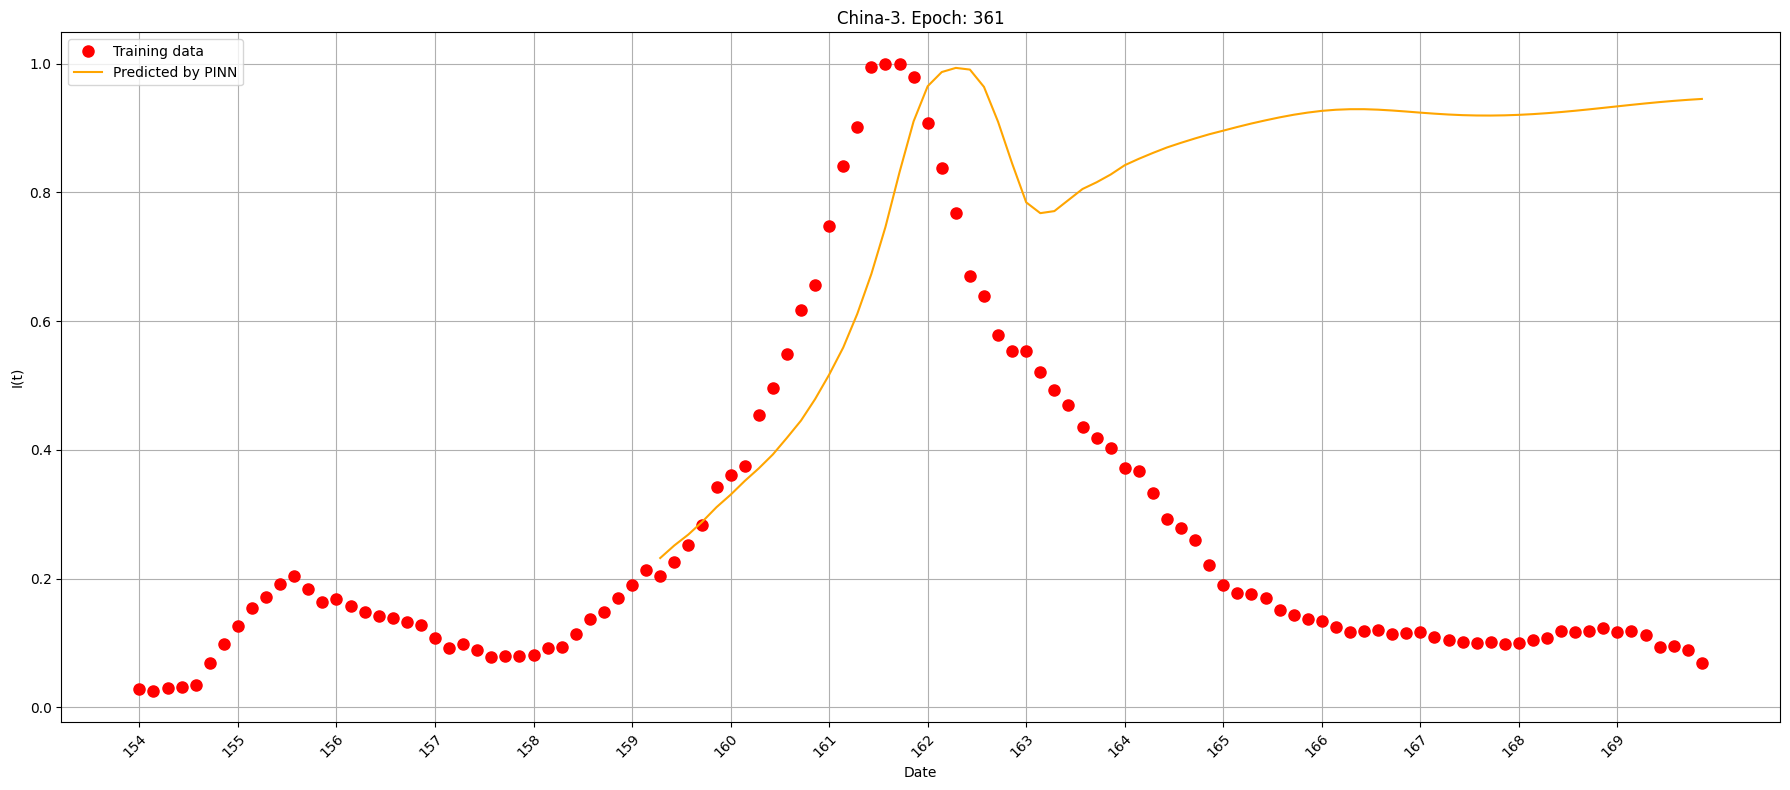

Epoch 361, MSE Loss = 0.00011657910363283008, SIR Loss = 1.6629059240713673e-10, Average Loss = 0.00024585295504501965


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


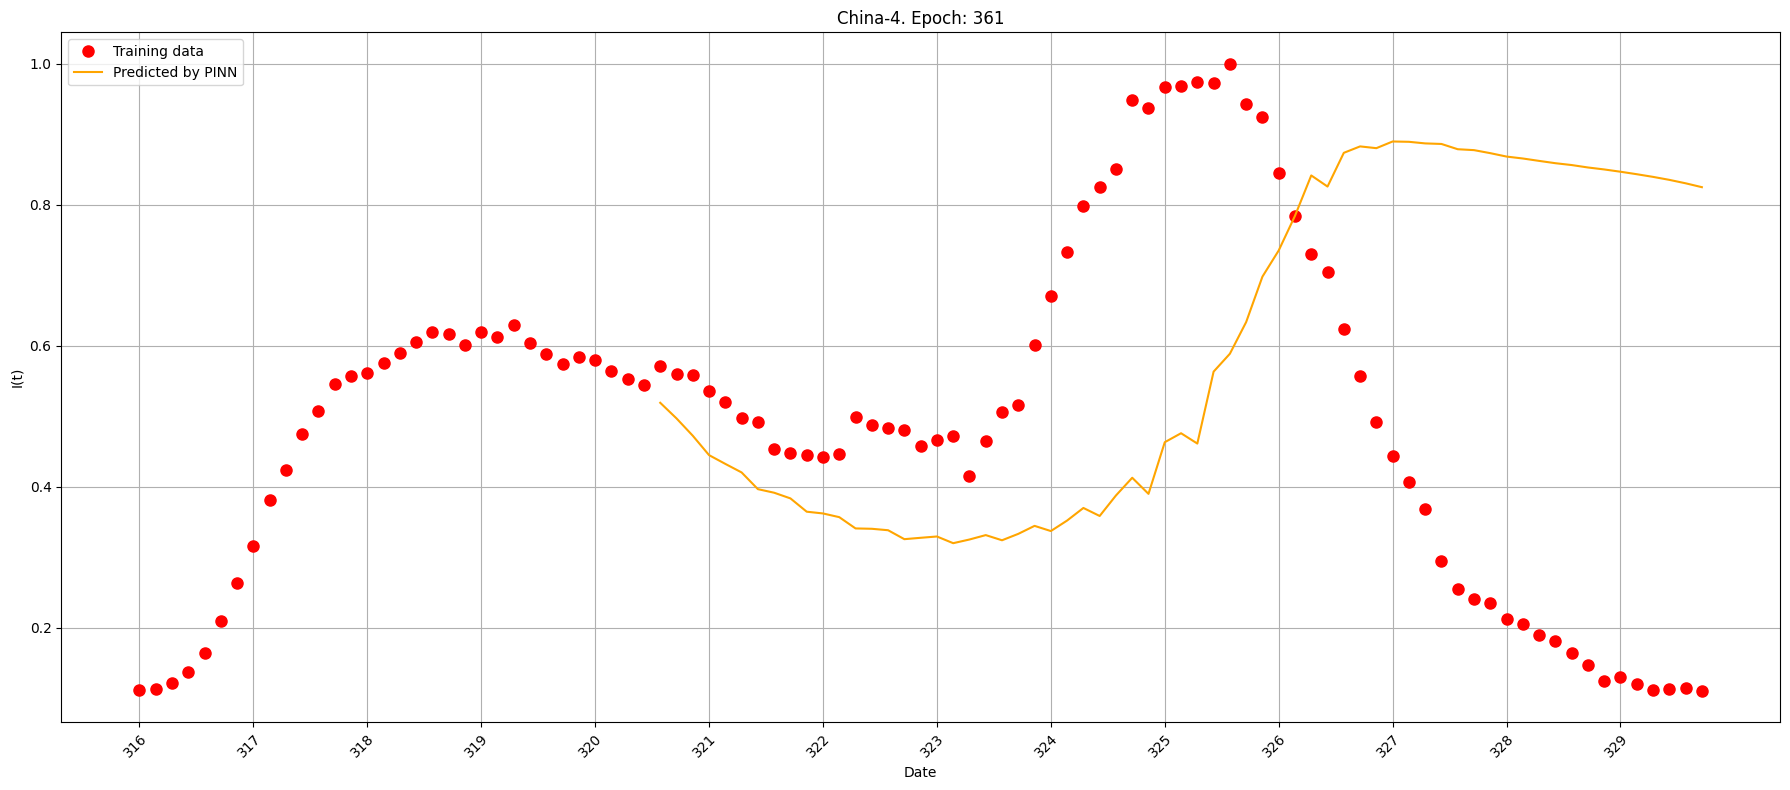

Epoch 361, MSE Loss = 7.1599934017285705e-06, SIR Loss = 3.899856918518699e-14, Average Loss = 0.0003483026623549219


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


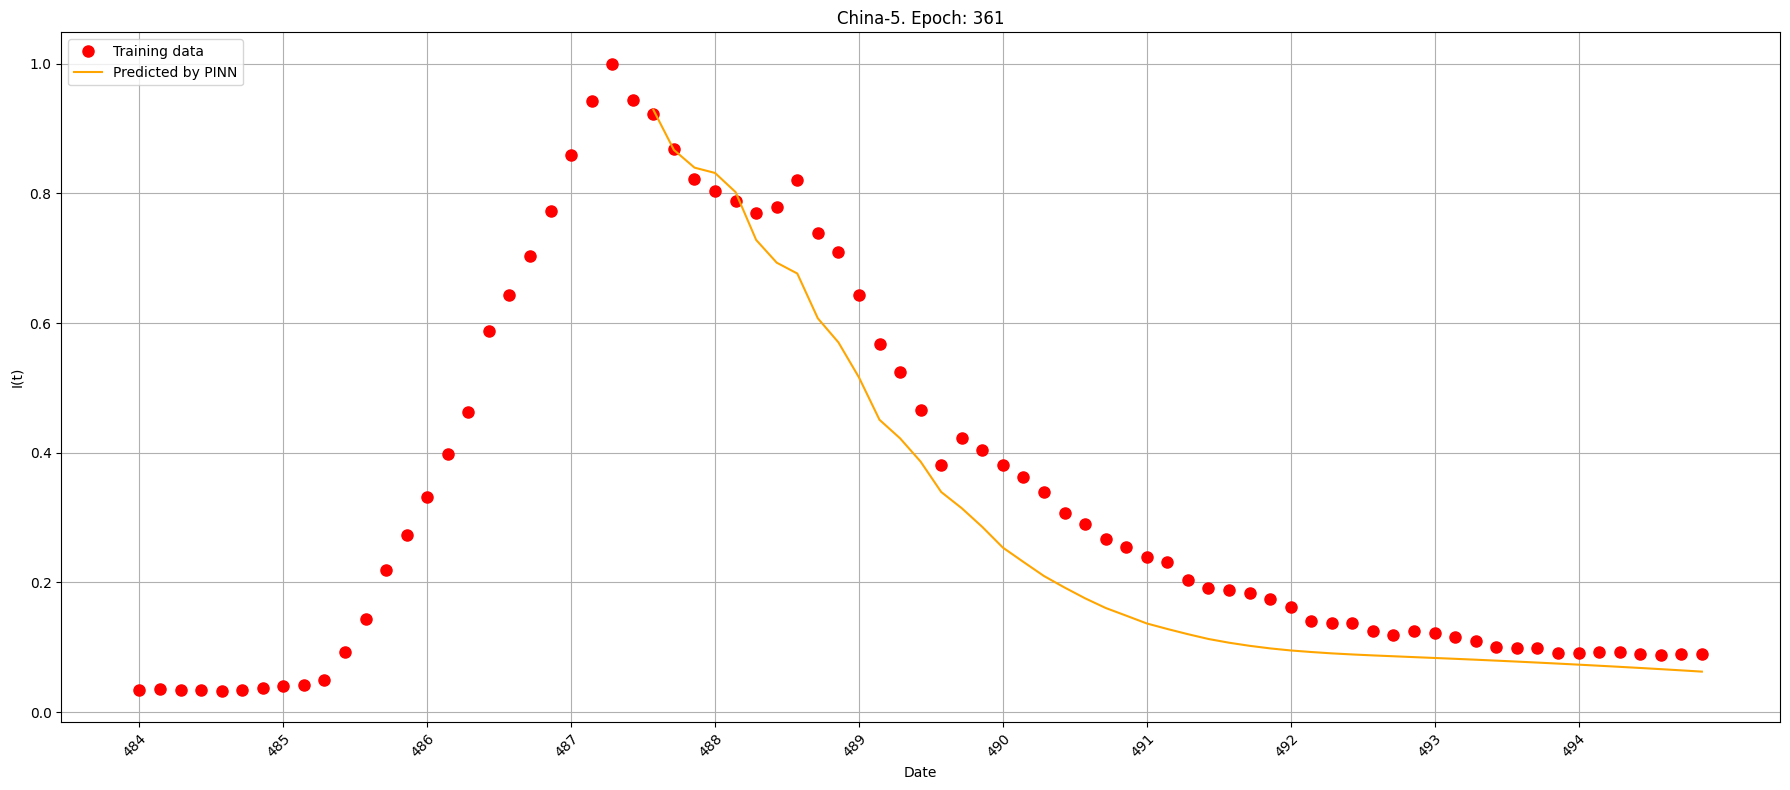

Epoch 361, MSE Loss = 2.508115539967548e-05, SIR Loss = 0.0, Average Loss = 0.00036287953773058237


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


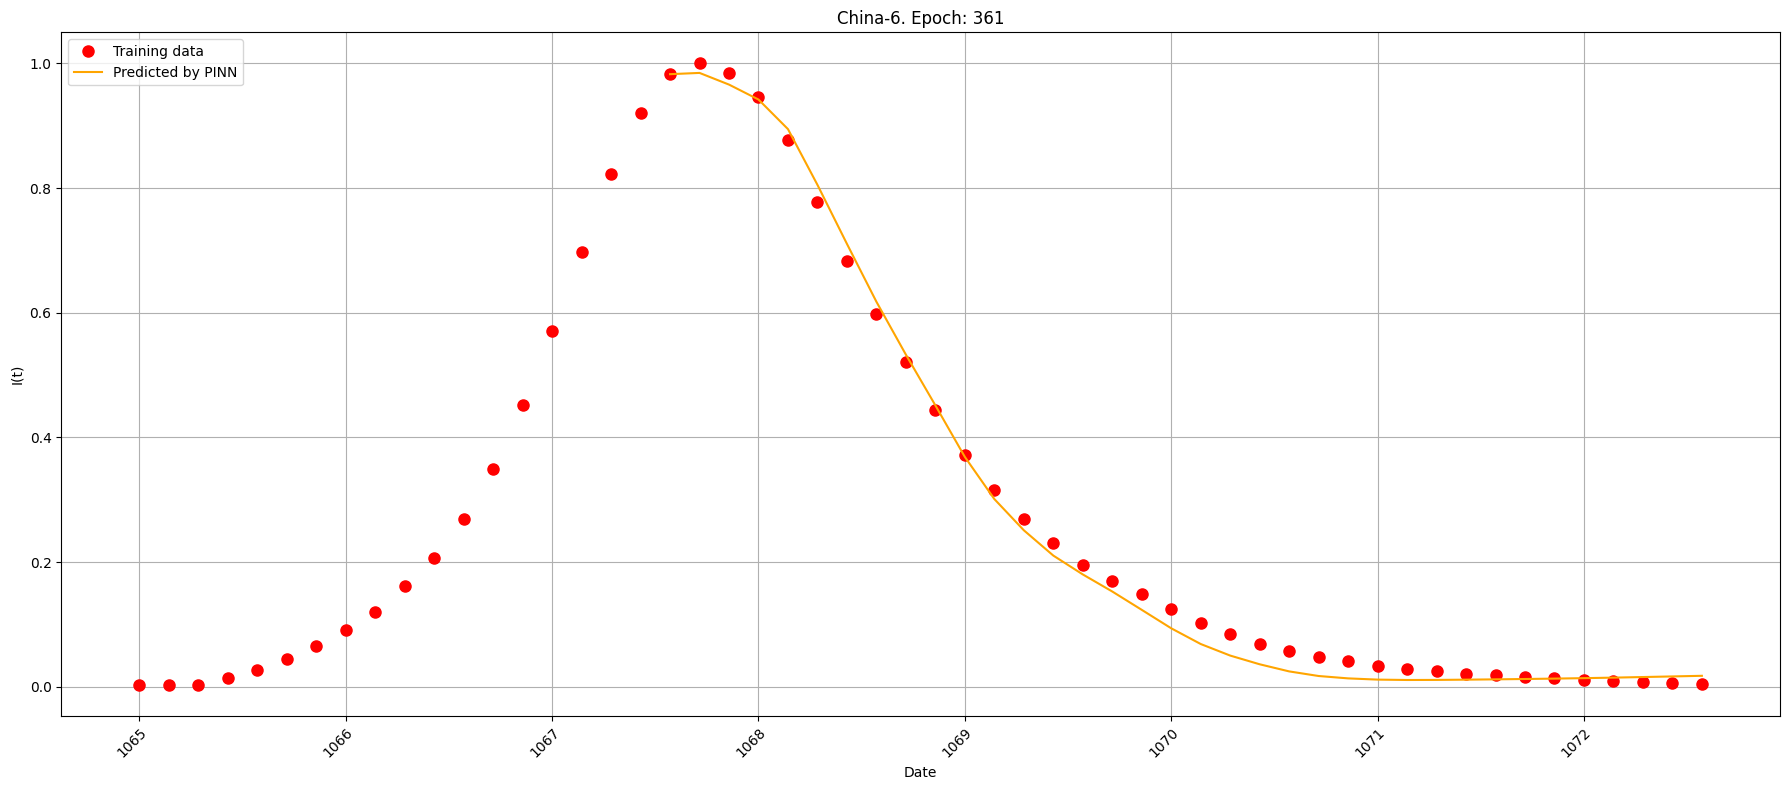

Epoch 361, MSE Loss = 1.3330937690625433e-05, SIR Loss = 0.0, Average Loss = 9.329877338331773e-05


C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_25628\2366677166.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Early stopping at epoch 368.


In [ ]:
#autoregressive training version
def train_autoregressive(model, optimizer, data, t_data, real_t, sigma, sigma0, mu, epoch, display_step, date_ticks, country, wave):
    # Number of autoregressive steps (how far ahead to predict at each iteration)
    start_point = 7  # Predict one week ahead

    model.train()

    optimizer.zero_grad()
    total_loss = 0.0

    input_sequence = data[:start_point]
    input_t_sequence = t_data[:start_point]

    input_sequence = list(input_sequence)

    for i in range(start_point, len(data)):
        input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
        input_tensor = torch.tensor(input_sequence, dtype=torch.float32).view(-1, 1).to(device)
        target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)

        with torch.backends.cudnn.flags(enabled=False):
            # Forward pass
            predicted = model(input_tensor)
            mse_loss = MSE_loss(target, predicted)
            sir_loss = SIR_loss(model, input_t, sigma, sigma0, mu)
            # Combine losses
            loss = mse_loss + sir_loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() # Clear gradients

        total_loss += loss.item()

        input_sequence.append(data[i])

    avg_loss = total_loss / (len(data) - start_point)

    test_start_point = int(len(data) / 3)

    if epoch % display_step == 0:
        with torch.no_grad():
            predicted_values = autoregressive_predict(model, data[:test_start_point], len(data) - test_start_point, delta_t=1)
            # Ensure dimensions match for plotting
            predicted_values = predicted_values[:len(data) - start_point]  # Slice to match y_data
            plot_predictions(
                data,
                test_start_point,
                predicted_values=predicted_values,
                date_ticks=date_ticks,
                country=country,
                wave=wave,
                epoch=epoch,
            )

    return mse_loss, sir_loss, avg_loss

def autoregressive_predict(model, given_data, steps, delta_t):
    """
    Predict future values in an autoregressive manner with multi-step outputs.
    
    Parameters:
        model: Trained PINN model
        data: data for prediction test
        steps: Number of future steps to predict
        delta_t: Step size for time
    
    Returns:
        Predicted values (list)
    """
    model.eval()
    input_sequence = list(given_data)
    predictions = torch.tensor([])

    with torch.no_grad():
        for _ in range(steps):
            input_tensor = torch.tensor(input_sequence, dtype=torch.float32).view(-1, 1).to(device)
            predicted = model(input_tensor).squeeze()
            predictions = np.append(predictions, predicted.cpu().numpy())
            input_sequence.append(predicted)
    
    return predictions

# Initialize parameters
sigma = torch.tensor([0.1], requires_grad=True).to(device)
sigma0 = torch.tensor([0.1], requires_grad=True).to(device)
mu = torch.tensor([0.1], requires_grad=True).to(device)

# Initialize the model and optimizer
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000
patience = 100
display_step = 40

early_stopping = EarlyStopping(model, patience, display_step, sigma, sigma0, mu)
losses = []

for epoch in range(epochs):
    for country in training_coutries:
        for wave in data[country]:
            optimizer.zero_grad()

            t_data = torch.tensor(time_data[country][wave], dtype=torch.float32).view(-1, 1).to(device)
            y_data = torch.tensor(data[country][wave], dtype=torch.float32).view(-1, 1).to(device)
            real_t = real_time_data[country][wave] # Real time data for plotting

            train_data = y_data / max(y_data)  # Normalize data

            mse_loss, sir_loss, avg_loss = train_autoregressive(
                model=model,
                optimizer=optimizer,
                data=train_data,
                t_data=t_data,
                real_t=real_t,
                sigma=sigma,
                sigma0=sigma0,
                mu=mu,
                epoch=epoch,
                display_step=display_step,
                date_ticks=time_data[country][wave],
                country=country,
                wave=wave
            )

            losses.append(avg_loss)

            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}, MSE Loss = {mse_loss.item()}, SIR Loss = {sir_loss.item()}, Average Loss = {avg_loss}")

    if early_stopping.check_early_stopping(avg_loss, epoch):
        break

In [65]:
# 12.07, Autoregressive 1 step, LSTM
torch.save(model.state_dict(), f"models/model1.pt")

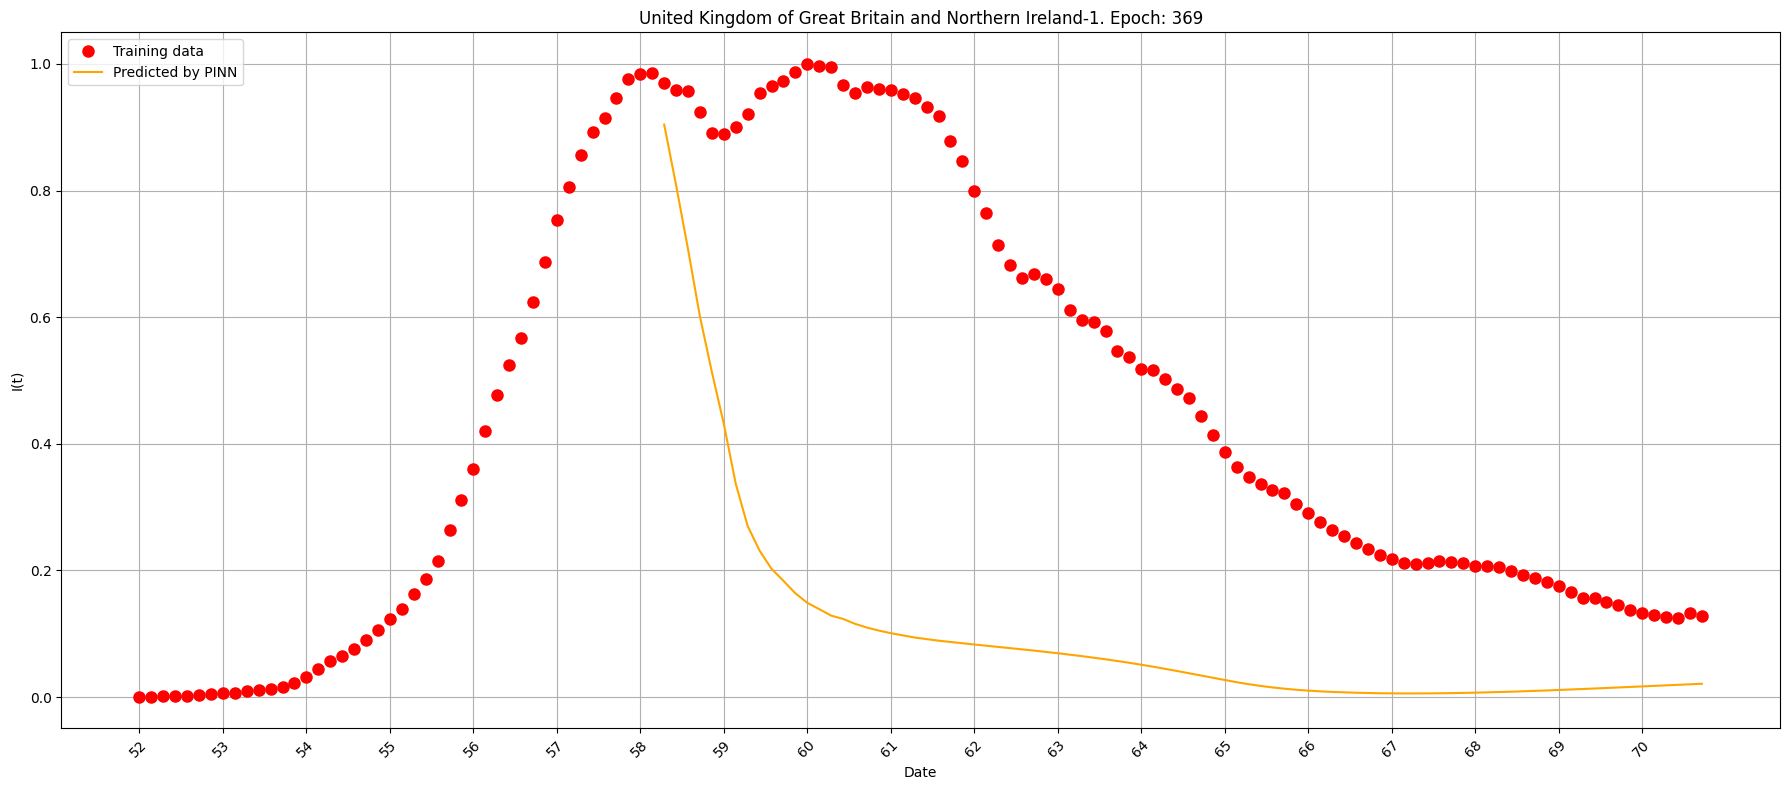

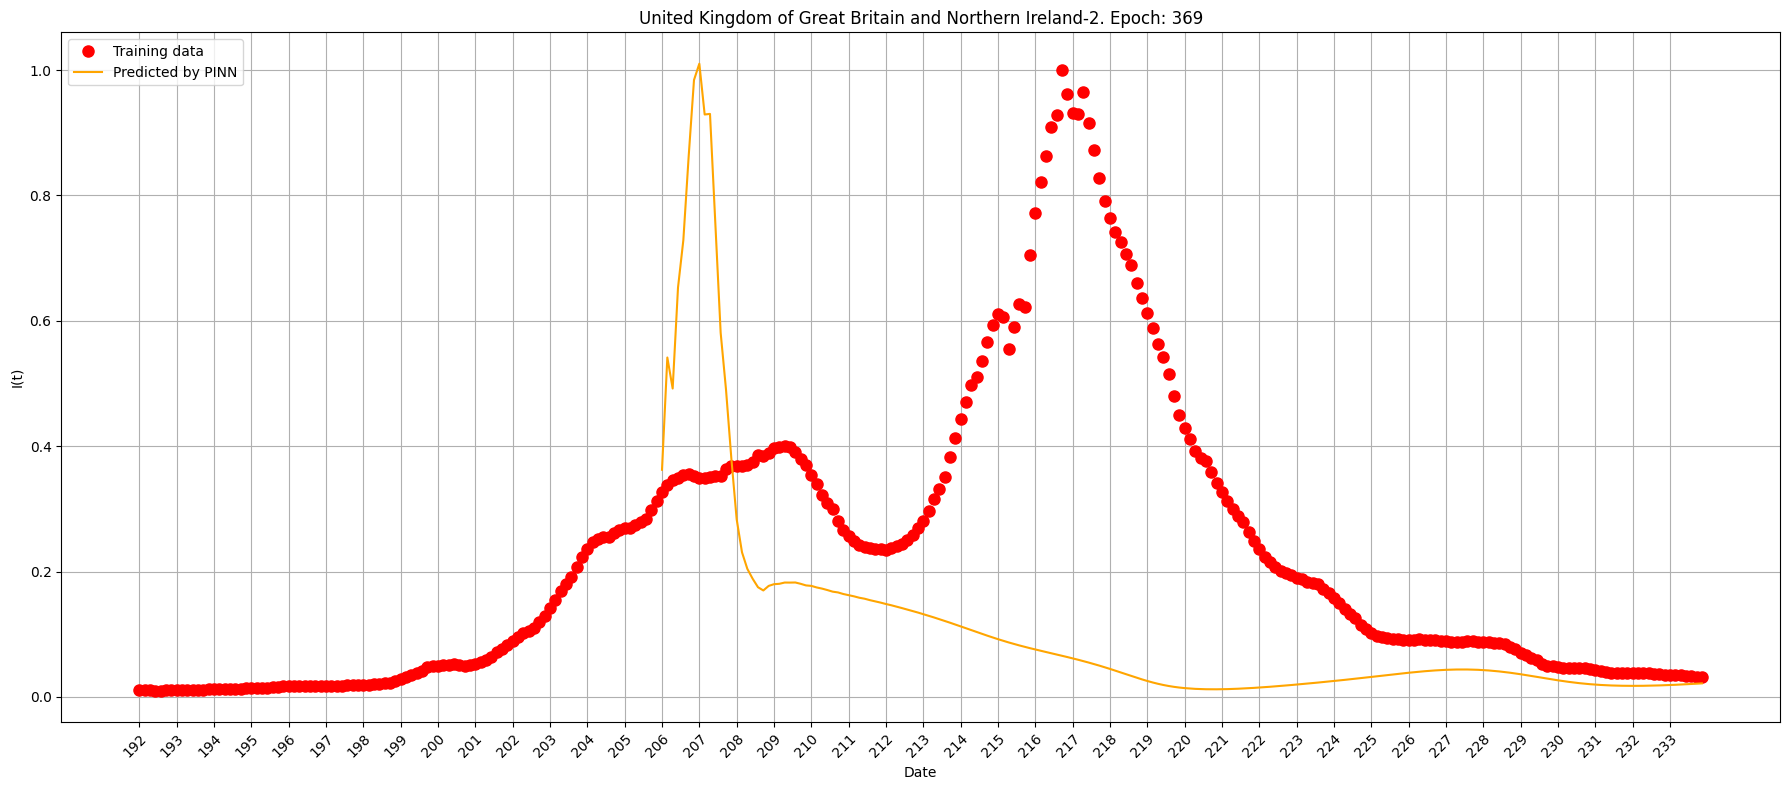

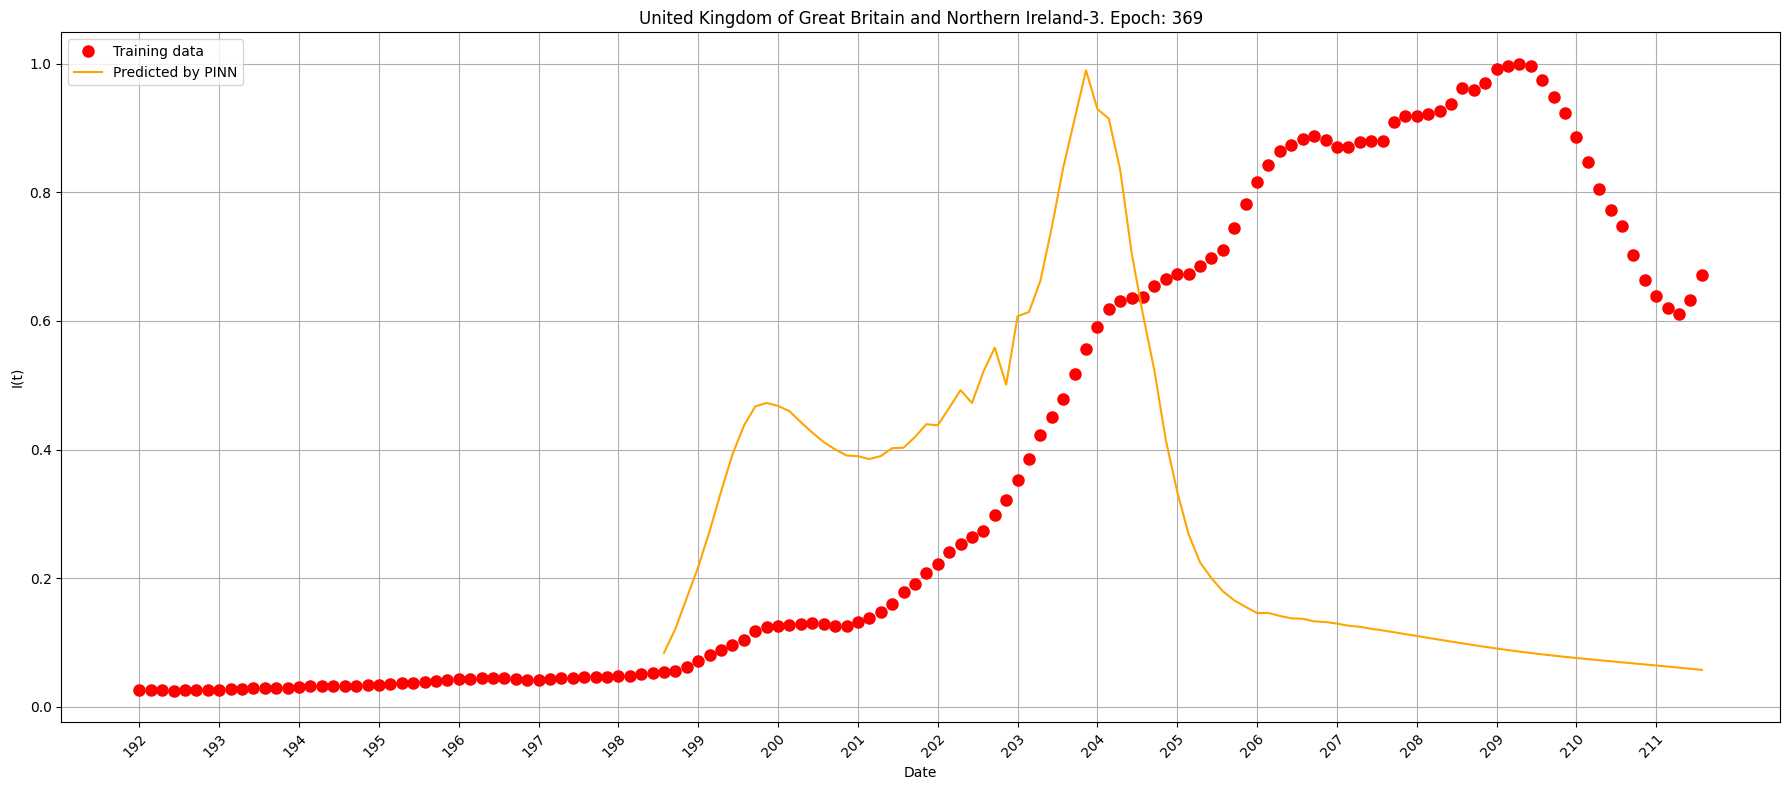

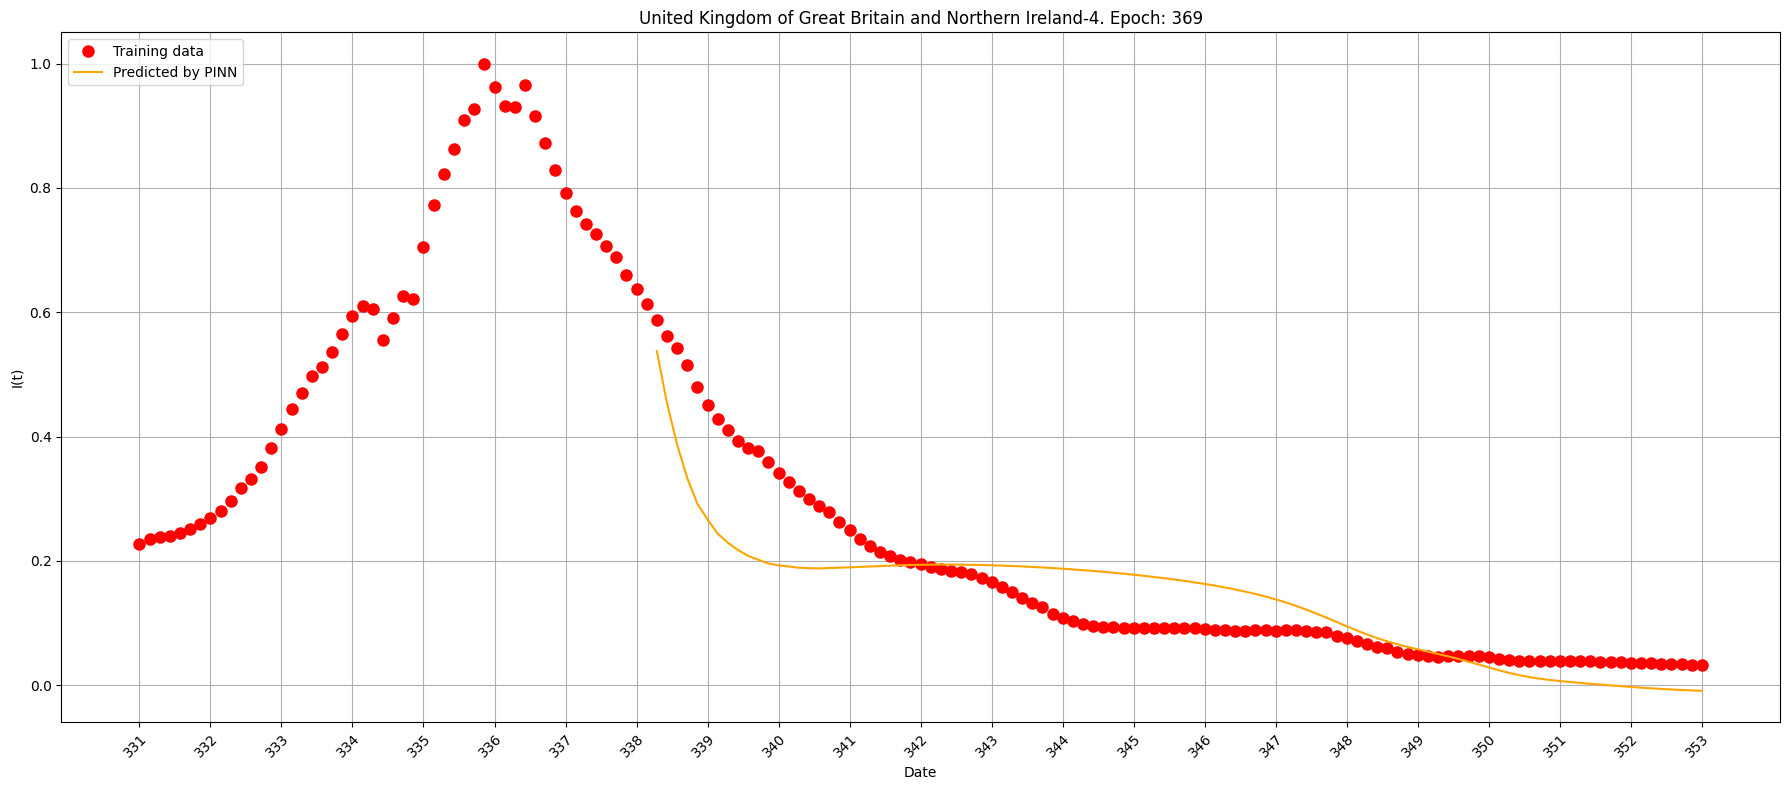

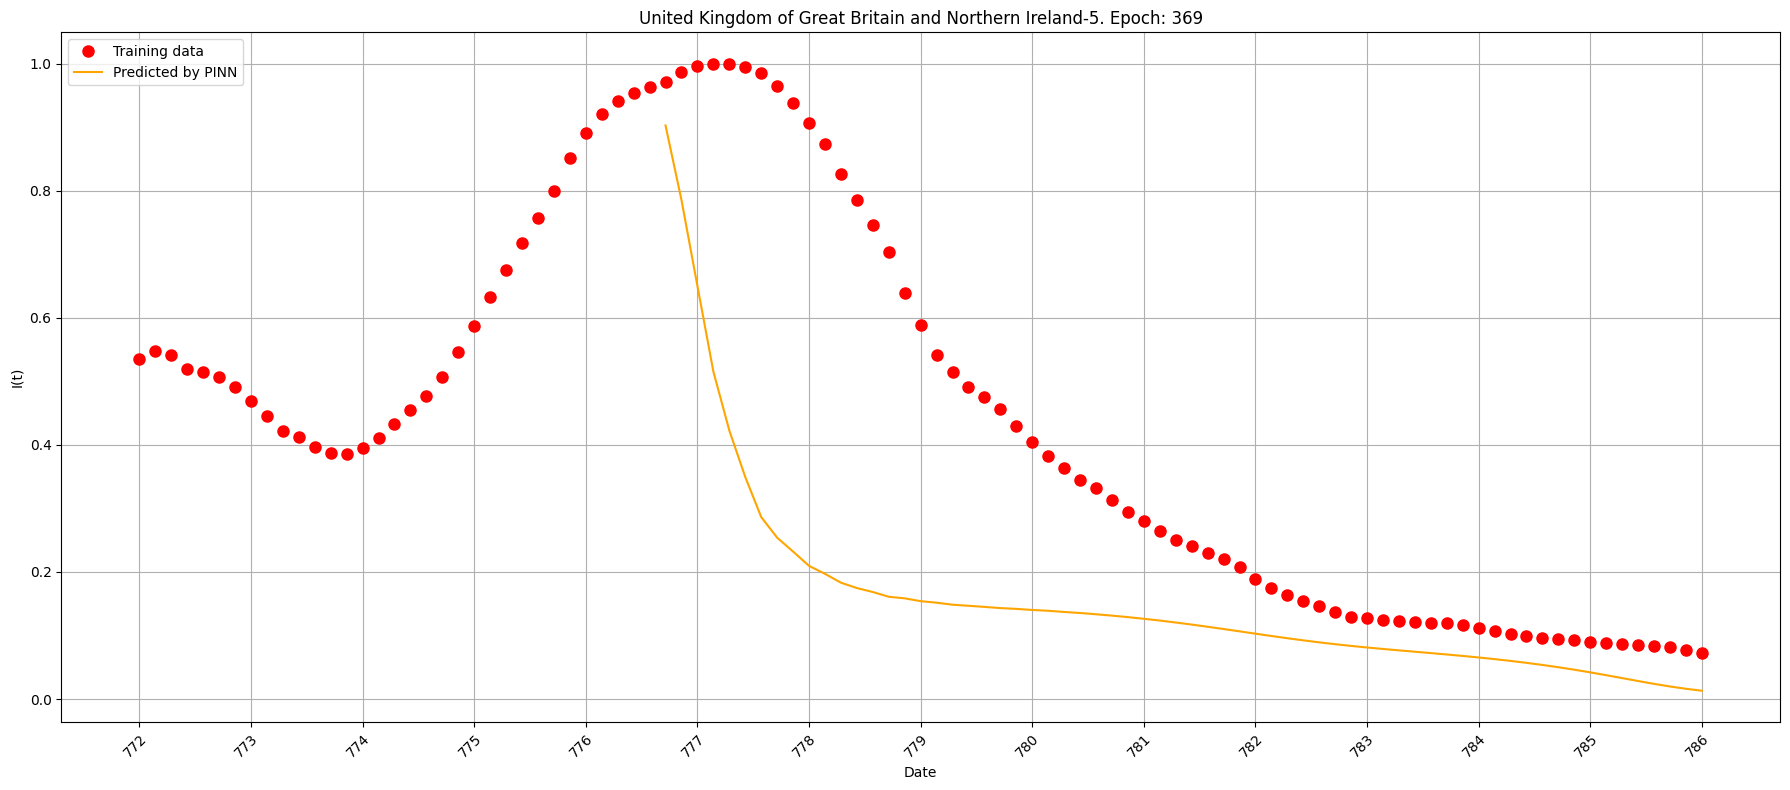

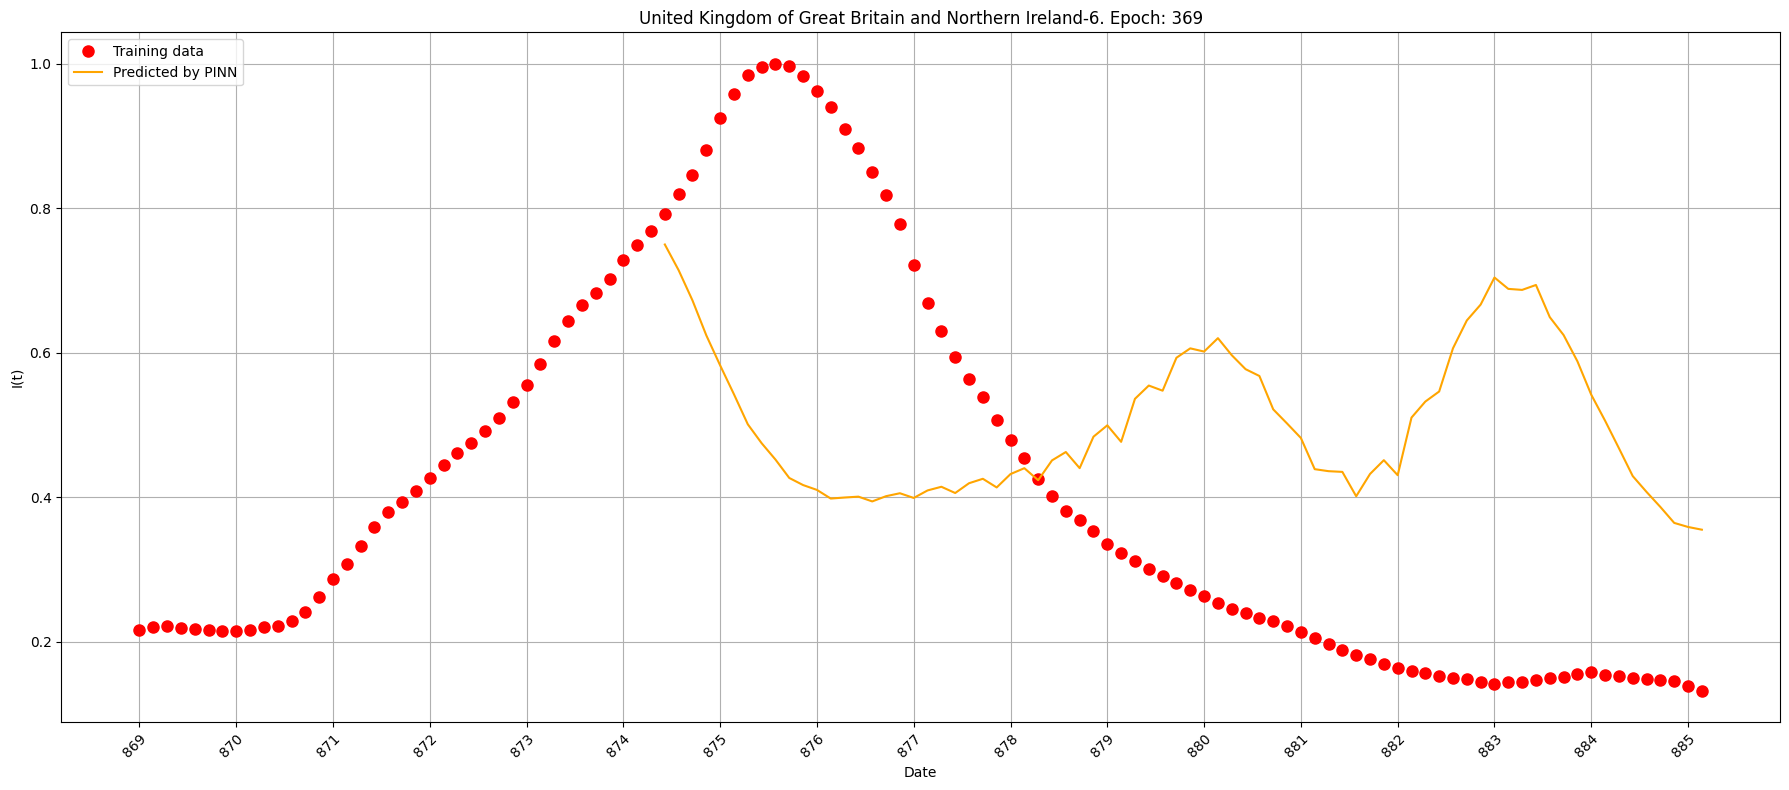

In [69]:
for country in test_coutries:
    for wave in data[country]:
        t_data = torch.tensor(time_data[country][wave], dtype=torch.float32).view(-1, 1).to(device)
        y_data = torch.tensor(data[country][wave], dtype=torch.float32).view(-1, 1).to(device)
        real_t = real_time_data[country][wave] # Real time data for plotting
        date_ticks=time_data[country][wave]

        test_data = y_data / max(y_data)  # Normalize data

        test_start_point = int(len(test_data) / 3)
        start_point = 7

        predicted_values = autoregressive_predict(model, test_data[:test_start_point], len(test_data) - test_start_point, delta_t=1)
        # Ensure dimensions match for plotting
        predicted_values = predicted_values[:len(test_data) - start_point]  # Slice to match y_data
        plot_predictions(
            test_data,
            test_start_point,
            predicted_values=predicted_values,
            date_ticks=date_ticks,
            country=country,
            wave=wave,
            epoch=epoch,
        )